### Packages

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import scipy.stats as stats
import matplotlib.pyplot as plt

### Cournot

Dynamic Demand:
- $p_t = u_t - v \sum_i q_{it} + x_t$ 
- $x_t = \rho x_{t-1} + e_t, e_t \sim N(0,\sigma)$

Walrasian 
- $\pi_w = \max_{q_i}{(p - w) q_i}$ 
- $w = u - v Q$
- $Q_w = \frac{u-w}{v}$
- $P_w = w$
- $q_w \in [0,Q_w], \pi_w = 0, \Pi_w = 0$

Nash
- $\pi_c = \max_{q_i}{(p(Q) - w) q_i}$ 
- $p(Q) - w - v q_i = 0$
- $n p(Q) = n w + v Q = n u - n v Q$
- $Q_c = \frac{n(u-w)}{v(n+1)}$
- $P_c = u - v Q$
- $q_c = Q_c/n$

Monopoly
- $\pi_m = \max_{Q}{(p(Q) - w) Q}$ 
- $p(Q)=w+vQ=u-vQ$ 
- $Q_m =\frac{u-w}{2v}$ 
- $P_m =\frac{u-w}{2v}$


In [2]:
# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.05
rho = 0

In [8]:
def price(Q,u,v):
    return u-v*Q

def profit(P,Q):
    return
           
class cournot:
    def __init__(self,u,v,w,n):
        self.u=u
        self.v=v
        self.w=w
        self.n=n
        self.Qw=(u-w)/v
        self.Qc=n*(u-w)/v/(n+1)
        self.Qm=(u-w)/2*v
        self.Pw = price(self.Qw,u,v)
        self.Pc = price(self.Qc,u,v)
        self.Pm = price(self.Qm,u,v)
        self.Πw = 0
        self.Πc = (self.Pc-w)*self.Qc
        self.Πm = (self.Pm-w)*self.Qm
        self.qw = self.Qw/n
        self.qc = self.Qc/n
        self.qm = self.Qm/n
        self.πw = 0
        self.πc = self.Πc/n
        self.πm = self.Πm/n
    
    def price(self,q,q_):
        return self.u-v*(q+q_)
    
    def mprice(self,Q):
        return self.u-v*(Q)
    
    def profit(self,q,q_):
        return (self.price(q,q_)-w)*q

    def mprofit(self,Q):
        return (self.mprice(Q)-w)*Q
        
        
game1 = cournot(40,1,4,2)

In [9]:
game1.Qc, game1.qc, game1.Pc, game1.w, game1.Πc, game1.profit(12, 12), game1.mprofit(12)

(24.0, 12.0, 16.0, 4, 288.0, 144, 288)

In [397]:
game1.Qm, game1.qm, game1.Pm, game1.w, game1.Πm, game1.profit(9,9)

(18.0, 9.0, 22.0, 4, 324.0, 162)

### Shocks

In [10]:
# Input: ρ, σ, K
# Output: KxK Transition Matrix
ρ, σ, K = 0.9, 1, 10
σy = σ/np.sqrt(1-ρ**2)

def tauchen(ρ, σ, K, m=3):
    Z = np.linspace(-m * σ/np.sqrt(1-ρ**2), m * σ/np.sqrt(1-ρ**2), K) # Shock Space
    F = lambda x: stats.norm.cdf(x, 0, σ) # CDF Function for Standard Normal
    α = Z[2] - Z[1] # Step Size
    P = np.zeros((K,K)) # Placeholder Transition Matrix
    # P[i,j] is probability of process going from Zi to Zj 
    for i in range(K):
        for j in range(K):
            if j == 1:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i])
            elif j == K:
                P[i, j] = 1 - F(Z[j]-α/2-ρ*Z[i])
            else:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i]) - F(Z[j]-α/2-ρ*Z[i])
        P[i, :] = P[i, :]/sum(P[i, :])
    return Z, α, F, P
        
def whichidx(value, array):
    return np.argmin(np.abs(array-value))

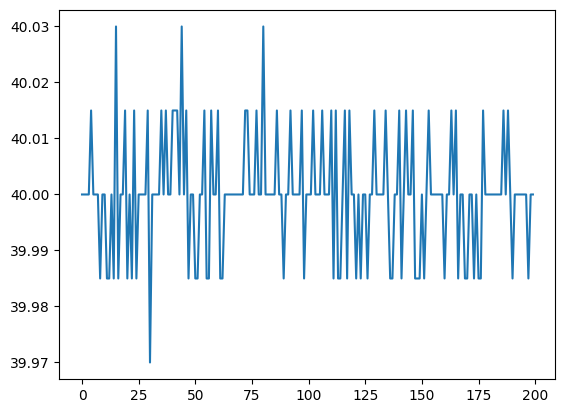

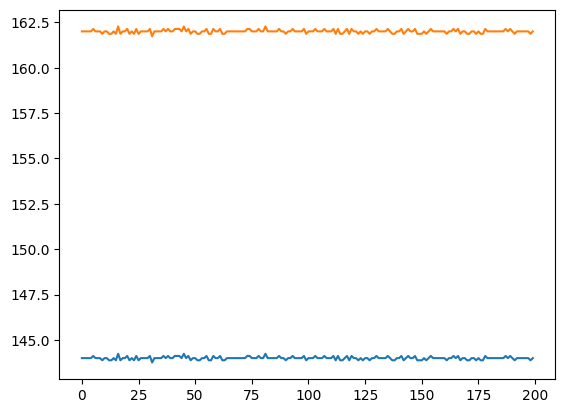

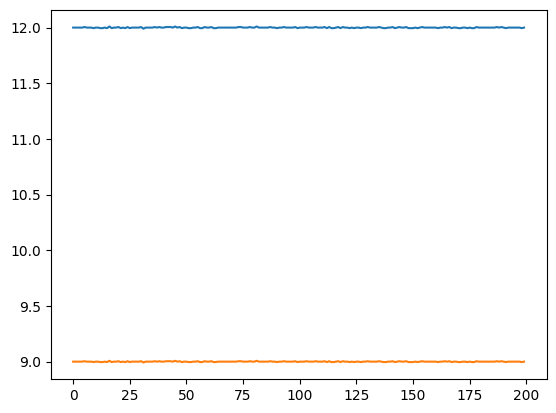

In [399]:
import numpy as np
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.01
rho = 0
e = np.random.normal(1)*sigma
K = 5
Z, α, F, P = tauchen(rho, sigma, K, m=3)
u_history=[]
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

uidx = 0
for t in range(200):
    # find competition level profit 
    qc_history.append(cournot(u,v,w,n).qc)
    qm_history.append(cournot(u,v,w,n).qm)
    pc_history.append(cournot(u,v,w,n).πc)
    pm_history.append(cournot(u,v,w,n).πm)
   
    # generate next shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    u_history.append(u)
    
plt.plot(u_history)
plt.show()

plt.plot(pc_history)
plt.plot(pm_history)
plt.show()

plt.plot(qc_history)
plt.plot(qm_history)
plt.show()

### Q-Learning

In [401]:
import random
import numpy as np

# initialize Boltzmann Q-learning parameters
alpha = 0.05
initial_temperature = 10.0
temperature_decay = 0.99999
min_temperature = 0.1
temperature = initial_temperature
initial_eps = 1.0
eps_decay = 0.99999
min_eps = 0.05
eps = initial_eps

# define the Boltzmann action selection function
def boltzmann_action_selection(Q, state1, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state1, state2,:])
    logits = (Q[state1, state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    action = np.random.choice(range(len(probs)), p=probs)
    return action

# initialize the Q-table
game = game1
num_states1 = 100
num_states2 = 100
num_actions = 100
Z, α, F, P = tauchen(rho, sigma, num_states2, m=3)
uidx = int(round(num_states2/2))
guess = [cournot(40+Z[uidx],v,w,n).πc for uidx in range(num_actions)]
Q1 = np.ones((num_states1, num_states2, num_actions))*guess
#Q1 = Q1_guess
Q2 = np.ones((num_states1, num_states2, num_actions))*guess
#Q2 = Q2_guess

# histories
q1_history = []
q2_history = []
u_history = []
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

action2quantity = np.linspace(cournot(u,v,w,n).qc*0.8,cournot(u,v,w,n).qc*1.2,num_actions)
action2quantity

array([ 9.6 ,  9.65,  9.7 ,  9.75,  9.79,  9.84,  9.89,  9.94,  9.99,
       10.04, 10.08, 10.13, 10.18, 10.23, 10.28, 10.33, 10.38, 10.42,
       10.47, 10.52, 10.57, 10.62, 10.67, 10.72, 10.76, 10.81, 10.86,
       10.91, 10.96, 11.01, 11.05, 11.1 , 11.15, 11.2 , 11.25, 11.3 ,
       11.35, 11.39, 11.44, 11.49, 11.54, 11.59, 11.64, 11.68, 11.73,
       11.78, 11.83, 11.88, 11.93, 11.98, 12.02, 12.07, 12.12, 12.17,
       12.22, 12.27, 12.32, 12.36, 12.41, 12.46, 12.51, 12.56, 12.61,
       12.65, 12.7 , 12.75, 12.8 , 12.85, 12.9 , 12.95, 12.99, 13.04,
       13.09, 13.14, 13.19, 13.24, 13.28, 13.33, 13.38, 13.43, 13.48,
       13.53, 13.58, 13.62, 13.67, 13.72, 13.77, 13.82, 13.87, 13.92,
       13.96, 14.01, 14.06, 14.11, 14.16, 14.21, 14.25, 14.3 , 14.35,
       14.4 ])

In [ ]:
# initialize the state
state1 = 0
state2 = 0
u = 0
uidx = 0

# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 250000
for episode in range(num_episodes):

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action1 = boltzmann_action_selection(Q1, state1, uidx, temperature)
    else:
        action1 = np.random.choice(range(num_actions))

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action2 = boltzmann_action_selection(Q2, state2, uidx, temperature)
    else:
        action2 = np.random.choice(range(num_actions))

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

    # update the Q-value for the selected action in the current state
    Q1[state1][uidx][action1] =  (1-alpha)*Q1[state1][uidx][action1] + alpha * (reward1 + gamma * np.max(np.average(Q1[next_state1],axis=0,weights=P[uidx])))
    Q2[state2][uidx][action2] =  (1-alpha)*Q2[state2][uidx][action2] + alpha * (reward2 + gamma * np.max(np.average(Q2[next_state2],axis=0,weights=P[uidx])))
    
   # generate shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    # update temperature
    temperature = max(min_temperature, temperature * temperature_decay)
    eps = max(min_eps, eps * eps_decay)
    error = reward1 + gamma * np.max(Q1[next_state1][uidx])-Q1[state1][uidx][action1] 
    print(f'{episode},{np.abs(error):0.2f},{uidx:0.2f}, {action1:0.2f}, {action2:0.2f}, {reward1:0.2f}, {reward2:0.2f}, {temperature:0.2f}, {eps:0.2f}')
    
    u_history.append(u)
    q1_history.append(quantity1)
    q2_history.append(quantity2)
    qc_history.append(cournot(u,v,w,n).qc)
    qm_history.append(cournot(u,v,w,n).qm)
    pc_history.append(cournot(u,v,w,n).profit(quantity1,quantity2))
    pm_history.append(cournot(u,v,w,n).profit(quantity1,quantity2))
  

0,275.90,44.00, 7.00, 58.00, -261.92, -327.08, 10.00, 1.00
1,147.84,63.00, 36.00, 16.00, 161.96, 148.12, 10.00, 1.00
2,119.54,54.00, 53.00, 67.00, 133.74, 141.20, 10.00, 1.00
3,115.33,38.00, 43.00, 75.00, 129.49, 146.68, 10.00, 1.00
4,127.11,33.00, 50.00, 54.00, 141.29, 143.57, 10.00, 1.00
5,126.79,55.00, 9.00, 48.00, 140.77, 167.30, 10.00, 1.00
6,101.23,24.00, 48.00, 99.00, 115.41, 139.34, 10.00, 1.00
7,137.19,55.00, 17.00, 30.00, 151.21, 160.35, 10.00, 1.00
8,126.68,30.00, 44.00, 55.00, 140.84, 147.24, 10.00, 1.00
9,137.84,44.00, 3.00, 22.00, 151.80, 166.14, 10.00, 1.00
10,143.09,49.00, 18.00, 19.00, 157.12, 157.85, 10.00, 1.00
11,119.03,32.00, 21.00, 67.00, 133.08, 161.03, 10.00, 1.00
12,120.11,37.00, 49.00, 66.00, 134.29, 143.53, 10.00, 1.00
13,119.73,67.00, 44.00, 67.00, 133.88, 146.61, 10.00, 1.00
14,117.51,24.00, 48.00, 71.00, 131.69, 144.00, 10.00, 1.00
15,108.86,44.00, 69.00, 81.00, 123.13, 128.67, 10.00, 1.00
16,119.69,65.00, 23.00, 66.00, 133.74, 159.76, 10.00, 1.00
17,104.7

319,146.63,22.00, 73.00, 21.00, 160.93, 130.05, 9.97, 1.00
320,123.47,53.00, 13.00, 56.00, 137.47, 165.49, 9.97, 1.00
321,139.34,47.00, 76.00, 32.00, 153.65, 128.98, 9.97, 1.00
322,94.68,34.00, 84.00, 98.00, 109.03, 114.44, 9.97, 1.00
323,125.96,36.00, 46.00, 56.00, 140.13, 145.87, 9.97, 1.00
324,103.51,13.00, 47.00, 95.00, 117.68, 140.74, 9.97, 1.00
325,106.39,53.00, 99.00, 74.00, 120.82, 110.65, 9.97, 1.00
326,117.03,40.00, 97.00, 60.00, 131.44, 114.96, 9.97, 1.00
327,127.09,24.00, 41.00, 54.00, 141.24, 148.92, 9.97, 1.00
328,124.43,53.00, 25.00, 57.00, 138.49, 158.36, 9.97, 1.00
329,155.50,52.00, 87.00, 6.00, 169.87, 121.59, 9.97, 1.00
330,114.65,11.00, 2.00, 71.00, 128.60, 172.97, 9.97, 1.00
331,115.07,71.00, 59.00, 73.00, 129.30, 136.34, 9.97, 1.00
332,104.06,41.00, 87.00, 83.00, 118.43, 116.77, 9.97, 1.00
333,102.46,76.00, 3.00, 97.00, 116.42, 170.87, 9.97, 1.00
334,113.90,41.00, 29.00, 78.00, 127.98, 155.61, 9.97, 1.00
335,119.04,54.00, 30.00, 68.00, 133.13, 155.32, 9.97, 1.00
3

705,155.57,58.00, 40.00, 3.00, 169.71, 143.33, 9.93, 0.99
706,124.42,52.00, 60.00, 58.00, 138.65, 137.58, 9.93, 0.99
707,105.48,44.00, 4.00, 91.00, 119.44, 170.88, 9.93, 0.99
708,116.99,54.00, 85.00, 71.00, 126.69, 120.42, 9.93, 0.99
709,113.00,38.00, 72.00, 74.00, 127.30, 128.24, 9.93, 0.99
710,102.14,45.00, 93.00, 83.00, 116.54, 112.53, 9.93, 0.99
711,128.62,68.00, 59.00, 51.00, 142.85, 138.40, 9.93, 0.99
712,102.37,57.00, 12.00, 99.00, 116.37, 164.58, 9.93, 0.99
713,135.41,53.00, 56.00, 40.00, 149.63, 140.20, 9.93, 0.99
714,153.20,85.00, 82.00, 10.00, 167.55, 124.46, 9.93, 0.99
715,159.97,39.00, 63.00, 0.00, 174.21, 132.16, 9.93, 0.99
716,131.98,46.00, 22.00, 42.00, 146.03, 159.31, 9.93, 0.99
717,148.00,27.00, 66.00, 19.00, 162.26, 133.37, 9.93, 0.99
718,100.38,79.00, 94.00, 85.00, 114.78, 111.25, 9.93, 0.99
719,104.56,49.00, 51.00, 93.00, 118.75, 138.78, 9.93, 0.99
720,100.72,57.00, 56.00, 98.00, 114.94, 133.94, 9.93, 0.99
721,151.80,53.00, 18.00, 2.00, 165.83, 153.55, 9.93, 0.99
7

1098,139.06,43.00, 31.00, 31.00, 153.15, 153.15, 9.89, 0.99
1099,123.30,37.00, 75.00, 57.00, 137.61, 128.53, 9.89, 0.99
1100,101.99,38.00, 9.00, 99.00, 115.98, 166.41, 9.89, 0.99
1101,149.50,45.00, 51.00, 25.00, 158.25, 141.73, 9.89, 0.99
1102,102.49,33.00, 3.00, 97.00, 116.45, 170.90, 9.89, 0.99
1103,147.18,83.00, 32.00, 16.00, 161.28, 150.06, 9.89, 0.99
1104,151.42,34.00, 40.00, 11.00, 165.56, 145.39, 9.89, 0.99
1105,137.88,48.00, 93.00, 40.00, 145.92, 119.34, 9.89, 0.99
1106,119.02,62.00, 85.00, 61.00, 133.37, 122.06, 9.89, 0.99
1107,125.76,48.00, 1.00, 47.00, 139.71, 172.01, 9.89, 0.99
1108,116.01,69.00, 16.00, 72.00, 130.03, 164.06, 9.89, 0.99
1109,112.41,40.00, 9.00, 78.00, 126.39, 168.53, 9.89, 0.99
1110,157.12,39.00, 31.00, 9.00, 164.93, 149.09, 9.89, 0.99
1111,101.75,41.00, 92.00, 84.00, 116.14, 112.94, 9.89, 0.99
1112,137.08,53.00, 81.00, 42.00, 146.52, 126.04, 9.89, 0.99
1113,132.98,51.00, 97.00, 37.00, 147.39, 117.42, 9.89, 0.99
1114,146.56,35.00, 44.00, 20.00, 160.72, 144.

1241,139.31,39.00, 20.00, 27.00, 153.35, 158.27, 9.88, 0.99
1242,121.49,46.00, 74.00, 60.00, 135.79, 128.80, 9.88, 0.99
1243,109.23,33.00, 21.00, 86.00, 123.28, 159.87, 9.88, 0.99
1244,127.93,44.00, 28.00, 51.00, 142.01, 156.46, 9.88, 0.99
1245,157.48,23.00, 57.00, 3.00, 171.70, 135.34, 9.88, 0.99
1246,141.09,33.00, 10.00, 19.00, 155.08, 161.79, 9.88, 0.99
1247,159.25,67.00, 85.00, 7.00, 169.17, 122.55, 9.88, 0.99
1248,107.78,40.00, 20.00, 89.00, 121.82, 160.38, 9.88, 0.99
1249,108.78,47.00, 14.00, 86.00, 122.79, 164.49, 9.88, 0.99
1250,102.16,54.00, 44.00, 98.00, 116.32, 142.28, 9.88, 0.99
1251,156.04,64.00, 53.00, 14.00, 164.95, 139.32, 9.88, 0.99
1252,133.31,35.00, 3.00, 32.00, 147.27, 168.52, 9.88, 0.99
1253,144.25,49.00, 62.00, 25.00, 158.50, 135.94, 9.88, 0.99
1254,125.44,51.00, 50.00, 57.00, 139.62, 143.56, 9.88, 0.99
1255,106.46,48.00, 66.00, 86.00, 120.72, 129.86, 9.88, 0.99
1256,128.71,14.00, 94.00, 44.00, 143.11, 118.60, 9.88, 0.99
1257,136.06,40.00, 44.00, 38.00, 150.22, 14

1634,155.13,37.00, 18.00, 8.00, 162.70, 155.17, 9.84, 0.98
1635,152.34,23.00, 83.00, 11.00, 166.69, 123.98, 9.84, 0.98
1636,122.33,37.00, 4.00, 66.00, 131.14, 171.39, 9.84, 0.98
1637,142.93,46.00, 1.00, 10.00, 156.88, 163.97, 9.84, 0.98
1638,147.59,75.00, 77.00, 19.00, 161.91, 127.76, 9.84, 0.98
1639,110.01,36.00, 98.00, 70.00, 124.43, 112.66, 9.84, 0.98
1640,104.93,62.00, 83.00, 92.00, 113.18, 116.80, 9.84, 0.98
1641,131.84,45.00, 5.00, 47.00, 140.61, 169.70, 9.84, 0.98
1642,147.18,47.00, 16.00, 10.00, 161.20, 156.68, 9.84, 0.98
1643,141.71,69.00, 14.00, 20.00, 155.72, 160.13, 9.84, 0.98
1644,121.59,23.00, 1.00, 56.00, 135.54, 173.01, 9.84, 0.98
1645,115.24,57.00, 1.00, 69.00, 129.19, 173.34, 9.84, 0.98
1646,111.27,61.00, 90.00, 71.00, 125.65, 117.36, 9.84, 0.98
1647,150.34,62.00, 92.00, 13.00, 164.73, 119.86, 9.84, 0.98
1648,124.27,60.00, 96.00, 50.00, 138.68, 116.98, 9.84, 0.98
1649,134.91,37.00, 47.00, 53.00, 142.05, 145.52, 9.84, 0.98
1650,104.74,62.00, 7.00, 93.00, 118.72, 168.52

1828,140.14,46.00, 67.00, 42.00, 147.89, 133.93, 9.82, 0.98
1829,106.29,48.00, 63.00, 87.00, 120.54, 131.62, 9.82, 0.98
1830,125.05,50.00, 66.00, 56.00, 139.31, 134.04, 9.82, 0.98
1831,114.76,62.00, 59.00, 74.00, 128.99, 136.52, 9.82, 0.98
1832,124.54,34.00, 28.00, 71.00, 131.57, 156.61, 9.82, 0.98
1833,109.38,21.00, 80.00, 77.00, 123.71, 122.38, 9.82, 0.98
1834,111.33,49.00, 0.00, 77.00, 125.27, 173.99, 9.82, 0.98
1835,129.26,41.00, 17.00, 46.00, 143.28, 162.61, 9.82, 0.98
1836,132.63,41.00, 63.00, 44.00, 146.88, 136.19, 9.82, 0.98
1837,113.54,79.00, 17.00, 77.00, 127.56, 163.16, 9.82, 0.98
1838,108.77,47.00, 42.00, 87.00, 122.92, 145.97, 9.82, 0.98
1839,113.61,63.00, 79.00, 71.00, 127.93, 124.24, 9.82, 0.98
1840,123.81,48.00, 77.00, 56.00, 138.13, 127.58, 9.82, 0.98
1841,148.11,35.00, 40.00, 28.00, 155.81, 147.95, 9.82, 0.98
1842,142.97,38.00, 54.00, 27.00, 157.17, 140.33, 9.82, 0.98
1843,152.44,78.00, 82.00, 20.00, 160.84, 125.23, 9.82, 0.98
1844,132.74,45.00, 37.00, 44.00, 146.87, 

2016,144.19,47.00, 41.00, 31.00, 154.25, 147.79, 9.80, 0.98
2017,145.44,44.00, 69.00, 23.00, 159.72, 132.20, 9.80, 0.98
2018,142.89,48.00, 50.00, 27.00, 157.08, 142.51, 9.80, 0.98
2019,111.18,16.00, 1.00, 78.00, 125.13, 173.55, 9.80, 0.98
2020,117.95,17.00, 39.00, 70.00, 132.09, 149.36, 9.80, 0.98
2021,133.93,40.00, 98.00, 34.00, 148.97, 116.76, 9.80, 0.98
2022,112.58,34.00, 66.00, 76.00, 126.84, 131.64, 9.80, 0.98
2023,153.70,40.00, 40.00, 18.00, 161.30, 146.39, 9.80, 0.98
2024,134.47,43.00, 88.00, 37.00, 148.84, 122.30, 9.80, 0.98
2025,114.77,36.00, 86.00, 67.00, 129.13, 120.49, 9.80, 0.98
2026,103.33,53.00, 34.00, 97.00, 117.44, 149.33, 9.80, 0.98
2027,100.72,63.00, 93.00, 94.00, 109.14, 109.52, 9.80, 0.98
2028,113.81,65.00, 29.00, 78.00, 127.89, 155.50, 9.80, 0.98
2029,149.57,38.00, 78.00, 24.00, 158.76, 127.70, 9.80, 0.98
2030,144.71,33.00, 80.00, 23.00, 159.04, 126.43, 9.80, 0.98
2031,110.64,18.00, 13.00, 82.00, 124.65, 165.41, 9.80, 0.98
2032,109.98,59.00, 16.00, 92.00, 119.78, 

2232,113.97,51.00, 40.00, 76.00, 128.94, 148.45, 9.78, 0.98
2233,126.31,63.00, 66.00, 54.00, 140.58, 134.19, 9.78, 0.98
2234,130.49,69.00, 38.00, 48.00, 144.61, 150.74, 9.78, 0.98
2235,124.47,14.00, 48.00, 59.00, 138.64, 144.84, 9.78, 0.98
2236,151.04,66.00, 80.00, 13.00, 165.38, 125.52, 9.78, 0.98
2237,148.70,37.00, 82.00, 17.00, 163.04, 125.20, 9.78, 0.98
2238,123.53,90.00, 7.00, 54.00, 137.51, 169.04, 9.78, 0.98
2239,111.49,40.00, 3.00, 93.00, 118.60, 171.71, 9.78, 0.98
2240,136.97,38.00, 84.00, 42.00, 146.10, 124.34, 9.78, 0.98
2241,119.89,39.00, 54.00, 66.00, 134.09, 140.48, 9.78, 0.98
2242,125.42,70.00, 43.00, 57.00, 139.58, 147.69, 9.78, 0.98
2243,109.44,35.00, 1.00, 82.00, 123.39, 173.61, 9.78, 0.98
2244,151.47,44.00, 71.00, 21.00, 160.82, 130.93, 9.78, 0.98
2245,147.43,51.00, 15.00, 9.00, 161.45, 156.90, 9.78, 0.98
2246,103.03,81.00, 30.00, 98.00, 117.12, 152.05, 9.78, 0.98
2247,141.88,54.00, 14.00, 30.00, 150.95, 162.34, 9.78, 0.98
2248,136.59,55.00, 4.00, 40.00, 143.67, 169.

2515,111.25,59.00, 80.00, 74.00, 125.58, 122.87, 9.75, 0.98
2516,125.18,65.00, 98.00, 48.00, 139.60, 116.02, 9.75, 0.98
2517,156.30,37.00, 21.00, 8.00, 163.56, 153.85, 9.75, 0.98
2518,143.77,57.00, 7.00, 12.00, 157.75, 161.60, 9.75, 0.98
2519,155.71,23.00, 44.00, 4.00, 169.87, 141.79, 9.75, 0.98
2520,126.69,60.00, 65.00, 61.00, 136.12, 134.05, 9.75, 0.98
2521,147.58,63.00, 30.00, 15.00, 161.67, 151.03, 9.75, 0.98
2522,98.49,22.00, 69.00, 98.00, 112.77, 125.02, 9.75, 0.98
2523,152.57,57.00, 15.00, 12.00, 159.81, 157.56, 9.75, 0.98
2524,121.96,78.00, 51.00, 63.00, 136.15, 142.71, 9.75, 0.98
2525,110.68,43.00, 93.00, 78.00, 120.30, 114.10, 9.75, 0.98
2526,154.17,61.00, 65.00, 9.00, 168.42, 132.56, 9.75, 0.98
2527,157.63,53.00, 90.00, 11.00, 166.31, 120.69, 9.75, 0.98
2528,134.18,26.00, 19.00, 37.00, 148.21, 160.51, 9.75, 0.98
2529,146.78,51.00, 24.00, 14.00, 160.84, 153.60, 9.75, 0.98
2530,153.01,32.00, 41.00, 8.00, 167.16, 144.08, 9.75, 0.98
2531,121.42,49.00, 42.00, 64.00, 135.56, 147.9

2836,153.28,33.00, 90.00, 19.00, 160.76, 121.12, 9.72, 0.97
2837,136.08,49.00, 98.00, 32.00, 150.50, 116.95, 9.72, 0.97
2838,104.89,57.00, 87.00, 91.00, 112.89, 114.47, 9.72, 0.97
2839,110.75,60.00, 71.00, 86.00, 119.89, 126.58, 9.72, 0.97
2840,138.55,65.00, 21.00, 38.00, 148.08, 159.57, 9.72, 0.97
2841,139.21,14.00, 43.00, 33.00, 153.36, 146.99, 9.72, 0.97
2842,122.93,38.00, 38.00, 61.00, 137.06, 150.42, 9.72, 0.97
2843,156.01,21.00, 74.00, 6.00, 170.31, 127.73, 9.72, 0.97
2844,109.43,56.00, 3.00, 82.00, 123.39, 171.89, 9.72, 0.97
2845,139.61,35.00, 18.00, 26.00, 153.64, 159.33, 9.72, 0.97
2846,94.22,27.00, 92.00, 95.00, 108.61, 109.74, 9.72, 0.97
2847,101.72,46.00, 41.00, 99.00, 115.86, 143.98, 9.72, 0.97
2848,149.79,51.00, 62.00, 27.00, 157.36, 136.18, 9.72, 0.97
2849,115.69,34.00, 25.00, 74.00, 129.76, 158.27, 9.72, 0.97
2850,122.55,39.00, 13.00, 58.00, 136.56, 165.68, 9.72, 0.97
2851,124.63,51.00, 79.00, 64.00, 132.43, 125.26, 9.72, 0.97
2852,147.43,83.00, 80.00, 19.00, 161.76, 12

3255,131.70,62.00, 69.00, 45.00, 145.97, 132.85, 9.68, 0.97
3256,143.05,20.00, 4.00, 12.00, 157.01, 163.23, 9.68, 0.97
3257,145.33,47.00, 39.00, 33.00, 152.73, 148.86, 9.68, 0.97
3258,144.49,51.00, 28.00, 20.00, 158.57, 152.96, 9.68, 0.97
3259,136.66,79.00, 16.00, 31.00, 150.68, 161.24, 9.68, 0.97
3260,97.60,17.00, 84.00, 94.00, 111.95, 115.92, 9.68, 0.97
3261,150.40,54.00, 40.00, 12.00, 164.54, 145.18, 9.68, 0.97
3262,107.72,31.00, 8.00, 97.00, 116.98, 167.51, 9.68, 0.97
3263,116.20,60.00, 10.00, 70.00, 130.20, 167.75, 9.68, 0.97
3264,143.33,77.00, 5.00, 12.00, 157.30, 162.73, 9.68, 0.97
3265,150.91,56.00, 16.00, 3.00, 164.93, 154.91, 9.68, 0.97
3266,148.15,44.00, 45.00, 29.00, 155.71, 145.46, 9.68, 0.97
3267,128.09,16.00, 90.00, 46.00, 142.47, 120.70, 9.68, 0.97
3268,112.18,60.00, 44.00, 80.00, 126.34, 145.13, 9.68, 0.97
3269,142.03,59.00, 68.00, 36.00, 151.72, 133.47, 9.68, 0.97
3270,122.35,57.00, 37.00, 71.00, 131.82, 150.89, 9.68, 0.97
3271,130.24,56.00, 86.00, 44.00, 144.60, 123.

3661,104.66,76.00, 53.00, 92.00, 118.86, 137.33, 9.64, 0.96
3662,125.69,54.00, 44.00, 57.00, 139.85, 147.36, 9.64, 0.96
3663,128.38,79.00, 85.00, 57.00, 136.09, 122.62, 9.64, 0.96
3664,109.95,38.00, 41.00, 85.00, 124.09, 146.94, 9.64, 0.96
3665,142.61,29.00, 8.00, 15.00, 156.59, 161.91, 9.64, 0.96
3666,99.42,47.00, 88.00, 89.00, 113.79, 114.18, 9.64, 0.96
3667,127.16,31.00, 8.00, 47.00, 141.15, 167.87, 9.64, 0.96
3668,139.65,49.00, 52.00, 42.00, 148.26, 142.33, 9.64, 0.96
3669,113.79,50.00, 96.00, 65.00, 128.20, 114.68, 9.64, 0.96
3670,97.97,39.00, 68.00, 99.00, 112.25, 125.33, 9.64, 0.96
3671,105.48,36.00, 18.00, 93.00, 119.51, 161.01, 9.64, 0.96
3672,111.70,48.00, 93.00, 69.00, 126.10, 115.70, 9.64, 0.96
3673,109.98,80.00, 6.00, 82.00, 123.96, 170.14, 9.64, 0.96
3674,145.13,32.00, 67.00, 24.00, 159.40, 133.54, 9.64, 0.96
3675,154.30,63.00, 53.00, 15.00, 164.20, 139.34, 9.64, 0.96
3676,111.72,40.00, 12.00, 80.00, 125.72, 166.43, 9.64, 0.96
3677,126.28,58.00, 38.00, 65.00, 135.02, 150.

3989,126.96,70.00, 72.00, 52.00, 141.25, 130.79, 9.61, 0.96
3990,105.93,46.00, 88.00, 90.00, 113.46, 114.25, 9.61, 0.96
3991,133.31,65.00, 66.00, 52.00, 141.78, 134.26, 9.61, 0.96
3992,109.55,41.00, 2.00, 82.00, 123.51, 172.91, 9.61, 0.96
3993,122.44,55.00, 25.00, 61.00, 136.50, 158.54, 9.61, 0.96
3994,97.42,74.00, 91.00, 91.00, 111.80, 111.80, 9.61, 0.96
3995,110.37,52.00, 83.00, 75.00, 124.72, 121.17, 9.61, 0.96
3996,100.72,52.00, 52.00, 99.00, 114.91, 136.52, 9.61, 0.96
3997,126.57,53.00, 97.00, 53.00, 136.29, 115.96, 9.61, 0.96
3998,148.57,95.00, 71.00, 18.00, 162.86, 130.77, 9.61, 0.96
3999,139.94,37.00, 80.00, 31.00, 154.27, 127.08, 9.61, 0.96
4000,149.45,62.00, 60.00, 25.00, 158.51, 137.00, 9.61, 0.96
4001,151.27,65.00, 19.00, 12.00, 161.02, 155.83, 9.61, 0.96
4002,136.72,38.00, 99.00, 38.00, 146.40, 116.33, 9.61, 0.96
4003,128.47,68.00, 19.00, 48.00, 142.51, 161.55, 9.61, 0.96
4004,102.96,54.00, 58.00, 94.00, 117.19, 133.67, 9.61, 0.96
4005,111.94,60.00, 88.00, 81.00, 119.38, 1

4300,152.62,47.00, 83.00, 11.00, 166.96, 124.18, 9.58, 0.96
4301,131.18,54.00, 44.00, 47.00, 145.33, 147.13, 9.58, 0.96
4302,153.03,37.00, 67.00, 11.00, 167.30, 131.95, 9.58, 0.96
4303,114.79,29.00, 69.00, 80.00, 123.86, 128.97, 9.58, 0.96
4304,150.13,67.00, 85.00, 14.00, 164.48, 123.22, 9.58, 0.96
4305,129.46,41.00, 17.00, 44.00, 144.41, 162.54, 9.58, 0.96
4306,104.94,44.00, 4.00, 92.00, 118.90, 170.70, 9.58, 0.96
4307,134.42,74.00, 79.00, 39.00, 148.75, 127.27, 9.58, 0.96
4308,129.00,60.00, 97.00, 43.00, 143.42, 117.16, 9.58, 0.96
4309,136.29,44.00, 28.00, 48.00, 143.78, 156.50, 9.58, 0.96
4310,117.15,60.00, 29.00, 82.00, 125.63, 154.97, 9.58, 0.96
4311,132.69,82.00, 19.00, 40.00, 146.73, 160.93, 9.58, 0.96
4312,149.14,25.00, 32.00, 13.00, 163.23, 149.75, 9.58, 0.96
4313,104.20,24.00, 95.00, 79.00, 118.60, 112.13, 9.58, 0.96
4314,119.65,41.00, 43.00, 67.00, 133.81, 147.13, 9.58, 0.96
4315,118.56,32.00, 36.00, 77.00, 128.39, 150.88, 9.58, 0.96
4316,131.98,39.00, 88.00, 50.00, 140.03, 

4675,146.77,31.00, 50.00, 30.00, 155.31, 142.79, 9.54, 0.95
4676,104.57,34.00, 72.00, 87.00, 118.86, 125.46, 9.54, 0.95
4677,156.46,54.00, 71.00, 12.00, 166.50, 129.98, 9.54, 0.95
4678,159.72,58.00, 26.00, 2.00, 167.74, 149.77, 9.54, 0.95
4679,137.80,64.00, 4.00, 23.00, 151.77, 166.04, 9.54, 0.95
4680,145.04,29.00, 57.00, 24.00, 159.26, 138.65, 9.54, 0.95
4681,128.43,55.00, 19.00, 61.00, 135.82, 162.10, 9.54, 0.95
4682,110.11,65.00, 37.00, 95.00, 118.53, 147.79, 9.54, 0.95
4683,94.25,27.00, 97.00, 93.00, 108.66, 107.19, 9.54, 0.95
4684,132.51,76.00, 91.00, 39.00, 146.89, 120.46, 9.54, 0.95
4685,157.82,46.00, 60.00, 12.00, 166.69, 135.67, 9.54, 0.95
4686,155.86,39.00, 92.00, 15.00, 163.24, 119.90, 9.54, 0.95
4687,105.13,80.00, 58.00, 99.00, 113.96, 132.21, 9.54, 0.95
4688,135.23,70.00, 66.00, 40.00, 149.49, 134.77, 9.54, 0.95
4689,102.85,71.00, 50.00, 96.00, 117.04, 138.75, 9.54, 0.95
4690,130.85,33.00, 1.00, 50.00, 138.36, 172.43, 9.54, 0.95
4691,148.60,48.00, 14.00, 6.00, 162.61, 156.

5032,130.09,62.00, 57.00, 49.00, 144.31, 139.79, 9.51, 0.95
5033,120.26,59.00, 61.00, 74.00, 128.87, 135.34, 9.51, 0.95
5034,153.42,46.00, 41.00, 19.00, 161.03, 146.21, 9.51, 0.95
5035,150.41,58.00, 93.00, 20.00, 159.70, 119.64, 9.51, 0.95
5036,155.60,83.00, 85.00, 16.00, 163.39, 123.56, 9.51, 0.95
5037,137.23,76.00, 80.00, 35.00, 151.56, 127.03, 9.51, 0.95
5038,151.30,19.00, 70.00, 14.00, 165.59, 130.99, 9.51, 0.95
5039,152.53,78.00, 79.00, 20.00, 160.92, 126.64, 9.51, 0.95
5040,137.09,18.00, 44.00, 37.00, 151.24, 146.87, 9.51, 0.95
5041,102.01,49.00, 49.00, 97.00, 116.19, 138.77, 9.51, 0.95
5042,125.90,70.00, 43.00, 67.00, 133.98, 147.33, 9.51, 0.95
5043,114.28,41.00, 9.00, 88.00, 121.53, 167.92, 9.51, 0.95
5044,106.00,73.00, 10.00, 91.00, 119.99, 166.71, 9.51, 0.95
5045,151.06,34.00, 56.00, 14.00, 165.27, 137.94, 9.51, 0.95
5046,106.38,46.00, 39.00, 91.00, 120.51, 146.95, 9.51, 0.95
5047,162.75,42.00, 91.00, 2.00, 172.19, 119.16, 9.51, 0.95
5048,116.84,48.00, 7.00, 81.00, 124.53, 16

5406,134.05,42.00, 27.00, 52.00, 141.49, 157.21, 9.47, 0.95
5407,135.25,31.00, 22.00, 47.00, 143.47, 159.77, 9.47, 0.95
5408,120.99,61.00, 54.00, 73.00, 129.89, 139.69, 9.47, 0.95
5409,104.77,45.00, 96.00, 85.00, 114.48, 110.20, 9.47, 0.95
5410,127.08,49.00, 53.00, 54.00, 141.28, 141.85, 9.47, 0.95
5411,127.49,39.00, 33.00, 63.00, 136.03, 153.69, 9.47, 0.95
5412,154.92,30.00, 98.00, 5.00, 169.34, 116.14, 9.47, 0.95
5413,132.21,49.00, 40.00, 54.00, 141.13, 149.44, 9.47, 0.95
5414,142.19,52.00, 55.00, 40.00, 149.58, 140.71, 9.47, 0.95
5415,108.60,36.00, 57.00, 93.00, 117.81, 134.44, 9.47, 0.95
5416,154.64,18.00, 61.00, 19.00, 162.16, 135.86, 9.47, 0.95
5417,154.54,59.00, 59.00, 16.00, 163.79, 136.38, 9.47, 0.95
5418,160.65,48.00, 31.00, 3.00, 168.29, 147.71, 9.47, 0.95
5419,155.05,46.00, 96.00, 14.00, 163.44, 117.85, 9.47, 0.95
5420,146.13,63.00, 92.00, 19.00, 160.52, 120.11, 9.47, 0.95
5421,160.80,57.00, 52.00, 9.00, 167.89, 139.01, 9.47, 0.95
5422,148.79,53.00, 6.00, 14.00, 156.62, 162

5780,140.88,79.00, 10.00, 30.00, 149.92, 164.33, 9.44, 0.94
5781,109.40,16.00, 20.00, 86.00, 123.44, 160.81, 9.44, 0.94
5782,128.56,35.00, 38.00, 63.00, 135.97, 150.37, 9.44, 0.94
5783,135.66,69.00, 28.00, 49.00, 143.08, 156.38, 9.44, 0.94
5784,161.71,52.00, 40.00, 2.00, 170.50, 143.28, 9.44, 0.94
5785,124.33,42.00, 24.00, 68.00, 132.83, 159.16, 9.44, 0.94
5786,112.03,34.00, 28.00, 91.00, 120.82, 154.49, 9.44, 0.94
5787,98.89,51.00, 90.00, 89.00, 113.27, 112.88, 9.44, 0.94
5788,109.03,23.00, 51.00, 85.00, 123.23, 140.05, 9.44, 0.94
5789,121.90,60.00, 99.00, 61.00, 129.98, 113.35, 9.44, 0.94
5790,162.20,46.00, 31.00, 0.00, 169.91, 146.91, 9.44, 0.94
5791,137.03,38.00, 61.00, 37.00, 151.27, 137.26, 9.44, 0.94
5792,145.48,55.00, 82.00, 29.00, 154.92, 125.59, 9.44, 0.94
5793,127.66,64.00, 19.00, 59.00, 137.00, 162.26, 9.44, 0.94
5794,147.29,44.00, 35.00, 17.00, 161.41, 148.94, 9.44, 0.94
5795,106.75,64.00, 27.00, 91.00, 120.82, 155.19, 9.44, 0.94
5796,153.14,54.00, 8.00, 7.00, 160.62, 159.

6149,150.12,27.00, 95.00, 13.00, 164.53, 118.48, 9.40, 0.94
6150,160.76,75.00, 48.00, 4.00, 170.14, 139.71, 9.40, 0.94
6151,115.03,34.00, 57.00, 84.00, 123.38, 136.44, 9.40, 0.94
6152,110.67,53.00, 39.00, 91.00, 120.51, 146.95, 9.40, 0.94
6153,152.32,68.00, 9.00, 10.00, 159.39, 160.16, 9.40, 0.94
6154,111.72,55.00, 35.00, 82.00, 125.83, 151.21, 9.40, 0.94
6155,114.59,14.00, 81.00, 69.00, 128.92, 123.38, 9.40, 0.94
6156,114.19,56.00, 7.00, 86.00, 121.95, 168.95, 9.40, 0.94
6157,152.30,23.00, 18.00, 1.00, 166.34, 153.24, 9.40, 0.94
6158,108.48,48.00, 2.00, 98.00, 115.74, 171.29, 9.40, 0.94
6159,151.14,49.00, 42.00, 10.00, 166.14, 143.99, 9.40, 0.94
6160,129.90,66.00, 79.00, 46.00, 144.23, 127.05, 9.40, 0.94
6161,130.25,34.00, 43.00, 57.00, 139.77, 147.89, 9.40, 0.94
6162,142.03,38.00, 78.00, 37.00, 150.08, 127.78, 9.40, 0.94
6163,112.83,80.00, 0.00, 74.00, 126.77, 174.15, 9.40, 0.94
6164,162.32,55.00, 53.00, 2.00, 172.22, 137.23, 9.40, 0.94
6165,113.40,46.00, 77.00, 72.00, 127.72, 125.40

6578,117.60,27.00, 90.00, 69.00, 126.97, 117.71, 9.36, 0.94
6579,153.84,49.00, 11.00, 7.00, 161.26, 158.17, 9.36, 0.94
6580,159.47,47.00, 77.00, 10.00, 167.75, 126.88, 9.36, 0.94
6581,143.99,42.00, 46.00, 32.00, 153.99, 145.16, 9.36, 0.94
6582,155.19,47.00, 64.00, 26.00, 157.92, 135.02, 9.36, 0.94
6583,151.87,71.00, 46.00, 11.00, 166.04, 142.22, 9.36, 0.94
6584,125.58,45.00, 50.00, 69.00, 132.79, 142.96, 9.36, 0.94
6585,122.23,43.00, 38.00, 74.00, 130.07, 149.91, 9.36, 0.94
6586,105.80,48.00, 99.00, 76.00, 119.68, 110.41, 9.36, 0.94
6587,115.92,78.00, 32.00, 74.00, 130.02, 153.77, 9.36, 0.94
6588,120.76,67.00, 83.00, 67.00, 130.04, 122.63, 9.36, 0.94
6589,124.41,28.00, 11.00, 54.00, 138.41, 166.89, 9.36, 0.94
6590,137.91,46.00, 88.00, 41.00, 146.05, 122.05, 9.36, 0.94
6591,151.19,43.00, 3.00, 4.00, 160.40, 161.19, 9.36, 0.94
6592,132.09,21.00, 83.00, 52.00, 139.66, 124.25, 9.36, 0.94
6593,109.61,63.00, 17.00, 96.00, 117.84, 161.13, 9.36, 0.94
6594,135.95,42.00, 58.00, 50.00, 143.63, 13

6910,145.28,36.00, 79.00, 29.00, 155.15, 127.15, 9.33, 0.93
6911,144.09,48.00, 86.00, 23.00, 158.45, 123.30, 9.33, 0.93
6912,108.26,32.00, 58.00, 94.00, 117.04, 133.50, 9.33, 0.93
6913,112.67,37.00, 24.00, 88.00, 122.27, 157.51, 9.33, 0.93
6914,134.97,55.00, 1.00, 27.00, 148.92, 168.38, 9.33, 0.93
6915,156.59,53.00, 98.00, 11.00, 165.31, 116.72, 9.33, 0.93
6916,105.88,50.00, 87.00, 87.00, 115.60, 115.60, 9.33, 0.93
6917,107.68,74.00, 56.00, 94.00, 117.33, 134.89, 9.33, 0.93
6918,141.61,48.00, 42.00, 40.00, 149.40, 148.16, 9.33, 0.93
6919,132.97,74.00, 47.00, 44.00, 147.14, 145.34, 9.33, 0.93
6920,151.73,79.00, 38.00, 22.00, 159.12, 148.33, 9.33, 0.93
6921,160.92,36.00, 35.00, 5.00, 168.08, 146.44, 9.33, 0.93
6922,122.71,37.00, 14.00, 69.00, 131.24, 165.28, 9.33, 0.93
6923,109.51,53.00, 26.00, 96.00, 118.13, 155.05, 9.33, 0.93
6924,118.58,55.00, 6.00, 74.00, 127.82, 170.43, 9.33, 0.93
6925,126.34,79.00, 4.00, 61.00, 133.71, 171.43, 9.33, 0.93
6926,146.43,42.00, 12.00, 24.00, 153.46, 162

7134,125.11,23.00, 91.00, 50.00, 139.50, 119.71, 9.31, 0.93
7135,113.48,22.00, 85.00, 77.00, 122.52, 119.06, 9.31, 0.93
7136,129.48,66.00, 21.00, 57.00, 138.05, 160.75, 9.31, 0.93
7137,125.61,12.00, 89.00, 58.00, 134.74, 120.18, 9.31, 0.93
7138,123.46,15.00, 17.00, 57.00, 137.49, 163.07, 9.31, 0.93
7139,100.89,64.00, 46.00, 98.00, 115.90, 140.61, 9.31, 0.93
7140,149.64,63.00, 92.00, 21.00, 159.31, 120.30, 9.31, 0.93
7141,103.69,64.00, 10.00, 96.00, 117.68, 166.33, 9.31, 0.93
7142,107.82,54.00, 46.00, 88.00, 121.99, 142.99, 9.31, 0.93
7143,117.60,75.00, 22.00, 70.00, 131.65, 160.37, 9.31, 0.93
7144,154.17,30.00, 41.00, 16.00, 162.83, 145.80, 9.31, 0.93
7145,131.32,33.00, 84.00, 52.00, 139.38, 123.57, 9.31, 0.93
7146,155.44,50.00, 26.00, 11.00, 162.87, 151.96, 9.31, 0.93
7147,110.53,57.00, 64.00, 89.00, 119.18, 130.55, 9.31, 0.93
7148,158.79,59.00, 31.00, 7.00, 166.12, 148.71, 9.31, 0.93
7149,144.36,37.00, 82.00, 33.00, 152.46, 125.78, 9.31, 0.93
7150,130.54,68.00, 41.00, 58.00, 138.97, 

7332,118.27,57.00, 94.00, 67.00, 127.44, 115.66, 9.29, 0.93
7333,155.00,52.00, 9.00, 3.00, 162.82, 158.10, 9.29, 0.93
7334,138.31,48.00, 40.00, 44.00, 146.88, 149.35, 9.29, 0.93
7335,121.16,31.00, 94.00, 55.00, 135.56, 117.45, 9.29, 0.93
7336,114.81,31.00, 45.00, 85.00, 123.54, 143.88, 9.29, 0.93
7337,111.31,56.00, 82.00, 84.00, 118.66, 119.50, 9.29, 0.93
7338,124.67,35.00, 13.00, 54.00, 138.68, 165.62, 9.29, 0.93
7339,147.55,39.00, 51.00, 19.00, 161.74, 140.96, 9.29, 0.93
7340,149.94,67.00, 77.00, 24.00, 158.62, 128.05, 9.29, 0.93
7341,108.69,66.00, 11.00, 86.00, 122.69, 166.72, 9.29, 0.93
7342,117.01,53.00, 16.00, 82.00, 125.12, 163.70, 9.29, 0.93
7343,149.37,58.00, 88.00, 15.00, 163.74, 121.95, 9.29, 0.93
7344,121.44,59.00, 33.00, 64.00, 135.54, 153.73, 9.29, 0.93
7345,103.04,38.00, 17.00, 98.00, 117.06, 161.17, 9.29, 0.93
7346,162.96,31.00, 59.00, 5.00, 170.59, 134.74, 9.29, 0.93
7347,107.60,50.00, 3.00, 86.00, 121.56, 171.76, 9.29, 0.93
7348,110.04,64.00, 21.00, 97.00, 117.64, 158

7678,142.16,69.00, 87.00, 26.00, 156.53, 123.02, 9.26, 0.93
7679,110.47,65.00, 55.00, 93.00, 118.20, 135.96, 9.26, 0.93
7680,113.77,25.00, 47.00, 87.00, 122.50, 142.50, 9.26, 0.93
7681,149.08,45.00, 64.00, 17.00, 163.33, 134.03, 9.26, 0.93
7682,113.17,47.00, 75.00, 82.00, 121.58, 124.70, 9.26, 0.93
7683,145.95,55.00, 81.00, 29.00, 155.09, 126.19, 9.26, 0.93
7684,153.24,49.00, 91.00, 18.00, 161.40, 120.63, 9.26, 0.93
7685,134.88,57.00, 20.00, 48.00, 142.72, 161.05, 9.26, 0.93
7686,127.83,27.00, 50.00, 53.00, 142.01, 143.73, 9.26, 0.93
7687,149.77,18.00, 81.00, 15.00, 164.11, 125.29, 9.26, 0.93
7688,134.59,81.00, 86.00, 37.00, 148.95, 123.25, 9.26, 0.93
7689,134.96,50.00, 59.00, 51.00, 143.12, 138.66, 9.26, 0.93
7690,98.97,61.00, 97.00, 86.00, 113.39, 109.16, 9.26, 0.93
7691,107.51,52.00, 25.00, 88.00, 122.48, 157.08, 9.26, 0.93
7692,134.09,33.00, 0.00, 41.00, 142.21, 171.66, 9.26, 0.93
7693,158.21,59.00, 50.00, 8.00, 168.07, 139.61, 9.26, 0.93
7694,139.52,48.00, 15.00, 36.00, 148.02, 16

8113,133.18,43.00, 47.00, 54.00, 141.45, 145.50, 9.22, 0.92
8114,139.24,51.00, 99.00, 37.00, 146.91, 116.24, 9.22, 0.92
8115,127.04,48.00, 47.00, 63.00, 136.22, 145.12, 9.22, 0.92
8116,152.65,56.00, 10.00, 10.00, 159.64, 159.64, 9.22, 0.92
8117,132.38,72.00, 44.00, 45.00, 146.54, 147.14, 9.22, 0.92
8118,129.50,25.00, 69.00, 58.00, 137.95, 132.26, 9.22, 0.92
8119,104.27,51.00, 72.00, 97.00, 112.47, 122.88, 9.22, 0.92
8120,137.34,57.00, 45.00, 46.00, 145.96, 146.56, 9.22, 0.92
8121,110.53,66.00, 12.00, 94.00, 118.77, 165.15, 9.22, 0.92
8122,144.33,52.00, 20.00, 31.00, 151.54, 159.19, 9.22, 0.92
8123,132.04,60.00, 62.00, 44.00, 147.01, 136.84, 9.22, 0.92
8124,116.81,54.00, 79.00, 76.00, 124.78, 123.43, 9.22, 0.92
8125,142.57,74.00, 61.00, 28.00, 156.81, 136.83, 9.22, 0.92
8126,162.78,32.00, 86.00, 3.00, 172.12, 121.82, 9.22, 0.92
8127,139.90,45.00, 69.00, 41.00, 148.30, 132.75, 9.22, 0.92
8128,147.31,66.00, 69.00, 20.00, 161.59, 131.93, 9.22, 0.92
8129,117.70,69.00, 7.00, 80.00, 125.16, 1

8338,126.53,57.00, 67.00, 64.00, 134.17, 132.65, 9.20, 0.92
8339,109.64,24.00, 87.00, 82.00, 118.98, 116.90, 9.20, 0.92
8340,141.63,48.00, 65.00, 39.00, 149.73, 134.93, 9.20, 0.92
8341,147.71,46.00, 30.00, 27.00, 155.16, 153.11, 9.20, 0.92
8342,115.02,48.00, 23.00, 75.00, 129.08, 159.45, 9.20, 0.92
8343,128.05,64.00, 86.00, 56.00, 136.52, 122.10, 9.20, 0.92
8344,116.45,70.00, 0.00, 81.00, 123.66, 174.25, 9.20, 0.92
8345,123.97,69.00, 81.00, 65.00, 131.67, 124.12, 9.20, 0.92
8346,148.75,72.00, 80.00, 26.00, 157.33, 126.77, 9.20, 0.92
8347,164.68,55.00, 84.00, 1.00, 173.54, 122.46, 9.20, 0.92
8348,104.91,86.00, 38.00, 94.00, 119.04, 147.29, 9.20, 0.92
8349,118.44,55.00, 40.00, 70.00, 132.57, 149.28, 9.20, 0.92
8350,158.58,58.00, 55.00, 18.00, 162.70, 138.91, 9.20, 0.92
8351,142.05,32.00, 11.00, 18.00, 156.04, 161.27, 9.20, 0.92
8352,108.02,48.00, 86.00, 86.00, 116.35, 116.35, 9.20, 0.92
8353,158.61,57.00, 68.00, 2.00, 172.89, 129.99, 9.20, 0.92
8354,121.85,38.00, 40.00, 74.00, 130.13, 14

8536,121.15,29.00, 81.00, 59.00, 135.48, 124.80, 9.18, 0.92
8537,111.94,51.00, 94.00, 75.00, 121.67, 113.75, 9.18, 0.92
8538,130.66,19.00, 66.00, 47.00, 144.92, 134.49, 9.18, 0.92
8539,112.54,69.00, 37.00, 92.00, 119.94, 148.02, 9.18, 0.92
8540,132.06,40.00, 71.00, 54.00, 140.22, 131.36, 9.18, 0.92
8541,110.10,85.00, 33.00, 93.00, 119.67, 150.76, 9.18, 0.92
8542,129.44,33.00, 11.00, 44.00, 143.44, 166.08, 9.18, 0.92
8543,127.06,54.00, 68.00, 51.00, 142.13, 133.05, 9.18, 0.92
8544,157.18,40.00, 47.00, 14.00, 164.46, 142.31, 9.18, 0.92
8545,162.73,38.00, 71.00, 3.00, 172.24, 128.70, 9.18, 0.92
8546,109.86,46.00, 13.00, 96.00, 117.73, 164.04, 9.18, 0.92
8547,107.38,39.00, 96.00, 83.00, 115.73, 110.62, 9.18, 0.92
8548,94.19,47.00, 90.00, 96.00, 108.57, 110.84, 9.18, 0.92
8549,121.70,52.00, 75.00, 68.00, 130.58, 127.23, 9.18, 0.92
8550,123.21,70.00, 17.00, 58.00, 137.24, 163.41, 9.18, 0.92
8551,147.89,47.00, 54.00, 28.00, 156.84, 140.66, 9.18, 0.92
8552,156.35,50.00, 40.00, 14.00, 163.63, 1

8738,128.00,51.00, 47.00, 64.00, 135.62, 145.03, 9.16, 0.92
8739,145.71,46.00, 28.00, 29.00, 153.81, 154.50, 9.16, 0.92
8740,125.15,35.00, 74.00, 64.00, 133.29, 128.39, 9.16, 0.92
8741,116.56,34.00, 35.00, 82.00, 125.61, 150.94, 9.16, 0.92
8742,163.76,64.00, 54.00, 2.00, 171.98, 136.49, 9.16, 0.92
8743,159.42,53.00, 54.00, 9.00, 168.05, 138.04, 9.16, 0.92
8744,109.96,63.00, 27.00, 96.00, 118.24, 154.50, 9.16, 0.92
8745,122.20,43.00, 42.00, 63.00, 136.35, 148.28, 9.16, 0.92
8746,110.62,57.00, 82.00, 85.00, 118.10, 119.36, 9.16, 0.92
8747,114.05,66.00, 37.00, 86.00, 123.52, 149.28, 9.16, 0.92
8748,123.54,58.00, 22.00, 69.00, 132.24, 160.50, 9.16, 0.92
8749,132.00,42.00, 87.00, 49.00, 141.10, 122.29, 9.16, 0.92
8750,121.00,45.00, 84.00, 68.00, 128.88, 121.56, 9.16, 0.92
8751,102.99,65.00, 74.00, 89.00, 117.30, 123.76, 9.16, 0.92
8752,105.69,33.00, 83.00, 91.00, 114.08, 117.32, 9.16, 0.92
8753,109.00,33.00, 5.00, 96.00, 117.06, 169.53, 9.16, 0.92
8754,109.19,6.00, 59.00, 83.00, 123.42, 134

9165,148.48,53.00, 5.00, 14.00, 156.31, 163.24, 9.12, 0.91
9166,143.17,32.00, 44.00, 26.00, 157.32, 145.62, 9.12, 0.91
9167,153.83,24.00, 42.00, 15.00, 163.21, 144.85, 9.12, 0.91
9168,156.43,69.00, 21.00, 3.00, 165.87, 152.23, 9.12, 0.91
9169,146.33,37.00, 79.00, 28.00, 156.11, 127.37, 9.12, 0.91
9170,135.16,76.00, 38.00, 47.00, 144.99, 150.52, 9.12, 0.91
9171,145.05,98.00, 9.00, 11.00, 159.04, 160.58, 9.12, 0.91
9172,113.95,78.00, 40.00, 88.00, 122.59, 147.31, 9.12, 0.91
9173,123.38,27.00, 10.00, 68.00, 131.46, 168.12, 9.12, 0.91
9174,150.66,43.00, 25.00, 7.00, 164.72, 151.43, 9.12, 0.91
9175,133.65,55.00, 66.00, 50.00, 143.00, 134.33, 9.12, 0.91
9176,164.59,30.00, 71.00, 0.00, 174.26, 128.26, 9.12, 0.91
9177,112.07,62.00, 60.00, 78.00, 126.31, 135.12, 9.12, 0.91
9178,135.96,31.00, 6.00, 28.00, 149.94, 166.11, 9.12, 0.91
9179,137.37,40.00, 60.00, 46.00, 145.72, 137.82, 9.12, 0.91
9180,138.23,36.00, 47.00, 43.00, 147.66, 145.25, 9.12, 0.91
9181,105.77,43.00, 88.00, 89.00, 113.85, 114.2

9569,136.37,62.00, 29.00, 47.00, 144.41, 155.86, 9.09, 0.91
9570,162.21,55.00, 42.00, 4.00, 169.63, 142.77, 9.09, 0.91
9571,153.72,45.00, 12.00, 7.00, 161.71, 157.86, 9.09, 0.91
9572,122.10,41.00, 97.00, 60.00, 131.38, 114.90, 9.09, 0.91
9573,133.98,51.00, 9.00, 43.00, 143.26, 166.79, 9.09, 0.91
9574,114.09,46.00, 34.00, 90.00, 121.36, 150.65, 9.09, 0.91
9575,109.13,50.00, 71.00, 79.00, 124.23, 127.93, 9.09, 0.91
9576,162.55,40.00, 76.00, 6.00, 170.37, 126.85, 9.09, 0.91
9577,108.25,45.00, 5.00, 99.00, 115.67, 169.23, 9.09, 0.91
9578,140.90,78.00, 33.00, 39.00, 149.03, 152.90, 9.09, 0.91
9579,150.73,10.00, 65.00, 15.00, 164.99, 133.62, 9.09, 0.91
9580,129.50,42.00, 8.00, 54.00, 137.53, 168.24, 9.09, 0.91
9581,95.47,76.00, 99.00, 90.00, 109.90, 106.57, 9.09, 0.91
9582,120.95,17.00, 22.00, 75.00, 129.21, 160.33, 9.09, 0.91
9583,114.12,10.00, 20.00, 76.00, 128.17, 161.09, 9.09, 0.91
9584,130.40,18.00, 79.00, 55.00, 138.05, 126.09, 9.09, 0.91
9585,130.18,72.00, 73.00, 57.00, 137.67, 129.54

10001,165.47,43.00, 59.00, 1.00, 172.95, 133.92, 9.05, 0.90
10002,105.74,81.00, 90.00, 79.00, 120.12, 115.53, 9.05, 0.90
10003,125.66,59.00, 62.00, 64.00, 135.01, 136.05, 9.05, 0.90
10004,149.71,50.00, 80.00, 26.00, 157.25, 126.70, 9.05, 0.90
10005,106.21,30.00, 91.00, 78.00, 120.59, 115.17, 9.05, 0.90
10006,115.75,58.00, 88.00, 75.00, 123.21, 117.61, 9.05, 0.90
10007,131.47,29.00, 52.00, 56.00, 140.23, 142.47, 9.05, 0.90
10008,124.49,28.00, 41.00, 71.00, 131.61, 148.13, 9.05, 0.90
10009,117.42,35.00, 27.00, 69.00, 132.35, 157.06, 9.05, 0.90
10010,160.87,61.00, 74.00, 9.00, 168.37, 128.13, 9.05, 0.90
10011,130.17,54.00, 22.00, 59.00, 137.38, 160.49, 9.05, 0.90
10012,115.24,47.00, 29.00, 88.00, 122.50, 154.34, 9.05, 0.90
10013,123.59,52.00, 61.00, 68.00, 132.41, 135.98, 9.05, 0.90
10014,107.72,36.00, 98.00, 73.00, 122.14, 111.82, 9.05, 0.90
10015,119.08,54.00, 53.00, 75.00, 128.83, 140.12, 9.05, 0.90
10016,147.32,33.00, 31.00, 27.00, 155.34, 152.62, 9.05, 0.90
10017,144.31,24.00, 1.00, 

10441,120.08,52.00, 84.00, 69.00, 128.20, 121.39, 9.01, 0.90
10442,109.76,77.00, 89.00, 83.00, 117.75, 115.29, 9.01, 0.90
10443,117.17,50.00, 61.00, 80.00, 125.33, 134.52, 9.01, 0.90
10444,123.70,65.00, 95.00, 51.00, 138.10, 117.37, 9.01, 0.90
10445,113.88,41.00, 57.00, 76.00, 128.10, 137.64, 9.01, 0.90
10446,124.88,67.00, 29.00, 67.00, 133.62, 155.98, 9.01, 0.90
10447,154.53,31.00, 9.00, 5.00, 161.90, 158.78, 9.01, 0.90
10448,121.49,69.00, 40.00, 74.00, 129.95, 148.52, 9.01, 0.90
10449,110.05,33.00, 2.00, 81.00, 124.00, 172.98, 9.01, 0.90
10450,103.63,19.00, 51.00, 94.00, 117.83, 138.17, 9.01, 0.90
10451,109.57,46.00, 60.00, 92.00, 117.73, 132.34, 9.01, 0.90
10452,121.29,53.00, 73.00, 71.00, 128.98, 128.03, 9.01, 0.90
10453,125.23,47.00, 71.00, 66.00, 132.51, 130.04, 9.01, 0.90
10454,128.65,55.00, 20.00, 61.00, 136.04, 161.63, 9.01, 0.90
10455,145.03,53.00, 52.00, 43.00, 147.85, 142.52, 9.01, 0.90
10456,102.19,78.00, 83.00, 95.00, 111.33, 116.09, 9.01, 0.90
10457,102.36,27.00, 37.00, 

10775,154.12,56.00, 10.00, 5.00, 162.25, 158.35, 8.98, 0.90
10776,130.50,57.00, 61.00, 57.00, 139.17, 137.02, 8.98, 0.90
10777,106.87,56.00, 86.00, 89.00, 114.56, 115.77, 8.98, 0.90
10778,133.24,64.00, 29.00, 51.00, 142.26, 156.04, 8.98, 0.90
10779,114.11,37.00, 5.00, 87.00, 121.54, 170.63, 8.98, 0.90
10780,119.66,53.00, 57.00, 66.00, 133.88, 138.61, 8.98, 0.90
10781,102.88,41.00, 74.00, 97.00, 112.24, 121.74, 8.98, 0.90
10782,146.36,49.00, 87.00, 29.00, 154.36, 122.94, 8.98, 0.90
10783,124.81,25.00, 22.00, 56.00, 138.86, 160.32, 8.98, 0.90
10784,146.30,37.00, 36.00, 30.00, 154.13, 150.18, 8.98, 0.90
10785,118.46,82.00, 16.00, 67.00, 132.48, 164.05, 8.98, 0.90
10786,136.23,56.00, 13.00, 42.00, 144.79, 164.69, 8.98, 0.90
10787,107.15,27.00, 82.00, 80.00, 121.49, 120.63, 8.98, 0.90
10788,112.31,72.00, 43.00, 80.00, 126.46, 145.88, 8.98, 0.90
10789,141.38,65.00, 98.00, 34.00, 149.45, 117.14, 8.98, 0.90
10790,142.62,33.00, 24.00, 31.00, 152.23, 157.03, 8.98, 0.90
10791,114.02,43.00, 42.00,

10954,139.12,33.00, 9.00, 34.00, 147.71, 165.55, 8.96, 0.90
10955,158.00,24.00, 57.00, 2.00, 172.22, 135.07, 8.96, 0.90
10956,103.65,72.00, 79.00, 86.00, 117.98, 120.96, 8.96, 0.90
10957,98.77,55.00, 93.00, 97.00, 107.25, 108.72, 8.96, 0.90
10958,115.21,52.00, 27.00, 88.00, 122.48, 155.69, 8.96, 0.90
10959,118.49,25.00, 64.00, 67.00, 132.75, 134.27, 8.96, 0.90
10960,127.03,71.00, 8.00, 47.00, 141.01, 167.71, 8.96, 0.90
10961,136.94,69.00, 73.00, 45.00, 145.74, 130.68, 8.96, 0.90
10962,129.72,57.00, 49.00, 62.00, 136.88, 144.09, 8.96, 0.90
10963,119.93,70.00, 5.00, 61.00, 133.90, 170.84, 8.96, 0.90
10964,150.55,23.00, 71.00, 25.00, 158.57, 131.45, 8.96, 0.90
10965,121.13,18.00, 14.00, 61.00, 135.14, 165.10, 8.96, 0.90
10966,119.40,55.00, 52.00, 77.00, 127.59, 140.35, 8.96, 0.90
10967,136.02,76.00, 25.00, 47.00, 143.94, 158.14, 8.96, 0.90
10968,151.48,55.00, 58.00, 25.00, 158.77, 138.31, 8.96, 0.90
10969,115.45,52.00, 7.00, 84.00, 123.16, 169.42, 8.96, 0.90
10970,121.14,44.00, 77.00, 60.

11124,132.98,77.00, 93.00, 38.00, 147.37, 119.52, 8.95, 0.89
11125,103.62,59.00, 8.00, 96.00, 117.60, 167.84, 8.95, 0.89
11126,145.27,15.00, 89.00, 21.00, 159.64, 121.82, 8.95, 0.89
11127,119.33,67.00, 59.00, 66.00, 133.56, 137.20, 8.95, 0.89
11128,133.95,46.00, 46.00, 51.00, 143.24, 146.17, 8.95, 0.89
11129,149.36,75.00, 47.00, 26.00, 157.49, 144.00, 8.95, 0.89
11130,151.17,35.00, 25.00, 19.00, 158.74, 154.47, 8.95, 0.89
11131,141.58,48.00, 40.00, 39.00, 149.56, 148.93, 8.95, 0.89
11132,145.07,69.00, 52.00, 24.00, 158.96, 141.16, 8.95, 0.89
11133,122.45,51.00, 19.00, 73.00, 129.95, 162.29, 8.95, 0.89
11134,153.30,55.00, 67.00, 21.00, 161.05, 133.09, 8.95, 0.89
11135,146.23,80.00, 79.00, 21.00, 160.56, 126.94, 8.95, 0.89
11136,154.24,54.00, 37.00, 16.00, 162.35, 147.84, 8.95, 0.89
11137,134.41,69.00, 82.00, 46.00, 143.86, 125.36, 8.95, 0.89
11138,161.42,58.00, 45.00, 5.00, 169.51, 141.61, 8.95, 0.89
11139,149.92,57.00, 69.00, 16.00, 164.20, 131.61, 8.95, 0.89
11140,119.89,50.00, 22.00,

11307,144.74,40.00, 86.00, 29.00, 154.68, 123.63, 8.93, 0.89
11308,148.88,67.00, 18.00, 20.00, 156.59, 158.04, 8.93, 0.89
11309,143.77,45.00, 66.00, 36.00, 151.87, 134.62, 8.93, 0.89
11310,150.45,62.00, 47.00, 24.00, 158.64, 143.75, 8.93, 0.89
11311,136.48,35.00, 3.00, 38.00, 144.42, 169.57, 8.93, 0.89
11312,125.55,62.00, 38.00, 68.00, 133.33, 150.27, 8.93, 0.89
11313,153.21,38.00, 31.00, 15.00, 161.85, 150.54, 8.93, 0.89
11314,141.00,51.00, 33.00, 40.00, 148.44, 152.94, 8.93, 0.89
11315,111.46,48.00, 49.00, 91.00, 119.91, 140.30, 8.93, 0.89
11316,148.32,52.00, 6.00, 15.00, 156.09, 162.97, 8.93, 0.89
11317,128.92,87.00, 7.00, 43.00, 142.90, 168.00, 8.93, 0.89
11318,113.95,32.00, 62.00, 86.00, 121.61, 132.84, 8.93, 0.89
11319,150.37,42.00, 30.00, 22.00, 157.73, 152.19, 8.93, 0.89
11320,129.48,12.00, 27.00, 48.00, 143.55, 156.95, 8.93, 0.89
11321,99.91,57.00, 83.00, 99.00, 108.35, 114.52, 8.93, 0.89
11322,160.66,45.00, 87.00, 8.00, 168.56, 121.84, 8.93, 0.89
11323,154.76,31.00, 87.00, 7.

11602,130.78,76.00, 18.00, 43.00, 144.81, 161.57, 8.90, 0.89
11603,131.22,14.00, 60.00, 47.00, 145.46, 138.13, 8.90, 0.89
11604,106.65,39.00, 81.00, 91.00, 114.16, 118.25, 8.90, 0.89
11605,144.67,36.00, 37.00, 40.00, 148.81, 150.71, 8.90, 0.89
11606,126.92,45.00, 66.00, 63.00, 134.88, 133.34, 8.90, 0.89
11607,133.96,20.00, 3.00, 44.00, 141.49, 170.35, 8.90, 0.89
11608,101.39,72.00, 54.00, 97.00, 115.60, 135.32, 8.90, 0.89
11609,143.88,39.00, 81.00, 33.00, 152.67, 126.41, 8.90, 0.89
11610,164.01,49.00, 93.00, 1.00, 172.64, 118.06, 8.90, 0.89
11611,155.74,24.00, 35.00, 13.00, 163.49, 148.06, 8.90, 0.89
11612,106.54,54.00, 80.00, 92.00, 113.83, 118.74, 8.90, 0.89
11613,139.86,33.00, 26.00, 41.00, 147.21, 157.06, 8.90, 0.89
11614,162.77,59.00, 56.00, 4.00, 170.95, 135.95, 8.90, 0.89
11615,129.19,34.00, 55.00, 61.00, 137.16, 140.41, 8.90, 0.89
11616,105.07,15.00, 42.00, 93.00, 119.22, 144.55, 8.90, 0.89
11617,138.77,57.00, 2.00, 34.00, 145.78, 169.11, 8.90, 0.89
11618,138.24,54.00, 11.00, 3

12021,133.23,37.00, 44.00, 56.00, 140.46, 147.42, 8.87, 0.89
12022,144.59,55.00, 68.00, 35.00, 152.16, 133.29, 8.87, 0.89
12023,135.05,78.00, 80.00, 46.00, 144.15, 126.52, 8.87, 0.89
12024,151.30,65.00, 12.00, 0.00, 165.31, 155.86, 8.87, 0.89
12025,120.44,71.00, 18.00, 73.00, 129.83, 162.89, 8.87, 0.89
12026,129.25,37.00, 77.00, 58.00, 136.90, 127.44, 8.87, 0.89
12027,116.41,40.00, 15.00, 84.00, 123.85, 163.97, 8.87, 0.89
12028,148.10,34.00, 66.00, 29.00, 156.01, 134.14, 8.87, 0.89
12029,112.40,61.00, 35.00, 93.00, 119.57, 149.34, 8.87, 0.89
12030,142.41,54.00, 6.00, 25.00, 151.37, 165.47, 8.87, 0.89
12031,153.79,74.00, 53.00, 18.00, 162.59, 139.92, 8.87, 0.89
12032,137.67,41.00, 59.00, 46.00, 146.09, 138.70, 8.87, 0.89
12033,152.50,79.00, 17.00, 13.00, 159.91, 156.94, 8.87, 0.89
12034,157.48,50.00, 36.00, 11.00, 164.95, 147.33, 8.87, 0.89
12035,152.23,77.00, 28.00, 16.00, 160.71, 152.18, 8.87, 0.89
12036,157.46,36.00, 59.00, 14.00, 165.44, 136.47, 8.87, 0.89
12037,143.56,37.00, 73.00,

12290,148.71,53.00, 76.00, 27.00, 156.77, 128.74, 8.84, 0.88
12291,123.57,67.00, 73.00, 67.00, 131.58, 128.67, 8.84, 0.88
12292,132.18,31.00, 16.00, 54.00, 139.21, 163.93, 8.84, 0.88
12293,126.78,46.00, 55.00, 63.00, 135.76, 140.06, 8.84, 0.88
12294,156.54,69.00, 97.00, 11.00, 165.36, 117.16, 8.84, 0.88
12295,136.09,79.00, 83.00, 36.00, 150.44, 125.28, 8.84, 0.88
12296,131.89,34.00, 20.00, 56.00, 138.81, 161.74, 8.84, 0.88
12297,158.93,42.00, 95.00, 9.00, 166.90, 117.91, 8.84, 0.88
12298,132.96,71.00, 93.00, 38.00, 147.35, 119.50, 8.84, 0.88
12299,103.14,45.00, 85.00, 93.00, 112.28, 115.45, 8.84, 0.88
12300,113.40,38.00, 70.00, 82.00, 122.50, 127.99, 8.84, 0.88
12301,149.21,20.00, 81.00, 16.00, 163.54, 125.44, 8.84, 0.88
12302,136.07,53.00, 63.00, 48.00, 144.27, 135.97, 8.84, 0.88
12303,135.55,43.00, 74.00, 49.00, 142.94, 129.80, 8.84, 0.88
12304,110.96,19.00, 88.00, 72.00, 125.33, 118.32, 8.84, 0.88
12305,122.72,68.00, 92.00, 53.00, 137.11, 118.67, 8.84, 0.88
12306,105.50,35.00, 39.00

12465,122.56,53.00, 10.00, 66.00, 132.25, 167.85, 8.83, 0.88
12466,128.72,63.00, 97.00, 50.00, 138.38, 116.33, 8.83, 0.88
12467,102.70,53.00, 95.00, 90.00, 111.35, 109.45, 8.83, 0.88
12468,139.62,20.00, 3.00, 31.00, 147.68, 168.25, 8.83, 0.88
12469,106.26,54.00, 64.00, 97.00, 114.02, 128.38, 8.83, 0.88
12470,119.05,47.00, 47.00, 80.00, 126.45, 143.48, 8.83, 0.88
12471,111.41,56.00, 65.00, 89.00, 118.99, 129.85, 8.83, 0.88
12472,107.27,66.00, 29.00, 99.00, 116.64, 152.61, 8.83, 0.88
12473,129.26,48.00, 84.00, 56.00, 137.03, 123.42, 8.83, 0.88
12474,117.72,30.00, 74.00, 66.00, 132.03, 128.14, 8.83, 0.88
12475,147.79,71.00, 70.00, 19.00, 162.07, 131.23, 8.83, 0.88
12476,106.18,72.00, 10.00, 91.00, 120.17, 166.97, 8.83, 0.88
12477,138.04,75.00, 70.00, 35.00, 152.32, 132.43, 8.83, 0.88
12478,117.08,44.00, 7.00, 81.00, 124.73, 169.75, 8.83, 0.88
12479,132.53,49.00, 65.00, 44.00, 146.79, 135.07, 8.83, 0.88
12480,159.63,42.00, 71.00, 10.00, 167.89, 129.82, 8.83, 0.88
12481,117.26,66.00, 45.00,

12700,144.35,35.00, 67.00, 34.00, 152.77, 133.74, 8.81, 0.88
12701,114.17,61.00, 11.00, 84.00, 123.48, 166.60, 8.81, 0.88
12702,155.21,60.00, 35.00, 13.00, 163.58, 148.13, 8.81, 0.88
12703,109.93,18.00, 1.00, 92.00, 118.65, 172.91, 8.81, 0.88
12704,163.15,30.00, 36.00, 6.00, 167.28, 145.84, 8.81, 0.88
12705,106.54,84.00, 99.00, 74.00, 120.96, 110.78, 8.81, 0.88
12706,140.37,59.00, 61.00, 32.00, 154.61, 137.30, 8.81, 0.88
12707,149.80,75.00, 3.00, 10.00, 157.64, 163.13, 8.81, 0.88
12708,116.56,59.00, 85.00, 75.00, 124.29, 119.89, 8.81, 0.88
12709,150.82,55.00, 45.00, 23.00, 159.16, 144.75, 8.81, 0.88
12710,160.02,43.00, 34.00, 3.00, 168.83, 146.27, 8.81, 0.88
12711,138.54,57.00, 53.00, 36.00, 151.89, 141.60, 8.81, 0.88
12712,133.59,37.00, 92.00, 45.00, 142.89, 119.73, 8.81, 0.88
12713,106.65,64.00, 63.00, 87.00, 120.47, 131.54, 8.81, 0.88
12714,114.74,40.00, 38.00, 89.00, 121.88, 148.21, 8.81, 0.88
12715,130.32,22.00, 56.00, 60.00, 137.56, 139.73, 8.81, 0.88
12716,111.12,53.00, 77.00, 9

12894,116.50,50.00, 70.00, 69.00, 130.79, 130.30, 8.79, 0.88
12895,127.94,37.00, 33.00, 64.00, 135.49, 153.67, 8.79, 0.88
12896,153.84,78.00, 83.00, 18.00, 162.07, 124.58, 8.79, 0.88
12897,118.90,79.00, 72.00, 65.00, 133.20, 129.74, 8.79, 0.88
12898,154.80,51.00, 83.00, 17.00, 163.07, 124.77, 8.79, 0.88
12899,118.59,63.00, 35.00, 81.00, 126.26, 151.19, 8.79, 0.88
12900,155.17,61.00, 57.00, 15.00, 164.65, 137.53, 8.79, 0.88
12901,133.63,11.00, 13.00, 36.00, 147.64, 163.73, 8.79, 0.88
12902,151.63,59.00, 73.00, 22.00, 159.91, 129.82, 8.79, 0.88
12903,135.89,14.00, 31.00, 37.00, 149.99, 153.92, 8.79, 0.88
12904,135.84,63.00, 48.00, 48.00, 144.61, 144.61, 8.79, 0.88
12905,158.48,60.00, 93.00, 11.00, 166.00, 119.23, 8.79, 0.88
12906,145.68,46.00, 4.00, 20.00, 153.20, 165.34, 8.79, 0.88
12907,137.84,24.00, 36.00, 47.00, 144.92, 151.74, 8.79, 0.88
12908,156.13,66.00, 96.00, 13.00, 163.92, 117.65, 8.79, 0.88
12909,163.20,44.00, 97.00, 3.00, 171.09, 116.57, 8.79, 0.88
12910,130.32,30.00, 25.00,

13072,118.12,52.00, 58.00, 78.00, 126.52, 136.41, 8.77, 0.88
13073,135.93,52.00, 69.00, 48.00, 144.07, 132.74, 8.77, 0.88
13074,139.01,56.00, 85.00, 31.00, 153.37, 124.10, 8.77, 0.88
13075,163.75,58.00, 93.00, 2.00, 172.10, 118.28, 8.77, 0.88
13076,123.76,32.00, 85.00, 54.00, 138.11, 122.99, 8.77, 0.88
13077,131.49,76.00, 40.00, 46.00, 145.62, 149.29, 8.77, 0.88
13078,162.93,34.00, 51.00, 2.00, 171.99, 138.15, 8.77, 0.88
13079,91.49,76.00, 92.00, 99.00, 105.88, 108.43, 8.77, 0.88
13080,102.51,10.00, 34.00, 99.00, 116.62, 149.29, 8.77, 0.88
13081,101.98,58.00, 65.00, 93.00, 116.24, 128.61, 8.77, 0.88
13082,133.65,18.00, 63.00, 54.00, 140.88, 136.02, 8.77, 0.88
13083,144.71,77.00, 53.00, 33.00, 153.47, 141.25, 8.77, 0.88
13084,132.65,34.00, 67.00, 44.00, 146.92, 134.17, 8.77, 0.88
13085,145.47,34.00, 49.00, 34.00, 152.89, 143.60, 8.77, 0.88
13086,127.00,13.00, 1.00, 44.00, 140.95, 171.41, 8.77, 0.88
13087,126.33,43.00, 34.00, 63.00, 135.82, 152.80, 8.77, 0.88
13088,144.73,44.00, 42.00, 3

13246,112.57,48.00, 39.00, 91.00, 120.69, 147.17, 8.76, 0.88
13247,120.15,43.00, 49.00, 77.00, 128.02, 142.53, 8.76, 0.88
13248,134.74,51.00, 86.00, 45.00, 143.82, 123.06, 8.76, 0.88
13249,110.31,51.00, 11.00, 95.00, 118.17, 165.66, 8.76, 0.88
13250,134.70,39.00, 36.00, 51.00, 142.76, 151.91, 8.76, 0.88
13251,114.84,43.00, 31.00, 86.00, 123.48, 153.13, 8.76, 0.88
13252,149.27,35.00, 26.00, 22.00, 157.14, 154.33, 8.76, 0.88
13253,104.02,73.00, 29.00, 96.00, 118.10, 152.96, 8.76, 0.88
13254,145.57,6.00, 71.00, 23.00, 159.86, 131.33, 8.76, 0.88
13255,105.70,51.00, 54.00, 99.00, 114.31, 134.72, 8.76, 0.88
13256,117.95,46.00, 91.00, 71.00, 125.36, 116.68, 8.76, 0.88
13257,156.23,43.00, 99.00, 13.00, 163.69, 116.29, 8.76, 0.88
13258,123.69,83.00, 38.00, 60.00, 137.82, 150.67, 8.76, 0.88
13259,161.99,50.00, 28.00, 0.00, 169.43, 148.44, 8.76, 0.88
13260,124.79,59.00, 84.00, 61.00, 133.58, 122.69, 8.76, 0.88
13261,131.42,55.00, 24.00, 55.00, 139.66, 159.17, 8.76, 0.88
13262,150.04,69.00, 51.00,

13441,126.83,62.00, 8.00, 60.00, 135.04, 169.13, 8.74, 0.87
13442,115.30,83.00, 81.00, 68.00, 129.64, 123.60, 8.74, 0.87
13443,114.89,44.00, 31.00, 89.00, 122.16, 153.10, 8.74, 0.87
13444,115.66,70.00, 89.00, 74.00, 123.76, 117.29, 8.74, 0.87
13445,115.90,58.00, 7.00, 85.00, 122.77, 169.48, 8.74, 0.87
13446,123.06,40.00, 59.00, 59.00, 138.11, 138.11, 8.74, 0.87
13447,142.24,58.00, 10.00, 29.00, 150.30, 164.03, 8.74, 0.87
13448,153.47,52.00, 21.00, 12.00, 161.45, 154.82, 8.74, 0.87
13449,108.73,60.00, 4.00, 97.00, 116.59, 170.27, 8.74, 0.87
13450,136.35,24.00, 1.00, 22.00, 151.40, 167.37, 8.74, 0.87
13451,112.51,79.00, 43.00, 89.00, 121.34, 144.50, 8.74, 0.87
13452,148.78,51.00, 74.00, 28.00, 156.57, 130.09, 8.74, 0.87
13453,94.36,38.00, 92.00, 95.00, 108.75, 109.87, 8.74, 0.87
13454,147.50,32.00, 34.00, 28.00, 155.08, 151.07, 8.74, 0.87
13455,101.48,50.00, 89.00, 96.00, 108.81, 111.47, 8.74, 0.87
13456,98.64,18.00, 89.00, 90.00, 113.01, 113.41, 8.74, 0.87
13457,105.52,75.00, 95.00, 77.

13853,105.10,74.00, 77.00, 85.00, 119.41, 122.89, 8.71, 0.87
13854,118.51,65.00, 67.00, 75.00, 127.59, 131.44, 8.71, 0.87
13855,114.10,57.00, 44.00, 87.00, 122.71, 144.51, 8.71, 0.87
13856,151.57,37.00, 38.00, 20.00, 160.11, 147.90, 8.71, 0.87
13857,111.69,58.00, 20.00, 81.00, 125.73, 160.91, 8.71, 0.87
13858,131.20,43.00, 29.00, 56.00, 139.60, 156.20, 8.71, 0.87
13859,155.38,51.00, 99.00, 12.00, 164.37, 116.22, 8.71, 0.87
13860,146.73,31.00, 27.00, 27.00, 154.72, 154.72, 8.71, 0.87
13861,101.86,13.00, 51.00, 97.00, 116.06, 137.50, 8.71, 0.87
13862,156.83,44.00, 68.00, 20.00, 161.36, 132.24, 8.71, 0.87
13863,140.84,21.00, 28.00, 35.00, 150.58, 155.24, 8.71, 0.87
13864,143.78,49.00, 47.00, 35.00, 152.13, 144.68, 8.71, 0.87
13865,132.28,69.00, 93.00, 49.00, 139.89, 118.74, 8.71, 0.87
13866,130.90,52.00, 32.00, 58.00, 138.82, 154.51, 8.71, 0.87
13867,126.59,68.00, 90.00, 57.00, 135.09, 119.61, 8.71, 0.87
13868,108.34,48.00, 15.00, 96.00, 118.03, 162.92, 8.70, 0.87
13869,112.96,31.00, 45.0

14225,166.09,57.00, 66.00, 8.00, 169.10, 131.95, 8.67, 0.87
14226,144.89,70.00, 69.00, 24.00, 159.17, 132.34, 8.67, 0.87
14227,119.53,78.00, 28.00, 79.00, 127.38, 156.12, 8.67, 0.87
14228,131.16,52.00, 49.00, 47.00, 145.66, 144.48, 8.67, 0.87
14229,151.18,63.00, 5.00, 7.00, 159.64, 161.21, 8.67, 0.87
14230,120.40,19.00, 63.00, 73.00, 129.26, 134.21, 8.67, 0.87
14231,139.67,63.00, 17.00, 34.00, 149.16, 160.95, 8.67, 0.87
14232,131.83,46.00, 0.00, 46.00, 139.95, 172.46, 8.67, 0.87
14233,146.32,53.00, 17.00, 37.00, 147.81, 161.56, 8.67, 0.87
14234,112.54,24.00, 11.00, 78.00, 126.53, 167.10, 8.67, 0.87
14235,117.31,55.00, 16.00, 81.00, 125.35, 163.43, 8.67, 0.87
14236,149.14,46.00, 78.00, 19.00, 161.92, 127.31, 8.67, 0.87
14237,126.49,61.00, 47.00, 65.00, 135.03, 144.95, 8.67, 0.87
14238,101.70,42.00, 89.00, 96.00, 109.06, 111.72, 8.67, 0.87
14239,132.92,55.00, 26.00, 53.00, 140.81, 157.78, 8.67, 0.87
14240,139.06,29.00, 7.00, 22.00, 153.04, 164.24, 8.67, 0.87
14241,135.24,91.00, 69.00, 50

14620,130.60,62.00, 23.00, 57.00, 138.46, 159.76, 8.64, 0.86
14621,141.71,43.00, 96.00, 35.00, 149.05, 118.12, 8.64, 0.86
14622,149.13,19.00, 32.00, 22.00, 158.10, 151.23, 8.64, 0.86
14623,149.96,17.00, 60.00, 26.00, 157.76, 136.97, 8.64, 0.86
14624,128.44,44.00, 17.00, 61.00, 135.50, 163.23, 8.64, 0.86
14625,165.55,62.00, 49.00, 0.00, 172.70, 138.44, 8.64, 0.86
14626,130.18,36.00, 59.00, 57.00, 139.35, 138.27, 8.64, 0.86
14627,132.80,83.00, 44.00, 44.00, 146.96, 146.96, 8.64, 0.86
14628,130.96,31.00, 3.00, 52.00, 137.93, 171.56, 8.64, 0.86
14629,134.55,67.00, 82.00, 48.00, 142.35, 125.07, 8.64, 0.86
14630,110.12,35.00, 27.00, 93.00, 119.92, 155.09, 8.64, 0.86
14631,140.74,33.00, 97.00, 35.00, 148.63, 117.39, 8.64, 0.86
14632,149.63,41.00, 1.00, 9.00, 157.32, 163.64, 8.64, 0.86
14633,138.72,27.00, 99.00, 38.00, 146.19, 116.17, 8.64, 0.86
14634,161.27,46.00, 48.00, 6.00, 168.99, 140.14, 8.64, 0.86
14635,120.80,67.00, 86.00, 58.00, 135.16, 121.84, 8.64, 0.86
14636,126.49,73.00, 81.00, 51

14812,119.81,61.00, 96.00, 66.00, 127.41, 114.41, 8.62, 0.86
14813,118.54,74.00, 10.00, 78.00, 126.47, 167.81, 8.62, 0.86
14814,145.74,33.00, 40.00, 33.00, 153.19, 148.69, 8.62, 0.86
14815,121.16,39.00, 40.00, 74.00, 129.97, 148.53, 8.62, 0.86
14816,115.79,36.00, 74.00, 79.00, 123.64, 125.92, 8.62, 0.86
14817,137.79,80.00, 12.00, 39.00, 145.79, 164.54, 8.62, 0.86
14818,142.65,52.00, 61.00, 38.00, 150.92, 137.52, 8.62, 0.86
14819,123.49,45.00, 1.00, 64.00, 131.70, 173.40, 8.62, 0.86
14820,144.97,76.00, 35.00, 21.00, 159.09, 149.53, 8.62, 0.86
14821,112.06,87.00, 66.00, 87.00, 120.29, 129.86, 8.62, 0.86
14822,142.49,45.00, 15.00, 29.00, 151.70, 161.67, 8.62, 0.86
14823,113.51,30.00, 64.00, 75.00, 127.77, 133.13, 8.62, 0.86
14824,120.62,76.00, 58.00, 74.00, 128.94, 137.00, 8.62, 0.86
14825,116.12,43.00, 13.00, 84.00, 123.92, 165.62, 8.62, 0.86
14826,161.71,46.00, 82.00, 4.00, 171.41, 123.66, 8.62, 0.86
14827,114.07,2.00, 17.00, 76.00, 128.10, 163.25, 8.62, 0.86
14828,102.55,58.00, 75.00, 

14975,118.62,44.00, 71.00, 72.00, 128.67, 129.15, 8.61, 0.86
14976,152.74,63.00, 79.00, 20.00, 161.12, 126.80, 8.61, 0.86
14977,112.04,82.00, 81.00, 80.00, 121.77, 121.34, 8.61, 0.86
14978,147.70,85.00, 87.00, 18.00, 162.07, 122.83, 8.61, 0.86
14979,122.07,67.00, 93.00, 64.00, 129.94, 116.99, 8.61, 0.86
14980,111.55,45.00, 21.00, 95.00, 118.78, 158.91, 8.61, 0.86
14981,121.78,49.00, 63.00, 72.00, 129.73, 134.21, 8.61, 0.86
14982,121.66,68.00, 62.00, 73.00, 129.27, 134.73, 8.61, 0.86
14983,157.64,59.00, 17.00, 1.00, 166.15, 153.78, 8.61, 0.86
14984,130.40,30.00, 83.00, 55.00, 137.81, 124.08, 8.61, 0.86
14985,115.06,47.00, 91.00, 75.00, 122.46, 115.68, 8.61, 0.86
14986,108.28,45.00, 50.00, 98.00, 115.71, 138.10, 8.61, 0.86
14987,118.12,43.00, 39.00, 81.00, 126.16, 148.52, 8.61, 0.86
14988,113.95,43.00, 70.00, 84.00, 121.23, 127.56, 8.61, 0.86
14989,133.33,44.00, 59.00, 54.00, 141.02, 138.28, 8.61, 0.86
14990,163.20,46.00, 37.00, 0.00, 170.94, 144.03, 8.61, 0.86
14991,124.33,36.00, 96.00,

15149,110.16,60.00, 11.00, 95.00, 118.22, 165.73, 8.59, 0.86
15150,138.63,59.00, 3.00, 35.00, 145.83, 169.05, 8.59, 0.86
15151,113.29,73.00, 19.00, 91.00, 120.70, 160.75, 8.59, 0.86
15152,140.57,81.00, 48.00, 39.00, 150.24, 144.74, 8.59, 0.86
15153,150.44,57.00, 0.00, 9.00, 157.27, 164.42, 8.59, 0.86
15154,157.86,69.00, 91.00, 11.00, 166.17, 120.17, 8.59, 0.86
15155,152.84,30.00, 77.00, 19.00, 162.10, 127.91, 8.59, 0.86
15156,133.03,41.00, 43.00, 55.00, 140.65, 147.65, 8.59, 0.86
15157,136.65,36.00, 18.00, 54.00, 139.33, 162.55, 8.59, 0.86
15158,112.07,50.00, 2.00, 91.00, 119.11, 172.11, 8.59, 0.86
15159,159.92,57.00, 22.00, 0.00, 167.83, 151.04, 8.59, 0.86
15160,125.52,26.00, 64.00, 66.00, 133.40, 134.42, 8.59, 0.86
15161,147.54,42.00, 94.00, 25.00, 155.96, 119.11, 8.59, 0.86
15162,121.22,23.00, 19.00, 71.00, 130.80, 162.14, 8.59, 0.86
15163,109.68,45.00, 22.00, 98.00, 116.97, 157.38, 8.59, 0.86
15164,154.80,46.00, 7.00, 3.00, 162.14, 158.97, 8.59, 0.86
15165,150.27,3.00, 85.00, 14.00

15284,112.38,53.00, 14.00, 91.00, 120.23, 163.90, 8.58, 0.86
15285,135.99,75.00, 55.00, 39.00, 150.20, 140.70, 8.58, 0.86
15286,137.37,48.00, 26.00, 46.00, 144.71, 157.63, 8.58, 0.86
15287,125.14,44.00, 39.00, 69.00, 132.87, 149.68, 8.58, 0.86
15288,159.10,30.00, 81.00, 8.00, 168.84, 124.66, 8.58, 0.86
15289,106.52,28.00, 78.00, 82.00, 120.85, 122.60, 8.58, 0.86
15290,136.69,83.00, 34.00, 46.00, 145.20, 152.71, 8.58, 0.86
15291,141.34,68.00, 46.00, 40.00, 149.66, 145.98, 8.58, 0.86
15292,134.14,89.00, 80.00, 47.00, 143.60, 126.55, 8.58, 0.86
15293,143.34,52.00, 51.00, 47.00, 145.75, 143.41, 8.58, 0.86
15294,130.92,38.00, 34.00, 57.00, 139.36, 153.18, 8.58, 0.86
15295,145.25,57.00, 13.00, 25.00, 152.95, 161.65, 8.58, 0.86
15296,122.55,98.00, 9.00, 57.00, 136.54, 168.20, 8.58, 0.86
15297,144.80,50.00, 19.00, 27.00, 153.60, 159.26, 8.58, 0.86
15298,144.35,29.00, 64.00, 25.00, 158.60, 134.99, 8.58, 0.86
15299,152.76,25.00, 2.00, 2.00, 160.91, 160.91, 8.58, 0.86
15300,138.46,35.00, 58.00, 5

15587,110.04,31.00, 8.00, 95.00, 117.91, 167.70, 8.56, 0.86
15588,147.67,87.00, 83.00, 18.00, 162.02, 124.54, 8.56, 0.86
15589,125.28,28.00, 42.00, 68.00, 133.69, 148.18, 8.56, 0.86
15590,138.01,47.00, 80.00, 43.00, 145.89, 126.47, 8.56, 0.86
15591,155.11,22.00, 65.00, 15.00, 164.75, 133.43, 8.56, 0.86
15592,127.64,37.00, 92.00, 56.00, 135.09, 118.32, 8.56, 0.86
15593,139.25,71.00, 47.00, 43.00, 147.64, 145.23, 8.56, 0.86
15594,158.70,61.00, 57.00, 10.00, 167.71, 136.80, 8.56, 0.86
15595,115.54,44.00, 19.00, 86.00, 123.27, 161.33, 8.56, 0.86
15596,147.07,17.00, 95.00, 17.00, 161.47, 118.49, 8.56, 0.86
15597,155.65,60.00, 49.00, 16.00, 163.22, 141.41, 8.56, 0.86
15598,121.25,19.00, 2.00, 69.00, 129.59, 173.00, 8.56, 0.86
15599,142.14,40.00, 56.00, 46.00, 145.76, 140.02, 8.56, 0.86
15600,138.89,60.00, 88.00, 41.00, 146.15, 122.13, 8.56, 0.86
15601,140.09,85.00, 50.00, 32.00, 154.28, 143.08, 8.56, 0.86
15602,121.67,36.00, 86.00, 67.00, 129.48, 120.82, 8.56, 0.86
15603,105.60,57.00, 57.00,

15941,128.87,81.00, 28.00, 60.00, 137.27, 156.71, 8.53, 0.85
15942,149.45,44.00, 82.00, 15.00, 164.48, 125.13, 8.53, 0.85
15943,149.13,1.00, 71.00, 17.00, 163.42, 130.62, 8.53, 0.85
15944,140.15,53.00, 26.00, 25.00, 155.28, 154.59, 8.53, 0.85
15945,124.41,61.00, 10.00, 65.00, 132.77, 167.88, 8.53, 0.85
15946,151.35,52.00, 28.00, 18.00, 159.72, 152.66, 8.53, 0.85
15947,137.79,56.00, 30.00, 44.00, 146.07, 155.04, 8.53, 0.85
15948,150.47,53.00, 3.00, 21.00, 152.42, 166.07, 8.53, 0.85
15949,112.46,42.00, 34.00, 92.00, 120.28, 150.35, 8.53, 0.85
15950,131.24,49.00, 34.00, 58.00, 138.75, 153.10, 8.53, 0.85
15951,141.28,83.00, 42.00, 29.00, 155.43, 147.01, 8.53, 0.85
15952,131.74,98.00, 71.00, 45.00, 146.02, 131.91, 8.53, 0.85
15953,124.08,70.00, 77.00, 66.00, 131.95, 126.67, 8.53, 0.85
15954,138.72,50.00, 33.00, 44.00, 146.49, 153.46, 8.53, 0.85
15955,108.97,37.00, 83.00, 85.00, 117.92, 118.76, 8.53, 0.85
15956,123.71,60.00, 1.00, 64.00, 131.61, 173.28, 8.53, 0.85
15957,137.74,49.00, 54.00, 

16301,151.77,45.00, 6.00, 7.00, 159.73, 160.52, 8.50, 0.85
16302,131.65,42.00, 27.00, 55.00, 139.87, 157.28, 8.50, 0.85
16303,103.42,34.00, 96.00, 86.00, 113.63, 109.76, 8.50, 0.85
16304,140.58,77.00, 74.00, 49.00, 142.78, 129.66, 8.50, 0.85
16305,111.72,49.00, 16.00, 90.00, 121.16, 163.06, 8.50, 0.85
16306,124.02,47.00, 66.00, 68.00, 131.87, 132.87, 8.50, 0.85
16307,163.86,76.00, 42.00, 1.00, 171.21, 141.96, 8.50, 0.85
16308,141.91,75.00, 82.00, 34.00, 151.94, 125.89, 8.50, 0.85
16309,149.58,36.00, 72.00, 27.00, 157.29, 131.08, 8.50, 0.85
16310,104.86,47.00, 83.00, 92.00, 113.18, 116.80, 8.49, 0.85
16311,98.06,64.00, 98.00, 96.00, 106.09, 105.38, 8.49, 0.85
16312,165.56,43.00, 36.00, 2.00, 169.80, 145.13, 8.49, 0.85
16313,126.46,74.00, 19.00, 52.00, 140.50, 161.86, 8.49, 0.85
16314,131.61,39.00, 5.00, 49.00, 139.73, 170.02, 8.49, 0.85
16315,131.70,53.00, 23.00, 52.00, 140.98, 159.48, 8.49, 0.85
16316,168.44,50.00, 69.00, 1.00, 173.58, 129.37, 8.49, 0.85
16317,151.25,75.00, 24.00, 16.0

16661,113.74,54.00, 74.00, 82.00, 121.58, 125.16, 8.47, 0.85
16662,118.31,57.00, 60.00, 79.00, 125.88, 135.15, 8.47, 0.85
16663,113.75,34.00, 89.00, 78.00, 121.17, 116.52, 8.47, 0.85
16664,142.92,42.00, 36.00, 36.00, 150.89, 150.89, 8.46, 0.85
16665,126.05,45.00, 6.00, 60.00, 134.47, 170.07, 8.46, 0.85
16666,104.43,76.00, 24.00, 95.00, 118.70, 156.66, 8.46, 0.85
16667,143.57,62.00, 75.00, 35.00, 151.99, 129.72, 8.46, 0.85
16668,129.02,44.00, 56.00, 62.00, 136.53, 139.76, 8.46, 0.85
16669,123.06,44.00, 52.00, 72.00, 130.72, 141.18, 8.46, 0.85
16670,133.98,34.00, 52.00, 52.00, 142.48, 142.48, 8.46, 0.85
16671,141.45,60.00, 63.00, 40.00, 149.28, 136.13, 8.46, 0.85
16672,126.09,29.00, 59.00, 64.00, 135.11, 137.74, 8.46, 0.85
16673,108.34,46.00, 48.00, 94.00, 118.11, 140.20, 8.46, 0.85
16674,149.47,55.00, 34.00, 37.00, 150.23, 152.17, 8.46, 0.85
16675,128.10,36.00, 20.00, 63.00, 135.07, 161.71, 8.46, 0.85
16676,123.53,48.00, 42.00, 71.00, 131.64, 147.55, 8.46, 0.85
16677,138.12,61.00, 3.00,

17023,119.83,14.00, 14.00, 64.00, 133.84, 165.41, 8.43, 0.84
17024,165.96,25.00, 81.00, 0.00, 173.84, 123.37, 8.43, 0.84
17025,162.78,38.00, 91.00, 4.00, 170.65, 119.28, 8.43, 0.84
17026,144.75,47.00, 75.00, 34.00, 152.33, 129.45, 8.43, 0.84
17027,144.71,36.00, 6.00, 20.00, 153.68, 164.23, 8.43, 0.84
17028,137.63,52.00, 2.00, 47.00, 139.79, 171.25, 8.43, 0.84
17029,107.00,38.00, 2.00, 86.00, 121.55, 172.60, 8.43, 0.84
17030,128.36,70.00, 65.00, 61.00, 136.24, 134.16, 8.43, 0.84
17031,133.95,24.00, 72.00, 50.00, 142.66, 131.03, 8.43, 0.84
17032,145.97,73.00, 18.00, 23.00, 154.96, 158.55, 8.43, 0.84
17033,115.54,67.00, 56.00, 90.00, 119.89, 135.94, 8.43, 0.84
17034,125.10,42.00, 28.00, 70.00, 132.14, 156.70, 8.43, 0.84
17035,143.76,56.00, 94.00, 22.00, 158.16, 119.16, 8.43, 0.84
17036,116.56,44.00, 5.00, 80.00, 124.83, 170.95, 8.43, 0.84
17037,112.69,49.00, 50.00, 88.00, 121.51, 140.13, 8.43, 0.84
17038,143.60,68.00, 52.00, 26.00, 157.79, 141.38, 8.43, 0.84
17039,144.16,52.00, 33.00, 34.

17335,108.29,69.00, 72.00, 91.00, 116.54, 124.75, 8.41, 0.84
17336,145.25,29.00, 77.00, 31.00, 154.34, 128.52, 8.41, 0.84
17337,154.77,41.00, 42.00, 16.00, 162.62, 145.01, 8.41, 0.84
17338,112.77,27.00, 97.00, 66.00, 127.18, 113.82, 8.41, 0.84
17339,130.41,37.00, 14.00, 52.00, 139.65, 164.68, 8.41, 0.84
17340,124.76,49.00, 30.00, 69.00, 132.57, 155.25, 8.41, 0.84
17341,150.71,73.00, 32.00, 18.00, 160.31, 150.55, 8.41, 0.84
17342,111.96,49.00, 14.00, 91.00, 120.50, 164.27, 8.41, 0.84
17343,161.85,37.00, 42.00, 4.00, 169.53, 142.69, 8.41, 0.84
17344,150.85,42.00, 98.00, 21.00, 158.19, 117.04, 8.41, 0.84
17345,100.67,23.00, 56.00, 98.00, 114.89, 133.88, 8.41, 0.84
17346,128.64,64.00, 98.00, 59.00, 131.63, 114.29, 8.41, 0.84
17347,134.32,42.00, 18.00, 49.00, 142.01, 162.39, 8.41, 0.84
17348,129.68,37.00, 29.00, 48.00, 143.76, 155.80, 8.41, 0.84
17349,163.33,70.00, 77.00, 3.00, 172.18, 125.85, 8.41, 0.84
17350,160.82,59.00, 71.00, 9.00, 168.69, 129.81, 8.41, 0.84
17351,160.38,30.00, 79.00, 

17666,151.98,61.00, 56.00, 24.00, 159.40, 139.32, 8.38, 0.84
17667,101.93,25.00, 64.00, 94.00, 116.19, 129.49, 8.38, 0.84
17668,158.50,38.00, 24.00, 4.00, 166.06, 151.10, 8.38, 0.84
17669,154.61,70.00, 62.00, 19.00, 162.19, 135.36, 8.38, 0.84
17670,119.07,39.00, 29.00, 86.00, 123.67, 154.73, 8.38, 0.84
17671,146.87,50.00, 55.00, 32.00, 154.26, 140.24, 8.38, 0.84
17672,146.44,49.00, 87.00, 29.00, 154.43, 123.00, 8.38, 0.84
17673,151.26,27.00, 54.00, 24.00, 159.05, 140.12, 8.38, 0.84
17674,122.26,33.00, 24.00, 61.00, 136.32, 159.04, 8.38, 0.84
17675,130.12,83.00, 63.00, 48.00, 144.37, 136.07, 8.38, 0.84
17676,141.46,58.00, 58.00, 41.00, 149.20, 139.29, 8.38, 0.84
17677,146.35,53.00, 72.00, 30.00, 155.25, 131.10, 8.38, 0.84
17678,162.72,38.00, 35.00, 0.00, 170.64, 145.01, 8.38, 0.84
17679,120.50,69.00, 40.00, 75.00, 129.44, 148.48, 8.38, 0.84
17680,150.14,54.00, 80.00, 25.00, 157.98, 126.73, 8.38, 0.84
17681,157.26,41.00, 51.00, 14.00, 164.81, 140.32, 8.38, 0.84
17682,112.37,69.00, 76.00,

18022,143.52,44.00, 80.00, 35.00, 150.98, 126.54, 8.35, 0.84
18023,122.38,45.00, 21.00, 74.00, 129.44, 160.77, 8.35, 0.84
18024,155.34,72.00, 24.00, 10.00, 163.06, 152.77, 8.35, 0.84
18025,128.99,65.00, 74.00, 59.00, 136.69, 129.16, 8.35, 0.84
18026,132.99,69.00, 74.00, 53.00, 140.47, 129.63, 8.35, 0.84
18027,148.02,64.00, 36.00, 27.00, 156.08, 150.08, 8.35, 0.84
18028,126.91,50.00, 85.00, 60.00, 134.17, 122.32, 8.35, 0.84
18029,116.58,66.00, 89.00, 73.00, 124.48, 117.54, 8.35, 0.84
18030,142.58,59.00, 1.00, 23.00, 150.96, 167.65, 8.35, 0.84
18031,143.95,55.00, 23.00, 30.00, 152.54, 157.37, 8.35, 0.84
18032,150.01,45.00, 17.00, 19.00, 156.97, 158.43, 8.35, 0.83
18033,114.18,63.00, 3.00, 84.00, 122.59, 171.99, 8.35, 0.83
18034,116.64,65.00, 75.00, 77.00, 124.93, 125.85, 8.35, 0.83
18035,115.86,48.00, 8.00, 85.00, 122.85, 168.78, 8.35, 0.83
18036,115.32,27.00, 42.00, 75.00, 129.47, 147.27, 8.35, 0.83
18037,118.03,41.00, 31.00, 81.00, 126.09, 153.62, 8.35, 0.83
18038,146.03,19.00, 25.00, 

18424,151.52,80.00, 98.00, 10.00, 165.94, 116.61, 8.32, 0.83
18425,150.26,51.00, 54.00, 27.00, 157.51, 140.63, 8.32, 0.83
18426,150.17,52.00, 92.00, 23.00, 157.83, 120.28, 8.32, 0.83
18427,114.18,70.00, 21.00, 89.00, 121.77, 159.58, 8.32, 0.83
18428,135.96,83.00, 62.00, 39.00, 150.21, 136.92, 8.32, 0.83
18429,147.84,57.00, 32.00, 35.00, 151.35, 153.32, 8.32, 0.83
18430,159.65,48.00, 25.00, 3.00, 167.01, 150.54, 8.32, 0.83
18431,115.91,38.00, 49.00, 83.00, 124.54, 141.68, 8.32, 0.83
18432,134.21,29.00, 10.00, 56.00, 137.08, 167.40, 8.32, 0.83
18433,130.60,63.00, 94.00, 41.00, 145.00, 118.68, 8.32, 0.83
18434,166.17,57.00, 70.00, 0.00, 174.30, 128.78, 8.32, 0.83
18435,134.22,76.00, 46.00, 51.00, 143.16, 146.10, 8.32, 0.83
18436,142.64,54.00, 33.00, 37.00, 150.33, 152.93, 8.32, 0.83
18437,124.41,84.00, 6.00, 52.00, 138.38, 169.58, 8.32, 0.83
18438,111.40,60.00, 58.00, 92.00, 118.51, 134.25, 8.32, 0.83
18439,113.95,63.00, 48.00, 88.00, 121.81, 141.61, 8.32, 0.83
18440,103.72,53.00, 93.00, 

18741,132.90,32.00, 71.00, 53.00, 140.78, 131.36, 8.29, 0.83
18742,138.41,47.00, 35.00, 45.00, 145.85, 152.11, 8.29, 0.83
18743,128.36,48.00, 66.00, 62.00, 135.58, 133.53, 8.29, 0.83
18744,111.80,54.00, 2.00, 92.00, 118.71, 172.12, 8.29, 0.83
18745,126.93,67.00, 43.00, 67.00, 134.02, 147.36, 8.29, 0.83
18746,111.66,60.00, 32.00, 94.00, 119.34, 151.51, 8.29, 0.83
18747,120.46,21.00, 12.00, 74.00, 128.66, 166.65, 8.29, 0.83
18748,143.39,32.00, 90.00, 22.00, 158.52, 121.09, 8.29, 0.83
18749,158.21,31.00, 90.00, 10.00, 166.74, 120.42, 8.29, 0.83
18750,161.67,48.00, 79.00, 5.00, 170.78, 125.16, 8.29, 0.83
18751,107.97,33.00, 92.00, 75.00, 122.36, 115.18, 8.29, 0.83
18752,152.04,21.00, 93.00, 10.00, 166.43, 118.96, 8.29, 0.83
18753,151.69,63.00, 88.00, 20.00, 160.11, 122.04, 8.29, 0.83
18754,139.59,47.00, 92.00, 39.00, 147.03, 120.16, 8.29, 0.83
18755,123.86,47.00, 63.00, 57.00, 138.95, 135.76, 8.29, 0.83
18756,113.46,50.00, 7.00, 88.00, 121.19, 169.07, 8.29, 0.83
18757,118.72,58.00, 6.00, 7

19112,140.04,76.00, 57.00, 40.00, 149.69, 139.71, 8.26, 0.83
19113,141.27,82.00, 71.00, 40.00, 149.13, 131.94, 8.26, 0.83
19114,133.76,45.00, 36.00, 54.00, 141.32, 152.19, 8.26, 0.83
19115,154.39,57.00, 75.00, 16.00, 163.93, 128.51, 8.26, 0.83
19116,147.48,65.00, 91.00, 32.00, 151.90, 120.89, 8.26, 0.83
19117,125.89,45.00, 39.00, 68.00, 133.54, 149.88, 8.26, 0.83
19118,150.70,23.00, 60.00, 23.00, 159.78, 136.86, 8.26, 0.83
19119,149.60,59.00, 79.00, 24.00, 158.34, 126.90, 8.26, 0.83
19120,134.12,65.00, 77.00, 40.00, 148.44, 128.47, 8.26, 0.83
19121,132.56,33.00, 54.00, 57.00, 139.62, 141.29, 8.26, 0.83
19122,157.75,64.00, 25.00, 3.00, 166.86, 150.40, 8.26, 0.83
19123,157.19,25.00, 92.00, 3.00, 171.58, 118.92, 8.26, 0.83
19124,150.42,48.00, 80.00, 24.00, 158.28, 126.39, 8.26, 0.83
19125,133.41,54.00, 94.00, 47.00, 141.05, 118.35, 8.26, 0.83
19126,162.17,28.00, 33.00, 2.00, 169.18, 146.48, 8.26, 0.83
19127,133.31,58.00, 4.00, 56.00, 135.92, 170.91, 8.26, 0.83
19128,112.24,70.00, 55.00, 7

19507,159.58,34.00, 61.00, 10.00, 167.81, 134.77, 8.23, 0.82
19508,132.63,59.00, 52.00, 55.00, 140.64, 142.33, 8.23, 0.82
19509,134.11,76.00, 44.00, 42.00, 148.26, 147.04, 8.23, 0.82
19510,127.97,46.00, 20.00, 63.00, 135.21, 161.87, 8.23, 0.82
19511,153.07,62.00, 60.00, 19.00, 162.21, 136.43, 8.23, 0.82
19512,157.33,69.00, 26.00, 4.00, 166.74, 150.37, 8.23, 0.82
19513,119.39,60.00, 44.00, 68.00, 133.54, 146.79, 8.23, 0.82
19514,155.99,30.00, 70.00, 17.00, 163.57, 131.22, 8.23, 0.82
19515,126.57,28.00, 40.00, 78.00, 127.71, 148.10, 8.23, 0.82
19516,111.57,54.00, 87.00, 80.00, 120.08, 117.13, 8.23, 0.82
19517,156.15,34.00, 56.00, 16.00, 163.94, 138.12, 8.23, 0.82
19518,116.35,52.00, 88.00, 73.00, 124.59, 118.05, 8.23, 0.82
19519,156.74,68.00, 99.00, 11.00, 165.14, 116.21, 8.23, 0.82
19520,140.27,47.00, 59.00, 43.00, 147.85, 138.65, 8.23, 0.82
19521,111.24,77.00, 67.00, 78.00, 125.51, 130.72, 8.23, 0.82
19522,145.67,55.00, 70.00, 34.00, 152.99, 132.44, 8.23, 0.82
19523,142.88,54.00, 81.00

19895,133.42,36.00, 0.00, 54.00, 136.01, 173.11, 8.20, 0.82
19896,161.92,42.00, 98.00, 4.00, 170.01, 116.02, 8.20, 0.82
19897,127.83,91.00, 69.00, 51.00, 142.11, 132.53, 8.20, 0.82
19898,108.49,64.00, 93.00, 83.00, 116.99, 112.97, 8.20, 0.82
19899,147.47,20.00, 58.00, 20.00, 161.69, 137.69, 8.20, 0.82
19900,157.41,34.00, 39.00, 10.00, 165.54, 145.29, 8.20, 0.82
19901,134.41,35.00, 21.00, 47.00, 143.28, 160.29, 8.20, 0.82
19902,163.24,47.00, 44.00, 0.00, 171.99, 140.72, 8.20, 0.82
19903,150.34,23.00, 77.00, 25.00, 158.04, 128.16, 8.20, 0.82
19904,118.90,52.00, 49.00, 78.00, 127.26, 142.20, 8.20, 0.82
19905,133.78,32.00, 33.00, 53.00, 141.48, 153.73, 8.19, 0.82
19906,131.30,30.00, 2.00, 46.00, 140.24, 171.09, 8.19, 0.82
19907,105.18,80.00, 92.00, 88.00, 113.34, 111.78, 8.19, 0.82
19908,153.98,60.00, 38.00, 17.00, 161.93, 147.52, 8.19, 0.82
19909,151.27,53.00, 8.00, 12.00, 158.17, 161.25, 8.19, 0.82
19910,124.62,41.00, 99.00, 58.00, 132.34, 114.07, 8.19, 0.82
19911,142.89,40.00, 46.00, 38

20320,119.99,65.00, 22.00, 75.00, 128.85, 159.89, 8.16, 0.82
20321,161.50,17.00, 80.00, 6.00, 170.37, 125.02, 8.16, 0.82
20322,161.75,63.00, 37.00, 2.00, 169.65, 144.38, 8.16, 0.82
20323,113.87,35.00, 1.00, 86.00, 121.47, 173.36, 8.16, 0.82
20324,109.77,48.00, 24.00, 97.00, 117.59, 156.25, 8.16, 0.82
20325,165.58,57.00, 53.00, 9.00, 167.86, 138.43, 8.16, 0.82
20326,124.98,34.00, 15.00, 68.00, 131.99, 164.83, 8.16, 0.82
20327,114.12,53.00, 53.00, 91.00, 119.37, 137.44, 8.16, 0.82
20328,126.89,31.00, 36.00, 65.00, 135.07, 151.81, 8.16, 0.82
20329,151.71,81.00, 67.00, 20.00, 161.51, 132.87, 8.16, 0.82
20330,133.83,47.00, 8.00, 46.00, 141.84, 168.00, 8.16, 0.82
20331,128.17,68.00, 62.00, 61.00, 136.58, 136.06, 8.16, 0.82
20332,149.57,50.00, 54.00, 27.00, 157.42, 140.55, 8.16, 0.82
20333,116.79,91.00, 26.00, 72.00, 130.86, 157.73, 8.16, 0.82
20334,111.84,41.00, 72.00, 86.00, 119.97, 126.19, 8.16, 0.82
20335,136.67,39.00, 7.00, 36.00, 146.21, 166.89, 8.16, 0.82
20336,117.76,54.00, 22.00, 82.

20548,162.32,59.00, 61.00, 6.00, 170.31, 134.15, 8.14, 0.81
20549,157.75,55.00, 38.00, 11.00, 165.11, 146.22, 8.14, 0.81
20550,138.41,91.00, 26.00, 31.00, 152.48, 155.88, 8.14, 0.81
20551,139.25,62.00, 72.00, 43.00, 147.26, 131.45, 8.14, 0.81
20552,139.82,43.00, 56.00, 50.00, 143.70, 140.30, 8.14, 0.81
20553,150.82,28.00, 21.00, 14.00, 160.32, 155.20, 8.14, 0.81
20554,164.53,39.00, 96.00, 5.00, 169.49, 117.03, 8.14, 0.81
20555,141.14,59.00, 11.00, 33.00, 148.56, 164.20, 8.14, 0.81
20556,112.84,28.00, 33.00, 91.00, 120.89, 151.24, 8.14, 0.81
20557,144.75,66.00, 92.00, 31.00, 152.18, 120.17, 8.14, 0.81
20558,135.74,46.00, 54.00, 49.00, 144.37, 141.51, 8.14, 0.81
20559,135.98,45.00, 75.00, 48.00, 143.41, 129.22, 8.14, 0.81
20560,125.08,28.00, 9.00, 62.00, 134.03, 168.35, 8.14, 0.81
20561,127.05,39.00, 78.00, 59.00, 135.75, 126.41, 8.14, 0.81
20562,127.17,14.00, 15.00, 60.00, 135.88, 164.59, 8.14, 0.81
20563,126.23,51.00, 84.00, 67.00, 129.31, 121.51, 8.14, 0.81
20564,163.21,62.00, 88.00, 

20835,154.32,36.00, 51.00, 18.00, 162.34, 140.83, 8.12, 0.81
20836,102.21,29.00, 99.00, 89.00, 110.54, 106.82, 8.12, 0.81
20837,119.11,42.00, 19.00, 76.00, 128.16, 161.83, 8.12, 0.81
20838,134.15,35.00, 76.00, 51.00, 141.32, 128.43, 8.12, 0.81
20839,139.59,39.00, 39.00, 46.00, 145.59, 149.89, 8.12, 0.81
20840,118.70,59.00, 47.00, 79.00, 126.92, 143.50, 8.12, 0.81
20841,99.11,28.00, 99.00, 85.00, 113.54, 108.19, 8.12, 0.81
20842,136.20,28.00, 86.00, 41.00, 146.36, 123.17, 8.12, 0.81
20843,149.56,39.00, 46.00, 26.00, 157.30, 144.40, 8.12, 0.81
20844,118.14,27.00, 13.00, 77.00, 127.16, 165.73, 8.12, 0.81
20845,144.52,76.00, 98.00, 28.00, 153.24, 117.00, 8.12, 0.81
20846,146.19,66.00, 31.00, 28.00, 154.95, 152.92, 8.12, 0.81
20847,108.87,37.00, 64.00, 93.00, 116.84, 129.77, 8.12, 0.81
20848,139.60,71.00, 77.00, 38.00, 149.56, 128.35, 8.12, 0.81
20849,141.35,30.00, 8.00, 18.00, 155.34, 162.88, 8.12, 0.81
20850,109.20,79.00, 97.00, 71.00, 123.62, 112.72, 8.12, 0.81
20851,114.84,36.00, 27.00,

21205,146.41,40.00, 71.00, 41.00, 148.21, 131.68, 8.09, 0.81
21206,113.73,38.00, 60.00, 86.00, 121.53, 133.78, 8.09, 0.81
21207,130.95,42.00, 33.00, 57.00, 139.21, 153.67, 8.09, 0.81
21208,131.29,50.00, 39.00, 58.00, 138.95, 150.09, 8.09, 0.81
21209,122.81,65.00, 18.00, 69.00, 131.77, 162.88, 8.09, 0.81
21210,106.07,69.00, 75.00, 94.00, 114.04, 121.97, 8.09, 0.81
21211,154.15,34.00, 6.00, 5.00, 161.01, 160.22, 8.09, 0.81
21212,104.32,76.00, 66.00, 97.00, 113.76, 127.12, 8.09, 0.81
21213,160.28,54.00, 95.00, 5.00, 170.01, 117.79, 8.09, 0.81
21214,131.89,53.00, 7.00, 51.00, 139.06, 168.90, 8.09, 0.81
21215,128.09,41.00, 40.00, 65.00, 135.14, 149.34, 8.09, 0.81
21216,129.88,46.00, 58.00, 59.00, 138.05, 138.59, 8.09, 0.81
21217,150.23,29.00, 4.00, 8.00, 158.82, 161.96, 8.09, 0.81
21218,142.32,53.00, 48.00, 45.00, 146.45, 144.66, 8.09, 0.81
21219,139.34,56.00, 8.00, 36.00, 146.51, 166.42, 8.09, 0.81
21220,157.26,42.00, 35.00, 11.00, 164.64, 147.68, 8.09, 0.81
21221,122.16,64.00, 63.00, 72.0

21573,113.10,33.00, 65.00, 84.00, 122.16, 130.99, 8.06, 0.81
21574,152.64,48.00, 76.00, 21.00, 160.57, 128.34, 8.06, 0.81
21575,151.04,64.00, 62.00, 24.00, 159.21, 135.94, 8.06, 0.81
21576,125.17,52.00, 60.00, 68.00, 132.63, 136.74, 8.06, 0.81
21577,96.89,86.00, 73.00, 99.00, 111.19, 121.85, 8.06, 0.81
21578,109.42,56.00, 67.00, 97.00, 113.97, 126.88, 8.06, 0.81
21579,146.51,57.00, 53.00, 33.00, 153.75, 141.50, 8.06, 0.81
21580,159.72,45.00, 51.00, 10.00, 167.17, 139.64, 8.06, 0.81
21581,113.83,44.00, 98.00, 74.00, 121.38, 111.54, 8.06, 0.81
21582,153.03,54.00, 27.00, 15.00, 161.02, 152.43, 8.06, 0.81
21583,126.62,48.00, 54.00, 66.00, 134.21, 140.60, 8.06, 0.81
21584,151.89,61.00, 88.00, 21.00, 159.66, 122.26, 8.06, 0.81
21585,124.75,57.00, 97.00, 57.00, 133.59, 115.48, 8.06, 0.81
21586,166.94,50.00, 47.00, 1.00, 171.97, 139.68, 8.06, 0.81
21587,141.94,39.00, 9.00, 28.00, 150.61, 164.43, 8.06, 0.81
21588,144.11,52.00, 70.00, 36.00, 151.43, 132.22, 8.06, 0.81
21589,128.42,59.00, 56.00, 

21918,153.60,34.00, 35.00, 17.00, 161.21, 148.75, 8.03, 0.80
21919,106.11,65.00, 84.00, 91.00, 113.56, 116.38, 8.03, 0.80
21920,153.81,41.00, 73.00, 20.00, 161.62, 130.01, 8.03, 0.80
21921,127.00,40.00, 33.00, 62.00, 136.51, 153.65, 8.03, 0.80
21922,129.93,60.00, 41.00, 61.00, 137.30, 148.79, 8.03, 0.80
21923,120.52,27.00, 38.00, 78.00, 127.95, 149.64, 8.03, 0.80
21924,116.58,83.00, 55.00, 82.00, 124.43, 137.71, 8.03, 0.80
21925,116.88,46.00, 55.00, 81.00, 125.44, 138.33, 8.03, 0.80
21926,109.10,65.00, 32.00, 99.00, 116.49, 150.43, 8.03, 0.80
21927,147.82,50.00, 19.00, 23.00, 155.43, 158.30, 8.03, 0.80
21928,139.80,55.00, 48.00, 53.00, 141.97, 144.86, 8.03, 0.80
21929,163.67,49.00, 71.00, 15.00, 164.77, 130.47, 8.03, 0.80
21930,118.32,71.00, 33.00, 78.00, 127.88, 152.79, 8.03, 0.80
21931,147.39,57.00, 9.00, 19.00, 155.12, 162.61, 8.03, 0.80
21932,134.13,53.00, 97.00, 53.00, 136.33, 116.00, 8.03, 0.80
21933,139.57,61.00, 81.00, 40.00, 147.93, 126.19, 8.03, 0.80
21934,135.37,85.00, 31.00

22276,159.73,64.00, 84.00, 10.00, 167.54, 123.58, 8.00, 0.80
22277,124.91,40.00, 14.00, 66.00, 132.90, 165.50, 8.00, 0.80
22278,140.07,15.00, 30.00, 38.00, 149.21, 154.44, 8.00, 0.80
22279,108.52,74.00, 39.00, 96.00, 117.59, 145.88, 8.00, 0.80
22280,148.73,42.00, 82.00, 27.00, 156.53, 125.78, 8.00, 0.80
22281,128.53,57.00, 54.00, 63.00, 135.90, 140.75, 8.00, 0.80
22282,148.41,50.00, 17.00, 6.00, 163.55, 155.18, 8.00, 0.80
22283,138.61,61.00, 11.00, 39.00, 145.68, 165.19, 8.00, 0.80
22284,154.07,49.00, 17.00, 10.00, 161.55, 156.29, 8.00, 0.80
22285,112.93,51.00, 28.00, 89.00, 121.92, 154.83, 8.00, 0.80
22286,124.01,47.00, 89.00, 62.00, 131.91, 119.50, 8.00, 0.80
22287,137.13,51.00, 4.00, 38.00, 144.58, 168.91, 8.00, 0.80
22288,142.47,25.00, 53.00, 28.00, 156.67, 141.06, 8.00, 0.80
22289,145.21,34.00, 75.00, 32.00, 153.51, 129.33, 8.00, 0.80
22290,131.20,49.00, 35.00, 68.00, 133.27, 152.14, 8.00, 0.80
22291,137.17,32.00, 91.00, 41.00, 145.72, 120.51, 8.00, 0.80
22292,104.64,79.00, 57.00,

22646,150.06,35.00, 3.00, 10.00, 157.63, 163.12, 7.97, 0.80
22647,127.54,52.00, 56.00, 63.00, 135.73, 139.47, 7.97, 0.80
22648,162.24,28.00, 95.00, 5.00, 169.81, 117.65, 7.97, 0.80
22649,115.92,54.00, 99.00, 70.00, 123.74, 111.66, 7.97, 0.80
22650,133.11,70.00, 16.00, 47.00, 142.65, 163.31, 7.97, 0.80
22651,150.09,38.00, 9.00, 12.00, 158.52, 160.81, 7.97, 0.80
22652,117.98,31.00, 28.00, 82.00, 125.57, 155.57, 7.97, 0.80
22653,124.69,40.00, 45.00, 70.00, 132.11, 145.70, 7.97, 0.80
22654,108.17,41.00, 6.00, 99.00, 115.76, 168.53, 7.97, 0.80
22655,162.64,36.00, 47.00, 4.00, 170.13, 140.27, 7.97, 0.80
22656,112.34,47.00, 61.00, 89.00, 119.54, 132.46, 7.97, 0.80
22657,136.00,60.00, 92.00, 44.00, 143.48, 119.73, 7.97, 0.80
22658,155.20,63.00, 89.00, 15.00, 163.70, 121.49, 7.97, 0.80
22659,124.05,56.00, 47.00, 70.00, 132.28, 144.69, 7.97, 0.80
22660,146.27,65.00, 3.00, 17.00, 154.31, 165.06, 7.97, 0.80
22661,158.20,69.00, 93.00, 9.00, 167.39, 119.07, 7.97, 0.80
22662,134.35,57.00, 65.00, 52.0

23016,110.48,27.00, 45.00, 94.00, 118.39, 142.27, 7.94, 0.79
23017,162.05,23.00, 39.00, 1.00, 170.61, 143.25, 7.94, 0.79
23018,121.65,27.00, 80.00, 68.00, 129.51, 123.92, 7.94, 0.79
23019,131.80,41.00, 33.00, 56.00, 139.68, 153.58, 7.94, 0.79
23020,130.59,54.00, 67.00, 58.00, 137.92, 133.23, 7.94, 0.79
23021,141.95,93.00, 62.00, 29.00, 156.20, 136.37, 7.94, 0.79
23022,133.03,43.00, 38.00, 56.00, 140.38, 151.09, 7.94, 0.79
23023,147.38,68.00, 31.00, 27.00, 155.26, 152.55, 7.94, 0.79
23024,130.60,44.00, 26.00, 63.00, 135.71, 158.13, 7.94, 0.79
23025,126.67,55.00, 36.00, 66.00, 134.46, 151.70, 7.94, 0.79
23026,111.69,46.00, 21.00, 94.00, 119.22, 158.96, 7.94, 0.79
23027,144.02,33.00, 10.00, 25.00, 152.29, 163.27, 7.94, 0.79
23028,156.89,44.00, 72.00, 15.00, 164.58, 129.83, 7.94, 0.79
23029,142.60,74.00, 45.00, 39.00, 149.91, 146.21, 7.94, 0.79
23030,141.58,62.00, 76.00, 39.00, 149.31, 129.15, 7.94, 0.79
23031,138.01,44.00, 86.00, 42.00, 145.98, 123.36, 7.94, 0.79
23032,156.32,61.00, 22.00

23407,113.03,22.00, 25.00, 89.00, 121.87, 156.84, 7.91, 0.79
23408,136.15,47.00, 25.00, 46.00, 144.24, 157.83, 7.91, 0.79
23409,154.52,45.00, 35.00, 20.00, 159.65, 149.37, 7.91, 0.79
23410,148.70,43.00, 27.00, 24.00, 156.27, 154.18, 7.91, 0.79
23411,153.34,37.00, 2.00, 2.00, 160.99, 160.99, 7.91, 0.79
23412,104.74,33.00, 81.00, 93.00, 113.03, 117.90, 7.91, 0.79
23413,133.08,49.00, 48.00, 54.00, 141.27, 144.72, 7.91, 0.79
23414,128.55,43.00, 2.00, 55.00, 136.11, 172.18, 7.91, 0.79
23415,131.10,50.00, 93.00, 50.00, 139.15, 118.59, 7.91, 0.79
23416,153.14,66.00, 69.00, 22.00, 160.37, 132.14, 7.91, 0.79
23417,124.13,42.00, 24.00, 79.00, 127.18, 158.69, 7.91, 0.79
23418,124.93,33.00, 3.00, 62.00, 132.97, 172.00, 7.91, 0.79
23419,149.35,56.00, 37.00, 24.00, 157.61, 148.89, 7.91, 0.79
23420,106.48,31.00, 87.00, 88.00, 114.95, 115.36, 7.91, 0.79
23421,155.14,30.00, 38.00, 21.00, 159.37, 147.89, 7.91, 0.79
23422,164.29,52.00, 91.00, 6.00, 169.34, 119.53, 7.91, 0.79
23423,142.80,53.00, 2.00, 24.

23771,157.55,45.00, 82.00, 13.00, 165.52, 124.73, 7.88, 0.79
23772,146.36,31.00, 10.00, 22.00, 153.75, 162.62, 7.88, 0.79
23773,141.34,67.00, 10.00, 30.00, 149.75, 164.15, 7.88, 0.79
23774,161.00,25.00, 37.00, 4.00, 168.89, 145.17, 7.88, 0.79
23775,154.53,36.00, 38.00, 17.00, 161.55, 147.17, 7.88, 0.79
23776,140.07,53.00, 54.00, 42.00, 148.30, 141.23, 7.88, 0.79
23777,139.37,83.00, 27.00, 41.00, 147.33, 156.50, 7.88, 0.79
23778,135.26,50.00, 49.00, 51.00, 143.37, 144.53, 7.88, 0.79
23779,125.12,54.00, 61.00, 66.00, 133.65, 136.23, 7.88, 0.79
23780,152.80,44.00, 85.00, 26.00, 156.71, 124.04, 7.88, 0.79
23781,160.78,70.00, 33.00, 1.00, 169.66, 146.16, 7.88, 0.79
23782,134.74,41.00, 18.00, 49.00, 142.05, 162.44, 7.88, 0.79
23783,150.97,37.00, 4.00, 9.00, 158.31, 162.23, 7.88, 0.79
23784,114.51,59.00, 85.00, 77.00, 122.64, 119.17, 7.88, 0.79
23785,128.34,48.00, 44.00, 63.00, 136.32, 147.02, 7.88, 0.79
23786,129.75,55.00, 90.00, 52.00, 138.44, 120.17, 7.88, 0.79
23787,117.55,66.00, 30.00, 8

24108,127.98,35.00, 55.00, 64.00, 135.41, 140.22, 7.86, 0.79
24109,107.19,25.00, 55.00, 98.00, 114.98, 134.52, 7.86, 0.79
24110,103.39,90.00, 19.00, 97.00, 117.43, 159.63, 7.86, 0.79
24111,123.39,10.00, 13.00, 57.00, 137.40, 166.05, 7.86, 0.79
24112,140.60,55.00, 96.00, 36.00, 147.91, 117.72, 7.86, 0.79
24113,127.25,32.00, 98.00, 55.00, 134.69, 115.12, 7.86, 0.79
24114,119.96,58.00, 10.00, 76.00, 127.27, 167.65, 7.86, 0.79
24115,110.55,61.00, 28.00, 96.00, 118.27, 153.85, 7.86, 0.79
24116,120.55,80.00, 92.00, 66.00, 128.60, 117.07, 7.86, 0.79
24117,122.01,51.00, 47.00, 75.00, 129.52, 144.32, 7.86, 0.79
24118,118.51,64.00, 69.00, 76.00, 126.48, 129.80, 7.86, 0.79
24119,140.74,55.00, 49.00, 41.00, 149.04, 144.21, 7.86, 0.79
24120,163.46,62.00, 60.00, 3.00, 171.98, 133.99, 7.86, 0.79
24121,139.05,63.00, 61.00, 33.00, 153.83, 137.20, 7.86, 0.79
24122,158.58,34.00, 15.00, 1.00, 165.57, 154.69, 7.86, 0.79
24123,154.57,36.00, 35.00, 15.00, 162.30, 148.37, 7.86, 0.79
24124,126.10,70.00, 49.00,

24462,126.48,69.00, 6.00, 58.00, 135.49, 170.03, 7.83, 0.78
24463,157.45,53.00, 62.00, 14.00, 165.48, 134.93, 7.83, 0.78
24464,153.77,49.00, 32.00, 17.00, 160.88, 150.38, 7.83, 0.78
24465,119.56,38.00, 37.00, 79.00, 127.33, 150.09, 7.83, 0.78
24466,159.91,49.00, 26.00, 15.00, 160.79, 152.90, 7.83, 0.78
24467,105.18,83.00, 24.00, 94.00, 119.24, 156.84, 7.83, 0.78
24468,127.33,51.00, 72.00, 62.00, 135.14, 130.14, 7.83, 0.78
24469,140.75,57.00, 50.00, 41.00, 148.97, 143.56, 7.83, 0.78
24470,147.49,56.00, 32.00, 27.00, 155.50, 152.12, 7.83, 0.78
24471,116.65,56.00, 61.00, 82.00, 123.95, 134.00, 7.83, 0.78
24472,136.04,45.00, 59.00, 50.00, 143.53, 138.51, 7.83, 0.78
24473,142.96,26.00, 68.00, 27.00, 157.23, 133.00, 7.83, 0.78
24474,153.94,59.00, 63.00, 20.00, 161.49, 134.89, 7.83, 0.78
24475,102.87,62.00, 79.00, 97.00, 111.10, 118.32, 7.83, 0.78
24476,140.08,59.00, 11.00, 34.00, 148.21, 164.52, 7.83, 0.78
24477,115.63,58.00, 14.00, 86.00, 122.91, 164.65, 7.83, 0.78
24478,116.71,34.00, 97.00

24831,129.40,73.00, 38.00, 62.00, 136.87, 150.79, 7.80, 0.78
24832,143.67,59.00, 82.00, 35.00, 151.25, 125.87, 7.80, 0.78
24833,159.67,56.00, 14.00, 4.00, 163.77, 156.05, 7.80, 0.78
24834,155.69,61.00, 19.00, 6.00, 164.04, 154.22, 7.80, 0.78
24835,120.66,69.00, 15.00, 72.00, 130.01, 164.80, 7.80, 0.78
24836,119.74,78.00, 92.00, 58.00, 134.13, 118.40, 7.80, 0.78
24837,145.77,42.00, 2.00, 20.00, 152.73, 166.48, 7.80, 0.78
24838,145.13,49.00, 14.00, 26.00, 152.70, 161.35, 7.80, 0.78
24839,112.60,50.00, 31.00, 99.00, 116.54, 151.15, 7.80, 0.78
24840,149.59,44.00, 70.00, 33.00, 153.41, 132.23, 7.80, 0.78
24841,147.64,20.00, 72.00, 26.00, 157.68, 130.82, 7.80, 0.78
24842,126.55,42.00, 3.00, 60.00, 133.78, 171.72, 7.80, 0.78
24843,145.40,55.00, 31.00, 32.00, 152.57, 153.23, 7.80, 0.78
24844,149.59,40.00, 8.00, 15.00, 156.69, 162.02, 7.80, 0.78
24845,120.94,36.00, 13.00, 75.00, 128.16, 165.82, 7.80, 0.78
24846,107.21,12.00, 97.00, 82.00, 116.04, 110.14, 7.80, 0.78
24847,104.66,94.00, 93.00, 79

25199,129.47,38.00, 95.00, 53.00, 136.80, 117.19, 7.77, 0.78
25200,162.64,60.00, 44.00, 3.00, 170.30, 141.45, 7.77, 0.78
25201,156.49,32.00, 90.00, 14.00, 164.27, 120.92, 7.77, 0.78
25202,106.50,60.00, 81.00, 99.00, 109.06, 116.09, 7.77, 0.78
25203,132.91,39.00, 34.00, 55.00, 140.51, 153.23, 7.77, 0.78
25204,127.06,28.00, 60.00, 61.00, 136.69, 137.22, 7.77, 0.78
25205,142.48,73.00, 13.00, 16.00, 157.35, 159.59, 7.77, 0.78
25206,124.82,52.00, 31.00, 71.00, 131.78, 154.80, 7.77, 0.78
25207,139.34,55.00, 61.00, 53.00, 141.58, 137.20, 7.77, 0.78
25208,148.72,41.00, 9.00, 17.00, 155.99, 162.02, 7.77, 0.78
25209,121.73,42.00, 0.00, 69.00, 129.11, 174.11, 7.77, 0.78
25210,132.50,41.00, 62.00, 55.00, 140.21, 136.44, 7.77, 0.78
25211,139.67,34.00, 4.00, 30.00, 148.34, 167.44, 7.77, 0.78
25212,109.55,58.00, 9.00, 98.00, 116.45, 166.52, 7.77, 0.78
25213,140.03,54.00, 52.00, 43.00, 147.87, 142.54, 7.77, 0.78
25214,122.36,43.00, 31.00, 75.00, 129.50, 154.38, 7.77, 0.78
25215,150.36,32.00, 19.00, 17

25562,142.34,59.00, 63.00, 46.00, 145.71, 136.22, 7.74, 0.77
25563,107.52,47.00, 21.00, 92.00, 120.27, 159.26, 7.74, 0.77
25564,152.50,64.00, 1.00, 4.00, 159.74, 162.15, 7.74, 0.77
25565,109.15,59.00, 85.00, 86.00, 116.88, 117.29, 7.74, 0.77
25566,148.68,30.00, 34.00, 24.00, 157.41, 150.62, 7.74, 0.77
25567,149.16,19.00, 80.00, 26.00, 157.01, 126.51, 7.74, 0.77
25568,117.42,52.00, 33.00, 83.00, 124.96, 152.01, 7.74, 0.77
25569,156.08,67.00, 82.00, 16.00, 163.59, 125.03, 7.74, 0.77
25570,139.20,35.00, 75.00, 43.00, 146.78, 129.58, 7.74, 0.77
25571,142.18,36.00, 17.00, 40.00, 146.23, 161.87, 7.74, 0.77
25572,129.55,45.00, 97.00, 52.00, 136.85, 115.97, 7.74, 0.77
25573,103.08,63.00, 98.00, 98.00, 104.68, 104.68, 7.74, 0.77
25574,153.85,59.00, 79.00, 26.00, 157.37, 127.26, 7.74, 0.77
25575,114.78,50.00, 7.00, 87.00, 121.74, 169.25, 7.74, 0.77
25576,109.39,58.00, 88.00, 85.00, 116.65, 115.43, 7.74, 0.77
25577,102.15,14.00, 81.00, 88.00, 116.49, 119.41, 7.74, 0.77
25578,143.64,33.00, 27.00, 

25914,120.97,63.00, 91.00, 64.00, 130.16, 118.00, 7.72, 0.77
25915,124.58,34.00, 45.00, 70.00, 132.34, 145.95, 7.72, 0.77
25916,105.80,21.00, 65.00, 95.00, 115.18, 128.32, 7.72, 0.77
25917,151.99,66.00, 41.00, 22.00, 159.08, 146.43, 7.72, 0.77
25918,158.29,38.00, 18.00, 1.00, 166.40, 153.30, 7.72, 0.77
25919,115.54,31.00, 37.00, 97.00, 117.31, 147.26, 7.72, 0.77
25920,156.73,48.00, 42.00, 13.00, 164.33, 144.47, 7.72, 0.77
25921,145.70,45.00, 65.00, 31.00, 154.86, 134.84, 7.72, 0.77
25922,145.71,42.00, 27.00, 30.00, 153.09, 155.14, 7.72, 0.77
25923,160.31,57.00, 19.00, 9.00, 162.43, 154.94, 7.72, 0.77
25924,155.40,67.00, 6.00, 12.00, 157.58, 162.21, 7.72, 0.77
25925,155.23,57.00, 11.00, 4.00, 162.98, 157.52, 7.72, 0.77
25926,109.33,24.00, 95.00, 80.00, 118.19, 112.14, 7.72, 0.77
25927,141.66,37.00, 22.00, 46.00, 143.87, 159.56, 7.72, 0.77
25928,100.76,39.00, 81.00, 99.00, 109.10, 116.14, 7.72, 0.77
25929,145.21,47.00, 34.00, 33.00, 152.36, 151.71, 7.72, 0.77
25930,136.76,39.00, 27.00, 4

26266,158.88,52.00, 27.00, 5.00, 166.26, 150.01, 7.69, 0.77
26267,147.98,48.00, 56.00, 29.00, 156.16, 139.56, 7.69, 0.77
26268,120.59,58.00, 30.00, 77.00, 128.36, 154.82, 7.69, 0.77
26269,111.92,31.00, 45.00, 92.00, 119.74, 142.89, 7.69, 0.77
26270,118.28,30.00, 29.00, 82.00, 125.55, 154.86, 7.69, 0.77
26271,124.22,33.00, 22.00, 69.00, 132.01, 160.21, 7.69, 0.77
26272,121.80,57.00, 98.00, 61.00, 130.32, 114.03, 7.69, 0.77
26273,151.47,56.00, 5.00, 7.00, 159.67, 161.24, 7.69, 0.77
26274,109.52,39.00, 94.00, 89.00, 112.29, 110.36, 7.69, 0.77
26275,152.35,60.00, 31.00, 19.00, 159.54, 151.18, 7.69, 0.77
26276,150.84,58.00, 38.00, 23.00, 158.46, 148.39, 7.69, 0.77
26277,149.65,71.00, 46.00, 15.00, 163.82, 143.01, 7.69, 0.77
26278,124.96,48.00, 9.00, 65.00, 132.73, 168.64, 7.69, 0.77
26279,139.96,44.00, 65.00, 43.00, 147.44, 135.11, 7.69, 0.77
26280,148.54,42.00, 31.00, 25.00, 156.35, 152.25, 7.69, 0.77
26281,139.89,64.00, 83.00, 40.00, 147.58, 124.99, 7.69, 0.77
26282,134.34,60.00, 33.00, 4

26626,116.78,50.00, 53.00, 83.00, 124.27, 139.12, 7.66, 0.77
26627,113.21,74.00, 6.00, 87.00, 121.57, 169.84, 7.66, 0.77
26628,126.11,9.00, 75.00, 53.00, 140.42, 129.11, 7.66, 0.77
26629,136.24,41.00, 88.00, 44.00, 143.87, 121.74, 7.66, 0.77
26630,162.72,62.00, 96.00, 3.00, 170.98, 116.90, 7.66, 0.77
26631,114.95,49.00, 95.00, 73.00, 123.05, 113.82, 7.66, 0.77
26632,122.13,54.00, 31.00, 74.00, 130.00, 154.41, 7.66, 0.77
26633,173.57,51.00, 46.00, 8.00, 167.81, 141.67, 7.66, 0.77
26634,129.22,56.00, 57.00, 48.00, 144.78, 139.67, 7.66, 0.77
26635,112.26,48.00, 86.00, 80.00, 120.56, 118.01, 7.66, 0.77
26636,127.86,76.00, 9.00, 59.00, 135.51, 168.24, 7.66, 0.77
26637,152.46,50.00, 45.00, 20.00, 160.99, 144.43, 7.66, 0.77
26638,123.48,44.00, 8.00, 69.00, 130.51, 169.16, 7.66, 0.77
26639,154.54,37.00, 17.00, 9.00, 161.95, 155.93, 7.66, 0.77
26640,112.06,23.00, 18.00, 92.00, 120.01, 161.12, 7.66, 0.77
26641,155.73,17.00, 49.00, 16.00, 163.26, 141.45, 7.66, 0.77
26642,118.79,65.00, 43.00, 80.0

26988,137.59,28.00, 15.00, 38.00, 147.23, 163.13, 7.63, 0.76
26989,154.87,62.00, 47.00, 17.00, 162.55, 142.64, 7.63, 0.76
26990,140.34,54.00, 98.00, 35.00, 148.67, 117.03, 7.63, 0.76
26991,161.96,36.00, 41.00, 4.00, 169.43, 143.20, 7.63, 0.76
26992,148.08,36.00, 17.00, 21.00, 155.84, 158.74, 7.63, 0.76
26993,146.64,43.00, 18.00, 25.00, 154.02, 159.01, 7.63, 0.76
26994,131.19,44.00, 92.00, 51.00, 138.68, 119.07, 7.63, 0.76
26995,119.30,23.00, 62.00, 84.00, 122.50, 132.87, 7.63, 0.76
26996,163.11,51.00, 57.00, 5.00, 170.34, 135.61, 7.63, 0.76
26997,123.68,51.00, 81.00, 58.00, 136.10, 124.88, 7.63, 0.76
26998,118.51,19.00, 67.00, 74.00, 128.03, 131.41, 7.63, 0.76
26999,162.06,81.00, 94.00, 3.00, 171.00, 117.71, 7.63, 0.76
27000,141.20,84.00, 8.00, 33.00, 148.13, 166.11, 7.63, 0.76
27001,152.48,58.00, 10.00, 22.00, 153.99, 162.87, 7.63, 0.76
27002,162.36,38.00, 45.00, 4.00, 170.00, 141.32, 7.63, 0.76
27003,129.89,73.00, 60.00, 59.00, 137.89, 137.36, 7.63, 0.76
27004,119.12,57.00, 89.00, 75

27355,125.34,45.00, 61.00, 57.00, 139.07, 136.93, 7.61, 0.76
27356,126.17,53.00, 79.00, 62.00, 133.78, 125.57, 7.61, 0.76
27357,143.54,57.00, 24.00, 34.00, 150.58, 157.37, 7.61, 0.76
27358,129.12,60.00, 89.00, 44.00, 144.11, 121.51, 7.61, 0.76
27359,119.20,87.00, 94.00, 58.00, 133.60, 117.13, 7.61, 0.76
27360,159.22,58.00, 12.00, 9.00, 160.92, 158.62, 7.61, 0.76
27361,115.95,38.00, 64.00, 82.00, 123.55, 132.04, 7.61, 0.76
27362,137.95,44.00, 69.00, 45.00, 145.84, 132.73, 7.61, 0.76
27363,162.19,32.00, 32.00, 1.00, 169.47, 146.62, 7.61, 0.76
27364,122.58,57.00, 48.00, 74.00, 129.70, 143.41, 7.61, 0.76
27365,116.31,35.00, 39.00, 85.00, 124.01, 148.09, 7.61, 0.76
27366,144.96,69.00, 41.00, 31.00, 154.12, 147.67, 7.61, 0.76
27367,154.73,45.00, 28.00, 13.00, 162.43, 151.65, 7.61, 0.76
27368,155.31,32.00, 29.00, 0.00, 169.40, 147.76, 7.61, 0.76
27369,139.92,59.00, 45.00, 42.00, 148.11, 146.28, 7.61, 0.76
27370,121.25,29.00, 2.00, 72.00, 128.17, 173.03, 7.61, 0.76
27371,142.02,36.00, 94.00, 3

27772,158.37,58.00, 58.00, 12.00, 166.15, 136.29, 7.58, 0.76
27773,130.66,61.00, 20.00, 68.00, 132.53, 161.71, 7.57, 0.76
27774,135.68,33.00, 83.00, 47.00, 143.11, 124.77, 7.57, 0.76
27775,160.75,48.00, 44.00, 15.00, 163.44, 143.85, 7.57, 0.76
27776,108.63,58.00, 36.00, 99.00, 116.33, 147.65, 7.57, 0.76
27777,158.48,77.00, 79.00, 9.00, 168.40, 125.84, 7.57, 0.76
27778,109.05,48.00, 94.00, 72.00, 124.14, 114.78, 7.57, 0.76
27779,130.57,33.00, 98.00, 50.00, 138.11, 115.71, 7.57, 0.76
27780,101.34,31.00, 89.00, 96.00, 108.82, 111.47, 7.57, 0.76
27781,140.11,64.00, 9.00, 45.00, 142.22, 166.96, 7.57, 0.76
27782,117.49,64.00, 42.00, 81.00, 126.20, 146.71, 7.57, 0.76
27783,121.89,66.00, 54.00, 74.00, 129.55, 139.83, 7.57, 0.76
27784,146.75,35.00, 13.00, 24.00, 153.62, 161.63, 7.57, 0.76
27785,138.05,37.00, 7.00, 44.00, 142.32, 168.00, 7.57, 0.76
27786,158.35,38.00, 89.00, 11.00, 166.20, 121.03, 7.57, 0.76
27787,116.29,26.00, 7.00, 69.00, 130.29, 169.69, 7.57, 0.76
27788,148.00,24.00, 86.00, 2

28129,148.32,71.00, 32.00, 26.00, 155.87, 151.81, 7.55, 0.75
28130,119.53,83.00, 26.00, 77.00, 128.36, 157.59, 7.55, 0.75
28131,130.56,40.00, 48.00, 67.00, 134.12, 144.48, 7.55, 0.75
28132,121.25,54.00, 93.00, 73.00, 123.39, 114.91, 7.55, 0.75
28133,138.18,29.00, 83.00, 40.00, 147.67, 125.08, 7.55, 0.75
28134,146.14,50.00, 12.00, 22.00, 154.14, 161.48, 7.55, 0.75
28135,123.99,27.00, 6.00, 67.00, 131.16, 170.38, 7.55, 0.75
28136,117.76,47.00, 66.00, 86.00, 120.53, 129.66, 7.55, 0.75
28137,158.86,83.00, 53.00, 9.00, 167.85, 138.43, 7.55, 0.75
28138,130.93,31.00, 51.00, 48.00, 145.12, 143.37, 7.55, 0.75
28139,152.35,24.00, 79.00, 19.00, 161.66, 126.65, 7.55, 0.75
28140,116.10,56.00, 1.00, 82.00, 123.12, 173.23, 7.55, 0.75
28141,125.19,28.00, 24.00, 68.00, 132.86, 159.19, 7.55, 0.75
28142,153.87,49.00, 10.00, 6.00, 161.47, 158.37, 7.55, 0.75
28143,165.30,51.00, 24.00, 3.00, 166.74, 150.96, 7.55, 0.75
28144,128.05,12.00, 28.00, 51.00, 142.13, 156.59, 7.55, 0.75
28145,113.42,30.00, 1.00, 87.

28479,131.71,64.00, 86.00, 51.00, 139.90, 122.66, 7.52, 0.75
28480,120.75,58.00, 9.00, 75.00, 127.82, 168.58, 7.52, 0.75
28481,100.52,40.00, 88.00, 97.00, 108.65, 112.07, 7.52, 0.75
28482,114.99,56.00, 77.00, 79.00, 123.07, 123.97, 7.52, 0.75
28483,159.62,56.00, 52.00, 9.00, 167.83, 138.97, 7.52, 0.75
28484,145.73,55.00, 49.00, 43.00, 147.82, 144.23, 7.52, 0.75
28485,151.56,48.00, 37.00, 32.00, 153.34, 150.08, 7.52, 0.75
28486,111.75,29.00, 76.00, 85.00, 119.47, 123.40, 7.52, 0.75
28487,107.11,46.00, 88.00, 88.00, 114.46, 114.46, 7.52, 0.75
28488,96.10,73.00, 86.00, 95.00, 110.46, 113.96, 7.52, 0.75
28489,110.08,34.00, 10.00, 96.00, 117.74, 166.42, 7.52, 0.75
28490,117.89,41.00, 46.00, 81.00, 125.79, 143.84, 7.52, 0.75
28491,140.25,61.00, 48.00, 43.00, 147.69, 144.69, 7.52, 0.75
28492,120.49,55.00, 31.00, 76.00, 129.01, 154.36, 7.52, 0.75
28493,135.37,64.00, 47.00, 52.00, 142.59, 145.49, 7.52, 0.75
28494,139.81,78.00, 40.00, 41.00, 148.64, 149.27, 7.52, 0.75
28495,122.32,19.00, 93.00, 

28808,119.07,37.00, 78.00, 73.00, 127.14, 124.84, 7.50, 0.75
28809,107.67,66.00, 1.00, 99.00, 115.24, 171.99, 7.50, 0.75
28810,142.91,57.00, 63.00, 39.00, 150.14, 136.33, 7.50, 0.75
28811,116.70,31.00, 42.00, 84.00, 124.46, 146.24, 7.50, 0.75
28812,150.96,67.00, 6.00, 10.00, 158.38, 161.49, 7.50, 0.75
28813,164.36,77.00, 98.00, 2.00, 171.67, 116.00, 7.50, 0.75
28814,120.18,49.00, 55.00, 85.00, 123.02, 137.61, 7.50, 0.75
28815,137.01,76.00, 39.00, 48.00, 144.57, 150.06, 7.50, 0.75
28816,115.60,54.00, 19.00, 87.00, 122.85, 161.35, 7.50, 0.75
28817,120.51,42.00, 73.00, 72.00, 128.40, 127.93, 7.50, 0.75
28818,160.91,44.00, 75.00, 9.00, 168.40, 127.69, 7.50, 0.75
28819,123.30,34.00, 63.00, 69.00, 131.57, 134.59, 7.50, 0.75
28820,145.97,41.00, 11.00, 23.00, 153.44, 162.25, 7.50, 0.75
28821,134.14,37.00, 63.00, 53.00, 141.36, 135.94, 7.50, 0.75
28822,112.70,66.00, 36.00, 90.00, 121.21, 149.18, 7.50, 0.75
28823,150.76,39.00, 25.00, 6.00, 165.50, 151.40, 7.50, 0.75
28824,141.98,52.00, 29.00, 47

29167,107.72,18.00, 25.00, 89.00, 121.78, 156.73, 7.47, 0.75
29168,133.04,38.00, 24.00, 61.00, 136.26, 158.98, 7.47, 0.75
29169,114.60,80.00, 36.00, 88.00, 122.31, 149.50, 7.47, 0.75
29170,135.85,63.00, 64.00, 57.00, 139.12, 135.40, 7.47, 0.75
29171,119.49,28.00, 8.00, 76.00, 127.20, 169.19, 7.47, 0.75
29172,120.32,66.00, 62.00, 75.00, 127.88, 134.28, 7.47, 0.75
29173,107.77,47.00, 56.00, 98.00, 115.06, 134.09, 7.47, 0.75
29174,153.01,28.00, 79.00, 10.00, 167.65, 125.89, 7.47, 0.75
29175,163.47,48.00, 96.00, 2.00, 171.56, 116.71, 7.47, 0.75
29176,110.38,35.00, 73.00, 88.00, 118.16, 124.70, 7.47, 0.75
29177,127.33,26.00, 88.00, 67.00, 128.63, 119.18, 7.47, 0.75
29178,159.28,40.00, 24.00, 3.00, 166.59, 150.83, 7.47, 0.75
29179,159.35,70.00, 31.00, 5.00, 167.09, 148.12, 7.47, 0.75
29180,113.82,40.00, 51.00, 89.00, 121.02, 139.49, 7.47, 0.75
29181,130.18,24.00, 27.00, 56.00, 139.31, 157.26, 7.47, 0.75
29182,110.40,42.00, 50.00, 94.00, 117.87, 138.78, 7.47, 0.75
29183,109.99,77.00, 99.00, 7

29531,164.33,54.00, 86.00, 3.00, 171.98, 121.72, 7.44, 0.74
29532,137.81,33.00, 18.00, 42.00, 145.50, 161.67, 7.44, 0.74
29533,126.39,67.00, 94.00, 55.00, 135.43, 117.34, 7.44, 0.74
29534,143.86,69.00, 2.00, 23.00, 151.26, 167.14, 7.44, 0.74
29535,126.20,38.00, 55.00, 66.00, 134.26, 140.10, 7.44, 0.74
29536,109.77,30.00, 88.00, 83.00, 117.90, 115.83, 7.44, 0.74
29537,136.66,41.00, 45.00, 49.00, 144.10, 146.47, 7.44, 0.74
29538,161.97,41.00, 39.00, 3.00, 169.59, 143.83, 7.44, 0.74
29539,133.06,58.00, 96.00, 54.00, 135.73, 116.34, 7.44, 0.74
29540,149.01,50.00, 70.00, 28.00, 156.62, 132.08, 7.44, 0.74
29541,118.51,56.00, 28.00, 82.00, 125.65, 155.67, 7.44, 0.74
29542,98.33,22.00, 83.00, 93.00, 112.68, 116.69, 7.44, 0.74
29543,143.30,78.00, 17.00, 31.00, 150.69, 160.51, 7.44, 0.74
29544,158.30,57.00, 71.00, 14.00, 165.59, 130.50, 7.44, 0.74
29545,129.52,56.00, 42.00, 62.00, 136.87, 148.27, 7.44, 0.74
29546,154.12,29.00, 75.00, 18.00, 162.74, 128.76, 7.44, 0.74
29547,159.55,68.00, 47.00, 1

29867,149.33,33.00, 30.00, 23.00, 157.25, 152.42, 7.42, 0.74
29868,153.82,77.00, 18.00, 18.00, 157.56, 157.56, 7.42, 0.74
29869,155.78,75.00, 63.00, 14.00, 165.56, 134.48, 7.42, 0.74
29870,127.62,29.00, 87.00, 58.00, 135.21, 121.45, 7.42, 0.74
29871,143.47,78.00, 14.00, 30.00, 150.63, 162.00, 7.42, 0.74
29872,170.41,50.00, 81.00, 0.00, 174.37, 123.74, 7.42, 0.74
29873,151.81,30.00, 36.00, 20.00, 159.80, 148.88, 7.42, 0.74
29874,131.51,67.00, 58.00, 57.00, 139.17, 138.63, 7.42, 0.74
29875,111.33,55.00, 37.00, 93.00, 119.72, 148.25, 7.42, 0.74
29876,139.24,70.00, 97.00, 28.00, 153.65, 117.71, 7.42, 0.74
29877,141.85,79.00, 60.00, 39.00, 150.26, 138.03, 7.42, 0.74
29878,136.09,35.00, 46.00, 50.00, 143.90, 146.25, 7.42, 0.74
29879,136.92,57.00, 34.00, 46.00, 145.25, 152.76, 7.42, 0.74
29880,120.21,44.00, 86.00, 72.00, 125.91, 119.70, 7.42, 0.74
29881,136.36,66.00, 0.00, 38.00, 143.56, 171.11, 7.42, 0.74
29882,137.69,55.00, 16.00, 53.00, 139.70, 163.86, 7.42, 0.74
29883,117.03,65.00, 84.00,

30117,140.85,66.00, 39.00, 42.00, 147.92, 149.79, 7.40, 0.74
30118,142.10,50.00, 79.00, 44.00, 145.67, 127.26, 7.40, 0.74
30119,133.96,65.00, 45.00, 53.00, 141.96, 146.63, 7.40, 0.74
30120,151.40,47.00, 10.00, 25.00, 152.41, 163.40, 7.40, 0.74
30121,121.40,47.00, 81.00, 69.00, 128.86, 123.32, 7.40, 0.74
30122,102.95,6.00, 68.00, 91.00, 117.23, 127.36, 7.40, 0.74
30123,138.83,41.00, 21.00, 51.00, 141.04, 160.36, 7.40, 0.74
30124,140.86,22.00, 24.00, 35.00, 149.98, 157.41, 7.40, 0.74
30125,149.67,33.00, 83.00, 25.00, 157.32, 124.85, 7.40, 0.74
30126,138.76,57.00, 17.00, 50.00, 141.16, 162.83, 7.40, 0.74
30127,110.82,48.00, 51.00, 93.00, 118.59, 138.59, 7.40, 0.74
30128,123.08,62.00, 41.00, 73.00, 130.62, 148.10, 7.40, 0.74
30129,119.26,29.00, 43.00, 80.00, 126.71, 146.16, 7.40, 0.74
30130,124.56,75.00, 65.00, 64.00, 134.31, 133.80, 7.40, 0.74
30131,148.28,56.00, 10.00, 17.00, 156.38, 161.64, 7.40, 0.74
30132,106.72,43.00, 64.00, 97.00, 114.30, 128.70, 7.40, 0.74
30133,134.68,39.00, 1.00,

30437,122.50,27.00, 76.00, 68.00, 130.34, 126.53, 7.38, 0.74
30438,146.19,52.00, 88.00, 29.00, 154.11, 122.32, 7.38, 0.74
30439,158.90,64.00, 36.00, 9.00, 165.87, 146.73, 7.38, 0.74
30440,126.54,26.00, 10.00, 61.00, 134.80, 167.85, 7.38, 0.74
30441,151.62,40.00, 18.00, 23.00, 154.97, 158.56, 7.38, 0.74
30442,154.70,52.00, 84.00, 17.00, 162.67, 124.02, 7.38, 0.74
30443,136.65,36.00, 75.00, 54.00, 139.60, 128.86, 7.38, 0.74
30444,118.47,6.00, 30.00, 69.00, 132.56, 155.24, 7.38, 0.74
30445,163.99,55.00, 87.00, 3.00, 171.48, 120.94, 7.38, 0.74
30446,156.99,64.00, 92.00, 12.00, 165.37, 119.75, 7.38, 0.74
30447,143.25,67.00, 97.00, 32.00, 150.96, 117.70, 7.38, 0.74
30448,164.63,57.00, 85.00, 2.00, 172.78, 122.11, 7.37, 0.74
30449,135.11,52.00, 30.00, 51.00, 142.35, 155.46, 7.37, 0.74
30450,130.95,55.00, 65.00, 67.00, 132.64, 133.64, 7.37, 0.74
30451,143.12,30.00, 17.00, 29.00, 151.91, 160.39, 7.37, 0.74
30452,110.51,55.00, 81.00, 85.00, 118.22, 119.92, 7.37, 0.74
30453,109.52,59.00, 3.00, 96

30787,149.04,58.00, 41.00, 27.00, 156.60, 147.43, 7.35, 0.74
30788,154.89,64.00, 16.00, 7.00, 162.80, 155.95, 7.35, 0.73
30789,127.50,51.00, 24.00, 64.00, 135.00, 159.32, 7.35, 0.73
30790,113.14,40.00, 94.00, 91.00, 110.87, 109.73, 7.35, 0.73
30791,136.39,61.00, 11.00, 43.00, 143.65, 165.65, 7.35, 0.73
30792,140.05,47.00, 63.00, 43.00, 147.65, 136.33, 7.35, 0.73
30793,137.95,43.00, 83.00, 48.00, 142.33, 124.60, 7.35, 0.73
30794,128.12,53.00, 73.00, 61.00, 135.32, 129.33, 7.35, 0.73
30795,157.61,77.00, 98.00, 8.00, 167.38, 116.49, 7.35, 0.73
30796,113.45,32.00, 56.00, 88.00, 121.12, 136.38, 7.35, 0.73
30797,142.81,46.00, 35.00, 34.00, 151.88, 151.22, 7.35, 0.73
30798,105.14,44.00, 22.00, 93.00, 119.70, 158.33, 7.35, 0.73
30799,135.44,35.00, 35.00, 50.00, 143.19, 152.41, 7.35, 0.73
30800,154.16,72.00, 86.00, 17.00, 162.44, 122.98, 7.35, 0.73
30801,126.95,56.00, 47.00, 67.00, 134.07, 145.01, 7.35, 0.73
30802,110.08,93.00, 92.00, 72.00, 124.47, 115.89, 7.35, 0.73
30803,146.81,61.00, 41.00,

31127,135.17,64.00, 94.00, 43.00, 143.80, 118.69, 7.33, 0.73
31128,152.83,46.00, 47.00, 27.00, 157.05, 144.23, 7.33, 0.73
31129,129.63,57.00, 39.00, 62.00, 136.75, 150.02, 7.32, 0.73
31130,142.61,22.00, 52.00, 37.00, 151.39, 142.30, 7.32, 0.73
31131,113.30,35.00, 21.00, 91.00, 120.55, 159.08, 7.32, 0.73
31132,132.82,49.00, 5.00, 47.00, 140.45, 169.51, 7.32, 0.73
31133,159.46,81.00, 40.00, 6.00, 168.12, 144.10, 7.32, 0.73
31134,117.32,45.00, 11.00, 82.00, 124.74, 167.12, 7.32, 0.73
31135,104.80,70.00, 70.00, 97.00, 113.05, 124.44, 7.32, 0.73
31136,122.11,26.00, 59.00, 72.00, 130.35, 136.94, 7.32, 0.73
31137,108.22,40.00, 81.00, 89.00, 115.57, 118.88, 7.32, 0.73
31138,148.39,33.00, 49.00, 28.00, 156.41, 143.12, 7.32, 0.73
31139,147.42,53.00, 45.00, 40.00, 149.26, 146.19, 7.32, 0.73
31140,117.80,77.00, 4.00, 78.00, 125.62, 171.64, 7.32, 0.73
31141,155.01,56.00, 39.00, 22.00, 159.25, 147.83, 7.32, 0.73
31142,147.86,20.00, 24.00, 22.00, 156.87, 155.45, 7.32, 0.73
31143,148.69,58.00, 63.00, 

31489,139.97,53.00, 11.00, 44.00, 143.31, 165.93, 7.30, 0.73
31490,117.14,64.00, 28.00, 84.00, 124.61, 155.48, 7.30, 0.73
31491,151.55,22.00, 87.00, 20.00, 160.58, 122.83, 7.30, 0.73
31492,140.37,32.00, 14.00, 35.00, 148.09, 162.76, 7.30, 0.73
31493,153.95,35.00, 12.00, 6.00, 162.06, 157.43, 7.30, 0.73
31494,128.07,53.00, 27.00, 63.00, 135.57, 157.27, 7.30, 0.73
31495,135.55,52.00, 37.00, 51.00, 142.83, 151.34, 7.30, 0.73
31496,109.83,76.00, 70.00, 90.00, 117.52, 126.29, 7.30, 0.73
31497,153.34,65.00, 68.00, 22.00, 160.60, 132.83, 7.30, 0.73
31498,155.32,41.00, 27.00, 10.00, 163.80, 151.43, 7.30, 0.73
31499,123.60,77.00, 85.00, 63.00, 131.99, 121.73, 7.30, 0.73
31500,148.17,67.00, 65.00, 30.00, 155.70, 134.98, 7.30, 0.73
31501,114.83,87.00, 40.00, 87.00, 122.93, 147.21, 7.30, 0.73
31502,123.26,70.00, 34.00, 73.00, 130.87, 152.87, 7.30, 0.73
31503,122.94,57.00, 7.00, 79.00, 125.66, 169.80, 7.30, 0.73
31504,111.68,81.00, 28.00, 92.00, 120.38, 154.47, 7.30, 0.73
31505,121.76,65.00, 81.00,

31881,162.33,51.00, 72.00, 6.00, 170.37, 128.72, 7.27, 0.73
31882,122.14,45.00, 55.00, 74.00, 129.37, 139.08, 7.27, 0.73
31883,132.29,51.00, 15.00, 59.00, 136.42, 164.60, 7.27, 0.73
31884,138.90,30.00, 47.00, 45.00, 146.59, 145.39, 7.27, 0.73
31885,136.92,67.00, 68.00, 38.00, 150.23, 133.29, 7.27, 0.73
31886,141.11,39.00, 60.00, 41.00, 149.03, 138.05, 7.27, 0.73
31887,104.70,70.00, 80.00, 83.00, 119.83, 121.13, 7.27, 0.73
31888,154.06,34.00, 14.00, 9.00, 161.35, 157.54, 7.27, 0.73
31889,124.32,50.00, 45.00, 69.00, 132.70, 145.81, 7.27, 0.73
31890,113.95,36.00, 0.00, 86.00, 121.25, 173.92, 7.27, 0.73
31891,146.29,67.00, 30.00, 29.00, 154.00, 153.33, 7.27, 0.73
31892,145.27,21.00, 18.00, 15.00, 159.30, 157.08, 7.27, 0.73
31893,154.32,64.00, 11.00, 5.00, 162.20, 157.55, 7.27, 0.73
31894,108.62,37.00, 57.00, 96.00, 116.10, 133.86, 7.27, 0.73
31895,161.75,58.00, 54.00, 7.00, 169.04, 137.51, 7.27, 0.73
31896,161.55,36.00, 23.00, 10.00, 162.93, 153.34, 7.27, 0.73
31897,169.48,66.00, 60.00, 5.

32222,154.28,59.00, 58.00, 18.00, 162.75, 137.32, 7.25, 0.72
32223,118.81,62.00, 40.00, 81.00, 126.23, 147.98, 7.25, 0.72
32224,157.74,36.00, 69.00, 14.00, 165.49, 131.40, 7.25, 0.72
32225,146.66,22.00, 32.00, 29.00, 154.27, 152.26, 7.25, 0.72
32226,103.91,15.00, 86.00, 83.00, 118.27, 117.02, 7.25, 0.72
32227,110.96,29.00, 92.00, 79.00, 119.35, 114.00, 7.24, 0.72
32228,118.46,42.00, 35.00, 81.00, 126.11, 151.01, 7.24, 0.72
32229,150.34,53.00, 71.00, 31.00, 154.55, 131.57, 7.24, 0.72
32230,129.60,49.00, 32.00, 61.00, 137.09, 154.37, 7.24, 0.72
32231,142.40,73.00, 86.00, 36.00, 149.88, 123.49, 7.24, 0.72
32232,122.11,48.00, 37.00, 76.00, 129.16, 150.59, 7.24, 0.72
32233,164.75,45.00, 47.00, 0.00, 172.48, 139.39, 7.24, 0.72
32234,110.68,40.00, 8.00, 95.00, 117.89, 167.68, 7.24, 0.72
32235,118.20,44.00, 26.00, 80.00, 126.58, 157.09, 7.24, 0.72
32236,159.14,54.00, 35.00, 7.00, 166.75, 146.71, 7.24, 0.72
32237,116.39,42.00, 34.00, 86.00, 123.56, 151.25, 7.24, 0.72
32238,115.91,46.00, 4.00, 9

32489,128.00,53.00, 87.00, 56.00, 136.19, 121.38, 7.23, 0.72
32490,137.92,54.00, 42.00, 47.00, 145.30, 148.33, 7.23, 0.72
32491,111.61,57.00, 63.00, 95.00, 115.69, 129.87, 7.23, 0.72
32492,157.12,75.00, 14.00, 3.00, 164.26, 155.74, 7.23, 0.72
32493,110.12,47.00, 16.00, 96.00, 118.13, 162.29, 7.23, 0.72
32494,115.77,33.00, 75.00, 79.00, 123.52, 125.33, 7.23, 0.72
32495,144.07,71.00, 74.00, 33.00, 153.01, 129.94, 7.23, 0.72
32496,153.57,44.00, 2.00, 3.00, 160.68, 161.49, 7.23, 0.72
32497,146.52,49.00, 86.00, 29.00, 154.51, 123.50, 7.23, 0.72
32498,121.52,76.00, 82.00, 65.00, 131.31, 123.34, 7.23, 0.72
32499,133.21,49.00, 50.00, 55.00, 140.99, 143.83, 7.23, 0.72
32500,122.81,30.00, 8.00, 68.00, 130.99, 169.14, 7.23, 0.72
32501,117.16,22.00, 8.00, 79.00, 125.55, 168.82, 7.23, 0.72
32502,101.32,34.00, 94.00, 93.00, 109.25, 108.88, 7.23, 0.72
32503,152.84,43.00, 39.00, 20.00, 160.07, 147.24, 7.22, 0.72
32504,144.59,57.00, 10.00, 25.00, 152.27, 163.25, 7.22, 0.72
32505,142.22,58.00, 9.00, 31.

32625,165.73,41.00, 68.00, 0.00, 174.10, 129.59, 7.22, 0.72
32626,118.37,61.00, 32.00, 82.00, 125.65, 152.97, 7.22, 0.72
32627,136.23,72.00, 78.00, 45.00, 145.10, 127.75, 7.22, 0.72
32628,153.25,57.00, 41.00, 19.00, 161.12, 146.29, 7.22, 0.72
32629,101.36,23.00, 47.00, 99.00, 115.53, 140.05, 7.22, 0.72
32630,116.38,6.00, 77.00, 67.00, 130.69, 125.94, 7.22, 0.72
32631,114.69,47.00, 19.00, 88.00, 121.90, 160.66, 7.22, 0.72
32632,154.26,36.00, 49.00, 18.00, 162.27, 141.91, 7.22, 0.72
32633,164.59,65.00, 46.00, 1.00, 171.69, 140.03, 7.22, 0.72
32634,131.90,72.00, 65.00, 56.00, 139.54, 134.76, 7.22, 0.72
32635,146.39,66.00, 35.00, 30.00, 154.34, 151.03, 7.22, 0.72
32636,164.49,27.00, 59.00, 3.00, 172.01, 134.53, 7.22, 0.72
32637,160.19,40.00, 23.00, 1.00, 167.40, 150.74, 7.22, 0.72
32638,145.19,88.00, 37.00, 21.00, 159.31, 148.46, 7.22, 0.72
32639,125.03,39.00, 73.00, 64.00, 133.77, 129.33, 7.22, 0.72
32640,135.27,57.00, 27.00, 49.00, 143.00, 156.99, 7.22, 0.72
32641,148.16,32.00, 39.00, 28

32837,149.88,6.00, 45.00, 14.00, 164.04, 143.11, 7.20, 0.72
32838,116.98,41.00, 73.00, 69.00, 129.93, 128.01, 7.20, 0.72
32839,113.19,43.00, 79.00, 82.00, 120.72, 122.03, 7.20, 0.72
32840,116.04,47.00, 52.00, 84.00, 123.66, 139.49, 7.20, 0.72
32841,121.09,52.00, 25.00, 85.00, 123.96, 157.32, 7.20, 0.72
32842,103.86,34.00, 46.00, 96.00, 117.32, 141.36, 7.20, 0.72
32843,133.95,64.00, 86.00, 48.00, 141.74, 122.78, 7.20, 0.72
32844,166.31,58.00, 81.00, 9.00, 168.35, 124.90, 7.20, 0.72
32845,160.84,44.00, 24.00, 11.00, 162.62, 153.10, 7.20, 0.72
32846,147.28,42.00, 70.00, 31.00, 154.62, 132.12, 7.20, 0.72
32847,138.29,70.00, 20.00, 43.00, 145.24, 160.56, 7.20, 0.72
32848,151.94,35.00, 22.00, 17.00, 159.16, 155.55, 7.20, 0.72
32849,128.81,38.00, 97.00, 53.00, 136.14, 115.84, 7.20, 0.72
32850,117.46,52.00, 70.00, 85.00, 120.56, 127.30, 7.20, 0.72
32851,135.10,59.00, 68.00, 48.00, 144.15, 133.31, 7.20, 0.72
32852,121.04,58.00, 67.00, 73.00, 128.71, 131.63, 7.20, 0.72
32853,137.87,29.00, 75.00,

33161,102.22,54.00, 91.00, 94.00, 109.81, 110.95, 7.18, 0.72
33162,110.12,35.00, 22.00, 97.00, 117.69, 157.81, 7.18, 0.72
33163,152.78,64.00, 37.00, 20.00, 159.83, 148.27, 7.18, 0.72
33164,128.85,17.00, 70.00, 60.00, 136.51, 131.42, 7.18, 0.72
33165,136.88,29.00, 39.00, 56.00, 139.89, 149.93, 7.18, 0.72
33166,156.62,75.00, 28.00, 9.00, 164.29, 150.48, 7.18, 0.72
33167,118.11,59.00, 31.00, 94.00, 119.41, 152.26, 7.18, 0.72
33168,126.80,34.00, 45.00, 77.00, 128.31, 145.21, 7.18, 0.72
33169,147.80,43.00, 4.00, 15.00, 155.42, 163.89, 7.18, 0.72
33170,125.17,54.00, 51.00, 68.00, 133.12, 142.21, 7.18, 0.72
33171,138.03,85.00, 99.00, 36.00, 147.70, 116.37, 7.18, 0.72
33172,135.93,72.00, 55.00, 48.00, 145.08, 141.07, 7.18, 0.72
33173,127.27,72.00, 21.00, 62.00, 135.80, 161.22, 7.18, 0.72
33174,110.68,52.00, 8.00, 96.00, 117.57, 167.79, 7.18, 0.72
33175,141.37,51.00, 23.00, 51.00, 141.59, 159.52, 7.18, 0.72
33176,156.00,14.00, 75.00, 15.00, 164.62, 128.44, 7.18, 0.72
33177,120.77,74.00, 48.00, 

33413,125.24,53.00, 74.00, 71.00, 128.91, 127.49, 7.16, 0.72
33414,107.93,21.00, 79.00, 90.00, 115.61, 120.20, 7.16, 0.72
33415,118.04,43.00, 85.00, 72.00, 125.83, 120.05, 7.16, 0.72
33416,122.57,92.00, 47.00, 62.00, 136.74, 145.11, 7.16, 0.72
33417,159.43,29.00, 29.00, 4.00, 167.58, 149.12, 7.16, 0.72
33418,121.79,63.00, 25.00, 75.00, 129.09, 158.03, 7.16, 0.72
33419,162.41,67.00, 54.00, 3.00, 171.60, 136.87, 7.16, 0.72
33420,112.81,42.00, 30.00, 92.00, 120.44, 153.20, 7.16, 0.72
33421,123.26,24.00, 33.00, 69.00, 132.72, 153.40, 7.16, 0.72
33422,158.89,44.00, 68.00, 20.00, 161.44, 132.31, 7.16, 0.72
33423,135.90,13.00, 0.00, 35.00, 144.96, 170.58, 7.16, 0.72
33424,108.81,43.00, 76.00, 98.00, 110.82, 119.71, 7.16, 0.72
33425,126.93,38.00, 88.00, 58.00, 134.75, 120.61, 7.16, 0.72
33426,126.59,48.00, 24.00, 64.00, 134.83, 159.12, 7.16, 0.72
33427,145.50,48.00, 62.00, 34.00, 153.09, 136.61, 7.16, 0.72
33428,118.60,41.00, 42.00, 89.00, 121.57, 145.38, 7.16, 0.72
33429,120.47,45.00, 34.00, 

33569,155.70,46.00, 90.00, 15.00, 163.50, 120.92, 7.15, 0.71
33570,126.02,65.00, 61.00, 75.00, 128.14, 135.06, 7.15, 0.71
33571,114.50,41.00, 20.00, 75.00, 128.99, 161.53, 7.15, 0.71
33572,143.01,58.00, 97.00, 32.00, 150.76, 117.54, 7.15, 0.71
33573,149.16,65.00, 78.00, 32.00, 153.51, 127.93, 7.15, 0.71
33574,136.74,26.00, 36.00, 48.00, 144.50, 151.91, 7.15, 0.71
33575,97.95,21.00, 81.00, 94.00, 112.29, 117.52, 7.15, 0.71
33576,151.69,49.00, 64.00, 23.00, 159.61, 134.63, 7.15, 0.71
33577,132.35,63.00, 18.00, 54.00, 139.38, 162.61, 7.15, 0.71
33578,149.75,47.00, 26.00, 22.00, 157.27, 154.46, 7.15, 0.71
33579,145.23,61.00, 87.00, 30.00, 153.74, 122.99, 7.15, 0.71
33580,127.72,77.00, 96.00, 45.00, 142.13, 117.47, 7.15, 0.71
33581,141.73,36.00, 13.00, 40.00, 145.75, 164.40, 7.15, 0.71
33582,147.00,59.00, 48.00, 32.00, 154.02, 144.00, 7.15, 0.71
33583,151.35,60.00, 92.00, 21.00, 159.26, 120.27, 7.15, 0.71
33584,117.25,80.00, 29.00, 83.00, 125.21, 154.99, 7.15, 0.71
33585,147.49,39.00, 76.00

33939,148.86,39.00, 18.00, 21.00, 156.14, 158.30, 7.12, 0.71
33940,119.42,64.00, 78.00, 73.00, 126.76, 124.46, 7.12, 0.71
33941,153.52,53.00, 3.00, 4.00, 160.50, 161.30, 7.12, 0.71
33942,133.71,41.00, 42.00, 53.00, 141.92, 148.42, 7.12, 0.71
33943,108.70,59.00, 86.00, 86.00, 116.43, 116.43, 7.12, 0.71
33944,126.59,53.00, 65.00, 71.00, 130.22, 133.19, 7.12, 0.71
33945,136.44,55.00, 16.00, 54.00, 139.12, 163.82, 7.12, 0.71
33946,114.21,46.00, 60.00, 86.00, 121.65, 133.90, 7.12, 0.71
33947,98.23,76.00, 75.00, 95.00, 113.24, 121.54, 7.12, 0.71
33948,158.74,51.00, 1.00, 0.00, 161.78, 160.97, 7.12, 0.71
33949,162.08,40.00, 33.00, 11.00, 164.28, 148.63, 7.12, 0.71
33950,136.25,78.00, 81.00, 46.00, 143.89, 125.83, 7.12, 0.71
33951,155.55,39.00, 29.00, 19.00, 159.48, 152.45, 7.12, 0.71
33952,125.61,44.00, 42.00, 72.00, 131.10, 147.49, 7.12, 0.71
33953,129.64,63.00, 27.00, 60.00, 137.22, 157.35, 7.12, 0.71
33954,118.28,65.00, 90.00, 71.00, 125.70, 117.41, 7.12, 0.71
33955,156.87,37.00, 25.00, 16

34212,159.29,64.00, 54.00, 11.00, 166.66, 138.22, 7.10, 0.71
34213,135.43,27.00, 65.00, 50.00, 143.24, 135.07, 7.10, 0.71
34214,156.53,35.00, 82.00, 15.00, 164.04, 124.79, 7.10, 0.71
34215,116.84,46.00, 33.00, 89.00, 121.81, 151.34, 7.10, 0.71
34216,164.91,54.00, 56.00, 2.00, 172.24, 135.62, 7.10, 0.71
34217,126.39,16.00, 85.00, 50.00, 140.74, 123.34, 7.10, 0.71
34218,155.30,39.00, 97.00, 19.00, 159.56, 117.37, 7.10, 0.71
34219,163.76,68.00, 90.00, 3.00, 171.54, 119.72, 7.10, 0.71
34220,119.42,61.00, 99.00, 65.00, 127.58, 112.97, 7.10, 0.71
34221,124.07,65.00, 22.00, 69.00, 132.21, 160.46, 7.10, 0.71
34222,121.97,9.00, 3.00, 71.00, 128.85, 172.44, 7.10, 0.71
34223,117.55,54.00, 36.00, 88.00, 122.11, 149.25, 7.10, 0.71
34224,156.37,31.00, 95.00, 13.00, 164.31, 118.33, 7.10, 0.71
34225,140.46,30.00, 56.00, 46.00, 145.85, 140.11, 7.10, 0.71
34226,113.91,46.00, 99.00, 73.00, 121.66, 111.01, 7.10, 0.71
34227,144.39,88.00, 84.00, 23.00, 158.74, 124.40, 7.10, 0.71
34228,116.63,61.00, 32.00, 9

34387,119.34,51.00, 23.00, 80.00, 126.58, 159.23, 7.09, 0.71
34388,131.02,54.00, 16.00, 63.00, 134.58, 164.14, 7.09, 0.71
34389,121.63,42.00, 62.00, 73.00, 129.30, 134.77, 7.09, 0.71
34390,165.97,62.00, 76.00, 1.00, 173.53, 126.03, 7.09, 0.71
34391,142.99,67.00, 65.00, 38.00, 150.64, 135.18, 7.09, 0.71
34392,130.29,63.00, 51.00, 60.00, 137.98, 142.96, 7.09, 0.71
34393,132.64,50.00, 26.00, 55.00, 139.89, 158.01, 7.09, 0.71
34394,138.99,69.00, 16.00, 50.00, 141.11, 163.53, 7.09, 0.71
34395,135.68,58.00, 94.00, 44.00, 143.29, 118.75, 7.09, 0.71
34396,150.96,46.00, 64.00, 41.00, 148.81, 135.74, 7.09, 0.71
34397,140.00,42.00, 15.00, 38.00, 146.94, 162.80, 7.09, 0.71
34398,151.79,69.00, 68.00, 21.00, 160.96, 132.52, 7.09, 0.71
34399,116.93,57.00, 26.00, 85.00, 124.14, 156.83, 7.09, 0.71
34400,163.81,40.00, 18.00, 3.00, 165.33, 153.85, 7.09, 0.71
34401,136.17,47.00, 75.00, 47.00, 144.00, 129.23, 7.09, 0.71
34402,120.34,55.00, 48.00, 78.00, 127.50, 143.04, 7.09, 0.71
34403,122.26,66.00, 24.00,

34534,141.55,62.00, 98.00, 34.00, 149.49, 117.16, 7.08, 0.71
34535,120.22,42.00, 6.00, 75.00, 127.40, 170.49, 7.08, 0.71
34536,126.95,52.00, 40.00, 60.00, 137.86, 149.45, 7.08, 0.71
34537,109.90,32.00, 96.00, 80.00, 117.86, 111.45, 7.08, 0.71
34538,121.23,19.00, 50.00, 64.00, 135.42, 143.06, 7.08, 0.71
34539,159.87,32.00, 64.00, 10.00, 167.60, 133.06, 7.08, 0.71
34540,138.07,46.00, 71.00, 45.00, 145.62, 131.55, 7.08, 0.71
34541,144.80,53.00, 27.00, 39.00, 148.34, 156.25, 7.08, 0.71
34542,157.68,57.00, 52.00, 14.00, 164.87, 139.81, 7.08, 0.71
34543,129.56,36.00, 16.00, 58.00, 137.13, 164.05, 7.08, 0.71
34544,148.81,49.00, 24.00, 32.00, 151.52, 156.98, 7.08, 0.71
34545,122.81,94.00, 70.00, 68.00, 131.35, 130.37, 7.08, 0.71
34546,110.82,81.00, 3.00, 90.00, 120.04, 172.00, 7.08, 0.71
34547,115.10,36.00, 33.00, 89.00, 122.12, 151.73, 7.08, 0.71
34548,134.76,57.00, 42.00, 51.00, 142.93, 148.29, 7.08, 0.71
34549,128.63,52.00, 20.00, 62.00, 135.60, 161.72, 7.08, 0.71
34550,150.99,50.00, 93.00,

34781,135.13,59.00, 39.00, 51.00, 142.78, 150.01, 7.06, 0.71
34782,110.61,39.00, 74.00, 93.00, 114.85, 122.87, 7.06, 0.71
34783,156.38,43.00, 23.00, 9.00, 163.32, 152.98, 7.06, 0.71
34784,131.78,78.00, 67.00, 53.00, 141.05, 133.60, 7.06, 0.71
34785,127.82,71.00, 26.00, 63.00, 135.78, 158.21, 7.06, 0.71
34786,144.85,72.00, 46.00, 34.00, 153.02, 145.49, 7.06, 0.71
34787,170.98,51.00, 78.00, 0.00, 174.39, 125.11, 7.06, 0.71
34788,107.98,60.00, 72.00, 91.00, 116.48, 124.68, 7.06, 0.71
34789,157.71,55.00, 70.00, 12.00, 166.72, 130.64, 7.06, 0.71
34790,138.84,61.00, 49.00, 44.00, 147.23, 144.25, 7.06, 0.71
34791,135.98,49.00, 12.00, 45.00, 142.99, 165.46, 7.06, 0.71
34792,116.59,34.00, 44.00, 83.00, 124.87, 144.99, 7.06, 0.71
34793,145.99,47.00, 9.00, 22.00, 153.43, 163.07, 7.06, 0.71
34794,127.26,25.00, 27.00, 65.00, 134.60, 157.33, 7.06, 0.71
34795,160.37,56.00, 76.00, 10.00, 167.59, 127.22, 7.06, 0.71
34796,135.15,45.00, 9.00, 44.00, 142.86, 167.02, 7.06, 0.71
34797,152.13,36.00, 0.00, 4.

34954,138.86,58.00, 51.00, 54.00, 141.32, 143.02, 7.05, 0.71
34955,109.99,33.00, 18.00, 96.00, 118.11, 160.76, 7.05, 0.70
34956,148.95,45.00, 13.00, 19.00, 155.89, 160.33, 7.05, 0.70
34957,118.52,50.00, 13.00, 80.00, 125.71, 165.63, 7.05, 0.70
34958,145.71,36.00, 42.00, 39.00, 149.80, 147.92, 7.05, 0.70
34959,111.90,55.00, 24.00, 93.00, 119.68, 156.88, 7.05, 0.70
34960,139.46,48.00, 52.00, 39.00, 150.20, 142.39, 7.05, 0.70
34961,110.01,58.00, 98.00, 79.00, 117.93, 110.36, 7.05, 0.70
34962,151.12,56.00, 68.00, 24.00, 159.21, 132.87, 7.05, 0.70
34963,127.29,45.00, 15.00, 63.00, 134.48, 164.79, 7.05, 0.70
34964,121.34,60.00, 9.00, 81.00, 124.79, 168.19, 7.05, 0.70
34965,144.73,47.00, 3.00, 33.00, 146.78, 168.68, 7.05, 0.70
34966,106.53,63.00, 70.00, 95.00, 114.33, 124.99, 7.05, 0.70
34967,143.41,49.00, 36.00, 35.00, 151.64, 150.99, 7.05, 0.70
34968,140.51,20.00, 1.00, 26.00, 149.46, 168.24, 7.05, 0.70
34969,127.95,57.00, 9.00, 58.00, 135.83, 167.98, 7.05, 0.70
34970,150.28,34.00, 46.00, 2

35141,130.40,67.00, 53.00, 60.00, 137.75, 141.59, 7.04, 0.70
35142,149.29,85.00, 42.00, 24.00, 158.38, 146.50, 7.04, 0.70
35143,145.47,46.00, 62.00, 35.00, 152.77, 136.90, 7.04, 0.70
35144,153.01,63.00, 98.00, 17.00, 161.05, 116.98, 7.04, 0.70
35145,141.25,42.00, 58.00, 49.00, 144.23, 139.16, 7.04, 0.70
35146,111.78,67.00, 12.00, 93.00, 119.17, 165.14, 7.04, 0.70
35147,164.57,61.00, 90.00, 2.00, 172.45, 119.76, 7.04, 0.70
35148,128.58,59.00, 29.00, 62.00, 136.42, 156.25, 7.04, 0.70
35149,131.48,22.00, 64.00, 46.00, 145.73, 135.72, 7.04, 0.70
35150,149.30,51.00, 72.00, 34.00, 152.43, 130.98, 7.04, 0.70
35151,165.43,35.00, 68.00, 1.00, 173.53, 129.82, 7.04, 0.70
35152,145.50,48.00, 29.00, 42.00, 146.92, 155.33, 7.04, 0.70
35153,109.28,74.00, 72.00, 91.00, 116.46, 124.65, 7.04, 0.70
35154,121.79,71.00, 32.00, 74.00, 130.20, 153.97, 7.04, 0.70
35155,112.51,39.00, 65.00, 93.00, 116.71, 129.13, 7.04, 0.70
35156,139.38,31.00, 82.00, 39.00, 148.34, 125.56, 7.04, 0.70
35157,118.89,54.00, 25.00,

35404,115.25,51.00, 45.00, 94.00, 118.55, 142.46, 7.02, 0.70
35405,118.88,47.00, 77.00, 74.00, 126.40, 125.02, 7.02, 0.70
35406,112.15,30.00, 21.00, 94.00, 119.16, 158.89, 7.02, 0.70
35407,157.86,40.00, 83.00, 4.00, 171.26, 123.11, 7.02, 0.70
35408,154.16,29.00, 17.00, 8.00, 162.43, 155.63, 7.02, 0.70
35409,155.98,34.00, 32.00, 11.00, 163.96, 148.99, 7.02, 0.70
35410,166.31,38.00, 48.00, 7.00, 168.46, 140.38, 7.02, 0.70
35411,129.10,54.00, 80.00, 57.00, 136.82, 125.50, 7.02, 0.70
35412,116.08,76.00, 40.00, 83.00, 125.08, 147.67, 7.02, 0.70
35413,109.46,74.00, 12.00, 98.00, 116.92, 164.79, 7.02, 0.70
35414,127.71,69.00, 27.00, 62.00, 136.36, 157.57, 7.02, 0.70
35415,128.23,32.00, 11.00, 59.00, 135.97, 167.19, 7.02, 0.70
35416,138.96,44.00, 98.00, 38.00, 146.32, 116.66, 7.02, 0.70
35417,103.62,94.00, 74.00, 88.00, 117.93, 124.00, 7.02, 0.70
35418,149.68,53.00, 83.00, 31.00, 153.95, 125.46, 7.02, 0.70
35419,117.03,70.00, 61.00, 81.00, 124.54, 134.15, 7.02, 0.70
35420,126.17,34.00, 22.00, 

35715,157.34,28.00, 84.00, 14.00, 164.70, 123.82, 7.00, 0.70
35716,126.99,47.00, 0.00, 71.00, 128.11, 174.05, 7.00, 0.70
35717,101.68,42.00, 99.00, 91.00, 109.24, 106.30, 7.00, 0.70
35718,123.19,54.00, 13.00, 82.00, 124.70, 165.48, 7.00, 0.70
35719,148.33,55.00, 46.00, 29.00, 155.76, 144.91, 7.00, 0.70
35720,156.36,63.00, 85.00, 13.00, 165.37, 123.29, 7.00, 0.70
35721,149.63,56.00, 35.00, 24.00, 157.57, 150.13, 7.00, 0.70
35722,126.84,77.00, 31.00, 65.00, 134.90, 154.92, 7.00, 0.70
35723,113.62,44.00, 63.00, 87.00, 120.77, 131.88, 7.00, 0.70
35724,103.61,25.00, 24.00, 96.00, 118.17, 156.49, 7.00, 0.70
35725,126.15,28.00, 20.00, 78.00, 127.19, 161.03, 7.00, 0.70
35726,121.34,26.00, 31.00, 75.00, 129.32, 154.17, 7.00, 0.70
35727,157.49,96.00, 95.00, 10.00, 166.14, 117.94, 7.00, 0.70
35728,147.23,63.00, 85.00, 29.00, 155.06, 124.38, 7.00, 0.70
35729,110.03,37.00, 46.00, 96.00, 117.40, 141.45, 7.00, 0.70
35730,134.17,39.00, 9.00, 45.00, 142.26, 167.00, 7.00, 0.70
35731,163.48,51.00, 51.00,

36118,111.73,22.00, 77.00, 84.00, 119.75, 122.80, 6.97, 0.70
36119,112.34,57.00, 76.00, 83.00, 120.55, 123.63, 6.97, 0.70
36120,159.75,46.00, 81.00, 1.00, 173.54, 123.78, 6.97, 0.70
36121,143.63,58.00, 25.00, 33.00, 151.22, 156.64, 6.97, 0.70
36122,120.17,36.00, 87.00, 68.00, 128.37, 119.81, 6.97, 0.70
36123,159.70,54.00, 39.00, 7.00, 167.33, 144.73, 6.97, 0.70
36124,151.23,46.00, 53.00, 41.00, 149.02, 141.90, 6.97, 0.70
36125,141.30,13.00, 98.00, 34.00, 149.23, 116.96, 6.97, 0.70
36126,119.60,76.00, 38.00, 67.00, 133.73, 150.16, 6.97, 0.70
36127,150.15,63.00, 38.00, 25.00, 157.47, 148.79, 6.97, 0.70
36128,156.20,46.00, 68.00, 17.00, 163.62, 132.25, 6.97, 0.70
36129,157.53,40.00, 24.00, 5.00, 165.67, 151.49, 6.97, 0.70
36130,106.87,10.00, 41.00, 90.00, 121.01, 145.82, 6.97, 0.70
36131,163.45,38.00, 63.00, 4.00, 171.19, 132.49, 6.97, 0.70
36132,151.93,64.00, 10.00, 11.00, 159.09, 159.85, 6.97, 0.70
36133,151.32,76.00, 55.00, 24.00, 159.20, 139.70, 6.97, 0.70
36134,102.12,23.00, 91.00, 9

36464,130.91,57.00, 99.00, 57.00, 132.93, 114.13, 6.94, 0.69
36465,116.47,51.00, 65.00, 89.00, 119.07, 129.94, 6.94, 0.69
36466,157.33,59.00, 73.00, 15.00, 164.69, 129.44, 6.94, 0.69
36467,115.67,44.00, 43.00, 87.00, 122.72, 145.13, 6.94, 0.69
36468,122.97,68.00, 90.00, 63.00, 130.96, 118.68, 6.94, 0.69
36469,120.46,43.00, 38.00, 79.00, 127.45, 149.59, 6.94, 0.69
36470,140.02,62.00, 66.00, 43.00, 147.34, 134.51, 6.94, 0.69
36471,150.78,53.00, 65.00, 31.00, 154.97, 134.94, 6.94, 0.69
36472,154.08,59.00, 58.00, 20.00, 161.61, 137.62, 6.94, 0.69
36473,154.37,38.00, 83.00, 18.00, 162.25, 124.72, 6.94, 0.69
36474,165.39,43.00, 57.00, 1.00, 172.85, 134.89, 6.94, 0.69
36475,146.31,45.00, 57.00, 32.00, 154.31, 139.18, 6.94, 0.69
36476,144.54,82.00, 20.00, 17.00, 158.58, 156.40, 6.94, 0.69
36477,126.18,66.00, 76.00, 70.00, 129.41, 126.57, 6.94, 0.69
36478,127.14,52.00, 17.00, 64.00, 134.29, 163.65, 6.94, 0.69
36479,124.31,52.00, 9.00, 67.00, 131.64, 168.53, 6.94, 0.69
36480,147.43,32.00, 97.00,

36754,115.06,43.00, 0.00, 84.00, 121.99, 173.75, 6.92, 0.69
36755,109.93,59.00, 2.00, 81.00, 123.85, 172.77, 6.92, 0.69
36756,115.60,35.00, 63.00, 88.00, 120.02, 131.52, 6.92, 0.69
36757,112.34,51.00, 48.00, 91.00, 119.89, 140.85, 6.92, 0.69
36758,156.50,48.00, 39.00, 21.00, 159.63, 147.51, 6.92, 0.69
36759,155.90,54.00, 97.00, 14.00, 163.30, 117.36, 6.92, 0.69
36760,120.56,46.00, 30.00, 89.00, 121.97, 153.53, 6.92, 0.69
36761,120.79,79.00, 26.00, 77.00, 128.20, 157.39, 6.92, 0.69
36762,153.79,56.00, 91.00, 17.00, 162.28, 120.73, 6.92, 0.69
36763,112.11,50.00, 64.00, 88.00, 119.84, 130.82, 6.92, 0.69
36764,147.57,38.00, 9.00, 20.00, 154.50, 162.71, 6.92, 0.69
36765,151.37,54.00, 57.00, 24.00, 159.07, 138.48, 6.92, 0.69
36766,122.93,50.00, 20.00, 85.00, 123.79, 160.70, 6.92, 0.69
36767,149.87,46.00, 19.00, 19.00, 157.38, 157.38, 6.92, 0.69
36768,115.04,71.00, 3.00, 82.00, 123.54, 172.10, 6.92, 0.69
36769,125.75,12.00, 99.00, 47.00, 140.17, 115.63, 6.92, 0.69
36770,137.45,95.00, 52.00, 3

36966,144.25,58.00, 97.00, 31.00, 151.65, 117.72, 6.91, 0.69
36967,157.20,56.00, 69.00, 3.00, 172.36, 129.75, 6.91, 0.69
36968,150.19,38.00, 38.00, 24.00, 157.88, 148.52, 6.91, 0.69
36969,121.24,66.00, 84.00, 67.00, 129.51, 121.70, 6.91, 0.69
36970,118.47,81.00, 26.00, 69.00, 132.54, 157.99, 6.91, 0.69
36971,153.78,29.00, 67.00, 20.00, 161.90, 133.19, 6.91, 0.69
36972,148.22,49.00, 85.00, 27.00, 155.84, 123.90, 6.91, 0.69
36973,164.92,57.00, 14.00, 8.00, 161.72, 157.14, 6.91, 0.69
36974,132.91,67.00, 66.00, 54.00, 140.63, 134.23, 6.91, 0.69
36975,162.15,54.00, 70.00, 5.00, 171.19, 129.67, 6.91, 0.69
36976,129.48,52.00, 9.00, 56.00, 137.01, 168.12, 6.91, 0.69
36977,145.22,70.00, 94.00, 20.00, 159.62, 119.17, 6.91, 0.69
36978,149.80,61.00, 6.00, 14.00, 156.70, 162.84, 6.91, 0.69
36979,119.04,46.00, 99.00, 66.00, 126.82, 112.73, 6.91, 0.69
36980,124.58,50.00, 70.00, 67.00, 131.96, 130.48, 6.91, 0.69
36981,124.61,65.00, 47.00, 70.00, 132.18, 144.59, 6.91, 0.69
36982,154.94,69.00, 73.00, 19

37348,155.62,55.00, 10.00, 1.00, 163.92, 156.82, 6.88, 0.69
37349,127.38,58.00, 92.00, 61.00, 131.96, 117.85, 6.88, 0.69
37350,161.32,32.00, 44.00, 6.00, 168.74, 142.24, 6.88, 0.69
37351,165.01,49.00, 61.00, 10.00, 167.61, 134.60, 6.88, 0.69
37352,145.64,32.00, 2.00, 19.00, 153.03, 166.04, 6.88, 0.69
37353,160.95,62.00, 65.00, 9.00, 168.34, 132.50, 6.88, 0.69
37354,158.07,41.00, 91.00, 4.00, 170.97, 119.50, 6.88, 0.69
37355,124.78,67.00, 27.00, 79.00, 127.15, 156.54, 6.88, 0.69
37356,135.99,51.00, 75.00, 48.00, 143.57, 129.37, 6.88, 0.69
37357,116.65,58.00, 59.00, 82.00, 124.16, 135.28, 6.88, 0.69
37358,130.34,81.00, 37.00, 57.00, 139.55, 151.42, 6.88, 0.69
37359,107.76,47.00, 85.00, 86.00, 117.02, 117.43, 6.88, 0.69
37360,117.97,44.00, 41.00, 91.00, 120.50, 145.70, 6.88, 0.69
37361,107.25,61.00, 81.00, 90.00, 115.06, 118.77, 6.88, 0.69
37362,146.51,33.00, 74.00, 32.00, 153.87, 130.11, 6.88, 0.69
37363,137.84,22.00, 39.00, 46.00, 145.58, 149.88, 6.88, 0.69
37364,160.97,37.00, 39.00, 5.

37686,116.78,33.00, 7.00, 82.00, 124.07, 169.46, 6.86, 0.69
37687,144.35,40.00, 94.00, 30.00, 152.59, 119.14, 6.86, 0.69
37688,142.54,42.00, 29.00, 36.00, 150.15, 154.78, 6.86, 0.69
37689,129.75,32.00, 86.00, 55.00, 137.13, 122.16, 6.86, 0.69
37690,157.30,58.00, 50.00, 20.00, 161.07, 141.59, 6.86, 0.69
37691,129.02,44.00, 1.00, 55.00, 135.95, 172.84, 6.86, 0.69
37692,129.43,39.00, 50.00, 62.00, 136.67, 143.29, 6.86, 0.69
37693,151.78,63.00, 75.00, 30.00, 154.90, 129.37, 6.86, 0.69
37694,124.68,50.00, 47.00, 80.00, 126.52, 143.56, 6.86, 0.69
37695,131.47,67.00, 66.00, 55.00, 139.95, 134.12, 6.86, 0.69
37696,121.96,60.00, 23.00, 73.00, 130.25, 159.72, 6.86, 0.69
37697,162.76,40.00, 71.00, 5.00, 171.14, 129.15, 6.86, 0.69
37698,146.02,40.00, 23.00, 27.00, 153.98, 156.76, 6.86, 0.69
37699,155.83,46.00, 36.00, 21.00, 159.18, 148.98, 6.86, 0.69
37700,113.96,26.00, 22.00, 89.00, 121.77, 158.86, 6.86, 0.69
37701,128.90,43.00, 5.00, 56.00, 136.10, 170.30, 6.86, 0.69
37702,133.32,25.00, 73.00, 5

38009,141.59,46.00, 81.00, 38.00, 149.26, 126.26, 6.84, 0.68
38010,144.69,59.00, 43.00, 35.00, 152.09, 147.04, 6.84, 0.68
38011,117.66,33.00, 40.00, 81.00, 126.23, 147.98, 6.84, 0.68
38012,133.00,29.00, 59.00, 46.00, 145.78, 138.40, 6.84, 0.68
38013,144.59,51.00, 12.00, 26.00, 152.17, 162.31, 6.84, 0.68
38014,152.45,54.00, 17.00, 14.00, 159.47, 157.24, 6.84, 0.68
38015,125.43,63.00, 99.00, 62.00, 129.55, 113.41, 6.84, 0.68
38016,161.77,59.00, 73.00, 8.00, 169.25, 128.65, 6.84, 0.68
38017,118.06,59.00, 27.00, 94.00, 119.34, 154.87, 6.84, 0.68
38018,102.62,37.00, 82.00, 97.00, 110.33, 116.24, 6.84, 0.68
38019,158.21,39.00, 41.00, 16.00, 162.56, 145.56, 6.84, 0.68
38020,118.20,56.00, 43.00, 82.00, 125.41, 145.71, 6.84, 0.68
38021,113.04,47.00, 88.00, 79.00, 120.74, 116.94, 6.84, 0.68
38022,158.68,46.00, 56.00, 21.00, 160.90, 138.73, 6.84, 0.68
38023,105.75,47.00, 91.00, 89.00, 113.09, 112.30, 6.84, 0.68
38024,125.28,45.00, 52.00, 74.00, 129.57, 140.97, 6.84, 0.68
38025,120.08,64.00, 17.00

38348,165.27,47.00, 35.00, 2.00, 169.63, 145.60, 6.81, 0.68
38349,139.01,54.00, 13.00, 39.00, 146.06, 164.06, 6.81, 0.68
38350,152.70,64.00, 31.00, 18.00, 160.18, 151.09, 6.81, 0.68
38351,128.60,45.00, 3.00, 65.00, 131.68, 172.30, 6.81, 0.68
38352,95.37,58.00, 78.00, 98.00, 110.59, 118.60, 6.81, 0.68
38353,138.35,89.00, 12.00, 26.00, 152.35, 162.50, 6.81, 0.68
38354,123.58,43.00, 27.00, 62.00, 136.46, 157.69, 6.81, 0.68
38355,104.45,56.00, 88.00, 91.00, 112.56, 113.74, 6.81, 0.68
38356,108.03,48.00, 87.00, 88.00, 114.95, 115.36, 6.81, 0.68
38357,128.16,50.00, 23.00, 57.00, 138.44, 159.74, 6.81, 0.68
38358,150.31,57.00, 35.00, 24.00, 157.48, 150.04, 6.81, 0.68
38359,149.67,17.00, 7.00, 11.00, 158.35, 161.44, 6.81, 0.68
38360,119.17,55.00, 22.00, 83.00, 124.69, 159.26, 6.81, 0.68
38361,133.18,52.00, 36.00, 55.00, 140.58, 152.00, 6.81, 0.68
38362,166.08,30.00, 75.00, 6.00, 170.41, 127.34, 6.81, 0.68
38363,116.95,74.00, 13.00, 81.00, 125.12, 165.45, 6.81, 0.68
38364,155.62,50.00, 45.00, 25

38708,149.08,55.00, 94.00, 24.00, 156.94, 119.32, 6.79, 0.68
38709,125.18,34.00, 72.00, 63.00, 134.28, 129.81, 6.79, 0.68
38710,145.42,63.00, 71.00, 38.00, 150.06, 131.65, 6.79, 0.68
38711,115.55,83.00, 95.00, 63.00, 129.95, 115.76, 6.79, 0.68
38712,159.51,48.00, 31.00, 6.00, 166.84, 148.62, 6.79, 0.68
38713,145.86,70.00, 1.00, 16.00, 154.13, 165.75, 6.79, 0.68
38714,124.71,44.00, 15.00, 72.00, 130.06, 164.87, 6.79, 0.68
38715,156.45,47.00, 14.00, 14.00, 158.70, 158.70, 6.79, 0.68
38716,135.70,8.00, 13.00, 43.00, 144.08, 164.56, 6.79, 0.68
38717,151.37,36.00, 37.00, 20.00, 159.64, 148.09, 6.79, 0.68
38718,107.85,53.00, 45.00, 98.00, 116.15, 141.48, 6.79, 0.68
38719,116.58,84.00, 19.00, 82.00, 125.26, 161.62, 6.79, 0.68
38720,149.90,22.00, 60.00, 27.00, 157.65, 137.48, 6.79, 0.68
38721,122.47,10.00, 2.00, 65.00, 131.25, 172.59, 6.79, 0.68
38722,162.46,29.00, 34.00, 0.00, 170.16, 145.22, 6.79, 0.68
38723,129.60,44.00, 73.00, 69.00, 130.12, 128.20, 6.79, 0.68
38724,130.49,59.00, 59.00, 56

39061,160.30,53.00, 79.00, 10.00, 167.87, 126.05, 6.77, 0.68
39062,127.03,39.00, 75.00, 70.00, 129.34, 126.97, 6.77, 0.68
39063,149.23,36.00, 28.00, 24.00, 156.39, 153.62, 6.77, 0.68
39064,140.15,43.00, 60.00, 52.00, 142.12, 137.72, 6.77, 0.68
39065,150.80,57.00, 29.00, 7.00, 165.65, 149.59, 6.77, 0.68
39066,106.16,4.00, 35.00, 92.00, 120.28, 149.70, 6.77, 0.68
39067,125.37,54.00, 81.00, 61.00, 133.75, 124.16, 6.77, 0.68
39068,128.50,35.00, 31.00, 60.00, 137.57, 155.00, 6.77, 0.68
39069,148.99,59.00, 88.00, 25.00, 156.87, 122.31, 6.77, 0.68
39070,118.86,42.00, 48.00, 80.00, 126.43, 142.87, 6.77, 0.68
39071,129.30,51.00, 91.00, 60.00, 132.75, 118.51, 6.77, 0.68
39072,153.29,45.00, 37.00, 18.00, 161.04, 148.02, 6.77, 0.68
39073,126.77,71.00, 73.00, 62.00, 134.70, 129.24, 6.77, 0.68
39074,129.07,30.00, 47.00, 63.00, 136.36, 145.27, 6.77, 0.68
39075,158.49,33.00, 60.00, 11.00, 166.94, 135.24, 6.77, 0.68
39076,140.50,74.00, 9.00, 29.00, 150.02, 164.51, 6.77, 0.68
39077,148.88,60.00, 13.00, 

39218,137.75,62.00, 42.00, 48.00, 144.85, 148.47, 6.76, 0.68
39219,102.39,49.00, 95.00, 92.00, 109.97, 108.84, 6.76, 0.68
39220,115.85,59.00, 57.00, 84.00, 123.18, 136.23, 6.76, 0.68
39221,128.69,39.00, 64.00, 70.00, 130.95, 133.95, 6.76, 0.68
39222,148.54,71.00, 38.00, 28.00, 155.54, 148.95, 6.76, 0.68
39223,160.65,47.00, 68.00, 10.00, 168.06, 131.42, 6.76, 0.68
39224,149.48,41.00, 93.00, 24.00, 156.97, 119.75, 6.76, 0.68
39225,138.92,51.00, 59.00, 45.00, 146.44, 138.46, 6.76, 0.68
39226,128.32,39.00, 75.00, 60.00, 135.74, 128.29, 6.76, 0.68
39227,110.95,44.00, 15.00, 95.00, 118.35, 162.81, 6.76, 0.68
39228,137.78,46.00, 28.00, 55.00, 139.95, 156.68, 6.76, 0.68
39229,114.62,52.00, 49.00, 87.00, 122.20, 141.00, 6.76, 0.68
39230,125.82,50.00, 34.00, 68.00, 133.36, 152.91, 6.75, 0.68
39231,132.18,55.00, 50.00, 67.00, 133.80, 142.97, 6.75, 0.68
39232,134.01,48.00, 70.00, 52.00, 141.48, 131.98, 6.75, 0.68
39233,151.92,7.00, 22.00, 16.00, 159.54, 155.19, 6.75, 0.68
39234,147.44,75.00, 31.00

39373,120.51,68.00, 29.00, 77.00, 128.34, 155.48, 6.75, 0.67
39374,155.17,46.00, 72.00, 25.00, 158.51, 130.92, 6.75, 0.67
39375,156.96,72.00, 54.00, 15.00, 164.36, 138.93, 6.75, 0.67
39376,98.29,51.00, 86.00, 99.00, 108.01, 112.95, 6.75, 0.67
39377,156.53,60.00, 54.00, 16.00, 163.81, 139.11, 6.75, 0.67
39378,114.76,52.00, 80.00, 78.00, 123.27, 122.39, 6.74, 0.67
39379,142.80,53.00, 69.00, 38.00, 150.34, 132.89, 6.74, 0.67
39380,133.89,70.00, 84.00, 49.00, 141.56, 123.99, 6.74, 0.67
39381,122.78,19.00, 44.00, 72.00, 131.27, 146.46, 6.74, 0.67
39382,128.22,59.00, 24.00, 48.00, 143.06, 158.52, 6.74, 0.67
39383,124.03,45.00, 71.00, 58.00, 137.61, 130.96, 6.74, 0.67
39384,139.82,48.00, 4.00, 33.00, 146.94, 168.04, 6.74, 0.67
39385,162.53,67.00, 33.00, 0.00, 170.23, 145.91, 6.74, 0.67
39386,147.19,36.00, 58.00, 32.00, 154.49, 138.80, 6.74, 0.67
39387,103.28,22.00, 78.00, 97.00, 111.16, 118.81, 6.74, 0.67
39388,159.67,37.00, 89.00, 9.00, 167.42, 120.76, 6.74, 0.67
39389,136.15,19.00, 35.00, 4

39559,166.55,11.00, 82.00, 0.00, 174.05, 123.07, 6.73, 0.67
39560,137.83,47.00, 46.00, 46.00, 145.70, 145.70, 6.73, 0.67
39561,133.41,19.00, 70.00, 52.00, 141.42, 131.92, 6.73, 0.67
39562,152.14,32.00, 60.00, 23.00, 159.58, 136.70, 6.73, 0.67
39563,153.14,65.00, 11.00, 7.00, 161.29, 158.20, 6.73, 0.67
39564,119.59,48.00, 88.00, 70.00, 126.86, 118.88, 6.73, 0.67
39565,116.56,87.00, 59.00, 71.00, 130.79, 136.89, 6.73, 0.67
39566,161.32,47.00, 73.00, 9.00, 168.80, 128.94, 6.73, 0.67
39567,131.91,49.00, 69.00, 55.00, 139.63, 132.31, 6.73, 0.67
39568,140.17,36.00, 62.00, 31.00, 154.94, 136.46, 6.73, 0.67
39569,148.91,31.00, 77.00, 25.00, 157.95, 128.08, 6.73, 0.67
39570,136.01,76.00, 3.00, 37.00, 144.71, 169.19, 6.73, 0.67
39571,112.79,74.00, 46.00, 89.00, 121.50, 142.92, 6.73, 0.67
39572,155.00,25.00, 58.00, 19.00, 162.37, 137.63, 6.73, 0.67
39573,139.34,58.00, 3.00, 33.00, 146.57, 168.44, 6.73, 0.67
39574,150.87,49.00, 40.00, 23.00, 158.67, 147.34, 6.73, 0.67
39575,130.89,73.00, 6.00, 51.

39835,138.17,84.00, 91.00, 31.00, 152.56, 120.89, 6.71, 0.67
39836,126.19,50.00, 72.00, 53.00, 140.86, 130.95, 6.71, 0.67
39837,117.85,51.00, 8.00, 79.00, 125.67, 168.98, 6.71, 0.67
39838,137.93,55.00, 11.00, 39.00, 145.68, 165.20, 6.71, 0.67
39839,151.18,44.00, 54.00, 25.00, 158.51, 140.27, 6.71, 0.67
39840,123.03,69.00, 51.00, 70.00, 131.95, 142.02, 6.71, 0.67
39841,133.30,49.00, 78.00, 68.00, 130.25, 125.53, 6.71, 0.67
39842,151.47,11.00, 86.00, 19.00, 161.23, 123.19, 6.71, 0.67
39843,108.83,56.00, 36.00, 99.00, 116.08, 147.33, 6.71, 0.67
39844,154.03,43.00, 84.00, 25.00, 157.50, 124.55, 6.71, 0.67
39845,120.34,20.00, 65.00, 74.00, 128.24, 132.63, 6.71, 0.67
39846,158.42,37.00, 25.00, 5.00, 165.72, 150.86, 6.71, 0.67
39847,117.04,30.00, 77.00, 76.00, 124.99, 124.54, 6.71, 0.67
39848,157.26,36.00, 1.00, 5.00, 159.17, 162.37, 6.71, 0.67
39849,153.08,59.00, 87.00, 18.00, 161.69, 122.54, 6.71, 0.67
39850,141.39,42.00, 45.00, 49.00, 144.31, 146.68, 6.71, 0.67
39851,113.74,42.00, 78.00, 8

40156,156.31,67.00, 33.00, 11.00, 164.16, 148.53, 6.69, 0.67
40157,146.56,61.00, 94.00, 36.00, 148.76, 119.21, 6.69, 0.67
40158,149.52,69.00, 72.00, 27.00, 157.18, 130.99, 6.69, 0.67
40159,121.42,46.00, 19.00, 76.00, 128.42, 162.15, 6.69, 0.67
40160,122.55,34.00, 69.00, 69.00, 130.84, 130.84, 6.69, 0.67
40161,107.59,32.00, 61.00, 95.00, 115.87, 131.08, 6.69, 0.67
40162,121.43,13.00, 9.00, 59.00, 135.41, 168.12, 6.69, 0.67
40163,112.51,65.00, 35.00, 90.00, 121.07, 149.65, 6.69, 0.67
40164,146.01,18.00, 93.00, 28.00, 154.39, 119.91, 6.69, 0.67
40165,112.54,21.00, 85.00, 79.00, 121.15, 118.58, 6.69, 0.67
40166,145.09,36.00, 60.00, 34.00, 152.93, 137.51, 6.69, 0.67
40167,122.03,47.00, 96.00, 63.00, 129.47, 114.94, 6.69, 0.67
40168,151.32,34.00, 7.00, 10.00, 158.77, 161.10, 6.69, 0.67
40169,115.80,56.00, 14.00, 96.00, 117.77, 163.32, 6.69, 0.67
40170,118.75,85.00, 76.00, 64.00, 133.06, 127.23, 6.69, 0.67
40171,140.34,55.00, 7.00, 22.00, 153.22, 164.43, 6.69, 0.67
40172,149.19,56.00, 32.00, 

40541,125.50,61.00, 67.00, 66.00, 132.96, 132.46, 6.67, 0.67
40542,145.63,41.00, 39.00, 33.00, 153.01, 149.14, 6.67, 0.67
40543,151.09,72.00, 13.00, 14.00, 158.42, 159.17, 6.67, 0.67
40544,139.34,14.00, 32.00, 31.00, 153.43, 152.77, 6.67, 0.67
40545,146.95,47.00, 53.00, 32.00, 154.04, 141.15, 6.67, 0.67
40546,128.64,45.00, 42.00, 62.00, 136.80, 148.20, 6.67, 0.67
40547,112.59,24.00, 7.00, 88.00, 121.17, 169.05, 6.67, 0.67
40548,152.15,77.00, 81.00, 22.00, 159.49, 125.77, 6.67, 0.67
40549,144.63,73.00, 46.00, 36.00, 151.91, 145.69, 6.67, 0.67
40550,148.14,54.00, 79.00, 36.00, 150.94, 127.51, 6.67, 0.67
40551,153.28,35.00, 18.00, 12.00, 160.74, 156.27, 6.67, 0.67
40552,137.88,44.00, 88.00, 42.00, 145.44, 122.04, 6.67, 0.67
40553,116.84,46.00, 42.00, 84.00, 124.36, 146.13, 6.67, 0.67
40554,116.21,77.00, 61.00, 80.00, 125.09, 134.27, 6.67, 0.67
40555,156.83,65.00, 25.00, 7.00, 165.05, 151.73, 6.67, 0.67
40556,156.34,52.00, 20.00, 16.00, 159.22, 156.30, 6.67, 0.67
40557,144.07,35.00, 63.00,

40952,153.08,24.00, 83.00, 18.00, 162.25, 124.72, 6.64, 0.66
40953,129.31,40.00, 50.00, 68.00, 133.03, 142.68, 6.64, 0.66
40954,107.38,32.00, 83.00, 89.00, 115.19, 117.65, 6.64, 0.66
40955,136.05,65.00, 60.00, 49.00, 143.91, 137.78, 6.64, 0.66
40956,117.54,84.00, 40.00, 83.00, 125.15, 147.77, 6.64, 0.66
40957,129.79,63.00, 16.00, 59.00, 136.80, 164.29, 6.64, 0.66
40958,148.07,53.00, 23.00, 31.00, 152.05, 157.55, 6.64, 0.66
40959,125.49,75.00, 70.00, 66.00, 132.64, 130.66, 6.64, 0.66
40960,117.66,68.00, 23.00, 84.00, 124.59, 158.98, 6.64, 0.66
40961,130.96,29.00, 84.00, 54.00, 138.37, 123.65, 6.64, 0.66
40962,137.38,71.00, 28.00, 45.00, 145.17, 156.09, 6.64, 0.66
40963,157.06,29.00, 19.00, 4.00, 165.16, 153.74, 6.64, 0.66
40964,150.35,48.00, 28.00, 26.00, 155.26, 153.89, 6.64, 0.66
40965,131.66,67.00, 89.00, 51.00, 139.31, 120.86, 6.64, 0.66
40966,146.23,50.00, 78.00, 39.00, 149.05, 127.98, 6.64, 0.66
40967,108.77,28.00, 68.00, 93.00, 116.00, 126.90, 6.64, 0.66
40968,169.06,26.00, 52.00

41089,118.10,55.00, 88.00, 72.00, 125.40, 118.39, 6.63, 0.66
41090,110.27,50.00, 5.00, 96.00, 117.19, 169.72, 6.63, 0.66
41091,143.88,50.00, 20.00, 31.00, 151.44, 159.08, 6.63, 0.66
41092,125.95,36.00, 52.00, 65.00, 134.88, 141.89, 6.63, 0.66
41093,162.93,38.00, 70.00, 5.00, 170.94, 129.48, 6.63, 0.66
41094,134.29,64.00, 23.00, 60.00, 136.82, 159.73, 6.63, 0.66
41095,118.87,73.00, 73.00, 75.00, 126.57, 127.51, 6.63, 0.66
41096,121.64,74.00, 29.00, 73.00, 130.63, 155.95, 6.63, 0.66
41097,144.89,38.00, 94.00, 31.00, 152.25, 119.40, 6.63, 0.66
41098,134.08,61.00, 54.00, 54.00, 141.20, 141.20, 6.63, 0.66
41099,144.18,49.00, 91.00, 36.00, 149.22, 120.82, 6.63, 0.66
41100,130.49,59.00, 66.00, 66.00, 133.12, 133.12, 6.63, 0.66
41101,158.25,52.00, 20.00, 14.00, 160.21, 155.80, 6.63, 0.66
41102,123.06,48.00, 49.00, 87.00, 122.24, 141.05, 6.63, 0.66
41103,126.99,61.00, 56.00, 73.00, 129.86, 138.55, 6.63, 0.66
41104,153.21,30.00, 84.00, 20.00, 160.85, 124.35, 6.63, 0.66
41105,135.80,77.00, 19.00,

41353,113.78,82.00, 13.00, 88.00, 121.67, 164.92, 6.61, 0.66
41354,129.74,63.00, 92.00, 62.00, 131.51, 117.90, 6.61, 0.66
41355,137.97,44.00, 8.00, 36.00, 146.57, 166.49, 6.61, 0.66
41356,152.36,54.00, 56.00, 23.00, 159.68, 138.94, 6.61, 0.66
41357,162.88,50.00, 93.00, 4.00, 170.72, 118.50, 6.61, 0.66
41358,153.60,44.00, 61.00, 37.00, 151.30, 137.28, 6.61, 0.66
41359,156.58,51.00, 53.00, 16.00, 163.70, 139.57, 6.61, 0.66
41360,164.96,57.00, 94.00, 9.00, 167.16, 118.50, 6.61, 0.66
41361,112.76,42.00, 60.00, 99.00, 113.78, 130.97, 6.61, 0.66
41362,136.99,29.00, 37.00, 56.00, 139.99, 151.31, 6.61, 0.66
41363,153.39,51.00, 33.00, 6.00, 166.84, 147.34, 6.61, 0.66
41364,156.82,47.00, 15.00, 3.00, 164.49, 155.23, 6.61, 0.66
41365,161.63,24.00, 51.00, 3.00, 171.19, 138.19, 6.61, 0.66
41366,153.20,52.00, 59.00, 21.00, 160.81, 137.04, 6.61, 0.66
41367,102.79,15.00, 36.00, 98.00, 116.91, 147.89, 6.61, 0.66
41368,136.16,37.00, 21.00, 57.00, 138.01, 160.69, 6.61, 0.66
41369,127.38,62.00, 95.00, 55.

41697,140.08,50.00, 67.00, 43.00, 147.52, 134.16, 6.59, 0.66
41698,121.27,12.00, 6.00, 68.00, 130.68, 170.40, 6.59, 0.66
41699,153.38,10.00, 23.00, 14.00, 160.55, 154.01, 6.59, 0.66
41700,117.82,58.00, 78.00, 75.00, 125.23, 123.86, 6.59, 0.66
41701,121.89,43.00, 61.00, 73.00, 129.45, 135.44, 6.59, 0.66
41702,142.47,58.00, 3.00, 35.00, 145.73, 168.93, 6.59, 0.66
41703,123.34,52.00, 32.00, 73.00, 130.63, 153.92, 6.59, 0.66
41704,150.75,80.00, 48.00, 25.00, 158.18, 143.39, 6.59, 0.66
41705,109.69,37.00, 67.00, 92.00, 117.04, 128.08, 6.59, 0.66
41706,109.49,61.00, 56.00, 95.00, 116.64, 134.55, 6.59, 0.66
41707,140.59,60.00, 19.00, 48.00, 142.65, 161.72, 6.59, 0.66
41708,133.76,29.00, 84.00, 49.00, 141.62, 124.04, 6.59, 0.66
41709,135.12,68.00, 26.00, 49.00, 142.83, 157.50, 6.59, 0.66
41710,126.99,51.00, 12.00, 72.00, 129.70, 166.76, 6.59, 0.66
41711,161.62,38.00, 50.00, 6.00, 169.37, 139.32, 6.59, 0.66
41712,134.42,46.00, 35.00, 52.00, 142.06, 152.42, 6.59, 0.66
41713,128.41,60.00, 53.00, 

42081,106.49,61.00, 67.00, 96.00, 114.39, 126.91, 6.57, 0.66
42082,120.42,41.00, 18.00, 94.00, 119.14, 161.07, 6.57, 0.66
42083,151.49,30.00, 16.00, 12.00, 160.17, 157.18, 6.56, 0.66
42084,142.70,50.00, 81.00, 44.00, 145.11, 125.87, 6.56, 0.66
42085,119.59,43.00, 71.00, 74.00, 127.42, 128.85, 6.56, 0.66
42086,112.96,55.00, 82.00, 81.00, 120.73, 120.30, 6.56, 0.66
42087,103.38,18.00, 93.00, 89.00, 112.58, 111.03, 6.56, 0.66
42088,110.19,30.00, 44.00, 92.00, 119.53, 143.23, 6.56, 0.66
42089,118.41,30.00, 62.00, 78.00, 126.06, 133.82, 6.56, 0.66
42090,117.29,56.00, 39.00, 89.00, 121.60, 147.25, 6.56, 0.66
42091,112.72,42.00, 95.00, 84.00, 115.43, 111.09, 6.56, 0.66
42092,123.82,71.00, 79.00, 64.00, 132.45, 125.28, 6.56, 0.66
42093,113.41,54.00, 44.00, 90.00, 121.04, 144.05, 6.56, 0.66
42094,137.03,48.00, 59.00, 35.00, 152.58, 138.33, 6.56, 0.66
42095,100.85,75.00, 82.00, 90.00, 114.85, 118.13, 6.56, 0.66
42096,140.20,59.00, 56.00, 44.00, 147.38, 140.41, 6.56, 0.66
42097,118.78,75.00, 98.0

42490,122.02,55.00, 67.00, 71.00, 129.79, 131.75, 6.54, 0.65
42491,147.21,41.00, 67.00, 39.00, 149.86, 134.03, 6.54, 0.65
42492,165.72,42.00, 65.00, 11.00, 167.17, 132.85, 6.54, 0.65
42493,133.37,17.00, 34.00, 42.00, 147.47, 152.56, 6.54, 0.65
42494,152.66,37.00, 8.00, 8.00, 159.85, 159.85, 6.54, 0.65
42495,154.94,18.00, 53.00, 17.00, 163.06, 139.67, 6.54, 0.65
42496,132.02,62.00, 8.00, 50.00, 139.52, 167.96, 6.54, 0.65
42497,110.45,60.00, 49.00, 82.00, 125.22, 141.95, 6.54, 0.65
42498,120.16,62.00, 11.00, 75.00, 128.05, 167.26, 6.54, 0.65
42499,164.44,37.00, 84.00, 3.00, 172.13, 122.69, 6.54, 0.65
42500,144.86,24.00, 46.00, 33.00, 153.35, 145.18, 6.54, 0.65
42501,134.70,59.00, 15.00, 47.00, 142.29, 163.67, 6.54, 0.65
42502,152.02,43.00, 20.00, 16.00, 159.18, 156.26, 6.54, 0.65
42503,102.08,60.00, 97.00, 90.00, 110.55, 107.93, 6.54, 0.65
42504,130.27,44.00, 61.00, 63.00, 135.55, 136.60, 6.54, 0.65
42505,130.08,50.00, 99.00, 58.00, 132.26, 114.00, 6.54, 0.65
42506,153.30,56.00, 41.00, 1

42839,111.41,26.00, 51.00, 92.00, 119.28, 138.92, 6.52, 0.65
42840,157.27,41.00, 72.00, 6.00, 170.23, 128.62, 6.52, 0.65
42841,135.84,27.00, 12.00, 43.00, 143.85, 165.09, 6.52, 0.65
42842,113.44,71.00, 28.00, 87.00, 122.84, 154.91, 6.52, 0.65
42843,151.02,43.00, 83.00, 30.00, 154.42, 125.29, 6.52, 0.65
42844,136.99,24.00, 94.00, 49.00, 139.63, 118.11, 6.52, 0.65
42845,131.85,62.00, 37.00, 56.00, 139.87, 151.17, 6.52, 0.65
42846,139.82,63.00, 22.00, 41.00, 146.70, 159.37, 6.52, 0.65
42847,144.15,55.00, 95.00, 43.00, 143.73, 118.22, 6.51, 0.65
42848,151.20,33.00, 60.00, 24.00, 159.25, 137.03, 6.51, 0.65
42849,126.72,52.00, 32.00, 74.00, 129.92, 153.65, 6.51, 0.65
42850,130.78,41.00, 59.00, 59.00, 138.07, 138.07, 6.51, 0.65
42851,120.24,38.00, 35.00, 87.00, 122.91, 150.34, 6.51, 0.65
42852,127.58,88.00, 85.00, 48.00, 141.94, 123.38, 6.51, 0.65
42853,147.54,36.00, 12.00, 21.00, 155.00, 161.64, 6.51, 0.65
42854,119.92,69.00, 16.00, 78.00, 126.94, 163.72, 6.51, 0.65
42855,143.95,40.00, 17.00

43162,115.01,33.00, 2.00, 83.00, 122.77, 172.50, 6.49, 0.65
43163,139.13,43.00, 29.00, 43.00, 146.37, 155.40, 6.49, 0.65
43164,155.51,38.00, 70.00, 18.00, 162.81, 131.22, 6.49, 0.65
43165,136.15,40.00, 4.00, 48.00, 139.78, 170.22, 6.49, 0.65
43166,165.42,73.00, 58.00, 1.00, 172.95, 134.44, 6.49, 0.65
43167,127.66,44.00, 54.00, 71.00, 131.39, 140.25, 6.49, 0.65
43168,123.97,40.00, 58.00, 70.00, 131.45, 137.61, 6.49, 0.65
43169,106.51,16.00, 46.00, 90.00, 120.67, 142.43, 6.49, 0.65
43170,138.19,68.00, 94.00, 47.00, 140.77, 118.11, 6.49, 0.65
43171,130.30,64.00, 42.00, 45.00, 146.54, 148.37, 6.49, 0.65
43172,138.72,66.00, 16.00, 40.00, 146.23, 162.63, 6.49, 0.65
43173,150.41,65.00, 56.00, 15.00, 164.62, 138.05, 6.49, 0.65
43174,162.24,37.00, 28.00, 18.00, 159.75, 152.68, 6.49, 0.65
43175,107.46,33.00, 52.00, 95.00, 117.15, 137.30, 6.49, 0.65
43176,146.05,51.00, 97.00, 34.00, 149.30, 117.42, 6.49, 0.65
43177,126.12,44.00, 60.00, 74.00, 128.89, 135.89, 6.49, 0.65
43178,118.03,42.00, 49.00, 

43389,119.50,20.00, 3.00, 61.00, 133.46, 171.97, 6.48, 0.65
43390,143.37,38.00, 39.00, 36.00, 151.06, 149.14, 6.48, 0.65
43391,112.98,80.00, 25.00, 79.00, 127.05, 157.81, 6.48, 0.65
43392,165.54,50.00, 47.00, 6.00, 169.26, 140.93, 6.48, 0.65
43393,132.84,74.00, 9.00, 59.00, 135.52, 168.26, 6.48, 0.65
43394,162.42,42.00, 51.00, 5.00, 170.22, 138.78, 6.48, 0.65
43395,123.10,86.00, 76.00, 68.00, 130.37, 126.57, 6.48, 0.65
43396,140.66,43.00, 41.00, 42.00, 148.30, 148.92, 6.48, 0.65
43397,135.13,67.00, 27.00, 48.00, 143.56, 156.96, 6.48, 0.65
43398,153.24,52.00, 88.00, 9.00, 167.89, 121.52, 6.48, 0.65
43399,135.62,30.00, 5.00, 41.00, 143.42, 168.85, 6.48, 0.65
43400,146.15,41.00, 79.00, 28.00, 155.80, 127.11, 6.48, 0.65
43401,120.43,52.00, 25.00, 92.00, 120.25, 156.38, 6.48, 0.65
43402,119.56,86.00, 93.00, 68.00, 126.92, 116.01, 6.48, 0.65
43403,135.94,46.00, 63.00, 50.00, 143.54, 136.39, 6.48, 0.65
43404,100.01,84.00, 98.00, 84.00, 114.43, 109.02, 6.48, 0.65
43405,158.46,71.00, 92.00, 10.

43630,155.84,36.00, 11.00, 2.00, 163.79, 156.74, 6.46, 0.65
43631,156.98,23.00, 34.00, 10.00, 164.89, 147.83, 6.46, 0.65
43632,124.21,47.00, 84.00, 52.00, 139.33, 123.52, 6.46, 0.65
43633,105.95,34.00, 82.00, 92.00, 113.52, 117.58, 6.46, 0.65
43634,141.68,31.00, 2.00, 25.00, 150.12, 167.39, 6.46, 0.65
43635,133.28,39.00, 98.00, 53.00, 135.87, 115.22, 6.46, 0.65
43636,154.14,68.00, 4.00, 16.00, 154.98, 164.19, 6.46, 0.65
43637,161.39,72.00, 41.00, 6.00, 168.40, 143.74, 6.46, 0.65
43638,125.26,52.00, 11.00, 66.00, 132.55, 167.43, 6.46, 0.65
43639,166.75,60.00, 87.00, 6.00, 169.86, 121.58, 6.46, 0.65
43640,126.69,86.00, 32.00, 66.00, 134.43, 154.30, 6.46, 0.65
43641,129.01,69.00, 47.00, 68.00, 133.59, 145.04, 6.46, 0.65
43642,137.12,22.00, 22.00, 45.00, 144.68, 159.80, 6.46, 0.65
43643,121.71,44.00, 14.00, 73.00, 129.15, 165.10, 6.46, 0.65
43644,158.38,50.00, 88.00, 17.00, 162.32, 122.02, 6.46, 0.65
43645,136.69,51.00, 51.00, 49.00, 144.29, 143.13, 6.46, 0.65
43646,113.12,45.00, 63.00, 93

43865,106.53,24.00, 80.00, 90.00, 115.28, 119.43, 6.45, 0.64
43866,148.12,81.00, 73.00, 29.00, 155.56, 130.30, 6.45, 0.64
43867,143.11,48.00, 1.00, 24.00, 150.58, 167.99, 6.45, 0.64
43868,106.82,65.00, 82.00, 90.00, 114.85, 118.13, 6.45, 0.64
43869,165.68,60.00, 49.00, 0.00, 172.85, 138.56, 6.45, 0.64
43870,157.07,35.00, 94.00, 11.00, 165.86, 118.72, 6.45, 0.64
43871,152.45,30.00, 68.00, 31.00, 154.65, 133.14, 6.45, 0.64
43872,139.85,49.00, 59.00, 48.00, 144.55, 138.36, 6.45, 0.64
43873,118.71,63.00, 81.00, 72.00, 126.91, 122.81, 6.45, 0.64
43874,158.96,65.00, 64.00, 10.00, 167.94, 133.32, 6.45, 0.64
43875,105.22,34.00, 83.00, 93.00, 112.76, 116.77, 6.45, 0.64
43876,115.90,47.00, 91.00, 80.00, 119.10, 114.57, 6.45, 0.64
43877,112.36,38.00, 65.00, 88.00, 119.61, 130.07, 6.45, 0.64
43878,123.92,42.00, 61.00, 70.00, 131.12, 135.68, 6.45, 0.64
43879,128.84,42.00, 33.00, 51.00, 142.49, 153.60, 6.45, 0.64
43880,169.66,26.00, 62.00, 11.00, 167.11, 134.33, 6.45, 0.64
43881,135.18,42.00, 18.00,

44156,127.14,53.00, 59.00, 65.00, 134.22, 137.36, 6.43, 0.64
44157,141.11,59.00, 84.00, 38.00, 148.85, 124.57, 6.43, 0.64
44158,111.47,38.00, 28.00, 95.00, 118.80, 154.02, 6.43, 0.64
44159,106.63,17.00, 89.00, 78.00, 121.01, 116.37, 6.43, 0.64
44160,124.07,46.00, 4.00, 59.00, 134.43, 171.03, 6.43, 0.64
44161,112.33,55.00, 62.00, 88.00, 120.07, 132.08, 6.43, 0.64
44162,131.97,26.00, 55.00, 56.00, 140.10, 140.66, 6.43, 0.64
44163,149.35,62.00, 16.00, 19.00, 156.56, 158.75, 6.43, 0.64
44164,145.99,46.00, 15.00, 24.00, 154.05, 160.56, 6.43, 0.64
44165,151.56,76.00, 5.00, 7.00, 159.61, 161.18, 6.43, 0.64
44166,135.67,54.00, 98.00, 52.00, 136.96, 115.68, 6.43, 0.64
44167,157.30,62.00, 31.00, 16.00, 161.26, 150.70, 6.43, 0.64
44168,123.41,75.00, 68.00, 69.00, 131.10, 131.59, 6.43, 0.64
44169,149.95,71.00, 44.00, 32.00, 154.07, 146.43, 6.43, 0.64
44170,120.18,46.00, 40.00, 87.00, 122.96, 147.24, 6.43, 0.64
44171,137.94,54.00, 62.00, 55.00, 140.24, 136.47, 6.43, 0.64
44172,112.93,61.00, 24.00, 

44455,126.99,67.00, 26.00, 66.00, 134.05, 157.99, 6.41, 0.64
44456,112.18,50.00, 10.00, 93.00, 119.17, 166.72, 6.41, 0.64
44457,129.59,46.00, 79.00, 57.00, 137.07, 126.19, 6.41, 0.64
44458,110.36,51.00, 33.00, 97.00, 117.54, 150.11, 6.41, 0.64
44459,120.26,72.00, 96.00, 65.00, 128.22, 114.70, 6.41, 0.64
44460,125.10,33.00, 44.00, 69.00, 133.00, 146.73, 6.41, 0.64
44461,161.71,62.00, 55.00, 15.00, 164.33, 138.34, 6.41, 0.64
44462,115.57,85.00, 51.00, 83.00, 124.48, 140.47, 6.41, 0.64
44463,145.77,54.00, 54.00, 38.00, 151.03, 141.44, 6.41, 0.64
44464,156.45,60.00, 32.00, 12.00, 163.59, 149.36, 6.41, 0.64
44465,153.52,38.00, 68.00, 28.00, 156.72, 133.15, 6.41, 0.64
44466,143.22,51.00, 26.00, 33.00, 151.31, 156.04, 6.41, 0.64
44467,152.09,50.00, 30.00, 19.00, 159.46, 151.77, 6.41, 0.64
44468,117.92,39.00, 52.00, 90.00, 120.19, 138.46, 6.41, 0.64
44469,139.48,51.00, 59.00, 44.00, 147.03, 138.45, 6.41, 0.64
44470,112.52,25.00, 17.00, 90.00, 121.06, 162.16, 6.41, 0.64
44471,136.84,63.00, 94.0

44680,139.18,75.00, 21.00, 40.00, 146.90, 159.65, 6.40, 0.64
44681,114.03,51.00, 55.00, 87.00, 121.82, 137.22, 6.40, 0.64
44682,159.44,70.00, 95.00, 9.00, 167.04, 118.01, 6.40, 0.64
44683,121.87,32.00, 29.00, 83.00, 125.27, 155.07, 6.40, 0.64
44684,121.24,42.00, 99.00, 73.00, 121.68, 111.03, 6.40, 0.64
44685,129.33,62.00, 64.00, 66.00, 133.29, 134.30, 6.40, 0.64
44686,114.20,61.00, 95.00, 75.00, 121.68, 113.37, 6.40, 0.64
44687,116.87,66.00, 85.00, 75.00, 124.17, 119.78, 6.40, 0.64
44688,155.04,35.00, 99.00, 14.00, 163.17, 116.47, 6.40, 0.64
44689,154.97,30.00, 80.00, 16.00, 163.59, 125.93, 6.40, 0.64
44690,149.60,37.00, 68.00, 26.00, 157.74, 132.83, 6.40, 0.64
44691,115.86,44.00, 9.00, 96.00, 117.44, 166.80, 6.40, 0.64
44692,147.20,53.00, 38.00, 30.00, 154.47, 149.23, 6.40, 0.64
44693,125.80,71.00, 83.00, 61.00, 133.79, 123.32, 6.40, 0.64
44694,152.31,53.00, 48.00, 40.00, 149.64, 144.78, 6.40, 0.64
44695,144.12,65.00, 85.00, 34.00, 151.38, 124.10, 6.40, 0.64
44696,126.67,42.00, 45.00,

44900,139.97,50.00, 2.00, 31.00, 147.44, 168.82, 6.38, 0.64
44901,111.15,68.00, 89.00, 81.00, 119.08, 115.76, 6.38, 0.64
44902,138.45,22.00, 67.00, 45.00, 146.23, 134.09, 6.38, 0.64
44903,128.26,45.00, 95.00, 60.00, 131.66, 115.94, 6.38, 0.64
44904,161.77,69.00, 65.00, 5.00, 170.91, 131.92, 6.38, 0.64
44905,145.18,55.00, 96.00, 30.00, 152.56, 118.31, 6.38, 0.64
44906,147.98,70.00, 28.00, 27.00, 154.90, 154.22, 6.38, 0.64
44907,127.27,61.00, 62.00, 53.00, 141.65, 136.75, 6.38, 0.64
44908,115.73,72.00, 98.00, 69.00, 125.00, 112.75, 6.38, 0.64
44909,117.05,43.00, 26.00, 71.00, 131.53, 157.95, 6.38, 0.64
44910,135.96,12.00, 7.00, 39.00, 144.77, 167.37, 6.38, 0.64
44911,150.70,67.00, 42.00, 13.00, 164.20, 144.36, 6.38, 0.64
44912,136.90,38.00, 92.00, 47.00, 141.61, 119.63, 6.38, 0.64
44913,128.51,28.00, 71.00, 60.00, 136.18, 130.61, 6.38, 0.64
44914,157.27,58.00, 50.00, 20.00, 161.04, 141.56, 6.38, 0.64
44915,159.32,26.00, 85.00, 16.00, 163.39, 123.56, 6.38, 0.64
44916,149.07,35.00, 26.00, 

45198,143.73,57.00, 43.00, 37.00, 151.06, 147.30, 6.36, 0.64
45199,143.72,73.00, 2.00, 24.00, 150.73, 167.31, 6.36, 0.64
45200,121.71,48.00, 44.00, 83.00, 125.04, 145.19, 6.36, 0.64
45201,122.63,22.00, 55.00, 70.00, 131.73, 139.54, 6.36, 0.64
45202,139.91,48.00, 55.00, 44.00, 147.00, 140.60, 6.36, 0.64
45203,126.72,39.00, 54.00, 66.00, 134.17, 140.56, 6.36, 0.64
45204,129.96,51.00, 46.00, 68.00, 133.28, 145.30, 6.36, 0.64
45205,147.51,68.00, 11.00, 21.00, 154.53, 161.92, 6.36, 0.64
45206,162.38,47.00, 38.00, 3.00, 169.61, 144.46, 6.36, 0.64
45207,113.51,26.00, 90.00, 76.00, 122.18, 116.24, 6.36, 0.64
45208,135.75,47.00, 99.00, 42.00, 143.27, 115.77, 6.36, 0.64
45209,152.94,48.00, 3.00, 11.00, 157.09, 163.35, 6.36, 0.64
45210,152.67,61.00, 58.00, 22.00, 160.37, 137.82, 6.36, 0.64
45211,127.19,66.00, 27.00, 66.00, 134.16, 157.41, 6.36, 0.64
45212,165.85,64.00, 30.00, 1.00, 169.21, 147.69, 6.36, 0.64
45213,118.24,66.00, 43.00, 81.00, 126.16, 146.05, 6.36, 0.64
45214,141.19,52.00, 70.00, 4

45552,124.63,49.00, 79.00, 80.00, 122.30, 122.74, 6.34, 0.63
45553,144.55,58.00, 15.00, 41.00, 145.45, 163.21, 6.34, 0.63
45554,157.35,32.00, 36.00, 11.00, 164.81, 147.20, 6.34, 0.63
45555,148.53,71.00, 94.00, 25.00, 156.01, 119.15, 6.34, 0.63
45556,112.49,59.00, 65.00, 76.00, 127.22, 132.54, 6.34, 0.63
45557,142.81,72.00, 22.00, 33.00, 150.82, 158.36, 6.34, 0.63
45558,149.70,60.00, 56.00, 26.00, 158.10, 139.43, 6.34, 0.63
45559,126.42,55.00, 74.00, 58.00, 137.24, 129.17, 6.34, 0.63
45560,117.82,32.00, 94.00, 69.00, 126.01, 115.22, 6.34, 0.63
45561,114.42,44.00, 21.00, 89.00, 121.64, 159.41, 6.34, 0.63
45562,111.87,35.00, 22.00, 93.00, 119.69, 158.32, 6.34, 0.63
45563,124.13,27.00, 88.00, 67.00, 128.63, 119.18, 6.34, 0.63
45564,156.81,37.00, 95.00, 19.00, 159.95, 118.46, 6.34, 0.63
45565,155.99,55.00, 86.00, 22.00, 159.12, 123.26, 6.34, 0.63
45566,154.71,52.00, 18.00, 22.00, 155.67, 158.55, 6.34, 0.63
45567,157.36,53.00, 34.00, 20.00, 159.54, 149.91, 6.34, 0.63
45568,113.67,52.00, 58.0

45951,118.92,33.00, 31.00, 81.00, 126.13, 153.67, 6.32, 0.63
45952,118.37,66.00, 63.00, 78.00, 125.96, 133.20, 6.32, 0.63
45953,131.34,26.00, 74.00, 55.00, 139.20, 129.48, 6.32, 0.63
45954,125.29,44.00, 94.00, 58.00, 133.31, 116.87, 6.32, 0.63
45955,109.50,90.00, 37.00, 94.00, 119.01, 147.88, 6.32, 0.63
45956,136.16,24.00, 15.00, 44.00, 144.21, 163.84, 6.32, 0.63
45957,112.50,67.00, 35.00, 93.00, 119.50, 149.25, 6.32, 0.63
45958,147.76,65.00, 90.00, 24.00, 157.56, 121.45, 6.32, 0.63
45959,147.61,42.00, 49.00, 31.00, 154.85, 143.57, 6.32, 0.63
45960,137.12,67.00, 55.00, 57.00, 139.41, 140.51, 6.32, 0.63
45961,134.43,30.00, 98.00, 45.00, 141.75, 116.37, 6.32, 0.63
45962,118.12,38.00, 32.00, 82.00, 125.58, 152.88, 6.32, 0.63
45963,139.51,64.00, 43.00, 44.00, 146.94, 147.54, 6.32, 0.63
45964,146.33,63.00, 99.00, 27.00, 154.08, 116.72, 6.32, 0.63
45965,119.16,43.00, 20.00, 80.00, 126.41, 161.20, 6.31, 0.63
45966,117.83,49.00, 18.00, 82.00, 125.12, 162.20, 6.31, 0.63
45967,123.01,50.00, 39.0

46284,157.24,40.00, 11.00, 11.00, 159.33, 159.33, 6.29, 0.63
46285,130.10,75.00, 65.00, 59.00, 137.49, 134.35, 6.29, 0.63
46286,106.25,74.00, 71.00, 96.00, 113.71, 124.28, 6.29, 0.63
46287,143.18,60.00, 57.00, 39.00, 150.35, 139.73, 6.29, 0.63
46288,124.24,37.00, 36.00, 68.00, 133.47, 151.72, 6.29, 0.63
46289,159.65,45.00, 38.00, 5.00, 168.29, 144.76, 6.29, 0.63
46290,118.14,56.00, 74.00, 84.00, 120.49, 124.92, 6.29, 0.63
46291,135.12,62.00, 26.00, 49.00, 143.01, 157.69, 6.29, 0.63
46292,134.56,35.00, 60.00, 52.00, 142.32, 137.91, 6.29, 0.63
46293,147.69,56.00, 61.00, 31.00, 154.84, 136.91, 6.29, 0.63
46294,111.48,58.00, 90.00, 85.00, 116.16, 114.15, 6.29, 0.63
46295,131.56,59.00, 42.00, 56.00, 140.26, 148.44, 6.29, 0.63
46296,126.21,48.00, 60.00, 66.00, 133.81, 136.92, 6.29, 0.63
46297,160.14,49.00, 13.00, 5.00, 162.93, 156.75, 6.29, 0.63
46298,138.52,46.00, 45.00, 63.00, 136.24, 146.33, 6.29, 0.63
46299,117.69,50.00, 89.00, 80.00, 119.73, 115.97, 6.29, 0.63
46300,146.44,78.00, 95.00,

46624,144.04,38.00, 60.00, 36.00, 151.83, 137.70, 6.27, 0.63
46625,119.11,38.00, 5.00, 77.00, 126.15, 170.90, 6.27, 0.63
46626,134.47,57.00, 9.00, 53.00, 138.37, 167.78, 6.27, 0.63
46627,138.80,57.00, 80.00, 43.00, 146.12, 126.67, 6.27, 0.63
46628,103.91,56.00, 86.00, 94.00, 111.22, 114.35, 6.27, 0.63
46629,152.33,81.00, 36.00, 8.00, 166.44, 146.53, 6.27, 0.63
46630,103.69,43.00, 92.00, 99.00, 106.28, 108.84, 6.27, 0.63
46631,130.20,41.00, 65.00, 59.00, 137.51, 134.37, 6.27, 0.63
46632,115.18,31.00, 95.00, 78.00, 119.43, 112.50, 6.27, 0.63
46633,138.32,55.00, 63.00, 54.00, 140.67, 135.82, 6.27, 0.63
46634,131.07,41.00, 49.00, 50.00, 143.75, 144.33, 6.27, 0.63
46635,131.12,62.00, 14.00, 54.00, 138.74, 164.92, 6.27, 0.63
46636,105.67,77.00, 74.00, 92.00, 115.51, 123.16, 6.27, 0.63
46637,134.65,70.00, 1.00, 53.00, 136.99, 172.79, 6.27, 0.63
46638,165.57,30.00, 53.00, 6.00, 169.79, 138.00, 6.27, 0.63
46639,131.58,45.00, 93.00, 47.00, 141.10, 118.79, 6.27, 0.63
46640,153.98,48.00, 3.00, 21.

46952,162.94,80.00, 99.00, 2.00, 171.17, 115.27, 6.25, 0.63
46953,126.67,22.00, 23.00, 53.00, 140.73, 159.83, 6.25, 0.63
46954,144.36,80.00, 23.00, 39.00, 147.63, 158.31, 6.25, 0.63
46955,149.90,43.00, 4.00, 12.00, 157.12, 163.34, 6.25, 0.63
46956,132.90,50.00, 4.00, 47.00, 140.28, 170.14, 6.25, 0.63
46957,120.34,48.00, 21.00, 78.00, 127.42, 160.59, 6.25, 0.63
46958,152.07,43.00, 42.00, 30.00, 154.86, 147.12, 6.25, 0.63
46959,154.85,45.00, 15.00, 8.00, 161.94, 156.62, 6.25, 0.63
46960,129.92,62.00, 65.00, 65.00, 133.82, 133.82, 6.25, 0.63
46961,136.83,41.00, 77.00, 46.00, 144.59, 128.29, 6.25, 0.63
46962,126.20,45.00, 62.00, 66.00, 133.48, 135.54, 6.25, 0.63
46963,132.18,77.00, 58.00, 63.00, 135.67, 138.32, 6.25, 0.63
46964,165.18,28.00, 54.00, 2.00, 172.29, 136.74, 6.25, 0.63
46965,109.31,14.00, 74.00, 89.00, 117.16, 123.62, 6.25, 0.63
46966,153.66,44.00, 38.00, 23.00, 158.14, 148.09, 6.25, 0.63
46967,123.64,55.00, 21.00, 80.00, 126.35, 160.39, 6.25, 0.63
46968,118.93,57.00, 69.00, 76

47286,106.10,19.00, 79.00, 92.00, 114.02, 119.37, 6.23, 0.62
47287,134.01,62.00, 66.00, 52.00, 141.57, 134.06, 6.23, 0.62
47288,145.33,61.00, 69.00, 32.00, 154.19, 132.82, 6.23, 0.62
47289,142.03,37.00, 23.00, 46.00, 144.24, 159.25, 6.23, 0.62
47290,113.57,71.00, 4.00, 87.00, 121.25, 171.07, 6.23, 0.62
47291,127.00,39.00, 76.00, 70.00, 129.32, 126.49, 6.23, 0.62
47292,140.43,57.00, 22.00, 48.00, 142.93, 159.82, 6.23, 0.62
47293,137.23,71.00, 9.00, 40.00, 144.81, 166.50, 6.23, 0.62
47294,123.58,41.00, 25.00, 71.00, 131.46, 158.58, 6.23, 0.62
47295,147.70,55.00, 86.00, 33.00, 151.81, 123.48, 6.23, 0.62
47296,141.08,49.00, 18.00, 43.00, 145.00, 161.79, 6.23, 0.62
47297,122.04,78.00, 72.00, 70.00, 129.79, 128.83, 6.23, 0.62
47298,118.66,56.00, 38.00, 82.00, 125.86, 149.32, 6.23, 0.62
47299,135.19,51.00, 92.00, 45.00, 142.88, 119.72, 6.23, 0.62
47300,124.80,58.00, 39.00, 70.00, 132.33, 149.64, 6.23, 0.62
47301,128.46,38.00, 20.00, 56.00, 138.68, 161.58, 6.23, 0.62
47302,139.70,32.00, 56.00,

47617,126.27,75.00, 17.00, 64.00, 134.25, 163.60, 6.21, 0.62
47618,165.29,46.00, 84.00, 1.00, 173.56, 122.48, 6.21, 0.62
47619,102.79,59.00, 42.00, 97.00, 117.04, 143.87, 6.21, 0.62
47620,115.12,1.00, 49.00, 86.00, 122.87, 141.28, 6.21, 0.62
47621,146.74,41.00, 3.00, 17.00, 153.99, 164.71, 6.21, 0.62
47622,140.95,63.00, 79.00, 48.00, 142.86, 126.87, 6.21, 0.62
47623,147.55,66.00, 68.00, 31.00, 154.87, 133.33, 6.21, 0.62
47624,150.45,30.00, 89.00, 22.00, 159.02, 121.90, 6.21, 0.62
47625,155.34,62.00, 86.00, 23.00, 158.40, 123.26, 6.21, 0.62
47626,139.22,73.00, 88.00, 38.00, 148.35, 122.42, 6.21, 0.62
47627,133.52,51.00, 99.00, 46.00, 140.89, 115.75, 6.21, 0.62
47628,157.68,62.00, 79.00, 13.00, 165.73, 126.25, 6.21, 0.62
47629,132.01,44.00, 15.00, 52.00, 140.03, 164.35, 6.21, 0.62
47630,151.75,69.00, 17.00, 13.00, 159.93, 156.95, 6.21, 0.62
47631,125.51,24.00, 62.00, 67.00, 133.09, 135.64, 6.21, 0.62
47632,121.30,34.00, 59.00, 80.00, 125.17, 135.40, 6.21, 0.62
47633,149.22,43.00, 56.00, 

47951,163.03,52.00, 52.00, 5.00, 170.20, 138.20, 6.19, 0.62
47952,144.09,60.00, 77.00, 34.00, 152.26, 128.45, 6.19, 0.62
47953,141.75,59.00, 29.00, 38.00, 149.22, 155.14, 6.19, 0.62
47954,127.18,42.00, 28.00, 75.00, 129.43, 156.35, 6.19, 0.62
47955,117.52,70.00, 90.00, 71.00, 125.52, 117.24, 6.19, 0.62
47956,109.77,63.00, 94.00, 80.00, 118.58, 112.90, 6.19, 0.62
47957,147.72,18.00, 30.00, 25.00, 156.33, 152.90, 6.19, 0.62
47958,131.17,64.00, 28.00, 67.00, 133.41, 156.43, 6.19, 0.62
47959,123.43,60.00, 85.00, 72.00, 126.19, 120.39, 6.19, 0.62
47960,162.92,65.00, 34.00, 1.00, 169.96, 145.78, 6.19, 0.62
47961,147.56,67.00, 41.00, 30.00, 154.89, 147.77, 6.19, 0.62
47962,117.00,63.00, 26.00, 83.00, 125.18, 157.03, 6.19, 0.62
47963,102.38,29.00, 97.00, 91.00, 110.03, 107.80, 6.19, 0.62
47964,127.20,54.00, 70.00, 62.00, 134.98, 130.95, 6.19, 0.62
47965,136.34,60.00, 12.00, 44.00, 143.44, 165.29, 6.19, 0.62
47966,107.87,33.00, 37.00, 88.00, 122.44, 149.01, 6.19, 0.62
47967,133.36,47.00, 11.00,

48285,150.01,46.00, 39.00, 34.00, 152.37, 149.16, 6.17, 0.62
48286,120.67,58.00, 91.00, 66.00, 128.71, 117.58, 6.17, 0.62
48287,116.23,61.00, 51.00, 84.00, 123.86, 140.28, 6.17, 0.62
48288,125.54,60.00, 25.00, 68.00, 132.97, 158.61, 6.17, 0.62
48289,137.13,69.00, 67.00, 56.00, 139.31, 133.53, 6.17, 0.62
48290,116.40,63.00, 20.00, 85.00, 123.89, 160.83, 6.17, 0.62
48291,146.79,57.00, 52.00, 32.00, 154.37, 142.02, 6.17, 0.62
48292,150.29,34.00, 74.00, 26.00, 157.68, 129.85, 6.17, 0.62
48293,128.34,8.00, 33.00, 51.00, 142.44, 153.54, 6.17, 0.62
48294,137.08,41.00, 97.00, 52.00, 136.60, 115.76, 6.17, 0.62
48295,120.30,70.00, 65.00, 86.00, 120.80, 130.45, 6.17, 0.62
48296,142.86,38.00, 19.00, 34.00, 149.85, 160.21, 6.17, 0.62
48297,118.94,54.00, 34.00, 87.00, 122.91, 150.98, 6.17, 0.62
48298,123.58,62.00, 36.00, 72.00, 131.23, 151.41, 6.17, 0.62
48299,114.00,53.00, 15.00, 89.00, 121.50, 163.71, 6.17, 0.62
48300,112.70,51.00, 79.00, 73.00, 126.68, 123.94, 6.17, 0.62
48301,115.41,56.00, 21.00

48615,126.83,42.00, 22.00, 72.00, 130.60, 160.28, 6.15, 0.61
48616,157.29,63.00, 72.00, 23.00, 159.57, 130.61, 6.15, 0.61
48617,151.45,61.00, 47.00, 23.00, 159.34, 143.74, 6.15, 0.61
48618,132.71,81.00, 5.00, 46.00, 141.08, 169.58, 6.15, 0.61
48619,145.53,35.00, 14.00, 26.00, 152.95, 161.60, 6.15, 0.61
48620,154.94,11.00, 76.00, 17.00, 163.17, 128.03, 6.15, 0.61
48621,165.44,57.00, 17.00, 8.00, 162.25, 155.46, 6.15, 0.61
48622,134.60,53.00, 95.00, 53.00, 136.79, 117.18, 6.15, 0.61
48623,103.95,89.00, 3.00, 94.00, 117.91, 171.29, 6.15, 0.61
48624,145.21,25.00, 56.00, 35.00, 152.85, 140.22, 6.15, 0.61
48625,151.63,46.00, 83.00, 27.00, 156.02, 124.93, 6.15, 0.61
48626,111.48,19.00, 42.00, 90.00, 120.99, 145.19, 6.15, 0.61
48627,165.52,62.00, 53.00, 6.00, 169.41, 137.69, 6.15, 0.61
48628,126.34,45.00, 78.00, 61.00, 134.73, 126.43, 6.15, 0.61
48629,112.71,18.00, 56.00, 87.00, 121.48, 136.30, 6.15, 0.61
48630,143.12,44.00, 98.00, 31.00, 151.07, 116.87, 6.15, 0.61
48631,138.53,61.00, 41.00, 4

48943,152.26,51.00, 57.00, 30.00, 155.43, 138.98, 6.13, 0.61
48944,112.69,35.00, 38.00, 98.00, 116.79, 146.49, 6.13, 0.61
48945,120.43,55.00, 60.00, 81.00, 124.53, 134.66, 6.13, 0.61
48946,158.14,19.00, 70.00, 13.00, 166.05, 130.73, 6.13, 0.61
48947,147.55,69.00, 39.00, 28.00, 155.51, 148.29, 6.13, 0.61
48948,147.20,47.00, 49.00, 51.00, 143.27, 144.43, 6.13, 0.61
48949,134.19,24.00, 6.00, 46.00, 141.22, 168.90, 6.13, 0.61
48950,112.20,39.00, 99.00, 83.00, 114.63, 108.45, 6.13, 0.61
48951,149.93,68.00, 12.00, 15.00, 157.66, 159.91, 6.13, 0.61
48952,124.74,44.00, 23.00, 90.00, 121.43, 158.24, 6.13, 0.61
48953,114.43,66.00, 74.00, 90.00, 116.65, 123.51, 6.13, 0.61
48954,126.31,69.00, 96.00, 57.00, 133.88, 116.12, 6.13, 0.61
48955,118.36,33.00, 8.00, 79.00, 125.78, 169.14, 6.13, 0.61
48956,125.76,51.00, 74.00, 64.00, 133.19, 128.29, 6.13, 0.61
48957,116.44,39.00, 16.00, 84.00, 124.02, 163.42, 6.13, 0.61
48958,129.71,34.00, 50.00, 68.00, 133.14, 142.80, 6.13, 0.61
48959,128.68,50.00, 4.00, 

49264,138.43,39.00, 76.00, 46.00, 144.62, 128.78, 6.11, 0.61
49265,146.21,50.00, 1.00, 27.00, 148.93, 168.39, 6.11, 0.61
49266,119.62,34.00, 58.00, 85.00, 122.47, 135.39, 6.11, 0.61
49267,113.27,21.00, 84.00, 79.00, 121.52, 119.36, 6.11, 0.61
49268,152.42,28.00, 21.00, 13.00, 160.70, 154.83, 6.11, 0.61
49269,119.34,90.00, 27.00, 67.00, 133.41, 157.13, 6.11, 0.61
49270,117.23,32.00, 90.00, 73.00, 124.58, 117.22, 6.11, 0.61
49271,148.68,47.00, 6.00, 14.00, 156.47, 162.61, 6.11, 0.61
49272,113.91,67.00, 61.00, 84.00, 122.66, 133.56, 6.11, 0.61
49273,118.94,64.00, 67.00, 76.00, 126.91, 131.22, 6.11, 0.61
49274,145.79,1.00, 32.00, 30.00, 153.92, 152.58, 6.11, 0.61
49275,122.12,68.00, 19.00, 73.00, 129.52, 161.75, 6.11, 0.61
49276,113.39,40.00, 63.00, 87.00, 120.71, 131.80, 6.11, 0.61
49277,162.09,60.00, 35.00, 2.00, 169.46, 145.46, 6.11, 0.61
49278,149.72,64.00, 6.00, 14.00, 156.64, 162.78, 6.11, 0.61
49279,142.64,59.00, 86.00, 27.00, 156.01, 123.60, 6.11, 0.61
49280,118.76,52.00, 50.00, 87

49599,161.19,30.00, 39.00, 5.00, 168.56, 144.38, 6.09, 0.61
49600,146.42,47.00, 40.00, 32.00, 153.44, 148.28, 6.09, 0.61
49601,144.41,42.00, 36.00, 35.00, 151.53, 150.88, 6.09, 0.61
49602,123.81,42.00, 22.00, 71.00, 131.05, 160.24, 6.09, 0.61
49603,156.09,52.00, 7.00, 1.00, 163.08, 158.31, 6.09, 0.61
49604,146.43,26.00, 29.00, 28.00, 154.50, 153.82, 6.09, 0.61
49605,152.31,47.00, 62.00, 39.00, 149.87, 136.61, 6.09, 0.61
49606,112.20,32.00, 69.00, 92.00, 116.41, 126.44, 6.09, 0.61
49607,151.73,43.00, 40.00, 28.00, 155.69, 147.84, 6.09, 0.61
49608,126.28,35.00, 29.00, 67.00, 133.63, 156.00, 6.09, 0.61
49609,118.32,68.00, 21.00, 81.00, 125.78, 160.24, 6.09, 0.61
49610,125.24,46.00, 36.00, 77.00, 128.57, 151.10, 6.09, 0.61
49611,132.34,22.00, 97.00, 48.00, 139.71, 116.50, 6.09, 0.61
49612,110.93,38.00, 14.00, 95.00, 118.19, 163.35, 6.09, 0.61
49613,140.73,59.00, 78.00, 39.00, 148.81, 127.78, 6.09, 0.61
49614,146.89,48.00, 68.00, 37.00, 151.09, 133.48, 6.09, 0.61
49615,139.20,60.00, 66.00, 

49935,155.85,54.00, 55.00, 17.00, 163.31, 138.78, 6.07, 0.61
49936,165.23,31.00, 96.00, 10.00, 166.26, 117.62, 6.07, 0.61
49937,152.36,52.00, 92.00, 20.00, 159.71, 120.06, 6.07, 0.61
49938,125.25,49.00, 65.00, 76.00, 127.07, 132.39, 6.07, 0.61
49939,114.41,52.00, 55.00, 94.00, 117.46, 135.57, 6.07, 0.61
49940,156.83,53.00, 16.00, 11.00, 160.75, 156.99, 6.07, 0.61
49941,159.77,75.00, 68.00, 10.00, 167.92, 131.31, 6.07, 0.61
49942,145.54,47.00, 68.00, 34.00, 153.09, 133.52, 6.07, 0.61
49943,156.16,57.00, 95.00, 14.00, 163.56, 118.35, 6.07, 0.61
49944,137.19,87.00, 84.00, 34.00, 151.54, 124.67, 6.07, 0.61
49945,161.93,40.00, 49.00, 5.00, 170.11, 139.81, 6.07, 0.61
49946,103.44,45.00, 82.00, 96.00, 110.83, 116.37, 6.07, 0.61
49947,160.94,60.00, 77.00, 9.00, 168.37, 126.73, 6.07, 0.61
49948,123.23,69.00, 27.00, 70.00, 132.04, 157.27, 6.07, 0.61
49949,149.44,71.00, 1.00, 11.00, 156.59, 164.46, 6.07, 0.61
49950,158.32,35.00, 27.00, 15.00, 161.20, 152.60, 6.07, 0.61
49951,158.84,71.00, 27.00, 

50260,142.48,41.00, 50.00, 57.00, 139.68, 143.62, 6.05, 0.60
50261,149.16,91.00, 58.00, 26.00, 157.91, 138.17, 6.05, 0.60
50262,125.29,62.00, 39.00, 79.00, 127.59, 149.13, 6.05, 0.60
50263,160.94,54.00, 58.00, 9.00, 168.30, 136.08, 6.05, 0.60
50264,128.48,50.00, 63.00, 71.00, 130.41, 134.41, 6.05, 0.60
50265,133.66,33.00, 97.00, 52.00, 136.97, 116.07, 6.05, 0.60
50266,146.66,47.00, 90.00, 28.00, 154.56, 121.29, 6.05, 0.60
50267,126.25,29.00, 35.00, 68.00, 133.36, 152.24, 6.05, 0.60
50268,118.84,78.00, 76.00, 74.00, 126.40, 125.48, 6.05, 0.60
50269,156.98,64.00, 91.00, 14.00, 164.31, 120.53, 6.05, 0.60
50270,136.34,53.00, 22.00, 31.00, 151.88, 158.10, 6.05, 0.60
50271,111.81,20.00, 36.00, 94.00, 119.12, 148.64, 6.05, 0.60
50272,153.98,46.00, 36.00, 16.00, 161.80, 147.97, 6.05, 0.60
50273,119.41,54.00, 92.00, 75.00, 122.34, 115.17, 6.05, 0.60
50274,147.82,71.00, 67.00, 37.00, 151.10, 134.00, 6.05, 0.60
50275,122.08,49.00, 2.00, 70.00, 129.18, 173.11, 6.05, 0.60
50276,121.30,67.00, 8.00, 

50590,143.96,42.00, 67.00, 37.00, 151.09, 133.98, 6.03, 0.60
50591,151.12,47.00, 46.00, 33.00, 153.38, 145.21, 6.03, 0.60
50592,119.60,67.00, 67.00, 75.00, 127.38, 131.22, 6.03, 0.60
50593,115.89,75.00, 58.00, 82.00, 124.40, 136.07, 6.03, 0.60
50594,139.75,64.00, 14.00, 37.00, 147.43, 163.42, 6.03, 0.60
50595,111.18,15.00, 37.00, 94.00, 119.15, 148.05, 6.03, 0.60
50596,151.22,25.00, 53.00, 24.00, 158.76, 140.42, 6.03, 0.60
50597,158.48,61.00, 49.00, 15.00, 163.85, 141.30, 6.03, 0.60
50598,125.45,34.00, 71.00, 69.00, 130.67, 129.70, 6.03, 0.60
50599,146.04,63.00, 79.00, 38.00, 149.32, 127.22, 6.03, 0.60
50600,139.15,69.00, 13.00, 39.00, 146.16, 164.17, 6.03, 0.60
50601,126.16,0.00, 69.00, 54.00, 140.43, 132.55, 6.03, 0.60
50602,131.37,67.00, 24.00, 55.00, 139.28, 158.73, 6.03, 0.60
50603,126.13,73.00, 81.00, 61.00, 134.27, 124.64, 6.03, 0.60
50604,118.34,37.00, 90.00, 70.00, 126.46, 117.68, 6.03, 0.60
50605,114.08,23.00, 54.00, 85.00, 122.83, 137.94, 6.03, 0.60
50606,144.61,74.00, 42.00

50968,124.84,52.00, 76.00, 65.00, 132.52, 127.20, 6.01, 0.60
50969,152.80,68.00, 10.00, 10.00, 159.66, 159.66, 6.01, 0.60
50970,164.13,43.00, 94.00, 10.00, 166.62, 118.69, 6.01, 0.60
50971,149.37,72.00, 63.00, 26.00, 157.94, 135.55, 6.01, 0.60
50972,125.54,29.00, 46.00, 67.00, 134.09, 145.64, 6.01, 0.60
50973,140.05,60.00, 19.00, 39.00, 147.04, 160.59, 6.01, 0.60
50974,163.60,21.00, 82.00, 3.00, 172.21, 123.62, 6.01, 0.60
50975,134.47,51.00, 21.00, 57.00, 138.05, 160.74, 6.01, 0.60
50976,109.84,52.00, 58.00, 84.00, 123.08, 135.58, 6.01, 0.60
50977,104.18,76.00, 80.00, 96.00, 111.45, 117.86, 6.01, 0.60
50978,121.68,40.00, 44.00, 66.00, 134.73, 146.98, 6.01, 0.60
50979,133.85,46.00, 5.00, 46.00, 140.96, 169.43, 6.01, 0.60
50980,120.50,37.00, 26.00, 78.00, 127.67, 157.31, 6.01, 0.60
50981,146.43,66.00, 80.00, 31.00, 153.80, 126.69, 6.01, 0.60
50982,111.29,49.00, 18.00, 95.00, 118.67, 160.97, 6.01, 0.60
50983,123.73,59.00, 27.00, 71.00, 131.43, 157.14, 6.01, 0.60
50984,134.93,32.00, 0.00, 

51367,153.67,69.00, 24.00, 4.00, 166.29, 151.31, 5.98, 0.60
51368,115.60,14.00, 15.00, 83.00, 124.55, 164.31, 5.98, 0.60
51369,156.60,62.00, 70.00, 14.00, 165.10, 130.60, 5.98, 0.60
51370,140.96,69.00, 33.00, 50.00, 143.17, 153.71, 5.98, 0.60
51371,143.30,46.00, 4.00, 38.00, 144.71, 169.07, 5.98, 0.60
51372,116.82,43.00, 67.00, 88.00, 119.27, 128.72, 5.98, 0.60
51373,134.86,44.00, 25.00, 57.00, 138.61, 158.51, 5.98, 0.60
51374,125.64,53.00, 50.00, 55.00, 140.75, 143.59, 5.98, 0.60
51375,145.35,49.00, 63.00, 35.00, 152.49, 136.14, 5.98, 0.60
51376,118.94,61.00, 71.00, 76.00, 126.15, 128.50, 5.98, 0.60
51377,152.74,78.00, 23.00, 16.00, 159.83, 154.77, 5.98, 0.60
51378,114.23,19.00, 89.00, 77.00, 122.02, 116.92, 5.98, 0.60
51379,155.55,35.00, 80.00, 26.00, 156.92, 126.44, 5.98, 0.60
51380,150.46,47.00, 76.00, 33.00, 152.86, 128.87, 5.98, 0.60
51381,112.36,43.00, 59.00, 89.00, 119.91, 133.90, 5.98, 0.60
51382,108.89,78.00, 63.00, 91.00, 118.06, 130.72, 5.98, 0.60
51383,118.95,47.00, 63.00,

51681,107.15,27.00, 98.00, 83.00, 115.36, 109.51, 5.96, 0.60
51682,151.41,61.00, 2.00, 6.00, 159.02, 162.20, 5.96, 0.60
51683,145.79,39.00, 67.00, 36.00, 151.78, 134.02, 5.96, 0.60
51684,104.12,66.00, 91.00, 91.00, 111.67, 111.67, 5.96, 0.60
51685,131.52,36.00, 39.00, 59.00, 138.56, 150.26, 5.96, 0.60
51686,119.20,52.00, 59.00, 85.00, 122.24, 134.61, 5.96, 0.60
51687,140.37,67.00, 64.00, 42.00, 148.14, 135.70, 5.96, 0.60
51688,117.55,46.00, 90.00, 72.00, 125.06, 117.24, 5.96, 0.60
51689,120.27,54.00, 33.00, 87.00, 122.97, 151.72, 5.96, 0.60
51690,142.51,51.00, 3.00, 26.00, 150.05, 167.22, 5.96, 0.60
51691,170.75,50.00, 60.00, 2.00, 172.56, 133.77, 5.96, 0.60
51692,155.60,19.00, 93.00, 5.00, 170.00, 118.59, 5.96, 0.60
51693,104.77,44.00, 88.00, 98.00, 107.65, 111.42, 5.96, 0.60
51694,138.76,24.00, 50.00, 46.00, 146.00, 143.64, 5.96, 0.60
51695,113.35,29.00, 11.00, 90.00, 120.46, 165.99, 5.96, 0.60
51696,137.02,13.00, 16.00, 30.00, 151.04, 160.92, 5.96, 0.60
51697,162.84,40.00, 95.00, 11

52064,136.63,32.00, 20.00, 53.00, 140.22, 161.45, 5.94, 0.59
52065,120.51,43.00, 1.00, 71.00, 128.31, 173.44, 5.94, 0.59
52066,139.04,70.00, 77.00, 42.00, 147.02, 128.31, 5.94, 0.59
52067,118.40,51.00, 31.00, 90.00, 121.53, 152.84, 5.94, 0.59
52068,161.27,55.00, 54.00, 8.00, 168.55, 137.78, 5.94, 0.59
52069,143.14,45.00, 67.00, 44.00, 146.75, 134.01, 5.94, 0.59
52070,124.39,71.00, 10.00, 65.00, 132.73, 167.82, 5.94, 0.59
52071,143.68,34.00, 94.00, 32.00, 151.54, 119.37, 5.94, 0.59
52072,124.74,72.00, 85.00, 65.00, 130.60, 121.37, 5.94, 0.59
52073,102.62,61.00, 75.00, 98.00, 111.53, 120.92, 5.94, 0.59
52074,158.88,33.00, 77.00, 28.00, 156.21, 128.38, 5.94, 0.59
52075,164.79,64.00, 63.00, 3.00, 171.98, 132.44, 5.94, 0.59
52076,121.98,55.00, 11.00, 73.00, 129.06, 167.34, 5.94, 0.59
52077,113.24,34.00, 15.00, 91.00, 120.46, 163.44, 5.94, 0.59
52078,169.63,55.00, 91.00, 2.00, 172.09, 119.09, 5.94, 0.59
52079,115.03,84.00, 65.00, 83.00, 122.77, 131.17, 5.94, 0.59
52080,144.85,30.00, 31.00, 3

52414,125.80,45.00, 7.00, 75.00, 127.55, 169.86, 5.92, 0.59
52415,125.47,39.00, 84.00, 62.00, 132.88, 122.51, 5.92, 0.59
52416,128.45,40.00, 4.00, 64.00, 132.19, 171.45, 5.92, 0.59
52417,123.55,55.00, 70.00, 78.00, 124.98, 128.71, 5.92, 0.59
52418,136.65,70.00, 40.00, 49.00, 144.11, 149.56, 5.92, 0.59
52419,142.54,72.00, 91.00, 42.00, 145.22, 120.60, 5.92, 0.59
52420,142.48,64.00, 62.00, 47.00, 145.33, 136.95, 5.92, 0.59
52421,142.28,47.00, 77.00, 37.00, 150.42, 128.54, 5.92, 0.59
52422,127.27,61.00, 16.00, 63.00, 134.55, 164.11, 5.92, 0.59
52423,120.80,39.00, 11.00, 74.00, 128.55, 167.30, 5.92, 0.59
52424,138.72,27.00, 69.00, 44.00, 146.48, 132.76, 5.92, 0.59
52425,155.17,39.00, 83.00, 17.00, 162.64, 124.44, 5.92, 0.59
52426,111.53,51.00, 79.00, 93.00, 113.54, 119.28, 5.92, 0.59
52427,127.97,84.00, 76.00, 59.00, 136.24, 127.79, 5.92, 0.59
52428,125.52,35.00, 95.00, 58.00, 133.58, 116.71, 5.92, 0.59
52429,159.03,44.00, 96.00, 8.00, 167.47, 117.35, 5.92, 0.59
52430,110.43,69.00, 98.00, 

52731,143.79,24.00, 3.00, 20.00, 153.00, 165.94, 5.90, 0.59
52732,122.10,56.00, 97.00, 69.00, 124.95, 113.09, 5.90, 0.59
52733,113.49,75.00, 30.00, 90.00, 121.44, 153.40, 5.90, 0.59
52734,152.90,72.00, 52.00, 22.00, 160.33, 141.09, 5.90, 0.59
52735,141.01,46.00, 10.00, 47.00, 141.69, 166.90, 5.90, 0.59
52736,132.35,70.00, 19.00, 54.00, 139.50, 161.99, 5.90, 0.59
52737,123.88,81.00, 79.00, 64.00, 132.68, 125.49, 5.90, 0.59
52738,143.77,68.00, 19.00, 32.00, 150.94, 159.98, 5.90, 0.59
52739,111.83,34.00, 37.00, 94.00, 119.18, 148.08, 5.90, 0.59
52740,146.18,40.00, 1.00, 25.00, 149.84, 167.91, 5.90, 0.59
52741,164.37,47.00, 6.00, 2.00, 162.27, 159.09, 5.90, 0.59
52742,113.95,86.00, 7.00, 74.00, 127.93, 169.74, 5.90, 0.59
52743,116.09,64.00, 33.00, 76.00, 129.22, 153.27, 5.90, 0.59
52744,121.08,72.00, 74.00, 69.00, 130.24, 127.84, 5.90, 0.59
52745,145.98,49.00, 4.00, 36.00, 145.68, 168.76, 5.90, 0.59
52746,110.63,44.00, 94.00, 80.00, 118.40, 112.73, 5.90, 0.59
52747,156.19,38.00, 12.00, 11.

53122,161.94,75.00, 37.00, 3.00, 169.19, 144.71, 5.88, 0.59
53123,142.39,63.00, 39.00, 36.00, 151.44, 149.52, 5.88, 0.59
53124,152.53,48.00, 75.00, 26.00, 157.66, 129.36, 5.88, 0.59
53125,155.03,62.00, 78.00, 18.00, 162.52, 127.19, 5.88, 0.59
53126,129.23,42.00, 19.00, 60.00, 136.54, 162.33, 5.88, 0.59
53127,108.02,92.00, 70.00, 91.00, 116.81, 125.96, 5.88, 0.59
53128,163.09,58.00, 94.00, 4.00, 170.94, 118.25, 5.88, 0.59
53129,107.11,50.00, 97.00, 84.00, 114.84, 109.78, 5.88, 0.59
53130,131.23,37.00, 10.00, 54.00, 138.13, 167.36, 5.88, 0.59
53131,158.85,67.00, 79.00, 11.00, 166.92, 125.95, 5.88, 0.59
53132,103.75,45.00, 98.00, 94.00, 107.66, 106.20, 5.88, 0.59
53133,141.49,63.00, 12.00, 28.00, 151.28, 162.81, 5.88, 0.59
53134,124.26,31.00, 14.00, 53.00, 139.38, 165.02, 5.88, 0.59
53135,154.89,68.00, 81.00, 18.00, 162.18, 125.56, 5.88, 0.59
53136,125.49,59.00, 23.00, 75.00, 129.22, 159.63, 5.88, 0.59
53137,115.78,59.00, 30.00, 93.00, 119.85, 152.97, 5.88, 0.59
53138,108.71,39.00, 56.00,

53446,124.72,46.00, 1.00, 71.00, 128.54, 173.76, 5.86, 0.59
53447,139.80,70.00, 87.00, 39.00, 147.70, 122.82, 5.86, 0.59
53448,118.55,30.00, 30.00, 82.00, 125.82, 154.52, 5.86, 0.59
53449,163.12,53.00, 72.00, 14.00, 165.19, 129.70, 5.86, 0.59
53450,128.01,40.00, 81.00, 58.00, 136.12, 124.90, 5.86, 0.59
53451,160.29,57.00, 54.00, 15.00, 164.32, 138.89, 5.86, 0.59
53452,119.86,36.00, 3.00, 75.00, 126.91, 172.37, 5.86, 0.59
53453,129.40,31.00, 93.00, 44.00, 143.20, 119.09, 5.86, 0.59
53454,126.46,61.00, 85.00, 65.00, 130.57, 121.34, 5.86, 0.59
53455,116.07,13.00, 73.00, 69.00, 130.37, 128.45, 5.86, 0.59
53456,116.01,51.00, 52.00, 84.00, 123.44, 139.24, 5.86, 0.59
53457,159.58,21.00, 84.00, 10.00, 167.40, 123.47, 5.86, 0.59
53458,141.93,48.00, 6.00, 37.00, 145.38, 167.47, 5.86, 0.59
53459,129.03,59.00, 9.00, 70.00, 130.16, 168.52, 5.86, 0.59
53460,100.62,37.00, 90.00, 97.00, 108.07, 110.69, 5.86, 0.59
53461,144.62,76.00, 44.00, 35.00, 152.09, 146.43, 5.86, 0.59
53462,117.69,56.00, 7.00, 77

53785,164.29,41.00, 68.00, 4.00, 171.64, 130.35, 5.84, 0.58
53786,149.18,30.00, 91.00, 24.00, 157.20, 120.76, 5.84, 0.58
53787,135.92,62.00, 25.00, 56.00, 139.05, 158.38, 5.84, 0.58
53788,107.33,53.00, 25.00, 87.00, 123.01, 157.21, 5.84, 0.58
53789,157.13,50.00, 64.00, 11.00, 167.25, 133.41, 5.84, 0.58
53790,155.34,55.00, 34.00, 14.00, 162.80, 148.77, 5.84, 0.58
53791,171.15,53.00, 80.00, 1.00, 173.55, 124.23, 5.84, 0.58
53792,118.17,38.00, 9.00, 79.00, 125.81, 168.35, 5.84, 0.58
53793,169.08,37.00, 77.00, 1.00, 173.48, 125.54, 5.84, 0.58
53794,133.22,62.00, 87.00, 38.00, 148.29, 122.80, 5.84, 0.58
53795,151.27,42.00, 41.00, 38.00, 150.38, 148.49, 5.84, 0.58
53796,172.83,52.00, 20.00, 10.00, 162.15, 154.71, 5.84, 0.58
53797,129.08,39.00, 27.00, 62.00, 136.21, 157.40, 5.84, 0.58
53798,127.11,40.00, 13.00, 62.00, 134.60, 165.86, 5.84, 0.58
53799,152.11,30.00, 74.00, 31.00, 154.34, 129.94, 5.84, 0.58
53800,146.67,58.00, 83.00, 47.00, 142.85, 124.55, 5.84, 0.58
53801,113.05,55.00, 0.00, 75

54063,112.48,53.00, 31.00, 99.00, 116.44, 151.02, 5.82, 0.58
54064,108.26,28.00, 67.00, 84.00, 121.82, 129.63, 5.82, 0.58
54065,111.20,70.00, 99.00, 69.00, 124.44, 111.87, 5.82, 0.58
54066,152.70,33.00, 75.00, 22.00, 160.28, 129.17, 5.82, 0.58
54067,123.40,49.00, 79.00, 59.00, 135.63, 125.84, 5.82, 0.58
54068,153.11,27.00, 19.00, 10.00, 161.96, 155.24, 5.82, 0.58
54069,168.89,48.00, 53.00, 11.00, 166.52, 138.66, 5.82, 0.58
54070,138.25,49.00, 49.00, 54.00, 141.38, 144.24, 5.82, 0.58
54071,132.97,44.00, 63.00, 55.00, 140.19, 135.90, 5.82, 0.58
54072,128.59,72.00, 12.00, 59.00, 135.97, 166.40, 5.82, 0.58
54073,150.60,52.00, 20.00, 19.00, 157.73, 157.01, 5.82, 0.58
54074,147.50,42.00, 12.00, 32.00, 149.35, 163.57, 5.82, 0.58
54075,136.25,59.00, 64.00, 49.00, 143.76, 135.53, 5.82, 0.58
54076,123.20,48.00, 48.00, 87.00, 122.38, 141.78, 5.82, 0.58
54077,125.71,40.00, 56.00, 72.00, 130.45, 138.67, 5.82, 0.58
54078,111.77,52.00, 99.00, 86.00, 112.67, 107.74, 5.82, 0.58
54079,100.97,62.00, 97.0

54334,142.48,27.00, 42.00, 36.00, 151.30, 147.52, 5.81, 0.58
54335,136.19,53.00, 90.00, 42.00, 145.03, 120.86, 5.81, 0.58
54336,152.48,41.00, 8.00, 9.00, 159.59, 160.36, 5.81, 0.58
54337,114.47,75.00, 40.00, 97.00, 117.15, 145.21, 5.81, 0.58
54338,134.09,44.00, 18.00, 61.00, 135.99, 163.06, 5.81, 0.58
54339,148.84,41.00, 62.00, 38.00, 150.62, 136.72, 5.81, 0.58
54340,118.16,47.00, 64.00, 98.00, 113.57, 128.31, 5.81, 0.58
54341,147.53,63.00, 32.00, 36.00, 150.56, 153.18, 5.81, 0.58
54342,129.63,21.00, 5.00, 53.00, 137.76, 170.33, 5.81, 0.58
54343,97.68,36.00, 65.00, 98.00, 113.23, 127.44, 5.81, 0.58
54344,155.88,38.00, 11.00, 11.00, 159.35, 159.35, 5.81, 0.58
54345,129.45,59.00, 16.00, 56.00, 138.02, 163.82, 5.81, 0.58
54346,162.08,70.00, 49.00, 5.00, 169.91, 139.64, 5.81, 0.58
54347,142.54,53.00, 39.00, 48.00, 144.72, 150.21, 5.81, 0.58
54348,121.01,52.00, 34.00, 74.00, 130.10, 152.53, 5.81, 0.58
54349,150.86,27.00, 46.00, 24.00, 158.62, 144.31, 5.81, 0.58
54350,149.80,42.00, 8.00, 25.

54649,141.04,71.00, 6.00, 30.00, 148.89, 166.41, 5.79, 0.58
54650,149.33,51.00, 23.00, 22.00, 156.78, 156.07, 5.79, 0.58
54651,142.90,56.00, 31.00, 46.00, 145.09, 154.59, 5.79, 0.58
54652,137.27,72.00, 77.00, 45.00, 145.18, 128.29, 5.79, 0.58
54653,140.60,31.00, 67.00, 41.00, 148.75, 134.16, 5.79, 0.58
54654,124.94,66.00, 59.00, 68.00, 132.47, 137.11, 5.79, 0.58
54655,149.56,38.00, 50.00, 34.00, 153.16, 143.28, 5.79, 0.58
54656,158.51,40.00, 71.00, 31.00, 154.52, 131.54, 5.79, 0.58
54657,157.07,58.00, 30.00, 22.00, 157.78, 152.25, 5.79, 0.58
54658,160.47,76.00, 92.00, 8.00, 168.12, 119.42, 5.79, 0.58
54659,133.27,35.00, 89.00, 48.00, 141.57, 121.34, 5.79, 0.58
54660,115.48,62.00, 80.00, 70.00, 128.30, 123.68, 5.79, 0.58
54661,153.83,41.00, 85.00, 19.00, 161.43, 123.78, 5.79, 0.58
54662,116.40,1.00, 60.00, 71.00, 130.64, 136.21, 5.79, 0.58
54663,138.36,34.00, 27.00, 44.00, 145.40, 156.38, 5.79, 0.58
54664,134.78,36.00, 87.00, 46.00, 142.91, 122.35, 5.79, 0.58
54665,121.45,21.00, 9.00, 7

54992,139.14,55.00, 31.00, 53.00, 141.23, 154.79, 5.77, 0.58
54993,130.12,42.00, 57.00, 60.00, 137.61, 139.23, 5.77, 0.58
54994,153.91,72.00, 8.00, 4.00, 161.94, 158.80, 5.77, 0.58
54995,147.84,46.00, 52.00, 30.00, 155.61, 141.92, 5.77, 0.58
54996,137.66,63.00, 98.00, 39.00, 145.75, 116.70, 5.77, 0.58
54997,154.40,49.00, 28.00, 31.00, 152.83, 154.86, 5.77, 0.58
54998,105.87,52.00, 93.00, 94.00, 109.11, 109.48, 5.77, 0.58
54999,115.88,37.00, 15.00, 94.00, 118.94, 163.05, 5.77, 0.58
55000,124.09,47.00, 59.00, 81.00, 124.66, 135.33, 5.77, 0.58
55001,146.20,20.00, 18.00, 26.00, 153.58, 159.27, 5.77, 0.58
55002,133.10,42.00, 10.00, 59.00, 135.51, 167.43, 5.77, 0.58
55003,139.66,50.00, 80.00, 41.00, 147.31, 126.64, 5.77, 0.58
55004,112.17,40.00, 69.00, 94.00, 115.18, 125.96, 5.77, 0.58
55005,113.47,59.00, 96.00, 81.00, 117.06, 111.09, 5.77, 0.58
55006,145.71,59.00, 9.00, 23.00, 153.10, 163.45, 5.77, 0.58
55007,104.03,61.00, 89.00, 92.00, 111.74, 112.91, 5.77, 0.58
55008,137.60,58.00, 15.00, 

55334,130.78,59.00, 27.00, 70.00, 132.00, 157.22, 5.75, 0.58
55335,137.45,37.00, 77.00, 36.00, 151.03, 128.51, 5.75, 0.58
55336,150.26,23.00, 13.00, 13.00, 158.90, 158.90, 5.75, 0.58
55337,116.01,26.00, 25.00, 86.00, 123.28, 157.00, 5.75, 0.58
55338,112.61,20.00, 36.00, 90.00, 121.13, 149.09, 5.75, 0.57
55339,135.68,52.00, 60.00, 57.00, 138.97, 137.35, 5.75, 0.57
55340,167.38,37.00, 38.00, 12.00, 164.51, 146.39, 5.75, 0.57
55341,122.26,38.00, 15.00, 73.00, 129.36, 164.58, 5.75, 0.57
55342,139.58,58.00, 26.00, 54.00, 140.26, 157.79, 5.75, 0.57
55343,134.70,51.00, 89.00, 47.00, 142.09, 121.30, 5.75, 0.57
55344,124.06,63.00, 40.00, 78.00, 127.85, 148.27, 5.75, 0.57
55345,132.53,34.00, 19.00, 52.00, 140.62, 162.01, 5.75, 0.57
55346,129.69,44.00, 2.00, 62.00, 132.73, 172.55, 5.75, 0.57
55347,150.10,27.00, 62.00, 26.00, 157.95, 136.08, 5.75, 0.57
55348,136.38,43.00, 20.00, 43.00, 145.14, 160.45, 5.75, 0.57
55349,160.80,58.00, 57.00, 8.00, 168.70, 136.28, 5.75, 0.57
55350,122.70,58.00, 69.00,

55662,160.69,50.00, 85.00, 8.00, 168.77, 122.85, 5.73, 0.57
55663,159.31,60.00, 32.00, 13.00, 163.02, 149.55, 5.73, 0.57
55664,133.98,80.00, 31.00, 51.00, 142.46, 154.90, 5.73, 0.57
55665,111.91,17.00, 58.00, 87.00, 121.49, 135.25, 5.73, 0.57
55666,161.62,69.00, 84.00, 6.00, 169.77, 122.81, 5.73, 0.57
55667,133.88,23.00, 0.00, 43.00, 141.38, 172.08, 5.73, 0.57
55668,117.18,37.00, 79.00, 76.00, 124.48, 123.13, 5.73, 0.57
55669,144.36,9.00, 56.00, 33.00, 153.66, 139.75, 5.73, 0.57
55670,120.05,52.00, 62.00, 70.00, 130.79, 134.82, 5.73, 0.57
55671,148.43,45.00, 3.00, 22.00, 151.93, 166.29, 5.73, 0.57
55672,159.16,39.00, 31.00, 6.00, 166.58, 148.40, 5.73, 0.57
55673,122.96,34.00, 25.00, 72.00, 130.73, 158.28, 5.73, 0.57
55674,124.63,16.00, 35.00, 58.00, 138.74, 152.44, 5.73, 0.57
55675,132.82,51.00, 92.00, 48.00, 140.49, 119.18, 5.73, 0.57
55676,128.17,38.00, 15.00, 72.00, 129.95, 164.72, 5.73, 0.57
55677,116.11,34.00, 56.00, 89.00, 120.23, 135.85, 5.73, 0.57
55678,108.87,44.00, 73.00, 98.

55993,122.37,25.00, 18.00, 79.00, 126.39, 162.08, 5.71, 0.57
55994,148.77,68.00, 83.00, 32.00, 152.72, 125.00, 5.71, 0.57
55995,162.26,38.00, 99.00, 4.00, 170.17, 115.74, 5.71, 0.57
55996,135.37,79.00, 80.00, 45.00, 144.66, 126.45, 5.71, 0.57
55997,119.31,57.00, 61.00, 78.00, 126.56, 134.87, 5.71, 0.57
55998,153.67,69.00, 4.00, 4.00, 160.78, 160.78, 5.71, 0.57
55999,149.04,70.00, 99.00, 23.00, 156.91, 116.76, 5.71, 0.57
56000,170.20,48.00, 87.00, 14.00, 164.65, 122.48, 5.71, 0.57
56001,160.05,25.00, 34.00, 6.00, 167.15, 146.98, 5.71, 0.57
56002,143.63,69.00, 13.00, 29.00, 150.88, 162.33, 5.71, 0.57
56003,115.79,69.00, 34.00, 87.00, 123.12, 151.24, 5.71, 0.57
56004,138.64,49.00, 74.00, 52.00, 141.15, 129.73, 5.71, 0.57
56005,112.40,21.00, 33.00, 93.00, 119.73, 150.83, 5.71, 0.57
56006,148.07,43.00, 5.00, 16.00, 155.16, 163.57, 5.71, 0.57
56007,139.74,30.00, 15.00, 36.00, 147.92, 162.50, 5.71, 0.57
56008,125.78,38.00, 30.00, 67.00, 133.60, 155.28, 5.71, 0.57
56009,143.21,81.00, 86.00, 34

56323,163.01,33.00, 81.00, 5.00, 170.71, 124.21, 5.69, 0.57
56324,141.59,25.00, 98.00, 33.00, 149.81, 116.91, 5.69, 0.57
56325,165.81,34.00, 61.00, 1.00, 173.03, 132.95, 5.69, 0.57
56326,116.67,39.00, 93.00, 72.00, 124.03, 115.08, 5.69, 0.57
56327,143.51,67.00, 76.00, 43.00, 146.45, 128.81, 5.69, 0.57
56328,127.51,59.00, 2.00, 58.00, 134.80, 172.55, 5.69, 0.57
56329,147.76,78.00, 64.00, 31.00, 154.97, 135.45, 5.69, 0.57
56330,113.88,56.00, 58.00, 96.00, 116.06, 133.29, 5.69, 0.57
56331,123.53,54.00, 62.00, 78.00, 126.26, 134.03, 5.69, 0.57
56332,145.62,47.00, 20.00, 37.00, 148.39, 159.96, 5.69, 0.57
56333,118.38,46.00, 9.00, 90.00, 120.42, 167.54, 5.69, 0.57
56334,159.75,56.00, 76.00, 44.00, 145.86, 128.83, 5.69, 0.57
56335,144.11,43.00, 12.00, 38.00, 146.41, 164.54, 5.69, 0.57
56336,131.96,56.00, 76.00, 54.00, 139.40, 128.21, 5.69, 0.57
56337,138.98,57.00, 53.00, 45.00, 146.67, 142.00, 5.69, 0.57
56338,110.53,32.00, 6.00, 94.00, 118.26, 169.27, 5.69, 0.57
56339,135.19,49.00, 13.00, 58

56642,133.35,55.00, 11.00, 50.00, 140.25, 166.43, 5.68, 0.57
56643,139.30,33.00, 56.00, 49.00, 144.24, 140.27, 5.68, 0.57
56644,161.60,60.00, 16.00, 6.00, 163.14, 155.52, 5.68, 0.57
56645,130.37,63.00, 44.00, 60.00, 138.03, 147.16, 5.68, 0.57
56646,140.43,59.00, 45.00, 43.00, 147.76, 146.55, 5.68, 0.57
56647,132.28,86.00, 23.00, 51.00, 141.63, 159.58, 5.68, 0.57
56648,119.40,26.00, 15.00, 79.00, 126.66, 164.72, 5.68, 0.57
56649,156.47,67.00, 16.00, 4.00, 164.10, 154.90, 5.68, 0.57
56650,117.42,77.00, 59.00, 81.00, 124.89, 135.58, 5.68, 0.57
56651,122.15,76.00, 53.00, 82.00, 125.00, 139.44, 5.67, 0.57
56652,132.61,73.00, 16.00, 48.00, 142.28, 163.56, 5.67, 0.57
56653,151.86,50.00, 30.00, 20.00, 159.07, 152.10, 5.67, 0.57
56654,123.76,59.00, 29.00, 72.00, 131.01, 155.83, 5.67, 0.57
56655,109.44,39.00, 17.00, 99.00, 116.56, 161.01, 5.67, 0.57
56656,108.52,18.00, 4.00, 96.00, 116.99, 170.27, 5.67, 0.57
56657,99.63,30.00, 90.00, 98.00, 107.04, 110.02, 5.67, 0.57
56658,128.19,55.00, 33.00, 7

57036,158.65,54.00, 67.00, 20.00, 161.82, 133.12, 5.65, 0.57
57037,157.66,58.00, 69.00, 14.00, 165.42, 131.35, 5.65, 0.57
57038,112.82,19.00, 92.00, 68.00, 127.21, 116.69, 5.65, 0.57
57039,100.17,78.00, 88.00, 97.00, 108.32, 111.73, 5.65, 0.57
57040,139.35,51.00, 52.00, 45.00, 146.84, 142.73, 5.65, 0.57
57041,109.40,47.00, 73.00, 96.00, 113.09, 122.69, 5.65, 0.57
57042,147.09,45.00, 86.00, 36.00, 149.86, 123.48, 5.65, 0.57
57043,128.43,66.00, 0.00, 53.00, 136.58, 173.15, 5.65, 0.57
57044,148.46,24.00, 38.00, 45.00, 146.30, 150.64, 5.65, 0.57
57045,163.80,56.00, 14.00, 1.00, 165.05, 154.93, 5.65, 0.57
57046,142.64,37.00, 27.00, 36.00, 149.99, 155.99, 5.65, 0.57
57047,119.06,35.00, 6.00, 76.00, 126.77, 170.27, 5.65, 0.57
57048,153.92,50.00, 86.00, 18.00, 161.78, 123.04, 5.65, 0.57
57049,127.29,62.00, 2.00, 66.00, 130.94, 172.84, 5.65, 0.57
57050,112.34,26.00, 63.00, 87.00, 120.66, 131.75, 5.65, 0.57
57051,142.76,26.00, 96.00, 33.00, 150.12, 117.95, 5.65, 0.57
57052,100.67,60.00, 89.00, 9

57382,111.94,28.00, 25.00, 94.00, 119.19, 156.06, 5.63, 0.56
57383,136.00,54.00, 37.00, 58.00, 138.79, 151.19, 5.63, 0.56
57384,111.89,68.00, 63.00, 88.00, 119.98, 131.48, 5.63, 0.56
57385,120.84,43.00, 94.00, 75.00, 122.00, 114.06, 5.63, 0.56
57386,110.68,40.00, 64.00, 99.00, 112.97, 128.06, 5.63, 0.56
57387,154.69,27.00, 38.00, 15.00, 162.76, 146.90, 5.63, 0.56
57388,137.26,51.00, 34.00, 55.00, 140.28, 152.98, 5.63, 0.56
57389,154.80,66.00, 7.00, 4.00, 161.69, 159.32, 5.63, 0.56
57390,146.69,36.00, 74.00, 36.00, 151.35, 130.21, 5.63, 0.56
57391,151.23,29.00, 62.00, 25.00, 158.50, 135.95, 5.63, 0.56
57392,123.78,38.00, 82.00, 54.00, 138.39, 124.55, 5.63, 0.56
57393,109.87,53.00, 87.00, 92.00, 112.12, 114.09, 5.63, 0.56
57394,151.10,40.00, 0.00, 7.00, 158.04, 163.63, 5.63, 0.56
57395,153.95,55.00, 17.00, 19.00, 156.87, 158.33, 5.63, 0.56
57396,137.74,36.00, 75.00, 45.00, 145.40, 129.43, 5.63, 0.56
57397,152.09,46.00, 70.00, 30.00, 155.19, 132.03, 5.63, 0.56
57398,150.15,44.00, 82.00, 2

57757,133.45,5.00, 30.00, 41.00, 147.54, 154.66, 5.61, 0.56
57758,154.31,63.00, 70.00, 19.00, 161.88, 131.07, 5.61, 0.56
57759,130.73,72.00, 65.00, 58.00, 138.28, 134.60, 5.61, 0.56
57760,141.53,60.00, 2.00, 36.00, 145.18, 169.86, 5.61, 0.56
57761,115.60,44.00, 20.00, 99.00, 116.65, 158.93, 5.61, 0.56
57762,124.37,63.00, 22.00, 77.00, 127.96, 159.96, 5.61, 0.56
57763,153.56,57.00, 83.00, 20.00, 160.96, 124.87, 5.61, 0.56
57764,131.59,46.00, 9.00, 61.00, 134.59, 168.40, 5.61, 0.56
57765,123.35,60.00, 56.00, 75.00, 128.65, 138.27, 5.61, 0.56
57766,151.30,58.00, 9.00, 32.00, 148.72, 165.25, 5.61, 0.56
57767,119.19,48.00, 3.00, 88.00, 120.78, 171.85, 5.61, 0.56
57768,114.97,26.00, 39.00, 88.00, 122.28, 147.56, 5.61, 0.56
57769,126.45,68.00, 88.00, 59.00, 133.93, 120.35, 5.61, 0.56
57770,128.53,38.00, 27.00, 74.00, 129.97, 157.12, 5.61, 0.56
57771,149.76,49.00, 2.00, 5.00, 159.55, 161.94, 5.61, 0.56
57772,132.55,57.00, 8.00, 49.00, 140.19, 168.09, 5.61, 0.56
57773,143.19,33.00, 93.00, 33.00

57959,146.03,41.00, 14.00, 22.00, 154.79, 160.63, 5.60, 0.56
57960,136.06,53.00, 6.00, 53.00, 137.82, 169.58, 5.60, 0.56
57961,141.88,58.00, 3.00, 77.00, 125.94, 172.31, 5.60, 0.56
57962,114.83,46.00, 72.00, 90.00, 117.17, 124.98, 5.60, 0.56
57963,142.36,52.00, 80.00, 37.00, 149.95, 126.76, 5.60, 0.56
57964,119.79,51.00, 78.00, 82.00, 121.02, 122.78, 5.60, 0.56
57965,104.40,87.00, 69.00, 99.00, 112.05, 124.64, 5.60, 0.56
57966,142.25,46.00, 77.00, 46.00, 144.79, 128.47, 5.60, 0.56
57967,136.06,29.00, 67.00, 56.00, 139.20, 133.43, 5.60, 0.56
57968,165.95,46.00, 55.00, 10.00, 167.27, 137.52, 5.60, 0.56
57969,159.69,61.00, 46.00, 20.00, 160.87, 143.73, 5.60, 0.56
57970,168.60,60.00, 77.00, 6.00, 170.44, 126.43, 5.60, 0.56
57971,135.07,1.00, 18.00, 35.00, 149.10, 160.83, 5.60, 0.56
57972,119.41,19.00, 12.00, 77.00, 126.82, 166.07, 5.60, 0.56
57973,121.42,49.00, 91.00, 73.00, 123.73, 116.02, 5.60, 0.56
57974,161.57,30.00, 65.00, 7.00, 169.71, 132.28, 5.60, 0.56
57975,153.07,20.00, 6.00, 3.0

58336,150.41,14.00, 8.00, 10.00, 158.96, 160.50, 5.58, 0.56
58337,127.35,43.00, 94.00, 60.00, 131.83, 116.48, 5.58, 0.56
58338,126.21,68.00, 43.00, 67.00, 133.94, 147.28, 5.58, 0.56
58339,138.36,61.00, 76.00, 44.00, 146.04, 128.98, 5.58, 0.56
58340,155.30,16.00, 36.00, 13.00, 163.73, 147.64, 5.58, 0.56
58341,130.95,41.00, 30.00, 58.00, 138.33, 155.31, 5.58, 0.56
58342,152.79,26.00, 82.00, 20.00, 160.86, 125.24, 5.58, 0.56
58343,113.92,41.00, 69.00, 84.00, 121.27, 128.08, 5.58, 0.56
58344,150.93,40.00, 44.00, 30.00, 154.96, 146.00, 5.58, 0.56
58345,115.26,69.00, 72.00, 81.00, 122.74, 126.83, 5.58, 0.56
58346,125.50,45.00, 38.00, 77.00, 128.57, 149.81, 5.58, 0.56
58347,116.18,39.00, 67.00, 69.00, 131.10, 132.09, 5.58, 0.56
58348,148.13,74.00, 27.00, 26.00, 155.17, 154.48, 5.58, 0.56
58349,158.36,43.00, 12.00, 8.00, 161.33, 158.26, 5.58, 0.56
58350,161.80,63.00, 90.00, 6.00, 169.54, 120.09, 5.58, 0.56
58351,117.07,35.00, 54.00, 82.00, 124.80, 138.67, 5.58, 0.56
58352,149.75,44.00, 41.00, 

58677,134.73,43.00, 43.00, 53.00, 141.92, 147.81, 5.56, 0.56
58678,120.50,64.00, 97.00, 64.00, 128.58, 114.20, 5.56, 0.56
58679,119.33,45.00, 2.00, 87.00, 121.15, 172.64, 5.56, 0.56
58680,122.09,52.00, 89.00, 65.00, 129.84, 118.98, 5.56, 0.56
58681,127.95,63.00, 75.00, 60.00, 135.75, 128.29, 5.56, 0.56
58682,158.55,37.00, 33.00, 17.00, 161.10, 149.94, 5.56, 0.56
58683,151.51,85.00, 25.00, 16.00, 160.07, 153.61, 5.56, 0.56
58684,125.55,62.00, 86.00, 61.00, 133.49, 121.74, 5.56, 0.56
58685,131.09,80.00, 11.00, 52.00, 139.36, 166.70, 5.56, 0.56
58686,109.91,58.00, 10.00, 82.00, 124.63, 167.77, 5.56, 0.56
58687,145.10,16.00, 46.00, 31.00, 154.64, 145.14, 5.56, 0.56
58688,141.64,57.00, 62.00, 47.00, 144.90, 136.54, 5.56, 0.56
58689,158.40,53.00, 84.00, 20.00, 160.82, 124.32, 5.56, 0.56
58690,124.55,34.00, 12.00, 66.00, 132.57, 166.66, 5.56, 0.56
58691,166.33,64.00, 77.00, 0.00, 174.10, 125.35, 5.56, 0.56
58692,153.01,30.00, 0.00, 21.00, 151.59, 167.67, 5.56, 0.56
58693,142.11,60.00, 5.00, 2

58978,152.89,70.00, 26.00, 17.00, 159.90, 153.47, 5.54, 0.55
58979,119.71,69.00, 50.00, 79.00, 126.95, 141.80, 5.54, 0.55
58980,158.13,45.00, 95.00, 11.00, 165.82, 118.28, 5.54, 0.55
58981,130.97,61.00, 79.00, 61.00, 134.43, 125.69, 5.54, 0.55
58982,137.31,55.00, 63.00, 55.00, 140.29, 135.99, 5.54, 0.55
58983,122.42,77.00, 8.00, 69.00, 130.54, 169.20, 5.54, 0.55
58984,150.90,46.00, 59.00, 34.00, 153.36, 138.44, 5.54, 0.55
58985,139.88,52.00, 48.00, 49.00, 144.26, 144.84, 5.54, 0.55
58986,109.01,65.00, 32.00, 85.00, 124.10, 152.70, 5.54, 0.55
58987,134.67,44.00, 76.00, 38.00, 149.88, 129.09, 5.54, 0.55
58988,111.80,62.00, 48.00, 92.00, 119.38, 140.73, 5.54, 0.55
58989,134.78,59.00, 59.00, 57.00, 139.35, 138.27, 5.54, 0.55
58990,131.39,62.00, 98.00, 49.00, 138.90, 115.91, 5.54, 0.55
58991,122.40,57.00, 5.00, 70.00, 129.64, 171.15, 5.54, 0.55
58992,151.59,59.00, 13.00, 14.00, 158.52, 159.27, 5.54, 0.55
58993,135.49,46.00, 59.00, 59.00, 138.12, 138.12, 5.54, 0.55
58994,155.05,71.00, 8.00, 

59348,149.02,37.00, 91.00, 24.00, 157.14, 120.71, 5.52, 0.55
59349,152.77,51.00, 27.00, 35.00, 150.40, 155.74, 5.52, 0.55
59350,160.18,34.00, 12.00, 5.00, 162.67, 157.25, 5.52, 0.55
59351,122.64,32.00, 8.00, 69.00, 130.41, 169.03, 5.52, 0.55
59352,145.98,83.00, 22.00, 27.00, 153.75, 157.24, 5.52, 0.55
59353,132.46,52.00, 30.00, 49.00, 143.60, 155.57, 5.52, 0.55
59354,159.06,31.00, 26.00, 5.00, 166.15, 150.57, 5.52, 0.55
59355,130.35,40.00, 87.00, 53.00, 138.19, 121.71, 5.52, 0.55
59356,110.57,42.00, 10.00, 96.00, 117.54, 166.13, 5.52, 0.55
59357,123.90,67.00, 1.00, 73.00, 127.43, 173.54, 5.52, 0.55
59358,127.43,3.00, 26.00, 52.00, 141.50, 157.92, 5.52, 0.55
59359,165.56,69.00, 59.00, 0.00, 173.34, 133.55, 5.52, 0.55
59360,140.30,44.00, 90.00, 62.00, 131.85, 119.03, 5.52, 0.55
59361,147.05,51.00, 19.00, 25.00, 154.28, 158.54, 5.52, 0.55
59362,100.73,72.00, 91.00, 95.00, 109.05, 110.56, 5.52, 0.55
59363,150.74,32.00, 71.00, 31.00, 154.79, 131.77, 5.52, 0.55
59364,136.13,64.00, 81.00, 50.

59654,157.11,53.00, 60.00, 16.00, 164.37, 136.33, 5.51, 0.55
59655,144.85,56.00, 87.00, 24.00, 157.81, 122.92, 5.51, 0.55
59656,126.41,46.00, 16.00, 74.00, 129.08, 164.06, 5.51, 0.55
59657,152.85,64.00, 28.00, 17.00, 160.16, 152.36, 5.51, 0.55
59658,143.72,61.00, 73.00, 46.00, 145.05, 130.60, 5.51, 0.55
59659,162.69,54.00, 81.00, 19.00, 161.77, 125.82, 5.51, 0.55
59660,138.72,36.00, 32.00, 51.00, 142.50, 154.27, 5.51, 0.55
59661,144.31,35.00, 21.00, 30.00, 152.04, 158.29, 5.51, 0.55
59662,163.93,62.00, 17.00, 10.00, 161.39, 156.13, 5.51, 0.55
59663,118.46,55.00, 39.00, 82.00, 125.72, 148.53, 5.51, 0.55
59664,137.62,16.00, 59.00, 46.00, 145.94, 138.56, 5.51, 0.55
59665,149.67,37.00, 61.00, 32.00, 154.09, 136.84, 5.51, 0.55
59666,154.30,1.00, 49.00, 18.00, 162.20, 141.84, 5.51, 0.55
59667,166.48,49.00, 93.00, 11.00, 165.47, 118.85, 5.51, 0.55
59668,132.00,41.00, 60.00, 75.00, 128.27, 135.73, 5.51, 0.55
59669,143.16,58.00, 61.00, 38.00, 150.63, 137.25, 5.51, 0.55
59670,142.97,54.00, 21.00

60035,145.55,55.00, 68.00, 49.00, 143.52, 133.27, 5.49, 0.55
60036,118.51,39.00, 79.00, 77.00, 124.09, 123.20, 5.49, 0.55
60037,141.95,65.00, 49.00, 48.00, 144.79, 144.21, 5.49, 0.55
60038,115.97,57.00, 61.00, 92.00, 117.93, 132.05, 5.49, 0.55
60039,109.58,63.00, 40.00, 97.00, 117.26, 145.35, 5.49, 0.55
60040,152.25,68.00, 67.00, 22.00, 160.52, 133.26, 5.49, 0.55
60041,135.82,62.00, 15.00, 46.00, 143.07, 163.89, 5.49, 0.55
60042,113.86,40.00, 23.00, 95.00, 118.79, 157.49, 5.49, 0.55
60043,116.36,67.00, 69.00, 86.00, 120.12, 127.77, 5.49, 0.55
60044,139.60,71.00, 22.00, 40.00, 147.25, 159.30, 5.49, 0.55
60045,132.91,15.00, 7.00, 44.00, 142.53, 168.26, 5.49, 0.55
60046,156.88,50.00, 79.00, 15.00, 164.14, 126.21, 5.49, 0.55
60047,119.48,43.00, 33.00, 80.00, 126.80, 152.60, 5.49, 0.55
60048,108.79,41.00, 1.00, 96.00, 116.68, 172.38, 5.49, 0.55
60049,136.94,62.00, 47.00, 56.00, 140.18, 145.33, 5.49, 0.55
60050,145.68,64.00, 27.00, 31.00, 152.68, 155.39, 5.49, 0.55
60051,125.67,57.00, 15.00,

60450,120.27,67.00, 22.00, 78.00, 127.33, 159.74, 5.46, 0.55
60451,132.90,66.00, 9.00, 49.00, 140.49, 167.64, 5.46, 0.55
60452,167.31,49.00, 71.00, 8.00, 169.29, 129.64, 5.46, 0.55
60453,167.54,56.00, 65.00, 7.00, 169.71, 132.28, 5.46, 0.55
60454,133.40,79.00, 12.00, 48.00, 141.47, 165.73, 5.46, 0.55
60455,130.68,54.00, 27.00, 55.00, 140.10, 157.53, 5.46, 0.55
60456,146.93,60.00, 94.00, 26.00, 155.51, 119.30, 5.46, 0.55
60457,129.15,27.00, 83.00, 56.00, 137.15, 123.98, 5.46, 0.55
60458,99.24,56.00, 92.00, 88.00, 113.32, 111.75, 5.46, 0.55
60459,134.76,34.00, 52.00, 47.00, 145.50, 142.59, 5.46, 0.55
60460,119.97,38.00, 24.00, 78.00, 127.50, 158.51, 5.46, 0.55
60461,129.44,63.00, 25.00, 60.00, 137.01, 158.51, 5.46, 0.55
60462,125.36,30.00, 71.00, 65.00, 133.22, 130.25, 5.46, 0.55
60463,141.94,61.00, 16.00, 46.00, 143.00, 163.05, 5.46, 0.55
60464,132.92,55.00, 13.00, 61.00, 135.24, 166.00, 5.46, 0.55
60465,121.80,63.00, 66.00, 78.00, 125.72, 131.43, 5.46, 0.55
60466,138.83,62.00, 34.00, 3

60734,130.67,25.00, 9.00, 60.00, 135.03, 168.29, 5.45, 0.54
60735,143.98,29.00, 57.00, 44.00, 146.98, 139.49, 5.45, 0.54
60736,115.95,12.00, 23.00, 73.00, 130.01, 159.42, 5.45, 0.54
60737,109.40,68.00, 90.00, 83.00, 117.15, 114.30, 5.45, 0.54
60738,141.56,59.00, 92.00, 49.00, 140.25, 119.46, 5.45, 0.54
60739,127.27,72.00, 32.00, 66.00, 134.42, 154.29, 5.45, 0.54
60740,139.45,58.00, 8.00, 65.00, 132.58, 169.27, 5.45, 0.54
60741,109.47,25.00, 73.00, 90.00, 116.97, 124.31, 5.45, 0.54
60742,159.52,51.00, 68.00, 19.00, 162.08, 132.22, 5.45, 0.54
60743,140.42,85.00, 79.00, 39.00, 148.80, 127.32, 5.45, 0.54
60744,122.09,32.00, 47.00, 74.00, 130.13, 144.47, 5.45, 0.54
60745,147.64,64.00, 93.00, 42.00, 144.53, 119.20, 5.45, 0.54
60746,149.36,46.00, 19.00, 20.00, 156.95, 157.68, 5.45, 0.54
60747,138.98,34.00, 30.00, 44.00, 146.03, 155.00, 5.45, 0.54
60748,121.61,61.00, 25.00, 76.00, 128.60, 158.01, 5.45, 0.54
60749,157.66,63.00, 48.00, 13.00, 165.19, 141.68, 5.45, 0.54
60750,127.34,57.00, 98.00,

61088,153.19,36.00, 54.00, 22.00, 160.25, 139.90, 5.43, 0.54
61089,103.41,57.00, 99.00, 90.00, 109.85, 106.52, 5.43, 0.54
61090,150.70,29.00, 18.00, 16.00, 158.73, 157.26, 5.43, 0.54
61091,112.90,26.00, 78.00, 89.00, 116.30, 120.93, 5.43, 0.54
61092,134.55,33.00, 7.00, 56.00, 136.48, 169.10, 5.43, 0.54
61093,157.94,30.00, 75.00, 12.00, 166.41, 128.00, 5.43, 0.54
61094,106.42,64.00, 84.00, 97.00, 109.55, 114.60, 5.43, 0.54
61095,137.70,56.00, 1.00, 45.00, 140.66, 171.76, 5.43, 0.54
61096,152.31,35.00, 12.00, 11.00, 159.74, 158.98, 5.43, 0.54
61097,146.06,36.00, 24.00, 28.00, 153.60, 156.36, 5.43, 0.54
61098,161.75,71.00, 37.00, 1.00, 170.33, 144.24, 5.43, 0.54
61099,112.20,67.00, 27.00, 83.00, 125.23, 156.40, 5.43, 0.54
61100,125.83,63.00, 86.00, 61.00, 133.34, 121.60, 5.43, 0.54
61101,157.14,43.00, 77.00, 31.00, 154.29, 128.48, 5.43, 0.54
61102,118.73,27.00, 89.00, 70.00, 126.45, 118.08, 5.43, 0.54
61103,122.25,35.00, 54.00, 73.00, 129.86, 139.66, 5.43, 0.54
61104,131.16,61.00, 68.00, 

61462,152.32,47.00, 0.00, 4.00, 159.25, 162.47, 5.41, 0.54
61463,158.83,65.00, 84.00, 19.00, 161.40, 124.20, 5.41, 0.54
61464,140.32,60.00, 26.00, 41.00, 147.28, 157.14, 5.41, 0.54
61465,145.16,68.00, 50.00, 35.00, 152.53, 143.30, 5.41, 0.54
61466,151.68,55.00, 99.00, 21.00, 158.30, 116.73, 5.41, 0.54
61467,130.87,53.00, 48.00, 67.00, 133.91, 144.26, 5.41, 0.54
61468,140.48,71.00, 77.00, 40.00, 148.39, 128.43, 5.41, 0.54
61469,162.46,24.00, 81.00, 7.00, 169.72, 124.70, 5.41, 0.54
61470,149.44,70.00, 75.00, 26.00, 157.35, 129.11, 5.41, 0.54
61471,136.56,41.00, 67.00, 75.00, 127.55, 131.41, 5.41, 0.54
61472,171.44,65.00, 61.00, 0.00, 173.76, 132.84, 5.41, 0.54
61473,148.69,65.00, 95.00, 25.00, 156.14, 118.84, 5.41, 0.54
61474,145.94,78.00, 92.00, 30.00, 153.18, 120.43, 5.41, 0.54
61475,117.08,29.00, 55.00, 82.00, 124.81, 138.13, 5.41, 0.54
61476,123.37,46.00, 89.00, 79.00, 120.26, 116.07, 5.41, 0.54
61477,135.17,52.00, 36.00, 68.00, 133.37, 151.61, 5.41, 0.54
61478,123.53,47.00, 43.00, 6

61858,140.58,35.00, 45.00, 51.00, 142.96, 146.49, 5.39, 0.54
61859,158.59,61.00, 30.00, 6.00, 166.32, 148.82, 5.39, 0.54
61860,123.94,64.00, 0.00, 64.00, 131.56, 174.08, 5.39, 0.54
61861,137.01,67.00, 30.00, 57.00, 139.18, 155.67, 5.39, 0.54
61862,143.96,47.00, 31.00, 43.00, 146.81, 154.51, 5.39, 0.54
61863,127.16,79.00, 84.00, 49.00, 141.51, 123.95, 5.39, 0.54
61864,126.49,28.00, 49.00, 78.00, 127.67, 142.65, 5.39, 0.54
61865,156.65,51.00, 0.00, 5.00, 158.83, 162.84, 5.39, 0.54
61866,152.13,51.00, 59.00, 41.00, 148.93, 138.50, 5.39, 0.54
61867,141.21,43.00, 68.00, 40.00, 149.15, 133.45, 5.39, 0.54
61868,115.85,49.00, 80.00, 84.00, 119.21, 120.93, 5.39, 0.54
61869,120.39,45.00, 19.00, 94.00, 119.11, 160.28, 5.39, 0.54
61870,142.87,51.00, 28.00, 47.00, 144.21, 156.34, 5.39, 0.54
61871,150.41,73.00, 59.00, 15.00, 164.64, 136.45, 5.39, 0.54
61872,121.16,56.00, 91.00, 86.00, 115.35, 113.36, 5.39, 0.54
61873,153.93,32.00, 28.00, 20.00, 158.63, 153.01, 5.39, 0.54
61874,128.00,34.00, 39.00, 6

62217,105.73,5.00, 43.00, 92.00, 119.88, 144.26, 5.37, 0.54
62218,135.37,59.00, 35.00, 70.00, 131.97, 151.80, 5.37, 0.54
62219,128.03,77.00, 16.00, 62.00, 135.13, 164.18, 5.37, 0.54
62220,163.16,62.00, 34.00, 11.00, 164.62, 148.30, 5.37, 0.54
62221,117.99,45.00, 67.00, 86.00, 120.64, 129.29, 5.37, 0.54
62222,136.61,44.00, 12.00, 45.00, 142.89, 165.34, 5.37, 0.54
62223,141.43,23.00, 1.00, 28.00, 148.50, 168.64, 5.37, 0.54
62224,154.05,40.00, 10.00, 6.00, 161.44, 158.34, 5.37, 0.54
62225,156.60,36.00, 60.00, 25.00, 158.53, 137.02, 5.37, 0.54
62226,127.17,61.00, 93.00, 64.00, 129.52, 116.61, 5.37, 0.54
62227,112.70,58.00, 45.00, 99.00, 115.76, 141.48, 5.37, 0.54
62228,152.40,24.00, 70.00, 20.00, 161.66, 131.50, 5.37, 0.54
62229,136.88,37.00, 39.00, 48.00, 144.40, 149.88, 5.37, 0.54
62230,132.85,37.00, 77.00, 60.00, 135.33, 126.97, 5.37, 0.54
62231,151.64,19.00, 32.00, 19.00, 159.69, 150.66, 5.37, 0.54
62232,135.16,92.00, 91.00, 35.00, 149.54, 120.57, 5.37, 0.54
62233,148.83,68.00, 15.00, 

62487,157.85,52.00, 61.00, 18.00, 163.00, 135.94, 5.35, 0.54
62488,125.51,72.00, 83.00, 62.00, 133.13, 123.18, 5.35, 0.54
62489,166.42,27.00, 67.00, 1.00, 173.67, 130.42, 5.35, 0.54
62490,151.50,40.00, 15.00, 24.00, 153.83, 160.33, 5.35, 0.54
62491,118.88,37.00, 78.00, 82.00, 120.93, 122.68, 5.35, 0.54
62492,108.62,50.00, 79.00, 99.00, 109.62, 117.53, 5.35, 0.54
62493,128.61,31.00, 58.00, 53.00, 141.73, 138.96, 5.35, 0.54
62494,146.39,74.00, 72.00, 31.00, 154.41, 130.96, 5.35, 0.54
62495,110.33,33.00, 71.00, 90.00, 117.50, 125.80, 5.35, 0.54
62496,140.71,62.00, 83.00, 39.00, 148.16, 124.96, 5.35, 0.54
62497,107.45,61.00, 97.00, 82.00, 116.27, 110.35, 5.35, 0.54
62498,115.49,20.00, 33.00, 75.00, 129.59, 153.15, 5.35, 0.54
62499,133.66,32.00, 9.00, 48.00, 140.69, 167.20, 5.35, 0.54
62500,126.23,48.00, 68.00, 69.00, 130.87, 131.36, 5.35, 0.54
62501,155.22,37.00, 52.00, 24.00, 158.96, 141.16, 5.35, 0.54
62502,114.83,58.00, 78.00, 87.00, 117.66, 121.50, 5.35, 0.54
62503,140.34,30.00, 4.00, 

62848,114.69,72.00, 51.00, 87.00, 122.10, 139.75, 5.33, 0.53
62849,117.83,49.00, 79.00, 64.00, 132.70, 125.51, 5.33, 0.53
62850,123.83,48.00, 26.00, 93.00, 119.79, 155.62, 5.33, 0.53
62851,125.15,39.00, 38.00, 69.00, 132.86, 150.31, 5.33, 0.53
62852,146.56,57.00, 68.00, 38.00, 150.30, 133.35, 5.33, 0.53
62853,124.99,51.00, 11.00, 59.00, 135.89, 167.10, 5.33, 0.53
62854,116.40,54.00, 58.00, 92.00, 118.26, 133.97, 5.33, 0.53
62855,119.44,72.00, 32.00, 80.00, 126.82, 153.29, 5.33, 0.53
62856,138.96,49.00, 21.00, 41.00, 146.61, 160.00, 5.33, 0.53
62857,125.01,84.00, 13.00, 66.00, 132.68, 166.01, 5.33, 0.53
62858,131.58,55.00, 82.00, 61.00, 134.23, 124.16, 5.33, 0.53
62859,132.90,39.00, 33.00, 50.00, 143.13, 153.66, 5.33, 0.53
62860,149.79,37.00, 34.00, 32.00, 152.91, 151.59, 5.33, 0.53
62861,113.61,57.00, 54.00, 96.00, 116.31, 135.70, 5.33, 0.53
62862,126.78,90.00, 17.00, 51.00, 140.81, 163.07, 5.33, 0.53
62863,149.48,46.00, 64.00, 43.00, 147.82, 135.97, 5.33, 0.53
62864,116.79,43.00, 42.0

63256,131.64,40.00, 5.00, 63.00, 132.85, 170.81, 5.31, 0.53
63257,133.36,63.00, 9.00, 56.00, 136.92, 168.01, 5.31, 0.53
63258,116.68,52.00, 13.00, 82.00, 124.83, 165.65, 5.31, 0.53
63259,95.08,34.00, 92.00, 99.00, 106.03, 108.59, 5.31, 0.53
63260,159.39,68.00, 43.00, 9.00, 166.74, 143.21, 5.31, 0.53
63261,128.64,49.00, 21.00, 83.00, 124.96, 160.34, 5.31, 0.53
63262,115.59,64.00, 14.00, 98.00, 116.86, 163.17, 5.31, 0.53
63263,122.30,46.00, 8.00, 84.00, 123.33, 168.83, 5.31, 0.53
63264,123.07,39.00, 41.00, 80.00, 126.67, 147.34, 5.31, 0.53
63265,127.08,69.00, 6.00, 61.00, 133.97, 170.09, 5.31, 0.53
63266,153.09,52.00, 32.00, 26.00, 156.12, 152.05, 5.31, 0.53
63267,151.41,31.00, 40.00, 29.00, 155.27, 148.10, 5.31, 0.53
63268,140.32,65.00, 41.00, 52.00, 142.30, 148.84, 5.31, 0.53
63269,118.51,55.00, 38.00, 82.00, 125.77, 149.21, 5.31, 0.53
63270,127.09,55.00, 32.00, 76.00, 128.99, 153.67, 5.31, 0.53
63271,107.11,36.00, 97.00, 84.00, 114.82, 109.76, 5.31, 0.53
63272,156.55,43.00, 18.00, 18.

63632,112.30,52.00, 58.00, 90.00, 119.56, 134.50, 5.29, 0.53
63633,117.85,70.00, 88.00, 72.00, 125.41, 118.39, 5.29, 0.53
63634,159.75,59.00, 9.00, 3.00, 162.90, 158.17, 5.29, 0.53
63635,127.09,53.00, 25.00, 74.00, 129.81, 158.33, 5.29, 0.53
63636,110.75,75.00, 19.00, 95.00, 118.63, 160.17, 5.29, 0.53
63637,139.60,23.00, 81.00, 42.00, 146.80, 126.28, 5.29, 0.53
63638,122.84,42.00, 61.00, 76.00, 127.35, 134.73, 5.29, 0.53
63639,140.76,59.00, 49.00, 60.00, 137.85, 143.99, 5.29, 0.53
63640,125.61,52.00, 18.00, 79.00, 126.75, 162.54, 5.29, 0.53
63641,133.32,49.00, 73.00, 53.00, 140.49, 130.12, 5.29, 0.53
63642,119.69,41.00, 17.00, 85.00, 123.57, 162.65, 5.29, 0.53
63643,162.87,65.00, 69.00, 6.00, 170.34, 130.15, 5.29, 0.53
63644,141.34,81.00, 16.00, 32.00, 150.26, 161.50, 5.29, 0.53
63645,159.07,73.00, 63.00, 13.00, 166.21, 134.37, 5.29, 0.53
63646,118.27,58.00, 21.00, 91.00, 120.88, 159.51, 5.29, 0.53
63647,138.99,60.00, 68.00, 43.00, 147.33, 133.48, 5.29, 0.53
63648,157.15,55.00, 53.00, 

63971,131.77,33.00, 11.00, 53.00, 138.89, 166.79, 5.27, 0.53
63972,124.21,54.00, 71.00, 88.00, 118.44, 125.92, 5.27, 0.53
63973,141.95,51.00, 55.00, 49.00, 144.26, 140.84, 5.27, 0.53
63974,148.57,41.00, 0.00, 26.00, 149.19, 168.78, 5.27, 0.53
63975,140.49,49.00, 85.00, 39.00, 147.95, 123.90, 5.27, 0.53
63976,130.45,47.00, 25.00, 59.00, 137.61, 158.59, 5.27, 0.53
63977,106.56,54.00, 22.00, 90.00, 121.26, 158.74, 5.27, 0.53
63978,131.28,61.00, 49.00, 68.00, 133.29, 143.54, 5.27, 0.53
63979,158.74,58.00, 69.00, 11.00, 167.36, 131.01, 5.27, 0.53
63980,111.13,1.00, 7.00, 80.00, 125.11, 169.66, 5.27, 0.53
63981,132.93,48.00, 56.00, 63.00, 135.48, 139.21, 5.27, 0.53
63982,166.30,35.00, 72.00, 9.00, 168.50, 129.19, 5.27, 0.53
63983,137.46,33.00, 66.00, 47.00, 144.80, 134.38, 5.27, 0.53
63984,158.44,33.00, 25.00, 14.00, 161.09, 153.14, 5.27, 0.53
63985,162.98,70.00, 73.00, 5.00, 170.92, 128.03, 5.27, 0.53
63986,146.05,52.00, 15.00, 24.00, 154.10, 160.61, 5.27, 0.53
63987,115.08,47.00, 76.00, 73

64393,158.53,40.00, 71.00, 31.00, 154.54, 131.56, 5.25, 0.53
64394,121.47,32.00, 4.00, 72.00, 128.39, 171.61, 5.25, 0.53
64395,118.10,78.00, 6.00, 79.00, 125.30, 170.14, 5.25, 0.53
64396,120.06,53.00, 53.00, 78.00, 127.37, 140.05, 5.25, 0.53
64397,148.72,41.00, 20.00, 30.00, 151.97, 158.94, 5.25, 0.53
64398,110.27,22.00, 38.00, 96.00, 117.83, 146.79, 5.25, 0.53
64399,135.66,42.00, 37.00, 59.00, 138.19, 151.13, 5.25, 0.53
64400,127.68,64.00, 51.00, 65.00, 134.87, 142.45, 5.25, 0.53
64401,120.18,48.00, 93.00, 74.00, 122.92, 114.89, 5.25, 0.53
64402,127.12,70.00, 44.00, 78.00, 127.70, 145.65, 5.25, 0.53
64403,124.57,34.00, 1.00, 90.00, 119.64, 173.15, 5.25, 0.53
64404,150.00,29.00, 96.00, 22.00, 157.79, 118.07, 5.25, 0.53
64405,146.79,58.00, 39.00, 31.00, 153.91, 148.71, 5.25, 0.53
64406,163.84,62.00, 96.00, 11.00, 165.60, 117.72, 5.25, 0.53
64407,124.33,52.00, 4.00, 73.00, 128.05, 171.79, 5.25, 0.53
64408,108.55,56.00, 61.00, 91.00, 118.44, 132.16, 5.25, 0.53
64409,141.36,35.00, 35.00, 4

64742,127.17,41.00, 41.00, 76.00, 129.02, 147.92, 5.23, 0.52
64743,127.24,46.00, 8.00, 68.00, 130.94, 169.08, 5.23, 0.52
64744,113.80,95.00, 0.00, 72.00, 127.75, 174.20, 5.23, 0.52
64745,128.09,42.00, 0.00, 78.00, 125.24, 174.58, 5.23, 0.52
64746,110.77,64.00, 39.00, 92.00, 120.01, 146.85, 5.23, 0.52
64747,141.43,46.00, 87.00, 47.00, 142.49, 122.49, 5.23, 0.52
64748,118.02,47.00, 54.00, 70.00, 131.78, 140.15, 5.23, 0.52
64749,153.06,47.00, 18.00, 13.00, 160.19, 156.48, 5.23, 0.52
64750,111.24,41.00, 19.00, 92.00, 120.12, 160.53, 5.23, 0.52
64751,116.71,48.00, 76.00, 89.00, 116.84, 122.38, 5.23, 0.52
64752,114.19,8.00, 42.00, 77.00, 128.34, 147.06, 5.23, 0.52
64753,115.46,28.00, 13.00, 86.00, 122.51, 164.89, 5.23, 0.52
64754,162.61,24.00, 52.00, 4.00, 170.57, 137.82, 5.23, 0.52
64755,132.41,63.00, 25.00, 74.00, 129.58, 158.05, 5.23, 0.52
64756,115.06,60.00, 1.00, 85.00, 121.94, 173.42, 5.23, 0.52
64757,116.42,21.00, 38.00, 85.00, 124.07, 148.78, 5.23, 0.52
64758,153.39,44.00, 89.00, 32.

65025,143.16,49.00, 89.00, 42.00, 145.75, 121.88, 5.22, 0.52
65026,156.64,34.00, 94.00, 13.00, 164.40, 118.79, 5.22, 0.52
65027,147.90,59.00, 11.00, 16.00, 156.88, 160.63, 5.22, 0.52
65028,153.74,41.00, 43.00, 9.00, 166.91, 143.36, 5.22, 0.52
65029,124.44,72.00, 62.00, 69.00, 131.65, 135.19, 5.22, 0.52
65030,131.29,26.00, 17.00, 55.00, 138.88, 163.43, 5.22, 0.52
65031,143.09,37.00, 81.00, 45.00, 144.43, 125.79, 5.22, 0.52
65032,161.69,14.00, 50.00, 4.00, 170.43, 138.82, 5.22, 0.52
65033,115.13,57.00, 14.00, 96.00, 117.64, 163.15, 5.22, 0.52
65034,158.79,41.00, 34.00, 15.00, 162.30, 149.01, 5.22, 0.52
65035,141.64,43.00, 14.00, 34.00, 148.71, 162.74, 5.22, 0.52
65036,136.30,42.00, 81.00, 56.00, 137.35, 125.04, 5.22, 0.52
65037,123.20,59.00, 9.00, 80.00, 125.26, 168.22, 5.22, 0.52
65038,158.04,47.00, 61.00, 21.00, 161.11, 136.23, 5.22, 0.52
65039,143.55,43.00, 86.00, 47.00, 142.52, 122.95, 5.22, 0.52
65040,155.30,41.00, 34.00, 22.00, 158.39, 150.20, 5.22, 0.52
65041,154.78,37.00, 60.00, 

65434,138.69,45.00, 88.00, 50.00, 140.21, 121.58, 5.20, 0.52
65435,158.46,38.00, 61.00, 13.00, 165.88, 135.14, 5.20, 0.52
65436,104.68,66.00, 72.00, 97.00, 112.57, 122.99, 5.20, 0.52
65437,120.11,73.00, 98.00, 65.00, 127.83, 113.58, 5.20, 0.52
65438,166.94,51.00, 68.00, 6.00, 170.58, 130.82, 5.20, 0.52
65439,111.84,37.00, 44.00, 93.00, 119.19, 143.33, 5.20, 0.52
65440,109.80,90.00, 24.00, 85.00, 123.86, 157.90, 5.20, 0.52
65441,154.21,35.00, 89.00, 31.00, 153.16, 122.20, 5.20, 0.52
65442,145.29,45.00, 37.00, 32.00, 153.20, 149.94, 5.20, 0.52
65443,130.40,63.00, 70.00, 65.00, 133.21, 130.73, 5.20, 0.52
65444,152.03,46.00, 15.00, 23.00, 154.56, 160.36, 5.20, 0.52
65445,163.65,68.00, 83.00, 4.00, 171.39, 123.20, 5.20, 0.52
65446,153.94,47.00, 56.00, 29.00, 156.28, 139.67, 5.20, 0.52
65447,159.33,37.00, 63.00, 20.00, 161.65, 135.02, 5.20, 0.52
65448,106.33,77.00, 74.00, 94.00, 114.04, 122.42, 5.20, 0.52
65449,111.14,14.00, 3.00, 90.00, 119.94, 171.86, 5.20, 0.52
65450,148.60,47.00, 2.00, 1

65805,122.98,58.00, 16.00, 73.00, 129.49, 163.98, 5.18, 0.52
65806,134.35,17.00, 6.00, 45.00, 141.76, 168.86, 5.18, 0.52
65807,142.95,68.00, 37.00, 36.00, 150.87, 150.22, 5.18, 0.52
65808,144.12,34.00, 62.00, 45.00, 146.52, 136.94, 5.18, 0.52
65809,94.57,84.00, 84.00, 98.00, 108.92, 114.33, 5.18, 0.52
65810,161.00,25.00, 83.00, 9.00, 168.40, 124.05, 5.18, 0.52
65811,156.32,45.00, 98.00, 13.00, 163.66, 116.66, 5.18, 0.52
65812,145.61,28.00, 96.00, 27.00, 154.43, 118.19, 5.18, 0.52
65813,142.80,57.00, 57.00, 39.00, 150.00, 139.41, 5.18, 0.52
65814,152.35,65.00, 22.00, 15.00, 160.11, 155.02, 5.18, 0.52
65815,118.49,38.00, 45.00, 90.00, 120.93, 143.32, 5.18, 0.52
65816,162.12,29.00, 44.00, 11.00, 165.75, 143.15, 5.18, 0.52
65817,141.59,55.00, 78.00, 53.00, 139.65, 127.00, 5.18, 0.52
65818,155.72,68.00, 7.00, 9.00, 159.30, 160.86, 5.18, 0.52
65819,148.81,43.00, 68.00, 29.00, 156.16, 133.26, 5.18, 0.52
65820,151.39,69.00, 56.00, 25.00, 158.48, 139.14, 5.18, 0.52
65821,143.18,52.00, 53.00, 47

66220,138.52,58.00, 96.00, 46.00, 141.29, 117.26, 5.16, 0.52
66221,114.99,65.00, 22.00, 85.00, 123.92, 159.40, 5.16, 0.52
66222,140.78,30.00, 53.00, 46.00, 146.15, 142.07, 5.16, 0.52
66223,155.26,60.00, 33.00, 28.00, 154.90, 151.55, 5.16, 0.52
66224,117.66,46.00, 55.00, 81.00, 125.27, 138.15, 5.16, 0.52
66225,154.08,86.00, 74.00, 19.00, 162.06, 129.29, 5.16, 0.52
66226,156.23,58.00, 54.00, 16.00, 164.07, 139.33, 5.16, 0.52
66227,113.40,45.00, 87.00, 87.00, 115.64, 115.64, 5.16, 0.52
66228,128.01,57.00, 28.00, 75.00, 129.34, 156.23, 5.16, 0.52
66229,132.40,41.00, 28.00, 61.00, 136.85, 156.84, 5.16, 0.52
66230,133.86,12.00, 79.00, 50.00, 141.56, 126.74, 5.16, 0.52
66231,118.24,47.00, 86.00, 72.00, 125.53, 119.35, 5.16, 0.52
66232,159.19,89.00, 79.00, 1.00, 173.52, 124.66, 5.16, 0.52
66233,150.09,73.00, 12.00, 6.00, 162.41, 157.77, 5.16, 0.52
66234,149.85,40.00, 99.00, 29.00, 152.76, 116.75, 5.16, 0.52
66235,121.12,57.00, 61.00, 83.00, 123.22, 133.69, 5.16, 0.52
66236,134.69,71.00, 8.00, 

66638,141.58,64.00, 22.00, 44.00, 145.15, 159.66, 5.14, 0.51
66639,117.62,45.00, 96.00, 74.00, 122.11, 112.97, 5.14, 0.51
66640,146.91,21.00, 17.00, 24.00, 154.38, 159.40, 5.14, 0.51
66641,159.61,62.00, 43.00, 18.00, 161.54, 144.79, 5.14, 0.51
66642,145.44,51.00, 39.00, 33.00, 153.02, 149.15, 5.14, 0.51
66643,151.21,63.00, 3.00, 19.00, 153.34, 165.54, 5.14, 0.51
66644,121.57,50.00, 27.00, 86.00, 123.59, 156.00, 5.14, 0.51
66645,150.90,70.00, 16.00, 16.00, 158.22, 158.22, 5.14, 0.51
66646,125.57,62.00, 44.00, 69.00, 132.98, 146.72, 5.14, 0.51
66647,145.94,43.00, 52.00, 34.00, 153.19, 142.16, 5.14, 0.51
66648,162.74,57.00, 24.00, 5.00, 165.65, 151.47, 5.14, 0.51
66649,146.40,69.00, 13.00, 8.00, 161.50, 157.67, 5.14, 0.51
66650,151.54,30.00, 22.00, 28.00, 153.47, 157.65, 5.13, 0.51
66651,122.20,59.00, 23.00, 79.00, 126.90, 159.05, 5.13, 0.51
66652,147.16,21.00, 31.00, 29.00, 154.30, 152.95, 5.13, 0.51
66653,136.67,55.00, 3.00, 50.00, 138.51, 170.90, 5.13, 0.51
66654,160.04,66.00, 69.00, 2

66924,142.71,39.00, 74.00, 37.00, 150.49, 130.02, 5.12, 0.51
66925,155.73,18.00, 99.00, 12.00, 164.33, 116.19, 5.12, 0.51
66926,139.16,54.00, 77.00, 52.00, 140.35, 127.59, 5.12, 0.51
66927,153.37,31.00, 54.00, 21.00, 160.87, 139.80, 5.12, 0.51
66928,116.11,72.00, 81.00, 77.00, 123.48, 121.71, 5.12, 0.51
66929,147.84,76.00, 48.00, 31.00, 154.86, 144.15, 5.12, 0.51
66930,157.57,67.00, 96.00, 19.00, 160.23, 118.26, 5.12, 0.51
66931,122.55,54.00, 46.00, 81.00, 126.03, 144.11, 5.12, 0.51
66932,164.54,52.00, 17.00, 6.00, 163.53, 155.16, 5.12, 0.51
66933,140.51,58.00, 34.00, 42.00, 147.54, 152.63, 5.12, 0.51
66934,150.47,65.00, 41.00, 25.00, 157.65, 147.10, 5.12, 0.51
66935,155.15,46.00, 54.00, 38.00, 150.88, 141.30, 5.12, 0.51
66936,124.68,24.00, 58.00, 69.00, 132.07, 137.74, 5.12, 0.51
66937,129.48,44.00, 70.00, 62.00, 134.94, 130.91, 5.12, 0.51
66938,159.41,53.00, 81.00, 17.00, 162.94, 125.56, 5.12, 0.51
66939,116.86,51.00, 39.00, 96.00, 117.86, 146.20, 5.12, 0.51
66940,159.86,27.00, 18.00

67341,130.21,48.00, 28.00, 70.00, 131.94, 156.46, 5.10, 0.51
67342,113.57,39.00, 14.00, 99.00, 116.36, 163.01, 5.10, 0.51
67343,143.83,62.00, 41.00, 36.00, 151.34, 148.18, 5.10, 0.51
67344,142.12,85.00, 74.00, 35.00, 151.96, 130.17, 5.10, 0.51
67345,151.56,48.00, 48.00, 29.00, 156.11, 144.05, 5.10, 0.51
67346,137.78,48.00, 11.00, 21.00, 154.51, 161.90, 5.10, 0.51
67347,167.79,39.00, 30.00, 1.00, 169.09, 147.58, 5.10, 0.51
67348,123.63,33.00, 99.00, 59.00, 131.52, 113.80, 5.10, 0.51
67349,118.81,49.00, 34.00, 81.00, 126.14, 151.70, 5.10, 0.51
67350,98.97,41.00, 94.00, 97.00, 106.74, 107.83, 5.10, 0.51
67351,110.90,41.00, 24.00, 96.00, 118.15, 156.47, 5.10, 0.51
67352,117.34,44.00, 27.00, 84.00, 124.51, 156.05, 5.10, 0.51
67353,166.70,32.00, 76.00, 7.00, 169.68, 126.95, 5.10, 0.51
67354,153.44,22.00, 22.00, 12.00, 161.50, 154.16, 5.10, 0.51
67355,145.59,49.00, 82.00, 37.00, 149.52, 125.49, 5.10, 0.51
67356,119.04,47.00, 48.00, 89.00, 121.15, 141.34, 5.10, 0.51
67357,164.27,49.00, 8.00, 1

67704,151.72,35.00, 48.00, 24.00, 158.76, 143.27, 5.08, 0.51
67705,157.43,3.00, 86.00, 3.00, 171.79, 121.58, 5.08, 0.51
67706,151.33,66.00, 59.00, 24.00, 158.84, 137.21, 5.08, 0.51
67707,125.01,38.00, 11.00, 76.00, 127.60, 167.28, 5.08, 0.51
67708,148.68,56.00, 10.00, 42.00, 143.93, 166.07, 5.08, 0.51
67709,152.24,86.00, 49.00, 20.00, 161.18, 142.25, 5.08, 0.51
67710,155.31,66.00, 29.00, 23.00, 157.40, 153.24, 5.08, 0.51
67711,147.21,50.00, 17.00, 44.00, 144.40, 162.54, 5.08, 0.51
67712,133.94,39.00, 43.00, 68.00, 133.42, 147.26, 5.08, 0.51
67713,152.79,55.00, 12.00, 19.00, 155.69, 160.88, 5.08, 0.51
67714,147.28,53.00, 36.00, 36.00, 151.04, 151.04, 5.08, 0.51
67715,115.32,36.00, 62.00, 96.00, 115.24, 130.31, 5.08, 0.51
67716,155.72,44.00, 66.00, 32.00, 154.12, 134.27, 5.08, 0.51
67717,132.31,53.00, 51.00, 65.00, 134.88, 142.47, 5.08, 0.51
67718,114.90,54.00, 50.00, 93.00, 118.66, 139.24, 5.08, 0.51
67719,124.08,43.00, 77.00, 66.00, 131.59, 126.33, 5.08, 0.51
67720,104.86,28.00, 66.00,

67988,110.34,42.00, 86.00, 97.00, 109.17, 113.40, 5.07, 0.51
67989,123.11,41.00, 3.00, 67.00, 130.60, 172.19, 5.07, 0.51
67990,123.16,37.00, 88.00, 70.00, 126.66, 118.69, 5.07, 0.51
67991,116.25,12.00, 82.00, 73.00, 125.95, 121.90, 5.07, 0.51
67992,122.13,42.00, 55.00, 80.00, 125.51, 137.91, 5.07, 0.51
67993,137.47,68.00, 24.00, 45.00, 144.77, 158.47, 5.07, 0.51
67994,164.51,34.00, 61.00, 8.00, 169.10, 134.49, 5.07, 0.51
67995,121.92,37.00, 30.00, 70.00, 132.01, 155.18, 5.07, 0.51
67996,152.59,30.00, 99.00, 18.00, 160.12, 116.45, 5.07, 0.51
67997,122.41,31.00, 73.00, 68.00, 130.76, 128.35, 5.07, 0.51
67998,119.73,60.00, 99.00, 57.00, 132.84, 114.06, 5.07, 0.51
67999,128.26,74.00, 35.00, 64.00, 135.64, 152.52, 5.07, 0.51
68000,158.89,20.00, 57.00, 23.00, 159.94, 138.61, 5.07, 0.51
68001,171.21,73.00, 90.00, 1.00, 172.73, 119.35, 5.07, 0.51
68002,136.02,84.00, 61.00, 39.00, 150.26, 137.50, 5.07, 0.51
68003,120.69,78.00, 47.00, 77.00, 128.40, 144.12, 5.07, 0.51
68004,152.76,56.00, 57.00, 

68346,160.03,59.00, 24.00, 13.00, 161.54, 153.53, 5.05, 0.50
68347,143.67,48.00, 90.00, 39.00, 147.33, 121.24, 5.05, 0.50
68348,117.30,73.00, 69.00, 79.00, 124.58, 129.24, 5.05, 0.50
68349,163.31,46.00, 29.00, 2.00, 168.52, 148.47, 5.05, 0.50
68350,158.18,38.00, 79.00, 13.00, 165.69, 126.21, 5.05, 0.50
68351,134.53,59.00, 37.00, 65.00, 134.99, 151.07, 5.05, 0.50
68352,143.50,46.00, 6.00, 26.00, 150.88, 165.67, 5.05, 0.50
68353,157.11,61.00, 45.00, 21.00, 160.21, 144.38, 5.05, 0.50
68354,166.06,66.00, 63.00, 9.00, 168.51, 133.64, 5.05, 0.50
68355,150.06,34.00, 59.00, 27.00, 157.51, 137.89, 5.05, 0.50
68356,136.00,38.00, 67.00, 58.00, 137.86, 133.18, 5.05, 0.50
68357,129.71,33.00, 38.00, 61.00, 137.23, 150.60, 5.05, 0.50
68358,145.92,81.00, 30.00, 30.00, 153.45, 153.45, 5.05, 0.50
68359,115.11,70.00, 56.00, 91.00, 119.36, 135.80, 5.05, 0.50
68360,137.63,76.00, 27.00, 46.00, 144.80, 157.02, 5.05, 0.50
68361,150.95,53.00, 53.00, 31.00, 155.08, 141.49, 5.05, 0.50
68362,147.17,58.00, 37.00, 

68729,129.01,85.00, 56.00, 60.00, 137.74, 139.91, 5.03, 0.50
68730,121.36,24.00, 99.00, 63.00, 129.12, 113.47, 5.03, 0.50
68731,147.79,39.00, 22.00, 24.00, 155.25, 156.66, 5.03, 0.50
68732,134.32,58.00, 18.00, 50.00, 141.35, 162.29, 5.03, 0.50
68733,143.11,31.00, 14.00, 30.00, 150.81, 162.19, 5.03, 0.50
68734,152.80,46.00, 62.00, 42.00, 148.08, 136.68, 5.03, 0.50
68735,124.20,18.00, 15.00, 56.00, 137.93, 164.47, 5.03, 0.50
68736,161.16,39.00, 61.00, 25.00, 158.37, 136.35, 5.03, 0.50
68737,143.30,20.00, 76.00, 36.00, 150.96, 128.92, 5.03, 0.50
68738,154.15,39.00, 42.00, 44.00, 146.76, 147.99, 5.03, 0.50
68739,163.33,93.00, 81.00, 1.00, 173.39, 123.67, 5.03, 0.50
68740,137.18,42.00, 67.00, 55.00, 140.19, 133.84, 5.03, 0.50
68741,154.92,68.00, 11.00, 6.00, 161.84, 157.97, 5.03, 0.50
68742,147.88,39.00, 98.00, 39.00, 145.94, 116.85, 5.03, 0.50
68743,154.41,88.00, 40.00, 14.00, 163.58, 145.71, 5.03, 0.50
68744,120.70,41.00, 90.00, 67.00, 128.62, 118.35, 5.03, 0.50
68745,127.48,83.00, 15.00,

69085,164.93,75.00, 96.00, 0.00, 173.14, 116.61, 5.01, 0.50
69086,136.45,75.00, 56.00, 49.00, 144.39, 140.41, 5.01, 0.50
69087,129.21,40.00, 48.00, 70.00, 132.32, 144.16, 5.01, 0.50
69088,166.19,60.00, 38.00, 52.00, 142.24, 150.67, 5.01, 0.50
69089,137.88,51.00, 5.00, 26.00, 150.62, 166.20, 5.01, 0.50
69090,163.38,53.00, 22.00, 13.00, 161.11, 154.52, 5.01, 0.50
69091,149.90,44.00, 95.00, 37.00, 147.77, 118.52, 5.01, 0.50
69092,111.77,42.00, 56.00, 77.00, 127.44, 137.98, 5.01, 0.50
69093,115.49,67.00, 45.00, 87.00, 122.48, 143.65, 5.01, 0.50
69094,152.86,31.00, 3.00, 16.00, 154.85, 164.86, 5.01, 0.50
69095,99.50,37.00, 56.00, 97.00, 115.40, 134.03, 5.01, 0.50
69096,148.92,45.00, 25.00, 32.00, 151.68, 156.44, 5.01, 0.50
69097,112.84,32.00, 0.00, 98.00, 115.64, 172.87, 5.01, 0.50
69098,155.18,38.00, 61.00, 25.00, 158.47, 136.45, 5.01, 0.50
69099,103.48,38.00, 86.00, 93.00, 111.73, 114.48, 5.01, 0.50
69100,141.90,68.00, 40.00, 58.00, 138.95, 149.46, 5.01, 0.50
69101,112.76,42.00, 95.00, 85

69422,118.59,53.00, 53.00, 85.00, 122.98, 138.65, 4.99, 0.50
69423,114.88,61.00, 22.00, 88.00, 122.33, 159.03, 4.99, 0.50
69424,119.48,47.00, 14.00, 89.00, 121.42, 164.38, 4.99, 0.50
69425,141.59,55.00, 36.00, 38.00, 149.88, 151.16, 4.99, 0.50
69426,135.71,44.00, 7.00, 43.00, 142.92, 168.02, 4.99, 0.50
69427,113.02,71.00, 3.00, 89.00, 120.22, 171.66, 4.99, 0.50
69428,128.03,43.00, 3.00, 75.00, 127.00, 172.49, 4.99, 0.50
69429,131.24,83.00, 5.00, 50.00, 139.07, 169.90, 4.99, 0.50
69430,130.68,44.00, 17.00, 53.00, 139.96, 163.39, 4.99, 0.50
69431,167.86,30.00, 83.00, 5.00, 170.71, 123.33, 4.99, 0.50
69432,124.39,41.00, 25.00, 79.00, 127.00, 157.75, 4.99, 0.50
69433,134.00,66.00, 57.00, 53.00, 141.71, 139.48, 4.99, 0.50
69434,156.85,80.00, 12.00, 0.00, 165.23, 155.79, 4.99, 0.50
69435,110.33,56.00, 61.00, 92.00, 118.05, 132.17, 4.99, 0.50
69436,153.50,26.00, 65.00, 21.00, 161.11, 134.15, 4.99, 0.50
69437,132.67,41.00, 12.00, 65.00, 132.90, 166.44, 4.99, 0.50
69438,128.52,61.00, 97.00, 53.

69786,167.85,31.00, 83.00, 4.00, 171.36, 123.18, 4.98, 0.50
69787,110.71,74.00, 33.00, 96.00, 117.98, 150.16, 4.98, 0.50
69788,112.80,51.00, 91.00, 85.00, 116.04, 113.63, 4.98, 0.50
69789,166.86,48.00, 45.00, 21.00, 160.24, 144.42, 4.98, 0.50
69790,150.25,41.00, 30.00, 30.00, 153.55, 153.55, 4.98, 0.50
69791,167.42,51.00, 82.00, 7.00, 169.42, 124.04, 4.98, 0.50
69792,154.60,45.00, 81.00, 9.00, 168.24, 124.82, 4.98, 0.50
69793,153.38,40.00, 54.00, 29.00, 156.06, 140.58, 4.98, 0.50
69794,140.70,36.00, 58.00, 53.00, 141.65, 138.89, 4.98, 0.50
69795,130.76,43.00, 44.00, 69.00, 132.74, 146.45, 4.98, 0.50
69796,116.69,69.00, 0.00, 80.00, 124.01, 174.11, 4.98, 0.50
69797,119.44,64.00, 32.00, 79.00, 127.46, 153.51, 4.98, 0.50
69798,138.78,58.00, 29.00, 52.00, 141.77, 156.14, 4.98, 0.50
69799,116.43,62.00, 53.00, 93.00, 118.37, 137.23, 4.98, 0.50
69800,140.59,48.00, 89.00, 45.00, 143.47, 121.48, 4.98, 0.50
69801,145.82,61.00, 8.00, 28.00, 150.35, 164.95, 4.98, 0.50
69802,114.25,40.00, 27.00, 96

70161,112.90,72.00, 20.00, 80.00, 126.29, 161.05, 4.96, 0.50
70162,117.86,58.00, 47.00, 70.00, 132.34, 144.76, 4.96, 0.50
70163,126.45,42.00, 10.00, 71.00, 129.87, 167.96, 4.96, 0.50
70164,166.37,60.00, 82.00, 14.00, 164.82, 124.79, 4.96, 0.50
70165,148.15,62.00, 21.00, 28.00, 153.23, 158.12, 4.96, 0.50
70166,126.63,40.00, 36.00, 72.00, 131.28, 151.48, 4.96, 0.50
70167,136.34,36.00, 82.00, 52.00, 139.79, 124.82, 4.96, 0.50
70168,161.04,29.00, 28.00, 2.00, 168.06, 148.73, 4.96, 0.50
70169,148.79,23.00, 96.00, 24.00, 156.36, 118.07, 4.96, 0.50
70170,166.66,33.00, 80.00, 0.00, 173.95, 123.89, 4.96, 0.50
70171,147.18,70.00, 10.00, 3.00, 162.97, 157.48, 4.96, 0.50
70172,134.72,50.00, 10.00, 47.00, 141.68, 166.88, 4.96, 0.50
70173,129.69,1.00, 83.00, 55.00, 137.73, 124.01, 4.96, 0.50
70174,140.08,41.00, 16.00, 49.00, 141.31, 163.10, 4.96, 0.50
70175,156.64,79.00, 43.00, 22.00, 159.42, 145.53, 4.96, 0.50
70176,125.06,59.00, 6.00, 65.00, 132.30, 170.56, 4.96, 0.50
70177,155.29,61.00, 76.00, 17

70495,108.55,41.00, 51.00, 97.00, 116.11, 137.56, 4.94, 0.49
70496,138.36,57.00, 47.00, 46.00, 145.94, 145.34, 4.94, 0.49
70497,139.27,61.00, 19.00, 40.00, 146.71, 160.90, 4.94, 0.49
70498,107.98,12.00, 46.00, 98.00, 116.23, 141.01, 4.94, 0.49
70499,120.84,43.00, 32.00, 77.00, 128.16, 153.23, 4.94, 0.49
70500,158.73,63.00, 45.00, 10.00, 166.47, 142.49, 4.94, 0.49
70501,153.73,9.00, 53.00, 21.00, 160.89, 140.38, 4.94, 0.49
70502,150.04,65.00, 0.00, 19.00, 152.20, 166.81, 4.94, 0.49
70503,153.63,42.00, 48.00, 26.00, 157.70, 143.59, 4.94, 0.49
70504,107.52,57.00, 68.00, 84.00, 121.56, 128.88, 4.94, 0.49
70505,144.60,69.00, 53.00, 36.00, 151.99, 141.70, 4.94, 0.49
70506,161.43,51.00, 22.00, 6.00, 164.85, 152.86, 4.94, 0.49
70507,152.23,69.00, 5.00, 13.00, 156.77, 162.95, 4.94, 0.49
70508,116.81,83.00, 82.00, 73.00, 126.21, 122.15, 4.94, 0.49
70509,110.81,56.00, 52.00, 88.00, 121.61, 139.12, 4.94, 0.49
70510,109.96,37.00, 91.00, 89.00, 113.17, 112.39, 4.94, 0.49
70511,146.12,74.00, 16.00, 2

70909,133.44,44.00, 57.00, 64.00, 135.31, 139.02, 4.92, 0.49
70910,122.17,72.00, 42.00, 83.00, 124.93, 146.27, 4.92, 0.49
70911,114.52,34.00, 48.00, 93.00, 119.00, 140.77, 4.92, 0.49
70912,157.13,54.00, 20.00, 11.00, 161.59, 154.91, 4.92, 0.49
70913,124.83,43.00, 65.00, 67.00, 132.65, 133.66, 4.92, 0.49
70914,122.87,59.00, 85.00, 73.00, 125.35, 120.03, 4.92, 0.49
70915,128.11,40.00, 86.00, 64.00, 131.27, 121.10, 4.92, 0.49
70916,142.10,50.00, 34.00, 49.00, 143.64, 152.93, 4.92, 0.49
70917,112.73,64.00, 67.00, 82.00, 123.04, 130.00, 4.92, 0.49
70918,130.90,76.00, 45.00, 68.00, 133.49, 146.12, 4.92, 0.49
70919,136.71,52.00, 51.00, 59.00, 138.63, 143.08, 4.92, 0.49
70920,160.06,22.00, 29.00, 3.00, 167.84, 148.62, 4.92, 0.49
70921,111.09,13.00, 37.00, 93.00, 119.41, 147.87, 4.92, 0.49
70922,136.75,73.00, 0.00, 35.00, 144.78, 170.37, 4.92, 0.49
70923,168.54,51.00, 62.00, 5.00, 171.01, 133.52, 4.92, 0.49
70924,107.70,45.00, 2.00, 96.00, 116.84, 171.76, 4.92, 0.49
70925,143.87,25.00, 32.00, 3

71273,165.36,66.00, 60.00, 1.00, 173.14, 133.55, 4.90, 0.49
71274,167.41,33.00, 68.00, 5.00, 171.15, 130.61, 4.90, 0.49
71275,140.11,33.00, 29.00, 40.00, 147.97, 155.14, 4.90, 0.49
71276,128.97,41.00, 29.00, 82.00, 125.56, 154.87, 4.90, 0.49
71277,169.63,53.00, 51.00, 3.00, 171.15, 138.16, 4.90, 0.49
71278,142.46,58.00, 29.00, 46.00, 144.90, 155.75, 4.90, 0.49
71279,159.13,34.00, 98.00, 15.00, 162.55, 116.97, 4.90, 0.49
71280,118.08,36.00, 59.00, 86.00, 121.62, 134.40, 4.90, 0.49
71281,120.16,16.00, 44.00, 78.00, 127.62, 145.55, 4.90, 0.49
71282,168.66,67.00, 58.00, 4.00, 170.96, 134.90, 4.90, 0.49
71283,145.78,30.00, 43.00, 41.00, 148.84, 147.60, 4.90, 0.49
71284,113.34,51.00, 60.00, 86.00, 121.46, 133.70, 4.90, 0.49
71285,112.49,58.00, 40.00, 86.00, 123.38, 147.22, 4.90, 0.49
71286,148.78,39.00, 73.00, 28.00, 156.47, 130.48, 4.90, 0.49
71287,155.84,60.00, 67.00, 17.00, 163.44, 132.61, 4.90, 0.49
71288,152.27,31.00, 75.00, 23.00, 159.56, 129.17, 4.90, 0.49
71289,136.26,61.00, 58.00, 5

71530,108.04,67.00, 96.00, 83.00, 115.87, 110.75, 4.89, 0.49
71531,121.97,32.00, 26.00, 74.00, 129.92, 157.76, 4.89, 0.49
71532,158.95,68.00, 34.00, 7.00, 166.49, 147.12, 4.89, 0.49
71533,126.44,33.00, 9.00, 62.00, 134.17, 168.53, 4.89, 0.49
71534,145.72,21.00, 87.00, 28.00, 154.96, 122.88, 4.89, 0.49
71535,162.76,30.00, 15.00, 21.00, 155.29, 159.67, 4.89, 0.49
71536,140.16,46.00, 60.00, 60.00, 137.22, 137.22, 4.89, 0.49
71537,109.17,15.00, 61.00, 91.00, 118.40, 132.11, 4.89, 0.49
71538,167.74,34.00, 81.00, 5.00, 170.57, 124.11, 4.89, 0.49
71539,128.07,57.00, 84.00, 71.00, 126.82, 120.97, 4.89, 0.49
71540,112.62,18.00, 26.00, 80.00, 126.69, 157.23, 4.89, 0.49
71541,161.28,52.00, 15.00, 7.00, 162.29, 156.19, 4.89, 0.49
71542,135.17,44.00, 65.00, 51.00, 142.53, 134.94, 4.89, 0.49
71543,158.44,39.00, 13.00, 10.00, 160.43, 158.15, 4.89, 0.49
71544,146.27,35.00, 42.00, 32.00, 153.67, 147.26, 4.89, 0.49
71545,161.08,51.00, 62.00, 3.00, 171.94, 132.93, 4.89, 0.49
71546,110.90,33.00, 69.00, 82

71873,126.25,71.00, 89.00, 59.00, 134.03, 120.02, 4.87, 0.49
71874,134.24,54.00, 35.00, 73.00, 130.78, 152.11, 4.87, 0.49
71875,154.41,78.00, 34.00, 15.00, 162.28, 148.99, 4.87, 0.49
71876,157.84,44.00, 20.00, 14.00, 160.33, 155.92, 4.87, 0.49
71877,149.65,67.00, 51.00, 42.00, 148.34, 142.98, 4.87, 0.49
71878,155.60,95.00, 74.00, 7.00, 169.90, 128.05, 4.87, 0.49
71879,147.70,53.00, 92.00, 27.00, 155.48, 120.63, 4.87, 0.49
71880,144.97,57.00, 25.00, 30.00, 152.83, 156.26, 4.87, 0.49
71881,123.49,89.00, 98.00, 58.00, 132.62, 114.70, 4.87, 0.49
71882,151.39,35.00, 84.00, 23.00, 159.10, 124.68, 4.87, 0.49
71883,121.24,35.00, 39.00, 64.00, 135.56, 149.86, 4.87, 0.49
71884,159.79,52.00, 94.00, 15.00, 162.90, 118.83, 4.87, 0.49
71885,148.05,53.00, 61.00, 36.00, 151.93, 137.26, 4.87, 0.49
71886,160.98,52.00, 59.00, 16.00, 164.05, 136.60, 4.87, 0.49
71887,112.00,44.00, 59.00, 98.00, 114.51, 131.88, 4.87, 0.49
71888,147.93,72.00, 70.00, 28.00, 156.51, 131.99, 4.87, 0.49
71889,156.09,35.00, 68.00

72270,164.54,57.00, 45.00, 7.00, 168.39, 142.06, 4.85, 0.49
72271,139.53,53.00, 15.00, 45.00, 143.50, 163.71, 4.85, 0.49
72272,146.28,50.00, 31.00, 39.00, 148.87, 154.07, 4.85, 0.49
72273,162.21,29.00, 64.00, 6.00, 170.30, 132.60, 4.85, 0.49
72274,112.74,37.00, 51.00, 78.00, 127.16, 140.95, 4.85, 0.49
72275,101.78,31.00, 98.00, 90.00, 110.18, 107.20, 4.85, 0.49
72276,111.54,46.00, 31.00, 94.00, 119.12, 151.89, 4.85, 0.49
72277,163.16,64.00, 79.00, 22.00, 159.83, 126.94, 4.85, 0.49
72278,118.30,56.00, 20.00, 88.00, 122.32, 160.47, 4.85, 0.49
72279,134.32,22.00, 93.00, 46.00, 142.00, 119.07, 4.85, 0.49
72280,154.68,30.00, 98.00, 15.00, 162.24, 116.75, 4.85, 0.49
72281,155.50,25.00, 61.00, 17.00, 163.33, 135.58, 4.85, 0.49
72282,150.31,45.00, 54.00, 39.00, 149.99, 141.06, 4.85, 0.49
72283,107.28,22.00, 84.00, 88.00, 115.64, 117.28, 4.85, 0.49
72284,142.65,44.00, 1.00, 47.00, 139.48, 171.72, 4.85, 0.49
72285,152.77,49.00, 79.00, 28.00, 155.91, 127.20, 4.85, 0.49
72286,133.77,27.00, 32.00, 

72619,159.18,63.00, 44.00, 19.00, 161.50, 144.82, 4.84, 0.48
72620,118.79,44.00, 69.00, 77.00, 125.95, 129.73, 4.84, 0.48
72621,165.90,49.00, 74.00, 1.00, 173.56, 126.98, 4.84, 0.48
72622,147.25,58.00, 22.00, 54.00, 139.89, 160.24, 4.84, 0.48
72623,147.13,39.00, 63.00, 32.00, 154.37, 136.04, 4.84, 0.48
72624,132.23,70.00, 3.00, 47.00, 140.04, 170.69, 4.84, 0.48
72625,170.31,57.00, 49.00, 7.00, 168.83, 140.12, 4.84, 0.48
72626,121.54,52.00, 87.00, 81.00, 119.65, 117.13, 4.84, 0.48
72627,135.03,39.00, 76.00, 57.00, 137.54, 128.00, 4.84, 0.48
72628,144.52,62.00, 83.00, 38.00, 148.87, 125.03, 4.84, 0.48
72629,144.37,41.00, 44.00, 25.00, 157.96, 145.55, 4.84, 0.48
72630,136.07,51.00, 96.00, 48.00, 139.88, 117.04, 4.84, 0.48
72631,141.25,53.00, 15.00, 42.00, 144.97, 163.34, 4.84, 0.48
72632,145.91,58.00, 90.00, 37.00, 148.64, 121.28, 4.84, 0.48
72633,103.57,85.00, 82.00, 95.00, 111.64, 116.82, 4.84, 0.48
72634,166.69,61.00, 61.00, 8.00, 169.23, 134.60, 4.84, 0.48
72635,158.85,80.00, 60.00, 1

72953,125.92,63.00, 0.00, 60.00, 133.37, 173.78, 4.82, 0.48
72954,141.73,56.00, 12.00, 55.00, 138.06, 166.33, 4.82, 0.48
72955,156.82,59.00, 59.00, 14.00, 165.28, 136.34, 4.82, 0.48
72956,141.45,22.00, 18.00, 35.00, 149.09, 160.82, 4.82, 0.48
72957,157.66,45.00, 8.00, 8.00, 159.88, 159.88, 4.82, 0.48
72958,139.15,84.00, 76.00, 43.00, 146.50, 128.86, 4.82, 0.48
72959,154.34,41.00, 80.00, 19.00, 162.03, 126.47, 4.82, 0.48
72960,128.93,71.00, 12.00, 70.00, 130.52, 166.57, 4.82, 0.48
72961,135.54,52.00, 5.00, 49.00, 139.71, 169.99, 4.82, 0.48
72962,120.81,36.00, 0.00, 58.00, 134.30, 173.64, 4.82, 0.48
72963,127.93,54.00, 67.00, 61.00, 136.01, 132.93, 4.82, 0.48
72964,155.78,42.00, 31.00, 21.00, 158.57, 151.64, 4.82, 0.48
72965,137.15,46.00, 67.00, 47.00, 144.78, 133.85, 4.82, 0.48
72966,144.93,58.00, 16.00, 51.00, 140.59, 163.58, 4.82, 0.48
72967,128.37,31.00, 76.00, 60.00, 135.65, 127.73, 4.82, 0.48
72968,135.15,61.00, 44.00, 52.00, 142.38, 147.08, 4.82, 0.48
72969,122.77,56.00, 12.00, 71

73333,162.84,12.00, 73.00, 7.00, 170.09, 128.67, 4.80, 0.48
73334,141.06,23.00, 52.00, 42.00, 148.12, 142.19, 4.80, 0.48
73335,155.35,44.00, 71.00, 32.00, 153.77, 131.48, 4.80, 0.48
73336,138.97,59.00, 16.00, 57.00, 137.55, 163.91, 4.80, 0.48
73337,139.44,40.00, 93.00, 34.00, 150.24, 119.78, 4.80, 0.48
73338,150.22,31.00, 30.00, 29.00, 154.03, 153.35, 4.80, 0.48
73339,139.13,76.00, 74.00, 42.00, 147.24, 129.91, 4.80, 0.48
73340,155.62,32.00, 42.00, 6.00, 168.60, 143.31, 4.80, 0.48
73341,149.53,27.00, 50.00, 27.00, 156.99, 142.43, 4.80, 0.48
73342,109.95,73.00, 3.00, 95.00, 117.29, 170.97, 4.80, 0.48
73343,170.87,53.00, 74.00, 3.00, 172.51, 127.48, 4.80, 0.48
73344,119.14,11.00, 91.00, 59.00, 133.53, 118.74, 4.80, 0.48
73345,144.13,55.00, 12.00, 14.00, 157.98, 159.49, 4.80, 0.48
73346,125.95,47.00, 29.00, 61.00, 136.91, 156.21, 4.80, 0.48
73347,157.87,37.00, 75.00, 22.00, 160.10, 129.02, 4.80, 0.48
73348,157.72,52.00, 87.00, 22.00, 159.01, 122.75, 4.80, 0.48
73349,153.30,47.00, 20.00, 1

73738,144.56,45.00, 29.00, 41.00, 147.61, 155.41, 4.78, 0.48
73739,163.56,64.00, 86.00, 4.00, 171.21, 121.77, 4.78, 0.48
73740,119.59,41.00, 25.00, 68.00, 132.99, 158.63, 4.78, 0.48
73741,106.90,27.00, 94.00, 86.00, 114.22, 111.09, 4.78, 0.48
73742,157.42,30.00, 42.00, 11.00, 165.43, 144.06, 4.78, 0.48
73743,120.92,52.00, 88.00, 73.00, 124.55, 118.02, 4.78, 0.48
73744,162.26,54.00, 87.00, 42.00, 145.74, 122.73, 4.78, 0.48
73745,149.65,34.00, 48.00, 27.00, 157.04, 143.63, 4.78, 0.48
73746,128.45,54.00, 76.00, 60.00, 135.46, 127.55, 4.78, 0.48
73747,111.91,43.00, 57.00, 95.00, 116.63, 134.01, 4.78, 0.48
73748,146.56,41.00, 82.00, 40.00, 147.72, 125.56, 4.78, 0.48
73749,152.49,52.00, 3.00, 15.00, 155.17, 164.43, 4.78, 0.48
73750,145.78,34.00, 7.00, 33.00, 147.72, 166.46, 4.78, 0.48
73751,129.80,24.00, 54.00, 61.00, 137.03, 140.83, 4.78, 0.48
73752,143.65,32.00, 88.00, 32.00, 152.07, 122.29, 4.78, 0.48
73753,115.51,60.00, 52.00, 88.00, 121.23, 138.69, 4.78, 0.48
73754,159.72,65.00, 55.00, 

74101,146.98,48.00, 0.00, 27.00, 148.88, 169.18, 4.77, 0.48
74102,154.13,58.00, 35.00, 32.00, 153.08, 151.11, 4.77, 0.48
74103,148.07,66.00, 84.00, 28.00, 155.53, 124.64, 4.77, 0.48
74104,159.61,59.00, 79.00, 20.00, 161.30, 126.94, 4.77, 0.48
74105,143.32,48.00, 83.00, 43.00, 145.73, 124.99, 4.77, 0.48
74106,171.48,48.00, 73.00, 9.00, 168.49, 128.70, 4.77, 0.48
74107,138.72,32.00, 63.00, 44.00, 146.93, 136.24, 4.77, 0.48
74108,127.03,3.00, 98.00, 45.00, 141.45, 116.12, 4.77, 0.48
74109,129.45,44.00, 4.00, 35.00, 145.74, 168.11, 4.77, 0.48
74110,143.19,60.00, 42.00, 38.00, 150.32, 147.81, 4.77, 0.48
74111,142.10,52.00, 95.00, 34.00, 149.90, 118.69, 4.77, 0.48
74112,132.78,35.00, 98.00, 53.00, 136.06, 115.37, 4.77, 0.48
74113,119.43,52.00, 3.00, 70.00, 129.14, 172.19, 4.77, 0.48
74114,112.76,58.00, 49.00, 95.00, 117.60, 139.50, 4.77, 0.48
74115,156.26,36.00, 56.00, 17.00, 163.37, 138.29, 4.77, 0.48
74116,155.03,59.00, 10.00, 16.00, 156.63, 161.15, 4.77, 0.48
74117,159.22,55.00, 27.00, 36

74501,144.52,61.00, 91.00, 39.00, 146.94, 120.50, 4.75, 0.47
74502,144.36,45.00, 19.00, 31.00, 151.32, 159.69, 4.75, 0.47
74503,125.14,47.00, 12.00, 72.00, 129.56, 166.58, 4.75, 0.47
74504,146.72,62.00, 75.00, 37.00, 150.47, 129.53, 4.75, 0.47
74505,137.24,58.00, 3.00, 38.00, 144.42, 169.57, 4.75, 0.47
74506,147.87,60.00, 59.00, 24.00, 159.26, 137.57, 4.75, 0.47
74507,148.58,59.00, 22.00, 25.00, 154.96, 157.07, 4.75, 0.47
74508,156.31,36.00, 9.00, 33.00, 148.23, 165.42, 4.75, 0.47
74509,140.16,44.00, 70.00, 42.00, 147.63, 132.21, 4.75, 0.47
74510,155.41,44.00, 29.00, 33.00, 151.78, 154.45, 4.75, 0.47
74511,127.81,42.00, 50.00, 71.00, 131.42, 142.55, 4.75, 0.47
74512,154.69,72.00, 51.00, 28.00, 156.52, 142.07, 4.75, 0.47
74513,125.34,58.00, 34.00, 89.00, 122.05, 150.98, 4.75, 0.47
74514,167.79,38.00, 27.00, 7.00, 165.35, 150.65, 4.75, 0.47
74515,155.33,53.00, 90.00, 16.00, 162.73, 120.92, 4.75, 0.47
74516,148.88,57.00, 36.00, 26.00, 156.52, 149.83, 4.75, 0.47
74517,138.38,44.00, 19.00, 

74802,137.32,43.00, 89.00, 50.00, 139.91, 120.90, 4.73, 0.47
74803,108.40,47.00, 77.00, 96.00, 112.11, 119.85, 4.73, 0.47
74804,139.65,46.00, 92.00, 51.00, 138.71, 119.10, 4.73, 0.47
74805,140.61,57.00, 4.00, 30.00, 148.37, 167.47, 4.73, 0.47
74806,140.00,42.00, 42.00, 36.00, 151.54, 147.75, 4.73, 0.47
74807,102.15,38.00, 91.00, 93.00, 110.33, 111.10, 4.73, 0.47
74808,129.26,47.00, 18.00, 73.00, 129.66, 162.68, 4.73, 0.47
74809,146.53,62.00, 52.00, 38.00, 150.73, 142.28, 4.73, 0.47
74810,110.07,50.00, 55.00, 78.00, 127.07, 138.62, 4.73, 0.47
74811,134.10,70.00, 51.00, 59.00, 138.44, 142.89, 4.73, 0.47
74812,117.41,20.00, 60.00, 80.00, 125.40, 135.12, 4.73, 0.47
74813,153.11,30.00, 68.00, 25.00, 158.28, 132.70, 4.73, 0.47
74814,157.23,55.00, 91.00, 19.00, 160.51, 120.52, 4.73, 0.47
74815,126.40,47.00, 48.00, 98.00, 115.99, 139.56, 4.73, 0.47
74816,119.89,39.00, 19.00, 89.00, 121.65, 160.89, 4.73, 0.47
74817,145.41,40.00, 33.00, 17.00, 160.94, 149.79, 4.73, 0.47
74818,122.17,76.00, 75.00

75125,118.87,51.00, 11.00, 88.00, 121.46, 166.21, 4.72, 0.47
75126,135.33,50.00, 94.00, 51.00, 138.33, 117.96, 4.72, 0.47
75127,136.98,68.00, 3.00, 38.00, 144.35, 169.49, 4.72, 0.47
75128,153.65,49.00, 69.00, 28.00, 156.75, 132.68, 4.72, 0.47
75129,142.96,47.00, 41.00, 47.00, 145.23, 148.88, 4.72, 0.47
75130,169.64,37.00, 46.00, 18.00, 162.02, 143.43, 4.72, 0.47
75131,134.35,38.00, 79.00, 61.00, 134.36, 125.63, 4.72, 0.47
75132,157.24,60.00, 30.00, 8.00, 165.27, 149.32, 4.72, 0.47
75133,111.92,15.00, 51.00, 88.00, 121.54, 139.60, 4.72, 0.47
75134,158.59,36.00, 68.00, 3.00, 172.00, 129.97, 4.72, 0.47
75135,138.28,73.00, 66.00, 45.00, 146.05, 134.43, 4.72, 0.47
75136,128.17,13.00, 60.00, 52.00, 142.40, 137.99, 4.72, 0.47
75137,132.93,48.00, 5.00, 55.00, 136.50, 170.12, 4.72, 0.47
75138,132.39,40.00, 49.00, 57.00, 139.63, 144.16, 4.72, 0.47
75139,138.70,47.00, 35.00, 54.00, 140.98, 152.47, 4.72, 0.47
75140,118.21,71.00, 69.00, 84.00, 121.43, 128.25, 4.72, 0.47
75141,146.57,34.00, 10.00, 3

75440,127.82,57.00, 76.00, 79.00, 123.48, 124.83, 4.70, 0.47
75441,143.49,45.00, 41.00, 44.00, 146.97, 148.82, 4.70, 0.47
75442,166.07,61.00, 50.00, 14.00, 164.66, 140.76, 4.70, 0.47
75443,166.10,32.00, 66.00, 10.00, 167.96, 132.33, 4.70, 0.47
75444,146.29,74.00, 62.00, 36.00, 151.75, 136.58, 4.70, 0.47
75445,162.42,45.00, 19.00, 6.00, 164.16, 154.33, 4.70, 0.47
75446,117.48,41.00, 61.00, 80.00, 125.08, 134.26, 4.70, 0.47
75447,156.04,52.00, 35.00, 19.00, 160.15, 149.16, 4.70, 0.47
75448,103.70,71.00, 95.00, 90.00, 111.26, 109.36, 4.70, 0.47
75449,114.03,60.00, 53.00, 86.00, 122.59, 138.71, 4.70, 0.47
75450,133.71,51.00, 11.00, 45.00, 142.79, 166.02, 4.70, 0.47
75451,112.84,54.00, 98.00, 81.00, 116.56, 109.87, 4.70, 0.47
75452,146.01,65.00, 51.00, 34.00, 153.10, 142.65, 4.70, 0.47
75453,158.59,62.00, 91.00, 16.00, 162.84, 120.58, 4.70, 0.47
75454,153.05,21.00, 72.00, 21.00, 161.00, 130.59, 4.70, 0.47
75455,170.18,40.00, 41.00, 1.00, 170.88, 142.28, 4.70, 0.47
75456,160.10,64.00, 80.00,

75802,110.76,38.00, 13.00, 96.00, 117.86, 164.22, 4.69, 0.47
75803,123.47,47.00, 79.00, 56.00, 137.63, 126.20, 4.69, 0.47
75804,150.77,54.00, 22.00, 37.00, 148.67, 158.81, 4.69, 0.47
75805,138.45,18.00, 6.00, 34.00, 147.01, 167.19, 4.69, 0.47
75806,155.51,72.00, 66.00, 16.00, 163.91, 132.86, 4.69, 0.47
75807,155.50,61.00, 9.00, 3.00, 162.91, 158.19, 4.69, 0.47
75808,136.89,29.00, 13.00, 42.00, 144.66, 164.54, 4.69, 0.47
75809,157.89,54.00, 70.00, 5.00, 170.89, 129.44, 4.69, 0.47
75810,135.55,35.00, 79.00, 56.00, 137.76, 126.32, 4.69, 0.47
75811,151.56,32.00, 40.00, 33.00, 152.92, 148.42, 4.69, 0.47
75812,115.04,30.00, 47.00, 75.00, 129.17, 143.94, 4.69, 0.47
75813,122.51,48.00, 88.00, 69.00, 127.24, 118.79, 4.69, 0.47
75814,169.82,77.00, 91.00, 0.00, 173.57, 118.91, 4.69, 0.47
75815,107.35,72.00, 0.00, 99.00, 115.36, 173.04, 4.69, 0.47
75816,127.35,24.00, 60.00, 65.00, 134.51, 137.12, 4.69, 0.47
75817,122.67,48.00, 55.00, 82.00, 124.41, 137.69, 4.69, 0.47
75818,152.87,45.00, 31.00, 5.0

76108,134.77,64.00, 1.00, 54.00, 136.30, 172.60, 4.67, 0.47
76109,137.42,63.00, 21.00, 65.00, 134.20, 161.17, 4.67, 0.47
76110,140.96,30.00, 8.00, 33.00, 148.02, 165.99, 4.67, 0.47
76111,152.09,89.00, 48.00, 23.00, 159.18, 143.00, 4.67, 0.47
76112,120.16,47.00, 32.00, 89.00, 122.19, 152.47, 4.67, 0.47
76113,160.27,66.00, 57.00, 19.00, 162.13, 137.97, 4.67, 0.47
76114,148.03,48.00, 43.00, 39.00, 149.97, 147.48, 4.67, 0.47
76115,132.62,42.00, 58.00, 64.00, 135.09, 138.26, 4.67, 0.47
76116,134.85,42.00, 17.00, 44.00, 144.25, 162.36, 4.67, 0.47
76117,118.95,40.00, 76.00, 69.00, 129.73, 126.41, 4.67, 0.47
76118,107.25,55.00, 80.00, 99.00, 109.39, 116.86, 4.67, 0.47
76119,164.59,44.00, 69.00, 19.00, 162.29, 131.90, 4.67, 0.47
76120,110.33,35.00, 73.00, 89.00, 117.49, 124.43, 4.67, 0.47
76121,136.94,32.00, 6.00, 51.00, 138.75, 169.35, 4.67, 0.47
76122,132.54,33.00, 94.00, 48.00, 140.22, 118.13, 4.67, 0.47
76123,119.53,58.00, 99.00, 82.00, 115.41, 108.80, 4.67, 0.47
76124,130.98,7.00, 62.00, 4

76443,135.12,18.00, 39.00, 50.00, 143.42, 150.08, 4.66, 0.47
76444,167.00,71.00, 69.00, 7.00, 169.53, 130.17, 4.66, 0.47
76445,131.29,57.00, 26.00, 69.00, 132.58, 158.02, 4.66, 0.47
76446,150.88,60.00, 95.00, 29.00, 153.32, 118.78, 4.66, 0.47
76447,143.38,56.00, 4.00, 37.00, 145.13, 168.84, 4.66, 0.47
76448,143.43,36.00, 59.00, 44.00, 147.16, 138.57, 4.66, 0.47
76449,144.06,41.00, 38.00, 44.00, 146.65, 150.38, 4.66, 0.47
76450,152.18,48.00, 16.00, 38.00, 147.09, 162.22, 4.66, 0.47
76451,140.98,81.00, 4.00, 30.00, 148.38, 167.48, 4.66, 0.47
76452,106.92,60.00, 57.00, 98.00, 115.03, 133.53, 4.66, 0.47
76453,154.05,58.00, 96.00, 24.00, 156.63, 118.27, 4.66, 0.47
76454,114.86,23.00, 62.00, 85.00, 122.00, 132.79, 4.66, 0.47
76455,100.68,55.00, 96.00, 94.00, 107.93, 107.20, 4.66, 0.47
76456,144.91,45.00, 9.00, 57.00, 136.53, 168.19, 4.66, 0.47
76457,152.12,55.00, 32.00, 43.00, 146.76, 153.78, 4.66, 0.47
76458,167.07,47.00, 60.00, 5.00, 170.77, 134.37, 4.66, 0.47
76459,160.99,61.00, 17.00, 10

76762,110.59,21.00, 80.00, 86.00, 118.09, 120.64, 4.64, 0.46
76763,130.49,76.00, 30.00, 68.00, 133.00, 155.17, 4.64, 0.46
76764,157.44,40.00, 22.00, 6.00, 164.89, 152.90, 4.64, 0.46
76765,176.59,48.00, 55.00, 14.00, 164.97, 138.24, 4.64, 0.46
76766,162.88,58.00, 43.00, 3.00, 170.23, 141.98, 4.64, 0.46
76767,124.90,57.00, 33.00, 77.00, 128.48, 152.96, 4.64, 0.46
76768,127.07,33.00, 53.00, 73.00, 130.16, 140.53, 4.64, 0.46
76769,159.88,41.00, 37.00, 15.00, 162.58, 147.36, 4.64, 0.46
76770,116.38,61.00, 64.00, 90.00, 118.50, 130.26, 4.64, 0.46
76771,148.31,27.00, 99.00, 22.00, 157.54, 116.70, 4.64, 0.46
76772,117.82,23.00, 14.00, 80.00, 125.70, 164.83, 4.64, 0.46
76773,133.96,77.00, 39.00, 52.00, 142.16, 149.96, 4.64, 0.46
76774,130.27,54.00, 41.00, 67.00, 134.19, 148.79, 4.64, 0.46
76775,138.35,74.00, 69.00, 58.00, 137.81, 132.13, 4.64, 0.46
76776,136.67,38.00, 71.00, 46.00, 145.32, 131.81, 4.64, 0.46
76777,150.17,31.00, 49.00, 25.00, 158.14, 142.78, 4.64, 0.46
76778,119.85,32.00, 67.00,

77072,116.55,33.00, 64.00, 90.00, 118.49, 130.25, 4.63, 0.46
77073,104.90,25.00, 91.00, 95.00, 108.90, 110.41, 4.63, 0.46
77074,150.19,17.00, 72.00, 23.00, 159.44, 130.50, 4.63, 0.46
77075,113.49,79.00, 63.00, 86.00, 120.93, 131.58, 4.63, 0.46
77076,146.97,52.00, 91.00, 32.00, 152.09, 121.04, 4.63, 0.46
77077,141.88,33.00, 1.00, 40.00, 142.93, 170.94, 4.63, 0.46
77078,125.29,45.00, 41.00, 87.00, 122.65, 146.25, 4.63, 0.46
77079,103.98,42.00, 96.00, 96.00, 106.74, 106.74, 4.63, 0.46
77080,149.28,45.00, 64.00, 37.00, 151.15, 135.57, 4.63, 0.46
77081,143.12,65.00, 52.00, 29.00, 156.00, 141.65, 4.63, 0.46
77082,138.14,50.00, 67.00, 52.00, 141.84, 133.81, 4.63, 0.46
77083,115.59,27.00, 64.00, 81.00, 124.11, 132.16, 4.63, 0.46
77084,140.28,41.00, 13.00, 49.00, 140.98, 165.03, 4.63, 0.46
77085,138.29,52.00, 57.00, 55.00, 140.51, 139.41, 4.63, 0.46
77086,131.01,50.00, 66.00, 81.00, 123.83, 130.87, 4.63, 0.46
77087,106.26,38.00, 64.00, 98.00, 113.64, 128.39, 4.63, 0.46
77088,142.63,46.00, 19.00

77446,125.00,44.00, 34.00, 78.00, 127.86, 152.11, 4.61, 0.46
77447,125.79,53.00, 95.00, 73.00, 122.90, 113.67, 4.61, 0.46
77448,135.79,47.00, 53.00, 67.00, 133.67, 141.13, 4.61, 0.46
77449,133.93,26.00, 69.00, 57.00, 138.38, 132.16, 4.61, 0.46
77450,117.06,36.00, 97.00, 68.00, 125.66, 113.31, 4.61, 0.46
77451,133.08,50.00, 43.00, 76.00, 128.79, 146.43, 4.61, 0.46
77452,147.70,56.00, 89.00, 34.00, 150.79, 121.90, 4.61, 0.46
77453,171.02,50.00, 26.00, 6.00, 165.65, 150.86, 4.61, 0.46
77454,112.00,72.00, 55.00, 91.00, 119.25, 136.22, 4.61, 0.46
77455,136.35,65.00, 68.00, 40.00, 149.31, 133.59, 4.61, 0.46
77456,133.76,60.00, 93.00, 54.00, 136.61, 118.30, 4.61, 0.46
77457,162.42,51.00, 45.00, 12.00, 165.45, 142.98, 4.61, 0.46
77458,103.76,35.00, 94.00, 95.00, 108.13, 108.50, 4.61, 0.46
77459,115.20,42.00, 35.00, 85.00, 123.96, 150.56, 4.61, 0.46
77460,151.71,55.00, 33.00, 49.00, 143.58, 153.53, 4.61, 0.46
77461,163.72,66.00, 48.00, 14.00, 164.56, 141.82, 4.61, 0.46
77462,135.40,56.00, 70.00

77757,145.27,51.00, 19.00, 42.00, 145.74, 161.18, 4.60, 0.46
77758,121.73,47.00, 77.00, 78.00, 123.81, 124.26, 4.60, 0.46
77759,106.77,50.00, 86.00, 99.00, 107.80, 112.73, 4.60, 0.46
77760,139.74,24.00, 3.00, 33.00, 146.72, 168.61, 4.60, 0.46
77761,142.75,62.00, 92.00, 49.00, 139.88, 119.14, 4.59, 0.46
77762,124.78,47.00, 58.00, 78.00, 126.77, 136.68, 4.59, 0.46
77763,114.56,47.00, 16.00, 95.00, 118.46, 162.19, 4.59, 0.46
77764,151.11,59.00, 1.00, 17.00, 153.66, 166.01, 4.59, 0.46
77765,133.27,84.00, 47.00, 55.00, 140.89, 145.49, 4.59, 0.46
77766,144.72,59.00, 42.00, 32.00, 153.98, 147.57, 4.59, 0.46
77767,164.34,39.00, 92.00, 12.00, 165.40, 119.77, 4.59, 0.46
77768,138.44,49.00, 26.00, 54.00, 140.26, 157.80, 4.59, 0.46
77769,152.84,60.00, 29.00, 24.00, 156.62, 153.17, 4.59, 0.46
77770,126.96,45.00, 28.00, 78.00, 127.84, 156.13, 4.59, 0.46
77771,111.65,92.00, 54.00, 80.00, 125.85, 138.84, 4.59, 0.46
77772,143.30,80.00, 90.00, 33.00, 151.67, 121.66, 4.59, 0.46
77773,147.30,62.00, 62.00,

78038,141.01,44.00, 9.00, 53.00, 138.35, 167.75, 4.58, 0.46
78039,149.65,35.00, 17.00, 19.00, 156.90, 158.36, 4.58, 0.46
78040,169.19,52.00, 49.00, 11.00, 166.25, 140.67, 4.58, 0.46
78041,131.49,59.00, 9.00, 52.00, 138.94, 167.81, 4.58, 0.46
78042,127.06,50.00, 86.00, 73.00, 125.26, 119.52, 4.58, 0.46
78043,171.92,45.00, 88.00, 1.00, 173.13, 120.46, 4.58, 0.46
78044,126.33,74.00, 20.00, 65.00, 133.98, 161.64, 4.58, 0.46
78045,138.96,85.00, 38.00, 42.00, 148.02, 150.53, 4.58, 0.46
78046,159.25,70.00, 83.00, 18.00, 162.46, 124.88, 4.58, 0.46
78047,116.29,46.00, 72.00, 89.00, 117.90, 125.32, 4.58, 0.46
78048,142.85,41.00, 75.00, 53.00, 140.20, 128.90, 4.58, 0.46
78049,146.06,56.00, 27.00, 26.00, 155.18, 154.49, 4.58, 0.46
78050,113.63,86.00, 71.00, 84.00, 121.15, 127.00, 4.58, 0.46
78051,128.06,65.00, 7.00, 60.00, 134.91, 169.79, 4.58, 0.46
78052,139.64,27.00, 26.00, 41.00, 147.28, 157.14, 4.58, 0.46
78053,148.20,49.00, 38.00, 43.00, 147.14, 150.26, 4.58, 0.46
78054,120.83,72.00, 10.00, 7

78315,144.90,45.00, 25.00, 42.00, 146.56, 157.74, 4.57, 0.46
78316,149.12,52.00, 17.00, 33.00, 149.83, 160.98, 4.57, 0.46
78317,142.76,28.00, 6.00, 28.00, 149.88, 166.04, 4.57, 0.46
78318,129.73,56.00, 13.00, 68.00, 131.56, 165.85, 4.57, 0.46
78319,131.44,31.00, 41.00, 65.00, 135.17, 148.74, 4.57, 0.46
78320,128.11,62.00, 70.00, 81.00, 123.02, 128.07, 4.57, 0.46
78321,165.41,64.00, 48.00, 8.00, 168.08, 140.75, 4.57, 0.46
78322,165.18,32.00, 94.00, 1.00, 172.76, 117.74, 4.57, 0.46
78323,155.17,32.00, 3.00, 11.00, 157.01, 163.25, 4.57, 0.46
78324,142.35,56.00, 18.00, 43.00, 144.86, 161.62, 4.57, 0.46
78325,158.63,34.00, 71.00, 13.00, 166.05, 130.24, 4.57, 0.46
78326,124.97,52.00, 86.00, 67.00, 129.06, 120.42, 4.57, 0.46
78327,144.72,33.00, 37.00, 42.00, 147.79, 150.94, 4.57, 0.46
78328,127.27,65.00, 67.00, 70.00, 130.38, 131.86, 4.57, 0.46
78329,120.00,47.00, 19.00, 89.00, 121.76, 161.04, 4.57, 0.46
78330,141.99,59.00, 65.00, 58.00, 138.16, 134.48, 4.57, 0.46
78331,151.70,57.00, 33.00, 1

78660,135.63,48.00, 34.00, 51.00, 142.69, 153.14, 4.55, 0.46
78661,125.03,65.00, 71.00, 72.00, 128.67, 129.15, 4.55, 0.46
78662,161.60,52.00, 49.00, 17.00, 162.98, 141.87, 4.55, 0.46
78663,156.57,43.00, 37.00, 21.00, 159.39, 148.54, 4.55, 0.46
78664,139.24,47.00, 4.00, 34.00, 146.46, 168.21, 4.55, 0.46
78665,152.28,67.00, 39.00, 8.00, 166.84, 145.02, 4.55, 0.46
78666,125.18,55.00, 39.00, 65.00, 135.23, 150.06, 4.55, 0.46
78667,138.48,63.00, 19.00, 52.00, 140.57, 161.95, 4.55, 0.46
78668,158.57,71.00, 44.00, 11.00, 165.93, 143.30, 4.55, 0.46
78669,115.08,18.00, 21.00, 87.00, 122.92, 159.97, 4.55, 0.46
78670,154.58,33.00, 36.00, 25.00, 156.83, 149.46, 4.55, 0.46
78671,121.74,65.00, 64.00, 73.00, 128.90, 133.33, 4.55, 0.46
78672,118.34,37.00, 4.00, 85.00, 122.37, 171.44, 4.55, 0.46
78673,146.03,39.00, 55.00, 48.00, 144.73, 140.72, 4.55, 0.46
78674,148.74,67.00, 47.00, 29.00, 155.72, 144.28, 4.55, 0.46
78675,132.59,36.00, 80.00, 58.00, 136.40, 125.61, 4.55, 0.46
78676,124.60,81.00, 51.00, 

79018,127.26,26.00, 60.00, 64.00, 134.80, 136.89, 4.54, 0.45
79019,136.99,46.00, 57.00, 58.00, 138.60, 139.14, 4.54, 0.45
79020,134.51,42.00, 86.00, 46.00, 143.18, 123.01, 4.54, 0.45
79021,144.05,62.00, 3.00, 28.00, 149.03, 167.57, 4.54, 0.45
79022,158.25,58.00, 39.00, 0.00, 171.41, 143.20, 4.54, 0.45
79023,121.12,31.00, 30.00, 76.00, 128.96, 154.98, 4.54, 0.45
79024,159.49,50.00, 15.00, 26.00, 152.85, 160.75, 4.54, 0.45
79025,168.51,58.00, 67.00, 15.00, 164.78, 132.44, 4.54, 0.45
79026,106.78,36.00, 75.00, 94.00, 113.98, 121.91, 4.54, 0.45
79027,143.99,19.00, 47.00, 34.00, 152.82, 144.71, 4.54, 0.45
79028,146.02,38.00, 88.00, 38.00, 147.99, 122.12, 4.54, 0.45
79029,113.24,30.00, 2.00, 96.00, 116.77, 171.65, 4.54, 0.45
79030,117.15,38.00, 97.00, 76.00, 120.15, 111.60, 4.54, 0.45
79031,155.27,54.00, 12.00, 31.00, 149.76, 163.31, 4.54, 0.45
79032,158.58,53.00, 6.00, 9.00, 159.00, 161.34, 4.54, 0.45
79033,134.77,46.00, 21.00, 59.00, 137.22, 161.03, 4.54, 0.45
79034,123.90,52.00, 70.00, 85

79292,132.58,38.00, 87.00, 71.00, 126.28, 119.19, 4.53, 0.45
79293,134.97,18.00, 90.00, 45.00, 143.09, 120.74, 4.53, 0.45
79294,136.07,34.00, 69.00, 48.00, 143.80, 132.49, 4.53, 0.45
79295,106.68,87.00, 92.00, 84.00, 116.10, 112.90, 4.53, 0.45
79296,126.57,51.00, 69.00, 60.00, 136.81, 132.20, 4.52, 0.45
79297,112.37,52.00, 18.00, 99.00, 116.54, 160.25, 4.52, 0.45
79298,154.46,72.00, 77.00, 34.00, 152.26, 128.45, 4.52, 0.45
79299,166.54,39.00, 49.00, 29.00, 156.07, 143.43, 4.52, 0.45
79300,152.27,53.00, 7.00, 22.00, 152.94, 164.13, 4.52, 0.45
79301,155.63,45.00, 96.00, 24.00, 156.57, 118.23, 4.52, 0.45
79302,161.04,42.00, 62.00, 38.00, 150.63, 136.72, 4.52, 0.45
79303,143.06,79.00, 21.00, 31.00, 151.57, 158.49, 4.52, 0.45
79304,153.72,51.00, 39.00, 27.00, 156.48, 148.56, 4.52, 0.45
79305,142.80,30.00, 83.00, 45.00, 144.35, 124.83, 4.52, 0.45
79306,119.20,35.00, 25.00, 80.00, 126.47, 157.67, 4.52, 0.45
79307,155.34,45.00, 67.00, 25.00, 158.43, 133.32, 4.52, 0.45
79308,164.25,72.00, 73.00

79576,107.27,25.00, 64.00, 96.00, 114.89, 128.92, 4.51, 0.45
79577,143.54,64.00, 88.00, 38.00, 148.04, 122.16, 4.51, 0.45
79578,149.76,44.00, 35.00, 41.00, 148.26, 152.08, 4.51, 0.45
79579,156.05,33.00, 62.00, 17.00, 163.45, 135.16, 4.51, 0.45
79580,127.10,30.00, 62.00, 72.00, 129.75, 134.75, 4.51, 0.45
79581,152.60,51.00, 9.00, 19.00, 154.87, 162.35, 4.51, 0.45
79582,151.71,38.00, 96.00, 34.00, 149.64, 118.09, 4.51, 0.45
79583,140.75,69.00, 41.00, 51.00, 142.91, 148.89, 4.51, 0.45
79584,159.18,55.00, 57.00, 19.00, 162.30, 138.11, 4.51, 0.45
79585,163.38,32.00, 91.00, 13.00, 164.80, 120.32, 4.51, 0.45
79586,134.61,29.00, 13.00, 58.00, 136.54, 165.66, 4.51, 0.45
79587,154.18,73.00, 45.00, 27.00, 156.66, 145.05, 4.51, 0.45
79588,124.76,49.00, 17.00, 79.00, 126.76, 163.31, 4.51, 0.45
79589,155.68,32.00, 33.00, 23.00, 157.75, 150.92, 4.51, 0.45
79590,131.98,31.00, 78.00, 53.00, 139.68, 127.03, 4.51, 0.45
79591,137.60,73.00, 49.00, 54.00, 141.25, 144.11, 4.51, 0.45
79592,135.56,75.00, 21.00

79767,154.89,68.00, 14.00, 7.00, 162.34, 156.98, 4.50, 0.45
79768,168.39,62.00, 27.00, 7.00, 165.41, 150.71, 4.50, 0.45
79769,142.69,57.00, 87.00, 44.00, 144.48, 122.68, 4.50, 0.45
79770,165.62,72.00, 59.00, 8.00, 168.92, 135.40, 4.50, 0.45
79771,152.32,63.00, 14.00, 28.00, 151.89, 161.92, 4.50, 0.45
79772,128.68,27.00, 33.00, 63.00, 136.12, 153.80, 4.50, 0.45
79773,148.84,70.00, 38.00, 26.00, 156.57, 148.61, 4.50, 0.45
79774,128.31,57.00, 88.00, 61.00, 132.96, 120.40, 4.50, 0.45
79775,168.13,26.00, 95.00, 0.00, 173.29, 117.11, 4.50, 0.45
79776,116.20,27.00, 88.00, 62.00, 131.91, 119.92, 4.50, 0.45
79777,117.67,54.00, 18.00, 94.00, 118.93, 160.77, 4.50, 0.45
79778,159.12,27.00, 15.00, 6.00, 163.01, 156.12, 4.50, 0.45
79779,149.90,75.00, 33.00, 31.00, 153.25, 151.93, 4.50, 0.45
79780,163.77,32.00, 52.00, 3.00, 171.50, 137.89, 4.50, 0.45
79781,154.35,33.00, 58.00, 20.00, 161.45, 137.49, 4.50, 0.45
79782,121.98,45.00, 37.00, 85.00, 123.91, 149.22, 4.50, 0.45
79783,116.66,37.00, 62.00, 89.

80084,134.17,30.00, 57.00, 59.00, 138.20, 139.28, 4.49, 0.45
80085,124.60,70.00, 3.00, 52.00, 137.62, 171.17, 4.49, 0.45
80086,134.17,41.00, 37.00, 54.00, 141.29, 151.51, 4.49, 0.45
80087,110.37,64.00, 65.00, 91.00, 117.71, 129.35, 4.49, 0.45
80088,115.18,75.00, 24.00, 88.00, 122.47, 157.78, 4.49, 0.45
80089,143.37,38.00, 44.00, 45.00, 146.67, 147.28, 4.49, 0.45
80090,119.45,57.00, 10.00, 90.00, 120.46, 166.79, 4.49, 0.45
80091,155.77,48.00, 47.00, 34.00, 152.97, 144.85, 4.49, 0.45
80092,155.02,66.00, 91.00, 24.00, 157.26, 120.80, 4.49, 0.45
80093,153.79,78.00, 7.00, 5.00, 161.30, 159.72, 4.49, 0.45
80094,128.47,87.00, 57.00, 60.00, 137.79, 139.41, 4.49, 0.45
80095,130.36,47.00, 42.00, 73.00, 130.87, 147.78, 4.49, 0.45
80096,131.59,53.00, 77.00, 66.00, 131.54, 126.27, 4.49, 0.45
80097,135.95,47.00, 62.00, 47.00, 145.19, 136.81, 4.49, 0.45
80098,136.08,56.00, 7.00, 75.00, 127.45, 169.73, 4.49, 0.45
80099,112.18,63.00, 72.00, 93.00, 115.25, 124.22, 4.49, 0.45
80100,141.10,65.00, 10.00, 3

80413,127.81,48.00, 11.00, 94.00, 118.59, 165.68, 4.47, 0.45
80414,133.00,56.00, 77.00, 60.00, 135.42, 127.05, 4.47, 0.45
80415,144.71,66.00, 89.00, 37.00, 148.82, 121.86, 4.47, 0.45
80416,170.82,33.00, 44.00, 0.00, 172.21, 140.90, 4.47, 0.45
80417,157.94,38.00, 52.00, 13.00, 165.31, 139.53, 4.47, 0.45
80418,113.23,62.00, 79.00, 87.00, 117.44, 120.83, 4.47, 0.45
80419,103.53,53.00, 83.00, 96.00, 110.75, 115.87, 4.47, 0.45
80420,143.92,38.00, 30.00, 40.00, 148.22, 154.72, 4.47, 0.45
80421,156.01,67.00, 20.00, 17.00, 158.54, 156.35, 4.47, 0.45
80422,135.78,17.00, 51.00, 50.00, 143.83, 143.25, 4.47, 0.45
80423,141.84,51.00, 98.00, 40.00, 144.80, 116.43, 4.47, 0.45
80424,114.67,76.00, 6.00, 83.00, 123.50, 170.11, 4.47, 0.45
80425,163.20,63.00, 48.00, 28.00, 156.62, 143.89, 4.47, 0.45
80426,133.03,45.00, 16.00, 73.00, 129.62, 164.15, 4.47, 0.45
80427,117.63,62.00, 84.00, 70.00, 127.57, 121.24, 4.47, 0.45
80428,117.83,48.00, 81.00, 87.00, 117.17, 119.69, 4.47, 0.45
80429,121.38,54.00, 10.00,

80754,112.76,82.00, 9.00, 89.00, 121.10, 167.91, 4.46, 0.45
80755,129.10,57.00, 61.00, 62.00, 136.33, 136.85, 4.46, 0.45
80756,156.74,50.00, 67.00, 26.00, 157.98, 133.54, 4.46, 0.45
80757,136.91,79.00, 55.00, 49.00, 144.23, 140.81, 4.46, 0.45
80758,112.14,79.00, 96.00, 78.00, 119.47, 112.16, 4.46, 0.45
80759,114.08,14.00, 34.00, 87.00, 123.18, 151.33, 4.46, 0.45
80760,168.84,69.00, 45.00, 3.00, 170.26, 140.83, 4.46, 0.45
80761,157.71,45.00, 74.00, 4.00, 171.84, 127.62, 4.46, 0.45
80762,130.18,60.00, 38.00, 77.00, 128.40, 149.62, 4.46, 0.45
80763,149.24,40.00, 6.00, 34.00, 147.05, 167.23, 4.46, 0.45
80764,165.69,67.00, 89.00, 0.00, 173.65, 119.80, 4.46, 0.45
80765,169.72,39.00, 25.00, 3.00, 167.08, 150.60, 4.46, 0.45
80766,127.51,64.00, 55.00, 71.00, 131.06, 139.35, 4.46, 0.45
80767,129.79,38.00, 56.00, 60.00, 137.74, 139.91, 4.46, 0.45
80768,113.07,18.00, 56.00, 89.00, 120.23, 135.85, 4.46, 0.45
80769,146.34,51.00, 6.00, 32.00, 147.76, 166.59, 4.46, 0.45
80770,167.89,30.00, 58.00, 5.00

81151,115.62,40.00, 94.00, 81.00, 117.76, 112.52, 4.44, 0.44
81152,123.39,47.00, 42.00, 81.00, 126.03, 146.51, 4.44, 0.44
81153,137.81,66.00, 52.00, 47.00, 145.44, 142.53, 4.44, 0.44
81154,139.00,69.00, 92.00, 44.00, 143.64, 119.87, 4.44, 0.44
81155,165.08,44.00, 8.00, 4.00, 162.10, 158.96, 4.44, 0.44
81156,152.85,49.00, 59.00, 38.00, 150.69, 138.38, 4.44, 0.44
81157,162.50,33.00, 74.00, 6.00, 170.40, 127.80, 4.44, 0.44
81158,121.42,48.00, 39.00, 84.00, 124.40, 148.03, 4.44, 0.44
81159,144.71,42.00, 93.00, 48.00, 140.57, 118.83, 4.44, 0.44
81160,146.36,37.00, 75.00, 44.00, 145.94, 129.37, 4.44, 0.44
81161,106.32,71.00, 79.00, 92.00, 114.18, 119.54, 4.44, 0.44
81162,115.09,33.00, 73.00, 90.00, 117.07, 124.42, 4.44, 0.44
81163,131.46,70.00, 83.00, 60.00, 134.29, 123.30, 4.44, 0.44
81164,139.54,49.00, 52.00, 54.00, 141.49, 142.62, 4.44, 0.44
81165,160.83,58.00, 28.00, 10.00, 163.90, 150.84, 4.44, 0.44
81166,150.60,78.00, 29.00, 20.00, 158.81, 152.51, 4.44, 0.44
81167,149.36,50.00, 2.00, 2

81478,145.73,62.00, 40.00, 45.00, 146.38, 149.45, 4.43, 0.44
81479,122.36,65.00, 17.00, 93.00, 119.61, 161.89, 4.43, 0.44
81480,142.37,1.00, 35.00, 26.00, 156.48, 150.44, 4.43, 0.44
81481,159.06,35.00, 39.00, 14.00, 163.18, 145.97, 4.43, 0.44
81482,112.11,47.00, 59.00, 99.00, 113.77, 131.48, 4.43, 0.44
81483,118.11,49.00, 9.00, 78.00, 126.26, 168.35, 4.43, 0.44
81484,152.85,59.00, 7.00, 8.00, 159.75, 160.53, 4.43, 0.44
81485,142.11,18.00, 45.00, 38.00, 150.59, 146.25, 4.43, 0.44
81486,139.81,41.00, 84.00, 65.00, 130.67, 121.86, 4.43, 0.44
81487,130.40,77.00, 16.00, 57.00, 137.54, 163.89, 4.43, 0.44
81488,141.51,74.00, 37.00, 40.00, 149.07, 150.97, 4.43, 0.44
81489,150.65,20.00, 84.00, 24.00, 158.31, 124.63, 4.43, 0.44
81490,152.45,81.00, 12.00, 9.00, 160.51, 158.21, 4.43, 0.44
81491,150.95,51.00, 9.00, 24.00, 152.74, 163.81, 4.43, 0.44
81492,160.48,48.00, 11.00, 2.00, 163.86, 156.81, 4.43, 0.44
81493,172.62,47.00, 74.00, 30.00, 155.05, 129.96, 4.43, 0.44
81494,107.42,41.00, 77.00, 98.0

81843,104.37,37.00, 73.00, 98.00, 111.99, 122.32, 4.41, 0.44
81844,135.21,64.00, 51.00, 52.00, 142.44, 143.01, 4.41, 0.44
81845,109.78,55.00, 70.00, 91.00, 116.98, 126.15, 4.41, 0.44
81846,130.36,31.00, 80.00, 63.00, 133.04, 124.90, 4.41, 0.44
81847,158.69,36.00, 28.00, 27.00, 154.74, 154.06, 4.41, 0.44
81848,127.43,49.00, 63.00, 71.00, 130.28, 134.27, 4.41, 0.44
81849,122.03,44.00, 32.00, 75.00, 129.49, 153.70, 4.41, 0.44
81850,123.01,50.00, 49.00, 87.00, 122.19, 140.98, 4.41, 0.44
81851,161.54,50.00, 88.00, 14.00, 164.39, 121.85, 4.41, 0.44
81852,172.22,36.00, 55.00, 10.00, 167.43, 137.65, 4.41, 0.44
81853,136.80,66.00, 70.00, 54.00, 140.07, 131.71, 4.41, 0.44
81854,158.66,56.00, 92.00, 11.00, 166.14, 119.74, 4.41, 0.44
81855,172.76,57.00, 60.00, 11.00, 167.14, 135.40, 4.41, 0.44
81856,126.56,57.00, 71.00, 73.00, 128.11, 129.06, 4.41, 0.44
81857,128.90,68.00, 62.00, 61.00, 136.66, 136.14, 4.41, 0.44
81858,166.46,54.00, 54.00, 18.00, 162.75, 139.50, 4.41, 0.44
81859,128.87,43.00, 44.0

82211,129.63,57.00, 67.00, 59.00, 137.42, 133.27, 4.39, 0.44
82212,118.18,40.00, 64.00, 83.00, 122.93, 131.85, 4.39, 0.44
82213,160.51,67.00, 67.00, 15.00, 164.70, 132.38, 4.39, 0.44
82214,120.18,24.00, 34.00, 89.00, 122.01, 150.94, 4.39, 0.44
82215,155.37,42.00, 63.00, 15.00, 164.54, 134.28, 4.39, 0.44
82216,131.17,22.00, 55.00, 63.00, 135.84, 140.14, 4.39, 0.44
82217,132.47,33.00, 0.00, 44.00, 140.64, 171.89, 4.39, 0.44
82218,152.85,54.00, 78.00, 28.00, 155.91, 127.66, 4.39, 0.44
82219,156.10,45.00, 17.00, 5.00, 164.04, 154.88, 4.39, 0.44
82220,160.22,35.00, 60.00, 17.00, 163.42, 136.18, 4.39, 0.44
82221,127.53,40.00, 51.00, 91.00, 119.60, 138.81, 4.39, 0.44
82222,142.32,57.00, 68.00, 46.00, 145.31, 133.29, 4.39, 0.44
82223,153.00,68.00, 86.00, 32.00, 152.61, 123.60, 4.39, 0.44
82224,168.46,68.00, 93.00, 3.00, 171.52, 118.47, 4.39, 0.44
82225,145.35,43.00, 58.00, 40.00, 149.69, 139.16, 4.39, 0.44
82226,165.79,70.00, 74.00, 6.00, 170.35, 127.76, 4.39, 0.44
82227,162.87,59.00, 65.00, 1

82505,119.62,35.00, 76.00, 78.00, 123.96, 124.86, 4.38, 0.44
82506,140.12,59.00, 44.00, 41.00, 148.66, 146.82, 4.38, 0.44
82507,148.07,65.00, 4.00, 14.00, 156.05, 163.77, 4.38, 0.44
82508,123.48,48.00, 45.00, 87.00, 122.64, 143.84, 4.38, 0.44
82509,130.26,58.00, 6.00, 62.00, 133.55, 170.21, 4.38, 0.44
82510,138.96,39.00, 61.00, 49.00, 144.06, 137.38, 4.38, 0.44
82511,146.63,81.00, 51.00, 39.00, 150.06, 142.83, 4.38, 0.44
82512,152.64,31.00, 17.00, 12.00, 160.67, 156.93, 4.38, 0.44
82513,134.61,37.00, 40.00, 63.00, 136.11, 149.26, 4.38, 0.44
82514,138.50,54.00, 46.00, 55.00, 140.73, 145.92, 4.38, 0.44
82515,144.44,61.00, 37.00, 46.00, 145.60, 151.17, 4.38, 0.44
82516,165.07,74.00, 69.00, 3.00, 172.38, 129.77, 4.38, 0.44
82517,120.35,55.00, 71.00, 82.00, 122.56, 127.57, 4.38, 0.44
82518,154.12,58.00, 76.00, 37.00, 150.44, 129.03, 4.38, 0.44
82519,159.16,33.00, 21.00, 18.00, 158.36, 156.19, 4.38, 0.44
82520,161.04,29.00, 36.00, 11.00, 164.64, 147.05, 4.38, 0.44
82521,123.42,48.00, 77.00, 

82862,125.75,39.00, 28.00, 90.00, 121.37, 154.67, 4.37, 0.44
82863,120.45,51.00, 80.00, 92.00, 113.95, 118.87, 4.37, 0.44
82864,154.10,36.00, 34.00, 37.00, 150.26, 152.21, 4.37, 0.44
82865,160.63,30.00, 91.00, 7.00, 168.71, 119.67, 4.37, 0.44
82866,143.98,31.00, 16.00, 27.00, 152.56, 160.40, 4.37, 0.44
82867,157.95,55.00, 51.00, 0.00, 172.83, 137.43, 4.37, 0.44
82868,112.90,25.00, 50.00, 96.00, 116.93, 138.62, 4.37, 0.44
82869,145.29,34.00, 60.00, 38.00, 150.53, 137.69, 4.37, 0.44
82870,129.80,41.00, 58.00, 68.00, 132.58, 137.76, 4.37, 0.44
82871,133.39,29.00, 91.00, 48.00, 140.90, 119.93, 4.37, 0.44
82872,145.25,48.00, 19.00, 46.00, 143.47, 161.32, 4.37, 0.44
82873,118.27,73.00, 93.00, 78.00, 120.04, 113.85, 4.37, 0.44
82874,170.24,46.00, 81.00, 7.00, 169.73, 124.72, 4.37, 0.44
82875,127.99,29.00, 45.00, 65.00, 135.07, 146.19, 4.37, 0.44
82876,161.79,88.00, 63.00, 7.00, 169.49, 133.12, 4.37, 0.44
82877,166.33,41.00, 36.00, 12.00, 164.46, 147.60, 4.37, 0.44
82878,120.78,27.00, 45.00, 8

83242,119.61,55.00, 19.00, 73.00, 129.92, 162.26, 4.35, 0.43
83243,154.80,86.00, 94.00, 13.00, 164.45, 118.83, 4.35, 0.43
83244,124.30,53.00, 3.00, 83.00, 123.30, 172.38, 4.35, 0.43
83245,151.48,11.00, 78.00, 13.00, 165.80, 126.75, 4.35, 0.43
83246,148.38,71.00, 85.00, 42.00, 145.71, 123.57, 4.35, 0.43
83247,103.62,26.00, 95.00, 98.00, 105.91, 107.00, 4.35, 0.43
83248,134.14,25.00, 6.00, 46.00, 141.09, 168.75, 4.35, 0.43
83249,139.01,64.00, 60.00, 54.00, 140.83, 137.55, 4.35, 0.43
83250,138.22,50.00, 66.00, 52.00, 141.92, 134.39, 4.35, 0.43
83251,174.78,59.00, 59.00, 7.00, 169.47, 135.18, 4.35, 0.43
83252,141.36,49.00, 6.00, 60.00, 134.57, 170.20, 4.35, 0.43
83253,145.81,62.00, 8.00, 30.00, 149.39, 165.35, 4.35, 0.43
83254,139.10,50.00, 80.00, 73.00, 126.56, 123.37, 4.35, 0.43
83255,156.41,52.00, 88.00, 36.00, 149.60, 122.40, 4.35, 0.43
83256,164.41,31.00, 97.00, 9.00, 166.80, 117.05, 4.35, 0.43
83257,121.41,35.00, 12.00, 81.00, 125.03, 166.11, 4.35, 0.43
83258,176.90,44.00, 55.00, 9.0

83553,116.76,47.00, 2.00, 94.00, 117.76, 171.93, 4.34, 0.43
83554,112.87,31.00, 77.00, 93.00, 114.08, 120.72, 4.34, 0.43
83555,120.40,56.00, 3.00, 84.00, 122.51, 171.87, 4.34, 0.43
83556,146.73,18.00, 72.00, 30.00, 155.24, 131.09, 4.34, 0.43
83557,152.29,42.00, 25.00, 17.00, 159.42, 153.70, 4.34, 0.43
83558,125.78,39.00, 85.00, 74.00, 124.68, 119.83, 4.34, 0.43
83559,163.24,74.00, 37.00, 6.00, 167.59, 145.48, 4.34, 0.43
83560,144.20,69.00, 31.00, 40.00, 148.47, 154.31, 4.34, 0.43
83561,133.79,62.00, 73.00, 59.00, 136.80, 129.74, 4.34, 0.43
83562,154.52,44.00, 38.00, 45.00, 146.27, 150.61, 4.34, 0.43
83563,117.72,53.00, 91.00, 83.00, 117.15, 113.90, 4.34, 0.43
83564,121.74,74.00, 44.00, 76.00, 128.88, 145.92, 4.34, 0.43
83565,163.63,49.00, 84.00, 12.00, 166.26, 123.81, 4.34, 0.43
83566,114.38,40.00, 32.00, 99.00, 116.51, 150.45, 4.34, 0.43
83567,117.61,76.00, 73.00, 76.00, 125.74, 127.14, 4.34, 0.43
83568,156.37,55.00, 71.00, 37.00, 151.03, 131.94, 4.34, 0.43
83569,158.80,44.00, 42.00, 

83899,156.70,66.00, 77.00, 20.00, 161.35, 127.90, 4.32, 0.43
83900,153.12,62.00, 47.00, 29.00, 155.91, 144.46, 4.32, 0.43
83901,139.97,52.00, 40.00, 51.00, 143.04, 149.65, 4.32, 0.43
83902,115.64,56.00, 25.00, 95.00, 118.75, 156.03, 4.32, 0.43
83903,117.46,73.00, 29.00, 84.00, 124.65, 154.85, 4.32, 0.43
83904,130.84,22.00, 55.00, 59.00, 138.45, 140.64, 4.32, 0.43
83905,157.30,53.00, 27.00, 17.00, 159.82, 152.72, 4.32, 0.43
83906,127.65,1.00, 95.00, 52.00, 137.44, 117.27, 4.32, 0.43
83907,152.53,62.00, 76.00, 29.00, 155.16, 128.55, 4.32, 0.43
83908,120.92,55.00, 40.00, 86.00, 123.45, 147.31, 4.32, 0.43
83909,121.18,42.00, 89.00, 83.00, 117.78, 115.31, 4.32, 0.43
83910,117.79,23.00, 68.00, 78.00, 125.32, 130.03, 4.32, 0.43
83911,146.92,41.00, 48.00, 94.00, 118.07, 140.15, 4.32, 0.43
83912,169.27,50.00, 22.00, 9.00, 163.11, 153.47, 4.32, 0.43
83913,131.08,62.00, 8.00, 53.00, 138.26, 168.46, 4.32, 0.43
83914,127.73,64.00, 87.00, 73.00, 125.05, 118.91, 4.32, 0.43
83915,110.26,44.00, 71.00, 

84082,164.07,23.00, 70.00, 3.00, 172.39, 129.29, 4.31, 0.43
84083,144.63,56.00, 8.00, 24.00, 152.14, 163.96, 4.31, 0.43
84084,149.58,28.00, 74.00, 37.00, 150.63, 130.14, 4.31, 0.43
84085,165.42,45.00, 23.00, 2.00, 166.89, 151.03, 4.31, 0.43
84086,122.42,48.00, 36.00, 71.00, 131.71, 151.41, 4.31, 0.43
84087,109.25,93.00, 17.00, 99.00, 116.49, 160.92, 4.31, 0.43
84088,139.02,59.00, 13.00, 60.00, 135.93, 166.21, 4.31, 0.43
84089,130.53,54.00, 22.00, 65.00, 134.27, 160.51, 4.31, 0.43
84090,113.39,53.00, 51.00, 96.00, 116.81, 137.92, 4.31, 0.43
84091,135.30,59.00, 6.00, 53.00, 137.89, 169.66, 4.31, 0.43
84092,146.31,14.00, 82.00, 28.00, 155.75, 125.71, 4.31, 0.43
84093,138.32,76.00, 96.00, 29.00, 152.78, 117.96, 4.31, 0.43
84094,140.14,85.00, 97.00, 34.00, 149.67, 117.71, 4.31, 0.43
84095,150.96,46.00, 59.00, 34.00, 153.42, 138.50, 4.31, 0.43
84096,163.27,38.00, 69.00, 14.00, 165.36, 131.30, 4.31, 0.43
84097,154.12,18.00, 79.00, 19.00, 161.72, 126.69, 4.31, 0.43
84098,126.11,53.00, 48.00, 7

84367,119.28,40.00, 21.00, 76.00, 128.50, 160.77, 4.30, 0.43
84368,111.29,35.00, 28.00, 92.00, 120.27, 154.33, 4.30, 0.43
84369,145.06,74.00, 19.00, 39.00, 147.08, 160.63, 4.30, 0.43
84370,122.01,24.00, 95.00, 64.00, 129.36, 115.67, 4.30, 0.43
84371,164.03,70.00, 54.00, 28.00, 156.50, 140.35, 4.30, 0.43
84372,125.59,47.00, 43.00, 91.00, 120.53, 144.54, 4.30, 0.43
84373,118.55,63.00, 37.00, 91.00, 120.69, 148.42, 4.30, 0.43
84374,159.42,58.00, 41.00, 20.00, 160.50, 146.40, 4.30, 0.43
84375,114.33,47.00, 64.00, 85.00, 121.71, 131.46, 4.30, 0.43
84376,129.39,54.00, 69.00, 65.00, 133.36, 131.36, 4.30, 0.43
84377,141.06,25.00, 52.00, 60.00, 137.85, 142.26, 4.30, 0.43
84378,121.68,41.00, 28.00, 83.00, 124.95, 155.36, 4.30, 0.43
84379,126.37,52.00, 50.00, 74.00, 129.65, 142.20, 4.30, 0.43
84380,118.29,51.00, 28.00, 90.00, 121.41, 154.72, 4.30, 0.43
84381,127.93,51.00, 0.00, 75.00, 126.38, 174.25, 4.30, 0.43
84382,142.25,39.00, 82.00, 49.00, 141.86, 125.14, 4.30, 0.43
84383,112.87,62.00, 73.00

84611,114.13,60.00, 64.00, 92.00, 117.21, 129.74, 4.29, 0.43
84612,116.28,51.00, 2.00, 65.00, 131.47, 172.88, 4.29, 0.43
84613,140.39,55.00, 12.00, 56.00, 137.49, 166.30, 4.29, 0.43
84614,164.56,66.00, 41.00, 26.00, 157.07, 147.21, 4.29, 0.43
84615,165.32,59.00, 7.00, 0.00, 163.71, 158.12, 4.29, 0.43
84616,166.69,28.00, 49.00, 4.00, 170.49, 139.43, 4.29, 0.43
84617,154.05,81.00, 33.00, 16.00, 161.41, 149.53, 4.29, 0.43
84618,160.53,50.00, 5.00, 15.00, 156.00, 163.68, 4.29, 0.43
84619,169.18,62.00, 56.00, 3.00, 171.67, 135.85, 4.29, 0.43
84620,115.91,57.00, 50.00, 94.00, 118.15, 139.11, 4.29, 0.43
84621,132.67,57.00, 54.00, 71.00, 131.27, 140.13, 4.29, 0.43
84622,155.93,51.00, 24.00, 18.00, 158.96, 154.66, 4.29, 0.43
84623,151.99,58.00, 61.00, 40.00, 149.48, 137.36, 4.29, 0.43
84624,157.87,24.00, 49.00, 19.00, 161.77, 142.12, 4.29, 0.43
84625,137.73,46.00, 42.00, 58.00, 138.89, 148.15, 4.29, 0.43
84626,159.53,81.00, 48.00, 10.00, 166.81, 141.04, 4.29, 0.43
84627,156.69,76.00, 10.00, 0.0

84906,160.43,28.00, 49.00, 16.00, 163.59, 141.74, 4.28, 0.43
84907,153.92,43.00, 90.00, 17.00, 161.97, 120.91, 4.28, 0.43
84908,132.75,51.00, 79.00, 69.00, 129.20, 124.54, 4.28, 0.43
84909,116.86,98.00, 92.00, 62.00, 131.25, 117.67, 4.28, 0.43
84910,155.81,55.00, 95.00, 26.00, 155.74, 119.06, 4.28, 0.43
84911,150.53,67.00, 49.00, 34.00, 153.04, 143.75, 4.28, 0.43
84912,158.68,49.00, 67.00, 28.00, 156.81, 133.73, 4.28, 0.43
84913,130.42,64.00, 18.00, 66.00, 133.29, 162.91, 4.28, 0.43
84914,147.81,13.00, 3.00, 16.00, 154.83, 164.85, 4.28, 0.43
84915,110.16,34.00, 38.00, 96.00, 117.64, 146.55, 4.28, 0.43
84916,108.58,43.00, 74.00, 95.00, 113.37, 122.12, 4.28, 0.43
84917,137.13,29.00, 42.00, 56.00, 140.15, 148.33, 4.28, 0.43
84918,153.73,19.00, 51.00, 19.00, 161.70, 140.92, 4.28, 0.43
84919,145.60,46.00, 38.00, 52.00, 142.09, 150.52, 4.28, 0.43
84920,148.38,21.00, 87.00, 26.00, 156.41, 122.93, 4.28, 0.43
84921,131.53,32.00, 76.00, 63.00, 133.42, 127.09, 4.28, 0.43
84922,125.02,36.00, 44.00

85168,114.99,72.00, 29.00, 92.00, 120.28, 153.67, 4.27, 0.43
85169,159.18,35.00, 33.00, 25.00, 156.82, 151.39, 4.27, 0.43
85170,163.03,40.00, 91.00, 13.00, 164.63, 120.19, 4.27, 0.43
85171,131.14,63.00, 35.00, 59.00, 138.24, 152.48, 4.27, 0.43
85172,167.67,42.00, 96.00, 4.00, 170.48, 117.13, 4.27, 0.43
85173,118.00,24.00, 79.00, 65.00, 131.80, 125.14, 4.27, 0.43
85174,118.79,68.00, 7.00, 78.00, 125.87, 169.46, 4.27, 0.43
85175,115.41,65.00, 99.00, 79.00, 117.81, 109.87, 4.27, 0.43
85176,114.49,62.00, 64.00, 94.00, 116.22, 129.52, 4.27, 0.43
85177,153.48,65.00, 26.00, 21.00, 157.79, 154.27, 4.27, 0.43
85178,132.16,40.00, 56.00, 82.00, 124.61, 137.37, 4.27, 0.43
85179,153.77,41.00, 23.00, 26.00, 154.50, 156.59, 4.27, 0.43
85180,138.89,51.00, 45.00, 61.00, 137.32, 146.36, 4.27, 0.43
85181,140.67,55.00, 88.00, 46.00, 142.88, 121.90, 4.27, 0.43
85182,162.57,55.00, 76.00, 6.00, 170.41, 126.88, 4.27, 0.43
85183,114.16,90.00, 18.00, 89.00, 121.65, 161.63, 4.27, 0.43
85184,174.87,49.00, 2.00, 1

85377,123.34,23.00, 80.00, 66.00, 130.94, 124.35, 4.26, 0.43
85378,144.40,45.00, 60.00, 45.00, 146.27, 137.77, 4.26, 0.43
85379,146.97,60.00, 65.00, 40.00, 149.27, 135.08, 4.26, 0.43
85380,123.80,43.00, 96.00, 66.00, 127.60, 114.58, 4.26, 0.43
85381,120.48,34.00, 66.00, 74.00, 128.10, 131.99, 4.26, 0.43
85382,167.97,60.00, 49.00, 8.00, 167.98, 140.10, 4.26, 0.43
85383,131.64,74.00, 64.00, 67.00, 132.81, 134.33, 4.26, 0.43
85384,150.13,39.00, 71.00, 34.00, 152.91, 131.88, 4.26, 0.43
85385,114.39,35.00, 54.00, 94.00, 117.51, 136.17, 4.26, 0.43
85386,143.70,30.00, 23.00, 32.00, 151.35, 157.51, 4.26, 0.43
85387,166.37,43.00, 81.00, 6.00, 170.04, 124.33, 4.26, 0.43
85388,128.71,39.00, 49.00, 90.00, 120.44, 140.43, 4.26, 0.43
85389,127.80,49.00, 89.00, 74.00, 123.71, 117.25, 4.26, 0.43
85390,127.46,52.00, 83.00, 73.00, 125.83, 121.36, 4.26, 0.43
85391,132.10,35.00, 16.00, 52.00, 140.12, 163.69, 4.26, 0.43
85392,123.31,55.00, 61.00, 87.00, 120.75, 132.87, 4.26, 0.43
85393,127.64,66.00, 10.00,

85637,155.30,38.00, 1.00, 10.00, 157.00, 164.10, 4.25, 0.42
85638,135.28,34.00, 3.00, 63.00, 132.47, 172.01, 4.25, 0.42
85639,123.54,52.00, 73.00, 77.00, 125.06, 126.91, 4.25, 0.42
85640,119.91,42.00, 41.00, 99.00, 116.04, 144.20, 4.25, 0.42
85641,109.49,35.00, 18.00, 83.00, 124.61, 162.11, 4.25, 0.42
85642,150.85,26.00, 3.00, 7.00, 158.91, 162.08, 4.25, 0.42
85643,108.18,60.00, 35.00, 98.00, 116.78, 148.36, 4.25, 0.42
85644,97.68,50.00, 80.00, 94.00, 112.82, 118.50, 4.25, 0.42
85645,123.91,39.00, 53.00, 81.00, 125.39, 139.38, 4.25, 0.42
85646,118.53,79.00, 86.00, 70.00, 127.09, 119.93, 4.25, 0.42
85647,124.34,38.00, 80.00, 74.00, 126.04, 123.32, 4.25, 0.42
85648,164.54,40.00, 92.00, 2.00, 172.04, 118.65, 4.25, 0.42
85649,126.10,45.00, 82.00, 73.00, 125.97, 121.92, 4.25, 0.42
85650,158.96,57.00, 17.00, 27.00, 152.86, 159.97, 4.25, 0.42
85651,142.27,69.00, 26.00, 37.00, 149.33, 156.67, 4.25, 0.42
85652,133.41,55.00, 33.00, 60.00, 137.79, 153.90, 4.25, 0.42
85653,109.94,45.00, 68.00, 99.

85931,146.52,52.00, 5.00, 33.00, 147.17, 167.47, 4.23, 0.42
85932,162.44,31.00, 52.00, 12.00, 166.04, 139.48, 4.23, 0.42
85933,130.51,46.00, 31.00, 67.00, 133.65, 154.66, 4.23, 0.42
85934,148.19,39.00, 36.00, 24.00, 157.57, 149.49, 4.23, 0.42
85935,123.53,55.00, 87.00, 71.00, 126.20, 119.12, 4.23, 0.42
85936,123.51,40.00, 33.00, 88.00, 122.49, 151.66, 4.23, 0.42
85937,176.42,67.00, 25.00, 1.00, 167.95, 149.88, 4.23, 0.42
85938,114.44,85.00, 33.00, 77.00, 128.55, 153.03, 4.23, 0.42
85939,114.48,51.00, 78.00, 88.00, 117.40, 121.65, 4.23, 0.42
85940,136.79,32.00, 1.00, 45.00, 140.58, 171.67, 4.23, 0.42
85941,167.71,45.00, 94.00, 3.00, 171.11, 117.79, 4.23, 0.42
85942,130.67,59.00, 6.00, 57.00, 135.93, 169.91, 4.23, 0.42
85943,150.76,38.00, 0.00, 26.00, 149.23, 168.83, 4.23, 0.42
85944,108.64,50.00, 12.00, 96.00, 117.67, 164.74, 4.23, 0.42
85945,140.51,33.00, 57.00, 50.00, 143.57, 139.63, 4.23, 0.42
85946,120.41,71.00, 41.00, 82.00, 125.45, 146.98, 4.23, 0.42
85947,137.00,65.00, 87.00, 52.

86203,114.84,53.00, 87.00, 77.00, 122.05, 117.77, 4.22, 0.42
86204,144.90,30.00, 38.00, 34.00, 152.31, 149.73, 4.22, 0.42
86205,128.21,59.00, 40.00, 82.00, 125.47, 147.61, 4.22, 0.42
86206,122.88,69.00, 97.00, 60.00, 131.50, 115.00, 4.22, 0.42
86207,170.80,41.00, 67.00, 1.00, 173.65, 130.40, 4.22, 0.42
86208,166.24,68.00, 60.00, 7.00, 169.45, 134.64, 4.22, 0.42
86209,139.77,64.00, 47.00, 52.00, 142.68, 145.59, 4.22, 0.42
86210,140.19,17.00, 80.00, 41.00, 147.49, 126.80, 4.22, 0.42
86211,120.29,47.00, 91.00, 77.00, 120.99, 115.13, 4.22, 0.42
86212,165.75,52.00, 22.00, 2.00, 166.77, 151.61, 4.22, 0.42
86213,159.94,67.00, 45.00, 27.00, 156.82, 145.21, 4.22, 0.42
86214,118.31,53.00, 42.00, 93.00, 119.45, 144.83, 4.22, 0.42
86215,163.73,58.00, 36.00, 0.00, 170.82, 144.54, 4.22, 0.42
86216,115.43,48.00, 57.00, 85.00, 122.65, 136.12, 4.22, 0.42
86217,165.59,34.00, 89.00, 36.00, 149.43, 121.83, 4.22, 0.42
86218,116.22,22.00, 59.00, 82.00, 124.04, 135.14, 4.22, 0.42
86219,141.69,48.00, 38.00, 5

86515,159.84,18.00, 65.00, 10.00, 167.78, 132.69, 4.21, 0.42
86516,120.04,54.00, 86.00, 81.00, 119.58, 117.47, 4.21, 0.42
86517,148.83,30.00, 25.00, 24.00, 155.99, 155.29, 4.21, 0.42
86518,138.19,44.00, 19.00, 58.00, 137.35, 162.04, 4.21, 0.42
86519,145.71,92.00, 76.00, 22.00, 160.02, 128.48, 4.21, 0.42
86520,136.26,39.00, 21.00, 57.00, 138.50, 161.27, 4.21, 0.42
86521,154.13,65.00, 70.00, 50.00, 142.61, 131.97, 4.21, 0.42
86522,140.46,38.00, 92.00, 28.00, 154.54, 120.44, 4.21, 0.42
86523,152.54,39.00, 27.00, 34.00, 150.93, 155.63, 4.21, 0.42
86524,100.96,53.00, 80.00, 96.00, 111.34, 117.75, 4.21, 0.42
86525,150.54,52.00, 78.00, 24.00, 158.66, 127.62, 4.21, 0.42
86526,124.89,41.00, 80.00, 79.00, 122.55, 122.11, 4.21, 0.42
86527,149.51,41.00, 57.00, 35.00, 152.50, 139.34, 4.21, 0.42
86528,164.37,42.00, 42.00, 0.00, 171.74, 141.68, 4.21, 0.42
86529,115.74,60.00, 4.00, 93.00, 118.43, 170.61, 4.21, 0.42
86530,154.24,59.00, 55.00, 27.00, 157.39, 139.97, 4.21, 0.42
86531,137.77,61.00, 68.00,

86804,128.39,21.00, 57.00, 62.00, 136.22, 138.89, 4.20, 0.42
86805,118.92,57.00, 15.00, 98.00, 116.74, 162.23, 4.20, 0.42
86806,168.35,42.00, 54.00, 4.00, 170.96, 137.04, 4.20, 0.42
86807,111.59,69.00, 21.00, 95.00, 118.62, 158.70, 4.20, 0.42
86808,114.42,54.00, 93.00, 83.00, 116.80, 112.79, 4.20, 0.42
86809,138.42,44.00, 38.00, 56.00, 140.11, 150.80, 4.20, 0.42
86810,154.45,35.00, 13.00, 14.00, 158.44, 159.19, 4.20, 0.42
86811,172.42,65.00, 13.00, 5.00, 162.85, 156.68, 4.20, 0.42
86812,134.29,48.00, 81.00, 54.00, 138.84, 125.41, 4.20, 0.42
86813,122.49,62.00, 57.00, 80.00, 125.57, 136.90, 4.20, 0.42
86814,123.85,62.00, 52.00, 65.00, 134.97, 141.99, 4.20, 0.42
86815,145.76,27.00, 83.00, 29.00, 155.01, 125.22, 4.20, 0.42
86816,161.45,43.00, 60.00, 18.00, 162.68, 136.19, 4.20, 0.42
86817,132.09,42.00, 72.00, 54.00, 139.90, 130.58, 4.20, 0.42
86818,158.18,41.00, 73.00, 75.00, 126.40, 127.33, 4.20, 0.42
86819,128.09,20.00, 61.00, 62.00, 136.01, 136.54, 4.20, 0.42
86820,161.51,24.00, 73.00,

87079,103.93,24.00, 83.00, 93.00, 112.57, 116.57, 4.19, 0.42
87080,161.46,71.00, 78.00, 15.00, 164.27, 126.77, 4.19, 0.42
87081,161.34,59.00, 27.00, 11.00, 163.32, 151.70, 4.19, 0.42
87082,154.31,14.00, 23.00, 10.00, 162.93, 153.35, 4.19, 0.42
87083,131.42,48.00, 39.00, 74.00, 129.84, 149.02, 4.19, 0.42
87084,160.67,43.00, 37.00, 13.00, 163.79, 147.06, 4.19, 0.42
87085,141.38,21.00, 16.00, 34.00, 149.12, 161.66, 4.19, 0.42
87086,128.26,53.00, 6.00, 58.00, 135.30, 169.79, 4.19, 0.42
87087,159.18,53.00, 62.00, 25.00, 158.63, 136.06, 4.19, 0.42
87088,126.05,91.00, 97.00, 47.00, 140.46, 116.65, 4.19, 0.42
87089,106.21,32.00, 98.00, 91.00, 109.95, 107.35, 4.19, 0.42
87090,152.59,49.00, 76.00, 27.00, 156.70, 128.68, 4.19, 0.42
87091,148.42,56.00, 91.00, 75.00, 122.62, 115.83, 4.19, 0.42
87092,138.57,58.00, 86.00, 50.00, 140.59, 122.77, 4.19, 0.42
87093,102.57,75.00, 63.00, 94.00, 116.33, 130.15, 4.19, 0.42
87094,105.86,60.00, 83.00, 96.00, 110.86, 115.98, 4.19, 0.42
87095,153.46,19.00, 96.00

87396,144.18,39.00, 55.00, 48.00, 144.92, 140.91, 4.17, 0.42
87397,156.36,25.00, 75.00, 16.00, 163.89, 128.47, 4.17, 0.42
87398,162.85,54.00, 66.00, 13.00, 165.82, 132.53, 4.17, 0.42
87399,115.50,43.00, 70.00, 86.00, 120.05, 127.22, 4.17, 0.42
87400,149.22,53.00, 68.00, 50.00, 142.83, 133.17, 4.17, 0.42
87401,143.37,31.00, 17.00, 41.00, 145.84, 162.11, 4.17, 0.42
87402,164.61,75.00, 63.00, 3.00, 171.96, 132.43, 4.17, 0.42
87403,144.43,36.00, 87.00, 40.00, 147.27, 122.99, 4.17, 0.42
87404,145.01,35.00, 12.00, 33.00, 148.76, 163.63, 4.17, 0.42
87405,159.14,75.00, 21.00, 9.00, 162.85, 153.92, 4.17, 0.42
87406,162.08,49.00, 98.00, 12.00, 164.79, 116.91, 4.17, 0.42
87407,139.91,46.00, 90.00, 46.00, 142.51, 120.74, 4.17, 0.42
87408,125.04,66.00, 39.00, 76.00, 128.95, 149.08, 4.17, 0.42
87409,141.12,47.00, 69.00, 59.00, 137.27, 132.13, 4.17, 0.42
87410,156.56,29.00, 82.00, 22.00, 159.60, 125.40, 4.17, 0.42
87411,113.30,66.00, 60.00, 98.00, 114.17, 130.99, 4.17, 0.42
87412,120.33,52.00, 73.00,

87677,154.40,68.00, 75.00, 19.00, 161.99, 128.76, 4.16, 0.42
87678,115.10,33.00, 63.00, 80.00, 125.00, 133.14, 4.16, 0.42
87679,100.60,67.00, 89.00, 97.00, 108.15, 111.16, 4.16, 0.42
87680,147.43,75.00, 49.00, 21.00, 160.67, 142.46, 4.16, 0.42
87681,136.43,61.00, 91.00, 51.00, 139.15, 119.89, 4.16, 0.42
87682,158.78,47.00, 76.00, 19.00, 162.09, 128.37, 4.16, 0.42
87683,158.69,47.00, 18.00, 17.00, 158.15, 157.42, 4.16, 0.42
87684,138.57,63.00, 42.00, 55.00, 140.75, 148.37, 4.16, 0.42
87685,153.33,41.00, 72.00, 27.00, 157.20, 131.00, 4.16, 0.42
87686,154.74,68.00, 4.00, 9.00, 158.31, 162.23, 4.16, 0.42
87687,111.49,38.00, 21.00, 95.00, 118.79, 158.92, 4.16, 0.42
87688,140.80,43.00, 50.00, 88.00, 121.47, 140.08, 4.16, 0.42
87689,149.16,64.00, 60.00, 33.00, 153.70, 137.61, 4.16, 0.42
87690,159.15,58.00, 69.00, 12.00, 166.76, 131.16, 4.16, 0.42
87691,127.29,47.00, 35.00, 82.00, 125.76, 151.13, 4.16, 0.42
87692,148.75,45.00, 4.00, 30.00, 148.38, 167.48, 4.16, 0.42
87693,137.55,51.00, 57.00, 

87969,162.07,48.00, 81.00, 2.00, 172.90, 123.94, 4.15, 0.41
87970,122.24,44.00, 33.00, 91.00, 120.81, 151.15, 4.15, 0.41
87971,131.75,41.00, 70.00, 55.00, 139.50, 131.70, 4.15, 0.41
87972,139.21,70.00, 17.00, 39.00, 146.77, 161.79, 4.15, 0.41
87973,140.44,82.00, 87.00, 37.00, 149.24, 123.06, 4.15, 0.41
87974,146.18,42.00, 12.00, 48.00, 141.64, 165.92, 4.15, 0.41
87975,134.41,49.00, 67.00, 61.00, 136.06, 132.98, 4.15, 0.41
87976,155.94,43.00, 45.00, 36.00, 151.66, 146.04, 4.15, 0.41
87977,127.48,6.00, 69.00, 62.00, 135.21, 131.66, 4.15, 0.41
87978,163.67,57.00, 63.00, 14.00, 165.02, 134.04, 4.15, 0.41
87979,142.30,61.00, 92.00, 44.00, 143.57, 119.80, 4.15, 0.41
87980,128.30,48.00, 16.00, 94.00, 119.05, 162.44, 4.15, 0.41
87981,136.88,48.00, 57.00, 49.00, 144.16, 139.63, 4.15, 0.41
87982,138.53,58.00, 30.00, 63.00, 135.86, 155.52, 4.15, 0.41
87983,132.23,82.00, 5.00, 47.00, 140.59, 169.68, 4.15, 0.41
87984,123.59,58.00, 45.00, 92.00, 119.91, 143.10, 4.15, 0.41
87985,118.15,54.00, 49.00, 

88346,144.51,56.00, 2.00, 29.00, 148.39, 168.42, 4.13, 0.41
88347,117.36,68.00, 32.00, 95.00, 118.72, 151.24, 4.13, 0.41
88348,135.87,53.00, 87.00, 52.00, 139.17, 122.08, 4.13, 0.41
88349,115.09,56.00, 31.00, 99.00, 116.57, 151.19, 4.13, 0.41
88350,118.03,39.00, 0.00, 87.00, 120.82, 173.91, 4.13, 0.41
88351,140.85,14.00, 16.00, 33.00, 149.60, 161.48, 4.13, 0.41
88352,134.99,27.00, 31.00, 57.00, 138.92, 154.69, 4.13, 0.41
88353,137.71,25.00, 54.00, 57.00, 139.34, 141.00, 4.13, 0.41
88354,134.36,57.00, 4.00, 33.00, 146.82, 167.90, 4.13, 0.41
88355,154.60,47.00, 20.00, 19.00, 157.63, 156.91, 4.13, 0.41
88356,126.15,42.00, 99.00, 78.00, 118.32, 109.95, 4.13, 0.41
88357,129.68,73.00, 34.00, 69.00, 132.75, 152.78, 4.13, 0.41
88358,122.02,55.00, 60.00, 81.00, 124.81, 134.97, 4.13, 0.41
88359,128.39,55.00, 18.00, 77.00, 127.74, 162.63, 4.13, 0.41
88360,130.27,41.00, 62.00, 65.00, 134.20, 135.75, 4.13, 0.41
88361,147.47,48.00, 58.00, 46.00, 145.87, 139.03, 4.13, 0.41
88362,156.26,84.00, 26.00, 

88688,154.08,29.00, 25.00, 22.00, 156.84, 154.73, 4.12, 0.41
88689,163.56,24.00, 99.00, 6.00, 168.43, 115.69, 4.12, 0.41
88690,113.29,68.00, 2.00, 88.00, 120.45, 172.24, 4.12, 0.41
88691,98.07,46.00, 95.00, 94.00, 108.64, 108.27, 4.12, 0.41
88692,153.87,56.00, 11.00, 14.00, 157.94, 160.20, 4.12, 0.41
88693,110.67,69.00, 78.00, 82.00, 121.06, 122.81, 4.12, 0.41
88694,171.59,29.00, 85.00, 2.00, 172.80, 122.12, 4.12, 0.41
88695,164.81,46.00, 31.00, 24.00, 156.78, 151.99, 4.12, 0.41
88696,117.06,54.00, 74.00, 91.00, 116.03, 123.28, 4.12, 0.41
88697,167.20,52.00, 0.00, 6.00, 158.51, 163.32, 4.12, 0.41
88698,139.48,54.00, 32.00, 50.00, 143.03, 154.22, 4.12, 0.41
88699,152.40,44.00, 83.00, 45.00, 144.37, 124.85, 4.12, 0.41
88700,144.12,69.00, 32.00, 34.00, 151.62, 152.94, 4.12, 0.41
88701,134.73,52.00, 51.00, 61.00, 137.41, 142.92, 4.12, 0.41
88702,117.17,64.00, 61.00, 81.00, 124.53, 134.15, 4.12, 0.41
88703,129.13,64.00, 43.00, 63.00, 136.36, 147.67, 4.12, 0.41
88704,156.53,27.00, 48.00, 22.

88850,157.31,39.00, 76.00, 22.00, 160.12, 128.57, 4.11, 0.41
88851,163.03,45.00, 91.00, 11.00, 166.02, 120.06, 4.11, 0.41
88852,147.03,37.00, 36.00, 63.00, 136.11, 151.82, 4.11, 0.41
88853,168.14,47.00, 73.00, 6.00, 170.31, 128.21, 4.11, 0.41
88854,137.80,56.00, 95.00, 54.00, 136.01, 116.98, 4.11, 0.41
88855,149.68,57.00, 79.00, 34.00, 152.10, 127.39, 4.11, 0.41
88856,137.55,38.00, 56.00, 57.00, 139.48, 140.03, 4.11, 0.41
88857,117.74,44.00, 91.00, 91.00, 111.66, 111.66, 4.11, 0.41
88858,142.35,46.00, 26.00, 44.00, 145.56, 157.26, 4.11, 0.41
88859,119.05,52.00, 35.00, 91.00, 120.75, 149.77, 4.11, 0.41
88860,144.15,53.00, 99.00, 50.00, 137.91, 115.16, 4.11, 0.41
88861,112.98,68.00, 60.00, 88.00, 120.42, 133.49, 4.11, 0.41
88862,118.93,45.00, 84.00, 87.00, 116.50, 117.74, 4.11, 0.41
88863,130.83,50.00, 2.00, 62.00, 132.79, 172.63, 4.11, 0.41
88864,129.97,56.00, 14.00, 94.00, 118.86, 163.72, 4.11, 0.41
88865,137.56,51.00, 87.00, 54.00, 137.73, 121.79, 4.11, 0.41
88866,157.57,59.00, 90.00,

89118,132.56,92.00, 25.00, 60.00, 137.10, 158.62, 4.10, 0.41
89119,166.28,60.00, 89.00, 52.00, 139.00, 121.08, 4.10, 0.41
89120,168.72,66.00, 28.00, 26.00, 155.47, 154.09, 4.10, 0.41
89121,160.91,46.00, 41.00, 21.00, 159.96, 146.57, 4.10, 0.41
89122,137.99,75.00, 3.00, 37.00, 144.80, 169.30, 4.10, 0.41
89123,156.07,49.00, 84.00, 37.00, 149.70, 124.75, 4.10, 0.41
89124,165.07,49.00, 81.00, 17.00, 162.98, 125.59, 4.10, 0.41
89125,123.01,68.00, 12.00, 71.00, 130.08, 166.62, 4.10, 0.41
89126,131.03,42.00, 5.00, 60.00, 134.44, 170.87, 4.10, 0.41
89127,117.74,56.00, 20.00, 70.00, 131.40, 161.54, 4.10, 0.41
89128,106.55,37.00, 82.00, 96.00, 110.96, 116.51, 4.10, 0.41
89129,122.10,31.00, 35.00, 73.00, 130.55, 151.84, 4.10, 0.41
89130,123.21,63.00, 74.00, 73.00, 127.41, 126.95, 4.10, 0.41
89131,168.56,40.00, 66.00, 7.00, 169.84, 131.88, 4.10, 0.41
89132,130.56,37.00, 62.00, 59.00, 137.75, 136.16, 4.10, 0.41
89133,132.56,63.00, 24.00, 66.00, 133.78, 159.09, 4.10, 0.41
89134,129.18,57.00, 16.00, 

89369,156.29,41.00, 78.00, 20.00, 161.30, 127.40, 4.09, 0.41
89370,112.49,62.00, 95.00, 85.00, 114.61, 110.70, 4.09, 0.41
89371,165.62,34.00, 98.00, 0.00, 173.02, 115.74, 4.09, 0.41
89372,161.13,30.00, 37.00, 4.00, 168.66, 144.98, 4.09, 0.41
89373,127.02,7.00, 94.00, 56.00, 134.72, 117.18, 4.09, 0.41
89374,157.73,45.00, 48.00, 24.00, 158.43, 142.98, 4.09, 0.41
89375,149.50,42.00, 45.00, 44.00, 147.06, 146.46, 4.09, 0.41
89376,151.57,52.00, 89.00, 32.00, 152.08, 121.87, 4.09, 0.41
89377,156.08,57.00, 88.00, 38.00, 148.27, 122.35, 4.09, 0.41
89378,158.88,61.00, 84.00, 12.00, 166.12, 123.71, 4.09, 0.41
89379,147.86,39.00, 71.00, 68.00, 131.31, 129.84, 4.09, 0.41
89380,116.08,53.00, 40.00, 94.00, 118.82, 145.78, 4.09, 0.41
89381,126.75,50.00, 72.00, 95.00, 113.96, 123.67, 4.09, 0.41
89382,157.90,59.00, 49.00, 22.00, 159.97, 142.48, 4.09, 0.41
89383,130.24,39.00, 39.00, 79.00, 127.37, 148.87, 4.09, 0.41
89384,118.07,42.00, 56.00, 99.00, 114.27, 133.61, 4.09, 0.41
89385,156.77,66.00, 32.00, 

89698,130.79,85.00, 94.00, 41.00, 145.19, 118.84, 4.08, 0.41
89699,131.75,63.00, 91.00, 57.00, 135.16, 119.26, 4.08, 0.41
89700,140.73,10.00, 51.00, 31.00, 154.92, 142.48, 4.08, 0.41
89701,159.81,39.00, 37.00, 25.00, 156.89, 148.88, 4.08, 0.41
89702,140.59,47.00, 98.00, 42.00, 143.60, 116.43, 4.08, 0.41
89703,156.12,78.00, 74.00, 17.00, 163.35, 129.12, 4.08, 0.41
89704,152.82,38.00, 50.00, 49.00, 144.50, 143.92, 4.08, 0.41
89705,127.84,66.00, 54.00, 60.00, 137.65, 140.92, 4.08, 0.41
89706,121.22,47.00, 27.00, 99.00, 116.74, 154.09, 4.08, 0.41
89707,138.79,38.00, 3.00, 67.00, 130.63, 172.23, 4.08, 0.41
89708,155.03,32.00, 44.00, 24.00, 158.35, 145.27, 4.08, 0.41
89709,144.57,58.00, 87.00, 54.00, 137.53, 121.61, 4.08, 0.41
89710,167.23,34.00, 11.00, 36.00, 147.20, 164.81, 4.08, 0.41
89711,116.19,44.00, 59.00, 88.00, 120.41, 134.00, 4.08, 0.41
89712,132.38,47.00, 89.00, 86.00, 115.66, 114.45, 4.08, 0.41
89713,119.81,57.00, 14.00, 90.00, 120.84, 164.16, 4.08, 0.41
89714,147.74,46.00, 52.00

90038,132.19,52.00, 73.00, 85.00, 119.99, 125.30, 4.06, 0.41
90039,129.28,81.00, 64.00, 48.00, 144.45, 135.63, 4.06, 0.41
90040,141.11,67.00, 76.00, 45.00, 145.50, 129.04, 4.06, 0.41
90041,139.06,67.00, 58.00, 98.00, 114.77, 132.71, 4.06, 0.41
90042,143.08,75.00, 1.00, 24.00, 150.50, 167.90, 4.06, 0.41
90043,153.04,60.00, 45.00, 30.00, 155.27, 145.69, 4.06, 0.41
90044,117.91,31.00, 68.00, 95.00, 114.83, 126.48, 4.06, 0.41
90045,143.24,34.00, 31.00, 45.00, 145.49, 154.39, 4.06, 0.41
90046,115.21,51.00, 49.00, 99.00, 115.15, 138.45, 4.06, 0.41
90047,119.39,27.00, 30.00, 98.00, 117.12, 152.05, 4.06, 0.41
90048,169.39,41.00, 34.00, 16.00, 161.55, 149.02, 4.06, 0.41
90049,129.81,65.00, 0.00, 34.00, 145.41, 170.37, 4.06, 0.41
90050,164.40,34.00, 83.00, 9.00, 168.24, 123.94, 4.06, 0.41
90051,139.83,58.00, 94.00, 45.00, 142.30, 118.42, 4.06, 0.41
90052,119.09,21.00, 85.00, 70.00, 127.47, 120.71, 4.06, 0.41
90053,117.89,50.00, 52.00, 91.00, 119.39, 138.01, 4.06, 0.41
90054,137.16,59.00, 42.00, 

90183,149.94,57.00, 78.00, 35.00, 151.46, 127.86, 4.06, 0.41
90184,154.72,68.00, 70.00, 19.00, 162.29, 131.40, 4.06, 0.41
90185,123.78,59.00, 12.00, 77.00, 127.23, 166.61, 4.06, 0.41
90186,111.09,62.00, 40.00, 88.00, 122.31, 146.98, 4.06, 0.41
90187,149.00,54.00, 38.00, 45.00, 146.27, 150.61, 4.06, 0.41
90188,110.86,62.00, 41.00, 93.00, 119.42, 145.40, 4.06, 0.41
90189,129.39,50.00, 90.00, 62.00, 131.79, 118.97, 4.06, 0.41
90190,118.19,31.00, 42.00, 91.00, 120.46, 145.05, 4.06, 0.41
90191,143.79,11.00, 66.00, 36.00, 151.59, 134.37, 4.06, 0.41
90192,139.00,26.00, 42.00, 43.00, 147.26, 147.88, 4.06, 0.41
90193,107.26,38.00, 92.00, 90.00, 111.94, 111.17, 4.06, 0.41
90194,143.28,55.00, 74.00, 59.00, 136.42, 128.90, 4.06, 0.41
90195,170.92,55.00, 49.00, 16.00, 163.49, 141.65, 4.06, 0.41
90196,141.18,50.00, 35.00, 47.00, 144.91, 152.38, 4.06, 0.41
90197,169.28,75.00, 74.00, 2.00, 172.97, 127.18, 4.06, 0.41
90198,117.90,20.00, 40.00, 82.00, 125.78, 147.98, 4.06, 0.41
90199,181.14,64.00, 39.00

90342,144.54,75.00, 14.00, 37.00, 147.30, 163.28, 4.05, 0.41
90343,117.59,35.00, 72.00, 86.00, 119.85, 126.06, 4.05, 0.41
90344,140.85,69.00, 16.00, 36.00, 148.06, 161.90, 4.05, 0.41
90345,105.65,61.00, 99.00, 85.00, 113.62, 108.27, 4.05, 0.41
90346,141.29,46.00, 85.00, 44.00, 144.79, 123.82, 4.05, 0.41
90347,162.59,13.00, 37.00, 2.00, 169.85, 144.55, 4.05, 0.41
90348,118.98,47.00, 91.00, 85.00, 115.52, 113.13, 4.05, 0.41
90349,142.09,73.00, 97.00, 39.00, 145.96, 117.26, 4.05, 0.41
90350,159.52,49.00, 54.00, 28.00, 156.86, 140.68, 4.05, 0.41
90351,149.69,42.00, 97.00, 37.00, 147.36, 117.39, 4.05, 0.41
90352,155.54,50.00, 81.00, 23.00, 158.99, 125.94, 4.05, 0.41
90353,121.13,66.00, 7.00, 80.00, 125.06, 169.59, 4.05, 0.41
90354,190.83,56.00, 44.00, 12.00, 165.38, 143.51, 4.05, 0.41
90355,155.94,71.00, 80.00, 24.00, 158.53, 126.60, 4.05, 0.41
90356,158.77,45.00, 60.00, 19.00, 162.40, 136.59, 4.05, 0.41
90357,161.05,37.00, 4.00, 2.00, 161.66, 160.06, 4.05, 0.41
90358,99.88,28.00, 90.00, 98

90496,136.85,30.00, 82.00, 44.00, 145.38, 125.65, 4.05, 0.40
90497,153.67,45.00, 10.00, 3.00, 162.95, 157.47, 4.05, 0.40
90498,114.80,36.00, 61.00, 72.00, 129.96, 135.48, 4.05, 0.40
90499,158.57,56.00, 77.00, 19.00, 161.83, 127.70, 4.05, 0.40
90500,156.25,61.00, 84.00, 30.00, 154.18, 124.66, 4.05, 0.40
90501,164.46,47.00, 22.00, 11.00, 162.21, 154.10, 4.05, 0.40
90502,163.34,56.00, 99.00, 3.00, 170.68, 115.51, 4.05, 0.40
90503,158.24,25.00, 33.00, 9.00, 165.40, 148.21, 4.05, 0.40
90504,132.26,67.00, 46.00, 73.00, 130.32, 144.74, 4.05, 0.40
90505,138.81,29.00, 45.00, 69.00, 132.94, 146.07, 4.05, 0.40
90506,136.62,46.00, 98.00, 58.00, 132.38, 114.49, 4.05, 0.40
90507,111.82,20.00, 37.00, 94.00, 119.03, 147.90, 4.05, 0.40
90508,109.95,75.00, 24.00, 96.00, 118.01, 156.29, 4.05, 0.40
90509,131.58,61.00, 49.00, 79.00, 127.06, 142.49, 4.04, 0.40
90510,111.25,67.00, 28.00, 96.00, 118.29, 153.88, 4.04, 0.40
90511,161.21,41.00, 29.00, 14.00, 162.07, 151.36, 4.04, 0.40
90512,120.69,35.00, 48.00, 

90719,109.78,72.00, 60.00, 94.00, 116.98, 132.40, 4.04, 0.40
90720,156.79,77.00, 41.00, 13.00, 164.50, 145.22, 4.04, 0.40
90721,138.36,56.00, 68.00, 53.00, 141.22, 133.26, 4.04, 0.40
90722,143.57,35.00, 82.00, 48.00, 142.56, 125.25, 4.04, 0.40
90723,142.31,57.00, 89.00, 43.00, 144.60, 121.42, 4.04, 0.40
90724,145.39,41.00, 85.00, 36.00, 150.08, 124.10, 4.04, 0.40
90725,111.21,66.00, 85.00, 93.00, 112.03, 115.19, 4.04, 0.40
90726,163.46,54.00, 73.00, 14.00, 165.45, 129.43, 4.04, 0.40
90727,130.53,74.00, 11.00, 62.00, 134.40, 167.20, 4.04, 0.40
90728,131.61,70.00, 8.00, 62.00, 134.05, 169.18, 4.04, 0.40
90729,142.27,68.00, 22.00, 45.00, 144.68, 159.81, 4.04, 0.40
90730,107.45,55.00, 92.00, 97.00, 107.53, 109.38, 4.04, 0.40
90731,130.80,45.00, 35.00, 68.00, 133.41, 152.31, 4.04, 0.40
90732,166.86,51.00, 89.00, 22.00, 158.85, 121.76, 4.04, 0.40
90733,107.58,23.00, 57.00, 97.00, 115.41, 133.51, 4.04, 0.40
90734,114.36,61.00, 59.00, 85.00, 122.14, 134.50, 4.04, 0.40
90735,138.74,36.00, 13.00

90955,107.80,29.00, 80.00, 99.00, 109.48, 116.97, 4.03, 0.40
90956,155.78,62.00, 76.00, 31.00, 154.10, 128.79, 4.03, 0.40
90957,141.46,58.00, 0.00, 77.00, 125.51, 174.32, 4.03, 0.40
90958,124.23,94.00, 76.00, 66.00, 131.79, 126.98, 4.03, 0.40
90959,135.52,16.00, 68.00, 50.00, 143.23, 133.54, 4.03, 0.40
90960,107.46,77.00, 2.00, 99.00, 115.23, 171.11, 4.03, 0.40
90961,106.58,39.00, 89.00, 98.00, 107.84, 111.22, 4.03, 0.40
90962,137.34,1.00, 67.00, 36.00, 151.61, 133.87, 4.03, 0.40
90963,148.19,55.00, 35.00, 27.00, 155.50, 150.16, 4.03, 0.40
90964,153.15,55.00, 98.00, 25.00, 155.57, 117.20, 4.03, 0.40
90965,155.44,6.00, 69.00, 17.00, 163.55, 131.70, 4.03, 0.40
90966,133.02,55.00, 28.00, 76.00, 128.55, 155.85, 4.03, 0.40
90967,108.47,59.00, 93.00, 93.00, 109.84, 109.84, 4.03, 0.40
90968,133.23,59.00, 12.00, 59.00, 136.06, 166.52, 4.03, 0.40
90969,129.55,38.00, 59.00, 60.00, 137.52, 138.05, 4.03, 0.40
90970,169.44,49.00, 69.00, 25.00, 158.39, 132.29, 4.03, 0.40
90971,118.53,54.00, 81.00, 8

91222,116.12,34.00, 81.00, 71.00, 127.55, 122.98, 4.02, 0.40
91223,116.10,61.00, 97.00, 86.00, 113.25, 109.03, 4.02, 0.40
91224,153.61,23.00, 86.00, 19.00, 161.33, 123.27, 4.02, 0.40
91225,145.04,62.00, 87.00, 37.00, 148.85, 122.73, 4.02, 0.40
91226,128.46,51.00, 99.00, 81.00, 116.36, 109.30, 4.02, 0.40
91227,143.85,50.00, 8.00, 40.00, 144.56, 167.02, 4.02, 0.40
91228,154.29,80.00, 54.00, 28.00, 156.69, 140.53, 4.02, 0.40
91229,116.99,61.00, 29.00, 95.00, 118.94, 153.52, 4.02, 0.40
91230,140.41,1.00, 34.00, 38.00, 149.79, 152.37, 4.02, 0.40
91231,112.88,72.00, 62.00, 87.00, 120.34, 131.91, 4.02, 0.40
91232,161.18,51.00, 98.00, 22.00, 157.80, 117.28, 4.02, 0.40
91233,118.09,77.00, 33.00, 83.00, 125.18, 152.27, 4.02, 0.40
91234,169.28,59.00, 15.00, 19.00, 156.65, 159.59, 4.02, 0.40
91235,174.35,52.00, 31.00, 4.00, 167.75, 147.97, 4.02, 0.40
91236,120.44,14.00, 2.00, 73.00, 127.66, 172.98, 4.02, 0.40
91237,160.63,30.00, 86.00, 8.00, 168.28, 122.06, 4.02, 0.40
91238,120.21,60.00, 92.00, 76

91361,148.93,63.00, 86.00, 31.00, 153.57, 123.83, 4.01, 0.40
91362,124.15,63.00, 95.00, 91.00, 110.67, 109.15, 4.01, 0.40
91363,128.67,57.00, 90.00, 61.00, 132.47, 119.13, 4.01, 0.40
91364,134.66,25.00, 0.00, 54.00, 136.19, 173.33, 4.01, 0.40
91365,157.38,59.00, 11.00, 11.00, 159.28, 159.28, 4.01, 0.40
91366,125.18,71.00, 85.00, 62.00, 132.80, 122.01, 4.01, 0.40
91367,133.76,54.00, 53.00, 71.00, 131.44, 140.87, 4.01, 0.40
91368,112.08,61.00, 74.00, 85.00, 119.93, 124.78, 4.01, 0.40
91369,161.71,54.00, 77.00, 29.00, 155.57, 128.41, 4.01, 0.40
91370,120.02,58.00, 54.00, 85.00, 122.96, 138.08, 4.01, 0.40
91371,154.64,47.00, 28.00, 22.00, 157.58, 153.40, 4.01, 0.40
91372,108.63,15.00, 60.00, 93.00, 117.34, 132.35, 4.01, 0.40
91373,108.22,26.00, 75.00, 91.00, 115.56, 122.33, 4.01, 0.40
91374,113.21,55.00, 7.00, 96.00, 117.20, 168.09, 4.01, 0.40
91375,129.48,50.00, 74.00, 65.00, 132.72, 128.33, 4.01, 0.40
91376,139.47,51.00, 49.00, 60.00, 137.91, 144.05, 4.01, 0.40
91377,162.12,47.00, 14.00,

91704,154.30,36.00, 47.00, 27.00, 156.95, 144.14, 4.00, 0.40
91705,143.30,62.00, 93.00, 30.00, 152.78, 119.70, 4.00, 0.40
91706,135.88,44.00, 8.00, 81.00, 124.77, 168.99, 4.00, 0.40
91707,148.00,50.00, 23.00, 42.00, 146.21, 158.78, 4.00, 0.40
91708,132.18,42.00, 22.00, 63.00, 135.24, 160.45, 4.00, 0.40
91709,149.75,48.00, 94.00, 40.00, 145.80, 118.84, 4.00, 0.40
91710,156.48,45.00, 58.00, 33.00, 153.75, 138.73, 4.00, 0.40
91711,123.53,30.00, 15.00, 77.00, 127.40, 164.49, 4.00, 0.40
91712,126.43,37.00, 39.00, 67.00, 133.86, 149.67, 4.00, 0.40
91713,150.53,48.00, 30.00, 21.00, 158.30, 152.05, 4.00, 0.40
91714,159.05,34.00, 11.00, 2.00, 163.84, 156.79, 4.00, 0.40
91715,160.07,46.00, 14.00, 20.00, 155.64, 160.05, 4.00, 0.40
91716,139.83,56.00, 15.00, 62.00, 134.92, 164.69, 4.00, 0.40
91717,148.41,20.00, 58.00, 29.00, 156.22, 138.52, 4.00, 0.40
91718,164.83,53.00, 29.00, 5.00, 166.56, 148.95, 4.00, 0.40
91719,129.08,24.00, 76.00, 58.00, 136.90, 127.91, 4.00, 0.40
91720,117.34,50.00, 91.00, 

### Check Q

In [ ]:
reward1 + gamma * np.max(np.average(Q1[next_state1],axis=0,weights=P[uidx]))

In [ ]:
Q1[state1][uidx][action1]

In [ ]:
Q1_guess = Q1
Q2_guess = Q2

In [ ]:
print(Q1)

### Check Probs 

In [ ]:
temperature = 5
def boltzmann_action_probs(Q, state1, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state1, state2,:])
    logits = (Q[state1, state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    return probs

In [ ]:
# Average Response
for q2 in range(5):
    for u in range(5):
        print(q2,u,np.round(boltzmann_action_probs(Q1,q2,u,temperature),4))

In [ ]:
# Average Response
for q1 in range(5):
    for u in range(5):
        print(q1,u,np.argmax(boltzmann_action_probs(Q2,q1,u,temperature)))

### Plot

In [ ]:
import matplotlib.pyplot as plt
k = 100
plt.plot(u_history[-k:])
plt.show()

plt.plot(qc_history[-k:])
plt.plot(qm_history[-k:])
plt.plot(q1_history[-k:])
plt.plot(q2_history[-k:])
plt.show()

### Correlations with shocks

In [ ]:
k = 100
np.corrcoef(u_history[-k:],q1_history[-k:], q2_history[-k:])

### Impulse Response

In [ ]:
# initialize the state
state1 = int(num_states1/2)
state2 = int(num_states1/2)
u = 40
uidx = 4
q1_impulse=[]
q2_impulse=[]
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 40
for episode in range(num_episodes):

    if episode in [8,9,10]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = 0
    elif episode in [24,25,26]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = num_actions-1   
    else:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    q1_impulse.append(quantity1)
    q2_impulse.append(quantity2)
    
import matplotlib.pyplot as plt
plt.plot(q1_impulse)
plt.plot(q2_impulse)
plt.show()